<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=235 HEIGHT=180>

<div align='center' >

<font size="8"> Final Project of Class Deep Learning</font>

<font size="5"> Students Name: Zuoyu Zhang and Xingyuan Kang</font>
</div>

The topic of our deep learning project is Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. In this jupyter notebook we reproduce the cycle GAN network based on the example mnist-svhn-transfer provided in the class and the platform Pytorch and implement the transformation of unpaired images from mnist to SVHN dataset. Then, to further verify the generalizability of the network, we used the new datasets fashion mnist dataset and fashion product small dataset to train the network and obtained good results.



**Part1 Data pre-processing and importing**

This is the description and information of the GPU and CUDA devices we used in the training process

In [1]:
!nvidia-smi

Sat Dec  3 15:26:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this section we import the libraries needed to data process and rangement follow

In [3]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import transforms
from pathlib import Path
from torchvision import datasets

This is the class methode to generate our owm Dataset from the input data. The input data shall be the pictures is the type of png or jpg 

In [4]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        Initialize the path and the parameters for image format and image conversion settings
        """
        #This method is used to convert the input image to a tensor type with size 32*32 and normalized with mean and variance of 0.5 
        self.transform = transforms.Compose([
                transforms.Resize((32,32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
        #Set the path of the folder storing the input data
        images_path = Path(root)
        #Here our data is always in thpe of jpg
        images_list = list(images_path.glob('*.jpg')) # list(images_path.glob('*.png'))
        images_list_str = [ str(x) for x in images_list ]
        self.images = images_list_str
        

    def __getitem__(self, item):
        """
        Read and process input data and return
        """
        image_path = self.images[item]
        #Read the every image 
        image = cv2.imread(image_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #transform to the RGB
        #At this point the image is in the order H,W,C, so the following needs to be transformed into: C, H, W
        #Normalize [0, 1] to be consistent with the data read by PIL
        image = torch.from_numpy(image).permute(2, 0, 1)/255 
        #Here we don't use labels when training so we directly set all the labels 1
        label = 1 
        return image, label

    def __len__(self):
        """
        Return the length of the Dataset
        """
        return len(self.images)

This is the function to get the dataloader of fashion mnist data

In [5]:
def get_loader_fashion(image_size, batch_size, num_workers):
    """Builds and returns Dataloader for Fashion MNIST dataset."""
    #convert the input image to a tensor type with size 32*32 and normalized with mean and variance of 0.5 
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))])
    
    #download the dataset of fashion mnist
    Fashionmnist = datasets.FashionMNIST(root='./Fashionmnist', download=True, transform=transform)

    #build the dataloader of fashion mnist
    Fashionmnist_loader = torch.utils.data.DataLoader(dataset=Fashionmnist,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,                           
                          num_workers=num_workers)
    return Fashionmnist_loader

This is the function to return the dataloader for MNIST and SVHN dataset.

Here the mnist dataset with 10 classes is the dataset of the hand written numbers and have 60000 data in total conyaining 50000 training samples and 10000 test samples. the images are in type of grey image with size of (28,28,1). While the SVHN dataset, also known as the Street View House Number dataset, is extracted from Google Street View images of house numbers in a similar style to MNIST (the cropped numbers of the images are small), but contains a much larger order of magnitude of tagging data (over 600,000 digital images) and has 10 categories, with numbers 1 to 9 corresponding to tags 1 to 9, and "0" for tag 10. "The format of the dataset is the original image with character-level bounding boxes, and the image size is (32,32,3).

In [6]:
def get_loader(image_size, batch_size, num_workers):
    """Builds and returns Dataloader for MNIST and SVHN dataset."""
    ##convert the input image to a tensor type with size 32*32 and normalized with mean and variance of 0.5 for SVHN
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    ##convert the input image to a tensor type with size 32*32 and normalized with mean and variance of 0.5 for mnist
    transform1 = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))])

    #Download the data
    svhn = datasets.SVHN(root='./svhn', download=True, transform=transform)
    mnist = datasets.MNIST(root='./mnist', download=True, transform=transform1)

    #Build the two dataloader then return
    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)
    return svhn_loader, mnist_loader

**Part2 Build the Cycle-GAN Network**

The stuctures of Cycle-GAN is showed in the following image. The model contains two mapping functions G : X -> Y and F : Y -> X, and associated adversarial
discriminators DY and DX. DY encourages G to translate X into outputs indistinguishable from domain Y , and vice versa
for DX and F. To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started: (b) forward cycle-consistency
loss: x -> G(x) -> F(G(x)) is approximately equal to x, and (c) backward cycle-consistency loss: y -> F(y) -> G(F(y)) is approximately equal to y

<div align='center' >
<img
src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-05_at_3.54.24_PM_aoT8JRU.png"
WIDTH=400 HEIGHT=180>


This block is to import the necessary libraries to build the network and train the network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import pickle
import numpy as np
import imageio
import cv2

from torch.autograd import Variable
from torch import optim

In [10]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [11]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [12]:
class G12(nn.Module):
    """Generator for transfering from mnist to svhn"""
    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      
        out = F.leaky_relu(self.conv2(out), 0.05)    
        
        out = F.leaky_relu(self.conv3(out), 0.05)    
        out = F.leaky_relu(self.conv4(out), 0.05)    
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  
        out = F.tanh(self.deconv2(out))            
        return out

In [13]:
class G21(nn.Module):
    """Generator for transfering from svhn to mnist"""
    def __init__(self, conv_dim=64):
        super(G21, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out

In [14]:
class D1(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D1, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

In [15]:
class D2(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D2, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

**Define the training process**

Define the parametres of the training process

In [ ]:
#Model hyper-parameters using for creating dataloder
image_size=32 
num_workers=2
batch_size=64
#Initiate the hyper-parameters for modeling and training
use_reconst_loss = True
use_labels = False
#The number of classes
num_classes = 10
#The coefficients used for computing running averages of gradient and its square when using adam
beta1 = 0.5
beta2 = 0.999 
#The basic length of the hidden layers 
g_conv_dim = 64
d_conv_dim = 64
train_iters = 80000
lr = 0.0005
#the step to print the log information
log_step = 10
#the step to store the trained samples
sample_step = 500

In [17]:
def merge_images(batch_size, sources, targets, k=10):
    """This is the function to merge the source image with the generated fake image"""
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

In [18]:
def to_var(x):
    """Converts numpy to torch.variable."""
    if torch.cuda.is_available():
         x = x.cuda()
    return Variable(x)

In [19]:
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

In [20]:
def reset_grad(g_optimizer, d_optimizer):
    """Zeros the gradient buffers."""
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

According to the previous model introduction, here we need to define two losses during the training process, adversarial loss and cycle consistency loss. Normally we define the loss in the formulation of:

The cycle consistency loss

<div align='center' >
<img
src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRnj6GTGirDyseejD2grtaGEWUijpBfHyto0Q&usqp=CAU"
WIDTH=600 HEIGHT=100>

The adversarial loss

<img
src="https://lh4.googleusercontent.com/WLI1b-odvUJRUXXw0dQZ77zJb2zv9TQUrfxBLfR7z9n5TNDjNB1azEkxRuHFpQMd75YePY7MCCxI2gC_kjRmYfEg_ud4mkhzC3bhXRtI-2IouKj5IRta2LuCd9j01AXRZ0DXClS1-YkHqvbenO1SsCY"
WIDTH=600 HEIGHT=100>

Then the total loss

<img
src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxvJMV0t1LDm3_atEHBr4-kbatMi9RiiqLMQp1vvteLnCOH7QbVFEMQR7Lixj7FNz81w&usqp=CAU"
WIDTH=600 HEIGHT=100>
</div>

But here when we implement the process of training for the cycle-GAN network, we apply the technique from recent works to stabilize our model training procedure. For LGAN, we replace the negative log likelihood objective by a least-squares loss. This loss is more stable during training and generates higher quality results. In particular, for a GAN loss LGAN(G;D;X;Y), we train the G to minimize Ex~pdata(x)[(D(G(x)) - 1)^2] and train the D to minimize Ey~pdata(y)[(D(y) - 1)^2] + Ex~pdata(x)[D(G(x))^2].




In [21]:
def train(svhn_loader, mnist_loader, train_iters=train_iters, use_labels=use_labels, 
     use_reconst_loss=use_reconst_loss, num_classes=num_classes, g_conv_dim=g_conv_dim, 
     d_conv_dim=d_conv_dim, lr=lr, beta1=beta1, beta2=beta2, log_step=log_step, 
     sample_step=sample_step, sample_path=None, model_path=None):
     """This is the function for training and we use the adam optimizer and CrossEntropyLoss methode"""
    #============ data process ============#

    svhn_iter = iter(svhn_loader)
    mnist_iter = iter(mnist_loader)
    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

    #fixed mnist and svhn for sampling
    fixed_svhn = to_var(svhn_iter.next()[0])
    fixed_mnist = to_var(mnist_iter.next()[0])

    #============ model creation ============
    #Define the models
    g12 = G12(conv_dim=g_conv_dim)
    g21 = G21(conv_dim=g_conv_dim)
    d1 = D1(conv_dim=d_conv_dim, use_labels=True)
    d2 = D2(conv_dim=d_conv_dim, use_labels=True)
    g_params = list(g12.parameters()) + list(g21.parameters())
    d_params = list(d1.parameters()) + list(d2.parameters())
    #Define the optimizer of adam
    g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
    d_optimizer = optim.Adam(d_params, lr, [beta1, beta2])
    if torch.cuda.is_available():
            g12.cuda()
            g21.cuda()
            d1.cuda()
            d2.cuda()
    #Define the loss function
    criterion = nn.CrossEntropyLoss()

    #============ train process ============#
    #The lists to store the results of loss
    d_real_loss_list = []
    d_mnist_loss_list = [] 
    d_svhn_loss_list = []
    d_fake_loss_list =[] 
    g_loss_list = []
    for step in range(train_iters+1):
      # reset data_iter for each epoch
      
      if (step+1) % iter_per_epoch == 0:
          mnist_iter = iter(mnist_loader)
          svhn_iter = iter(svhn_loader)
      
      # load svhn and mnist dataset
      svhn, s_labels = svhn_iter.next() 
      svhn, s_labels = to_var(svhn), to_var(s_labels).long().squeeze()
      mnist, m_labels = mnist_iter.next() 
      mnist, m_labels = to_var(mnist), to_var(m_labels)

      if use_labels:
          mnist_fake_labels = to_var(
              torch.Tensor([num_classes]*svhn.size(0)).long())
          svhn_fake_labels = to_var(
              torch.Tensor([num_classes]*mnist.size(0)).long())
      
      #============ train D ============#
      
      # train with real images
      reset_grad(g_optimizer, d_optimizer)
      out = d1(mnist)
      if use_labels:
          d1_loss = criterion(out, m_labels)
      else:
          d1_loss = torch.mean((out-1)**2)
      
      out = d2(svhn)
      if use_labels:
          d2_loss = criterion(out, s_labels)
      else:
          d2_loss = torch.mean((out-1)**2)
      
      d_mnist_loss = d1_loss
      d_svhn_loss = d2_loss
      d_real_loss = d1_loss + d2_loss
      d_real_loss.backward()
      d_optimizer.step()
      
      # train with fake images
      reset_grad(g_optimizer, d_optimizer)
      fake_svhn = g12(mnist)
      out = d2(fake_svhn)
      if use_labels:
          d2_loss = criterion(out, svhn_fake_labels)
      else:
          d2_loss = torch.mean(out**2)
      
      fake_mnist = g21(svhn)
      out = d1(fake_mnist)
      if use_labels:
          d1_loss = criterion(out, mnist_fake_labels)
      else:
          d1_loss = torch.mean(out**2)
      
      d_fake_loss = d1_loss + d2_loss
      d_fake_loss.backward()
      d_optimizer.step()
      
      #============ train G ============#
      
      # train mnist-svhn-mnist cycle
      reset_grad(g_optimizer, d_optimizer)
      fake_svhn = g12(mnist)
      out = d2(fake_svhn)
      reconst_mnist = g21(fake_svhn)
      if use_labels:
          g_loss = criterion(out, m_labels) 
      else:
          g_loss = torch.mean((out-1)**2) 

      if use_reconst_loss:
          g_loss += torch.mean((mnist - reconst_mnist)**2)

      g_loss.backward()
      g_optimizer.step()

      # train svhn-mnist-svhn cycle
      reset_grad(g_optimizer, d_optimizer)
      fake_mnist = g21(svhn)
      out = d1(fake_mnist)
      reconst_svhn = g12(fake_mnist)
      if use_labels:
          g_loss = criterion(out, s_labels) 
      else:
          g_loss = torch.mean((out-1)**2) 

      if use_reconst_loss:
          g_loss += torch.mean((svhn - reconst_svhn)**2)

      g_loss.backward()
      g_optimizer.step()
      
      # print the log info
      if (step+1) % log_step == 0:
          print('Step [%d/%d], d_real_loss: %.4f, d_mnist_loss: %.4f, d_svhn_loss: %.4f, '
                'd_fake_loss: %.4f, g_loss: %.4f' 
                %(step+1, train_iters, d_real_loss.item(), d_mnist_loss.item(), 
                  d_svhn_loss.item(), d_fake_loss.item(), g_loss.item()))
      d_real_loss_list.append(d_real_loss.item())
      d_mnist_loss_list.append(d_mnist_loss.item()) 
      d_svhn_loss_list.append(d_svhn_loss.item())
      d_fake_loss_list.append(d_fake_loss.item()) 
      g_loss_list.append(g_loss.item())

      # save the sampled images
      if (step+1) % sample_step == 0:
          fake_svhn = g12(fixed_mnist)
          fake_mnist = g21(fixed_svhn)
          
          mnist, fake_mnist = to_data(fixed_mnist), to_data(fake_mnist)
          svhn , fake_svhn = to_data(fixed_svhn), to_data(fake_svhn)
          
          merged = merge_images(batch_size, mnist, fake_svhn)
          path = os.path.join(sample_path, 'sample-%d-m-s.png' %(step+1))
          imageio.imwrite(path, merged)
          print ('saved %s' %path)
          
          merged = merge_images(batch_size, svhn, fake_mnist)
          path = os.path.join(sample_path, 'sample-%d-s-m.png' %(step+1))
          imageio.imwrite(path, merged)
          print ('saved %s' %path)
          
      
      if (step+1) % 5000 == 0:
          # save the model parameters for each epoch
          g12_path = os.path.join(model_path, 'g12-%d.pkl' %(step+1))
          g21_path = os.path.join(model_path, 'g21-%d.pkl' %(step+1))
          d1_path = os.path.join(model_path, 'd1-%d.pkl' %(step+1))
          d2_path = os.path.join(model_path, 'd2-%d.pkl' %(step+1))
          torch.save(g12.state_dict(), g12_path)
          torch.save(g21.state_dict(), g21_path)
          torch.save(d1.state_dict(), d1_path)
          torch.save(d2.state_dict(), d2_path)
    return d_real_loss_list, d_mnist_loss_list, d_svhn_loss_list, d_fake_loss_list, g_loss_list

**Part3 The process of training**

In [22]:
#Here are the path roots of our dataset
sample_path1 = './samples_mnist_svhn'
model_path1 = './models_mnist_svhn'

In [23]:
if not os.path.exists(model_path1):
    os.makedirs(model_path1)
if not os.path.exists(sample_path1):
    os.makedirs(sample_path1)

In [24]:
#Generate the data loader of svhn and mnist
svhn_loader, mnist_loader = get_loader(image_size, batch_size, num_workers)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [25]:
d_real_loss_list, d_mnist_loss_list, d_svhn_loss_list, d_fake_loss_list, g_loss_list = train(svhn_loader, mnist_loader, sample_path=sample_path1, model_path=model_path1)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Step [10/80000], d_real_loss: 0.6107, d_mnist_loss: 0.4325, d_svhn_loss: 0.1782, d_fake_loss: 1.3833, g_loss: 1.5433
Step [20/80000], d_real_loss: 0.9078, d_mnist_loss: 0.5265, d_svhn_loss: 0.3813, d_fake_loss: 0.9132, g_loss: 1.1800
Step [30/80000], d_real_loss: 0.3207, d_mnist_loss: 0.1422, d_svhn_loss: 0.1785, d_fake_loss: 0.8721, g_loss: 1.9088
Step [40/80000], d_real_loss: 0.7834, d_mnist_loss: 0.4670, d_svhn_loss: 0.3164, d_fake_loss: 0.8393, g_loss: 1.3487
Step [50/80000], d_real_loss: 0.8655, d_mnist_loss: 0.5275, d_svhn_loss: 0.3380, d_fake_loss: 0.6063, g_loss: 1.1088
Step [60/80000], d_real_loss: 0.4722, d_mnist_loss: 0.2773, d_svhn_loss: 0.1949, d_fake_loss: 0.6258, g_loss: 2.1489
Step [70/80000], d_real_loss: 0.3345, d_mnist_loss: 0.1906, d_svhn_loss: 0.1439, d_fake_loss: 0.3623, g_loss: 1.6545
Step [80/80000], d_real_loss: 0.4057, d_mnist_loss: 0.2887, d_svhn_loss: 0.1170, d_fake_loss: 0.5072, g_loss: 1.6388
Step [90/80000], d_real_loss: 0.3694, d_mnist_loss: 0.0719, d_sv

Step [500/80000], d_real_loss: 0.0827, d_mnist_loss: 0.0472, d_svhn_loss: 0.0355, d_fake_loss: 0.1632, g_loss: 1.8412
saved ./samples_mnist_svhn/sample-500-m-s.png
saved ./samples_mnist_svhn/sample-500-s-m.png
Step [510/80000], d_real_loss: 0.1368, d_mnist_loss: 0.0604, d_svhn_loss: 0.0764, d_fake_loss: 0.2231, g_loss: 1.3570
Step [520/80000], d_real_loss: 0.3834, d_mnist_loss: 0.1081, d_svhn_loss: 0.2752, d_fake_loss: 0.1018, g_loss: 1.3921
Step [530/80000], d_real_loss: 0.2031, d_mnist_loss: 0.0548, d_svhn_loss: 0.1483, d_fake_loss: 0.2280, g_loss: 1.5923
Step [540/80000], d_real_loss: 0.2098, d_mnist_loss: 0.0443, d_svhn_loss: 0.1655, d_fake_loss: 0.1076, g_loss: 1.1144
Step [550/80000], d_real_loss: 0.1309, d_mnist_loss: 0.0494, d_svhn_loss: 0.0815, d_fake_loss: 0.1346, g_loss: 1.4497
Step [560/80000], d_real_loss: 0.6485, d_mnist_loss: 0.0691, d_svhn_loss: 0.5794, d_fake_loss: 0.1751, g_loss: 1.2780
Step [570/80000], d_real_loss: 0.2286, d_mnist_loss: 0.0424, d_svhn_loss: 0.1863, 

Step [1000/80000], d_real_loss: 0.2225, d_mnist_loss: 0.1425, d_svhn_loss: 0.0800, d_fake_loss: 0.6741, g_loss: 1.3643
saved ./samples_mnist_svhn/sample-1000-m-s.png
saved ./samples_mnist_svhn/sample-1000-s-m.png
Step [1010/80000], d_real_loss: 0.1018, d_mnist_loss: 0.0440, d_svhn_loss: 0.0577, d_fake_loss: 0.2870, g_loss: 1.1657
Step [1020/80000], d_real_loss: 0.1534, d_mnist_loss: 0.0906, d_svhn_loss: 0.0628, d_fake_loss: 0.4561, g_loss: 1.3866
Step [1030/80000], d_real_loss: 0.0982, d_mnist_loss: 0.0324, d_svhn_loss: 0.0659, d_fake_loss: 0.1347, g_loss: 1.7476
Step [1040/80000], d_real_loss: 0.4029, d_mnist_loss: 0.0888, d_svhn_loss: 0.3141, d_fake_loss: 0.0963, g_loss: 1.7550
Step [1050/80000], d_real_loss: 0.1219, d_mnist_loss: 0.0438, d_svhn_loss: 0.0780, d_fake_loss: 0.1632, g_loss: 1.8376
Step [1060/80000], d_real_loss: 0.2816, d_mnist_loss: 0.0707, d_svhn_loss: 0.2109, d_fake_loss: 0.2825, g_loss: 1.2477
Step [1070/80000], d_real_loss: 0.1290, d_mnist_loss: 0.0978, d_svhn_loss

Step [1500/80000], d_real_loss: 0.2598, d_mnist_loss: 0.0401, d_svhn_loss: 0.2197, d_fake_loss: 0.1411, g_loss: 1.2404
saved ./samples_mnist_svhn/sample-1500-m-s.png
saved ./samples_mnist_svhn/sample-1500-s-m.png
Step [1510/80000], d_real_loss: 0.1434, d_mnist_loss: 0.0418, d_svhn_loss: 0.1015, d_fake_loss: 0.1157, g_loss: 1.8158
Step [1520/80000], d_real_loss: 0.1147, d_mnist_loss: 0.0253, d_svhn_loss: 0.0894, d_fake_loss: 0.1495, g_loss: 1.6272
Step [1530/80000], d_real_loss: 0.3295, d_mnist_loss: 0.2211, d_svhn_loss: 0.1084, d_fake_loss: 0.1151, g_loss: 1.0849
Step [1540/80000], d_real_loss: 0.1286, d_mnist_loss: 0.0531, d_svhn_loss: 0.0755, d_fake_loss: 0.1008, g_loss: 1.3721
Step [1550/80000], d_real_loss: 0.2072, d_mnist_loss: 0.0891, d_svhn_loss: 0.1181, d_fake_loss: 0.1577, g_loss: 1.6285
Step [1560/80000], d_real_loss: 0.0937, d_mnist_loss: 0.0223, d_svhn_loss: 0.0714, d_fake_loss: 0.2252, g_loss: 1.0762
Step [1570/80000], d_real_loss: 0.3527, d_mnist_loss: 0.0147, d_svhn_loss

Step [2000/80000], d_real_loss: 0.3977, d_mnist_loss: 0.0368, d_svhn_loss: 0.3609, d_fake_loss: 0.3171, g_loss: 1.1252
saved ./samples_mnist_svhn/sample-2000-m-s.png
saved ./samples_mnist_svhn/sample-2000-s-m.png
Step [2010/80000], d_real_loss: 0.1707, d_mnist_loss: 0.0135, d_svhn_loss: 0.1571, d_fake_loss: 0.1906, g_loss: 1.4144
Step [2020/80000], d_real_loss: 0.1521, d_mnist_loss: 0.0200, d_svhn_loss: 0.1321, d_fake_loss: 0.1685, g_loss: 1.2358
Step [2030/80000], d_real_loss: 0.2235, d_mnist_loss: 0.0130, d_svhn_loss: 0.2105, d_fake_loss: 0.2278, g_loss: 1.2878
Step [2040/80000], d_real_loss: 0.2599, d_mnist_loss: 0.0458, d_svhn_loss: 0.2141, d_fake_loss: 0.1525, g_loss: 0.9486
Step [2050/80000], d_real_loss: 0.6715, d_mnist_loss: 0.0109, d_svhn_loss: 0.6606, d_fake_loss: 0.0823, g_loss: 1.1206
Step [2060/80000], d_real_loss: 0.2826, d_mnist_loss: 0.2021, d_svhn_loss: 0.0805, d_fake_loss: 0.2955, g_loss: 0.7094
Step [2070/80000], d_real_loss: 0.2648, d_mnist_loss: 0.0142, d_svhn_loss

Step [2500/80000], d_real_loss: 0.1382, d_mnist_loss: 0.0228, d_svhn_loss: 0.1154, d_fake_loss: 0.2596, g_loss: 1.0532
saved ./samples_mnist_svhn/sample-2500-m-s.png
saved ./samples_mnist_svhn/sample-2500-s-m.png
Step [2510/80000], d_real_loss: 0.3713, d_mnist_loss: 0.1386, d_svhn_loss: 0.2327, d_fake_loss: 0.2399, g_loss: 1.5259
Step [2520/80000], d_real_loss: 0.1609, d_mnist_loss: 0.0242, d_svhn_loss: 0.1366, d_fake_loss: 0.1843, g_loss: 0.5519
Step [2530/80000], d_real_loss: 0.2475, d_mnist_loss: 0.0782, d_svhn_loss: 0.1693, d_fake_loss: 0.1987, g_loss: 0.5790
Step [2540/80000], d_real_loss: 0.1047, d_mnist_loss: 0.0197, d_svhn_loss: 0.0849, d_fake_loss: 0.0906, g_loss: 1.1144
Step [2550/80000], d_real_loss: 0.0939, d_mnist_loss: 0.0176, d_svhn_loss: 0.0763, d_fake_loss: 0.1519, g_loss: 1.2313
Step [2560/80000], d_real_loss: 0.2170, d_mnist_loss: 0.1275, d_svhn_loss: 0.0895, d_fake_loss: 0.3489, g_loss: 1.4052
Step [2570/80000], d_real_loss: 0.2022, d_mnist_loss: 0.0200, d_svhn_loss

Step [3000/80000], d_real_loss: 0.1239, d_mnist_loss: 0.0399, d_svhn_loss: 0.0840, d_fake_loss: 0.0709, g_loss: 1.0047
saved ./samples_mnist_svhn/sample-3000-m-s.png
saved ./samples_mnist_svhn/sample-3000-s-m.png
Step [3010/80000], d_real_loss: 0.2208, d_mnist_loss: 0.1259, d_svhn_loss: 0.0950, d_fake_loss: 0.0865, g_loss: 0.9780
Step [3020/80000], d_real_loss: 0.0810, d_mnist_loss: 0.0082, d_svhn_loss: 0.0728, d_fake_loss: 0.0751, g_loss: 1.1581
Step [3030/80000], d_real_loss: 0.0724, d_mnist_loss: 0.0214, d_svhn_loss: 0.0510, d_fake_loss: 0.2586, g_loss: 0.5826
Step [3040/80000], d_real_loss: 0.3089, d_mnist_loss: 0.0480, d_svhn_loss: 0.2609, d_fake_loss: 0.2231, g_loss: 1.1232
Step [3050/80000], d_real_loss: 0.2329, d_mnist_loss: 0.1608, d_svhn_loss: 0.0721, d_fake_loss: 0.4256, g_loss: 1.8071
Step [3060/80000], d_real_loss: 0.1331, d_mnist_loss: 0.0135, d_svhn_loss: 0.1196, d_fake_loss: 0.1147, g_loss: 0.7483
Step [3070/80000], d_real_loss: 0.1349, d_mnist_loss: 0.0643, d_svhn_loss

Step [3500/80000], d_real_loss: 0.2020, d_mnist_loss: 0.0461, d_svhn_loss: 0.1559, d_fake_loss: 0.2752, g_loss: 1.2672
saved ./samples_mnist_svhn/sample-3500-m-s.png
saved ./samples_mnist_svhn/sample-3500-s-m.png
Step [3510/80000], d_real_loss: 0.2667, d_mnist_loss: 0.0228, d_svhn_loss: 0.2439, d_fake_loss: 0.2141, g_loss: 1.0235
Step [3520/80000], d_real_loss: 0.3282, d_mnist_loss: 0.1906, d_svhn_loss: 0.1375, d_fake_loss: 0.0788, g_loss: 1.1236
Step [3530/80000], d_real_loss: 0.3592, d_mnist_loss: 0.0151, d_svhn_loss: 0.3441, d_fake_loss: 0.0723, g_loss: 1.2893
Step [3540/80000], d_real_loss: 0.3124, d_mnist_loss: 0.0672, d_svhn_loss: 0.2452, d_fake_loss: 0.1054, g_loss: 1.3694
Step [3550/80000], d_real_loss: 0.1520, d_mnist_loss: 0.0717, d_svhn_loss: 0.0802, d_fake_loss: 0.0673, g_loss: 1.1116
Step [3560/80000], d_real_loss: 0.1504, d_mnist_loss: 0.0361, d_svhn_loss: 0.1144, d_fake_loss: 0.2372, g_loss: 1.3851
Step [3570/80000], d_real_loss: 0.5404, d_mnist_loss: 0.0284, d_svhn_loss

Step [4000/80000], d_real_loss: 0.1846, d_mnist_loss: 0.1351, d_svhn_loss: 0.0495, d_fake_loss: 0.1796, g_loss: 1.8381
saved ./samples_mnist_svhn/sample-4000-m-s.png
saved ./samples_mnist_svhn/sample-4000-s-m.png
Step [4010/80000], d_real_loss: 0.1015, d_mnist_loss: 0.0387, d_svhn_loss: 0.0627, d_fake_loss: 0.0964, g_loss: 1.1235
Step [4020/80000], d_real_loss: 0.1314, d_mnist_loss: 0.0271, d_svhn_loss: 0.1042, d_fake_loss: 0.0970, g_loss: 0.8828
Step [4030/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0146, d_svhn_loss: 0.0514, d_fake_loss: 0.1404, g_loss: 1.3573
Step [4040/80000], d_real_loss: 0.1087, d_mnist_loss: 0.0124, d_svhn_loss: 0.0964, d_fake_loss: 0.1424, g_loss: 1.0248
Step [4050/80000], d_real_loss: 0.2432, d_mnist_loss: 0.0087, d_svhn_loss: 0.2345, d_fake_loss: 0.6432, g_loss: 1.0047
Step [4060/80000], d_real_loss: 0.0511, d_mnist_loss: 0.0078, d_svhn_loss: 0.0433, d_fake_loss: 0.1294, g_loss: 1.6059
Step [4070/80000], d_real_loss: 0.1349, d_mnist_loss: 0.0556, d_svhn_loss

Step [4500/80000], d_real_loss: 0.0909, d_mnist_loss: 0.0154, d_svhn_loss: 0.0755, d_fake_loss: 0.1151, g_loss: 1.0130
saved ./samples_mnist_svhn/sample-4500-m-s.png
saved ./samples_mnist_svhn/sample-4500-s-m.png
Step [4510/80000], d_real_loss: 0.1701, d_mnist_loss: 0.0981, d_svhn_loss: 0.0720, d_fake_loss: 0.0466, g_loss: 1.3976
Step [4520/80000], d_real_loss: 0.1423, d_mnist_loss: 0.0073, d_svhn_loss: 0.1350, d_fake_loss: 0.2057, g_loss: 1.1053
Step [4530/80000], d_real_loss: 0.0577, d_mnist_loss: 0.0090, d_svhn_loss: 0.0487, d_fake_loss: 0.1043, g_loss: 0.8976
Step [4540/80000], d_real_loss: 0.1302, d_mnist_loss: 0.0255, d_svhn_loss: 0.1047, d_fake_loss: 0.1194, g_loss: 0.9116
Step [4550/80000], d_real_loss: 0.0692, d_mnist_loss: 0.0188, d_svhn_loss: 0.0504, d_fake_loss: 0.0918, g_loss: 1.0453
Step [4560/80000], d_real_loss: 0.1216, d_mnist_loss: 0.0089, d_svhn_loss: 0.1127, d_fake_loss: 0.0791, g_loss: 1.8769
Step [4570/80000], d_real_loss: 0.0965, d_mnist_loss: 0.0527, d_svhn_loss

Step [5000/80000], d_real_loss: 0.4193, d_mnist_loss: 0.1820, d_svhn_loss: 0.2373, d_fake_loss: 0.1877, g_loss: 1.5895
saved ./samples_mnist_svhn/sample-5000-m-s.png
saved ./samples_mnist_svhn/sample-5000-s-m.png
Step [5010/80000], d_real_loss: 0.0752, d_mnist_loss: 0.0166, d_svhn_loss: 0.0585, d_fake_loss: 0.1668, g_loss: 1.5003
Step [5020/80000], d_real_loss: 0.1745, d_mnist_loss: 0.0256, d_svhn_loss: 0.1489, d_fake_loss: 0.0801, g_loss: 1.1368
Step [5030/80000], d_real_loss: 0.1445, d_mnist_loss: 0.0469, d_svhn_loss: 0.0975, d_fake_loss: 0.2315, g_loss: 1.7280
Step [5040/80000], d_real_loss: 0.1727, d_mnist_loss: 0.0702, d_svhn_loss: 0.1025, d_fake_loss: 0.1068, g_loss: 1.4019
Step [5050/80000], d_real_loss: 0.1514, d_mnist_loss: 0.0513, d_svhn_loss: 0.1001, d_fake_loss: 0.0707, g_loss: 1.3092
Step [5060/80000], d_real_loss: 0.0742, d_mnist_loss: 0.0128, d_svhn_loss: 0.0613, d_fake_loss: 0.4605, g_loss: 0.9795
Step [5070/80000], d_real_loss: 0.0921, d_mnist_loss: 0.0103, d_svhn_loss

Step [5500/80000], d_real_loss: 0.0599, d_mnist_loss: 0.0167, d_svhn_loss: 0.0432, d_fake_loss: 0.0762, g_loss: 1.3338
saved ./samples_mnist_svhn/sample-5500-m-s.png
saved ./samples_mnist_svhn/sample-5500-s-m.png
Step [5510/80000], d_real_loss: 0.0702, d_mnist_loss: 0.0121, d_svhn_loss: 0.0581, d_fake_loss: 0.0416, g_loss: 1.1682
Step [5520/80000], d_real_loss: 0.1479, d_mnist_loss: 0.0171, d_svhn_loss: 0.1309, d_fake_loss: 0.0393, g_loss: 1.2881
Step [5530/80000], d_real_loss: 0.1244, d_mnist_loss: 0.0319, d_svhn_loss: 0.0925, d_fake_loss: 0.1030, g_loss: 1.7355
Step [5540/80000], d_real_loss: 0.1554, d_mnist_loss: 0.1119, d_svhn_loss: 0.0436, d_fake_loss: 0.0717, g_loss: 1.0647
Step [5550/80000], d_real_loss: 0.2045, d_mnist_loss: 0.1398, d_svhn_loss: 0.0647, d_fake_loss: 0.1361, g_loss: 1.3970
Step [5560/80000], d_real_loss: 0.0447, d_mnist_loss: 0.0110, d_svhn_loss: 0.0337, d_fake_loss: 0.1065, g_loss: 1.3797
Step [5570/80000], d_real_loss: 0.0967, d_mnist_loss: 0.0355, d_svhn_loss

Step [6000/80000], d_real_loss: 0.1065, d_mnist_loss: 0.0583, d_svhn_loss: 0.0482, d_fake_loss: 0.1452, g_loss: 1.5545
saved ./samples_mnist_svhn/sample-6000-m-s.png
saved ./samples_mnist_svhn/sample-6000-s-m.png
Step [6010/80000], d_real_loss: 0.1439, d_mnist_loss: 0.0088, d_svhn_loss: 0.1352, d_fake_loss: 0.1922, g_loss: 1.0592
Step [6020/80000], d_real_loss: 0.0888, d_mnist_loss: 0.0122, d_svhn_loss: 0.0765, d_fake_loss: 0.0796, g_loss: 1.3710
Step [6030/80000], d_real_loss: 0.0654, d_mnist_loss: 0.0086, d_svhn_loss: 0.0568, d_fake_loss: 0.1382, g_loss: 0.8041
Step [6040/80000], d_real_loss: 0.3767, d_mnist_loss: 0.3168, d_svhn_loss: 0.0599, d_fake_loss: 0.1396, g_loss: 1.2259
Step [6050/80000], d_real_loss: 0.0489, d_mnist_loss: 0.0084, d_svhn_loss: 0.0405, d_fake_loss: 0.0616, g_loss: 1.3946
Step [6060/80000], d_real_loss: 0.0737, d_mnist_loss: 0.0254, d_svhn_loss: 0.0482, d_fake_loss: 0.0530, g_loss: 1.2087
Step [6070/80000], d_real_loss: 0.2358, d_mnist_loss: 0.0821, d_svhn_loss

Step [6500/80000], d_real_loss: 0.3218, d_mnist_loss: 0.0078, d_svhn_loss: 0.3140, d_fake_loss: 0.1244, g_loss: 1.2865
saved ./samples_mnist_svhn/sample-6500-m-s.png
saved ./samples_mnist_svhn/sample-6500-s-m.png
Step [6510/80000], d_real_loss: 0.1146, d_mnist_loss: 0.0122, d_svhn_loss: 0.1025, d_fake_loss: 0.0714, g_loss: 1.1837
Step [6520/80000], d_real_loss: 0.2003, d_mnist_loss: 0.0058, d_svhn_loss: 0.1945, d_fake_loss: 0.2232, g_loss: 1.2939
Step [6530/80000], d_real_loss: 0.1793, d_mnist_loss: 0.0069, d_svhn_loss: 0.1724, d_fake_loss: 0.1854, g_loss: 1.3610
Step [6540/80000], d_real_loss: 0.0684, d_mnist_loss: 0.0061, d_svhn_loss: 0.0624, d_fake_loss: 0.0731, g_loss: 1.4788
Step [6550/80000], d_real_loss: 0.0541, d_mnist_loss: 0.0194, d_svhn_loss: 0.0347, d_fake_loss: 0.0938, g_loss: 1.5719
Step [6560/80000], d_real_loss: 0.0745, d_mnist_loss: 0.0281, d_svhn_loss: 0.0464, d_fake_loss: 0.1277, g_loss: 1.2038
Step [6570/80000], d_real_loss: 0.7735, d_mnist_loss: 0.0507, d_svhn_loss

Step [7000/80000], d_real_loss: 0.1167, d_mnist_loss: 0.0038, d_svhn_loss: 0.1130, d_fake_loss: 0.0557, g_loss: 1.1739
saved ./samples_mnist_svhn/sample-7000-m-s.png
saved ./samples_mnist_svhn/sample-7000-s-m.png
Step [7010/80000], d_real_loss: 0.0895, d_mnist_loss: 0.0053, d_svhn_loss: 0.0842, d_fake_loss: 0.0865, g_loss: 1.3884
Step [7020/80000], d_real_loss: 0.0840, d_mnist_loss: 0.0038, d_svhn_loss: 0.0802, d_fake_loss: 0.0509, g_loss: 1.0981
Step [7030/80000], d_real_loss: 0.0785, d_mnist_loss: 0.0221, d_svhn_loss: 0.0564, d_fake_loss: 0.0695, g_loss: 1.4380
Step [7040/80000], d_real_loss: 0.0498, d_mnist_loss: 0.0104, d_svhn_loss: 0.0394, d_fake_loss: 0.1307, g_loss: 1.2742
Step [7050/80000], d_real_loss: 0.1710, d_mnist_loss: 0.0528, d_svhn_loss: 0.1182, d_fake_loss: 0.2398, g_loss: 1.3780
Step [7060/80000], d_real_loss: 0.3969, d_mnist_loss: 0.3654, d_svhn_loss: 0.0315, d_fake_loss: 0.8424, g_loss: 2.7137
Step [7070/80000], d_real_loss: 0.0551, d_mnist_loss: 0.0160, d_svhn_loss

Step [7500/80000], d_real_loss: 0.0800, d_mnist_loss: 0.0274, d_svhn_loss: 0.0526, d_fake_loss: 0.0920, g_loss: 1.3722
saved ./samples_mnist_svhn/sample-7500-m-s.png
saved ./samples_mnist_svhn/sample-7500-s-m.png
Step [7510/80000], d_real_loss: 0.1003, d_mnist_loss: 0.0487, d_svhn_loss: 0.0517, d_fake_loss: 0.1640, g_loss: 1.2601
Step [7520/80000], d_real_loss: 0.0962, d_mnist_loss: 0.0031, d_svhn_loss: 0.0931, d_fake_loss: 0.0323, g_loss: 1.1810
Step [7530/80000], d_real_loss: 0.1012, d_mnist_loss: 0.0170, d_svhn_loss: 0.0841, d_fake_loss: 0.0449, g_loss: 1.1524
Step [7540/80000], d_real_loss: 0.0896, d_mnist_loss: 0.0211, d_svhn_loss: 0.0685, d_fake_loss: 0.1015, g_loss: 1.4400
Step [7550/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0048, d_svhn_loss: 0.0637, d_fake_loss: 0.1797, g_loss: 1.2201
Step [7560/80000], d_real_loss: 0.0574, d_mnist_loss: 0.0118, d_svhn_loss: 0.0456, d_fake_loss: 0.0435, g_loss: 1.1777
Step [7570/80000], d_real_loss: 0.0555, d_mnist_loss: 0.0038, d_svhn_loss

Step [8000/80000], d_real_loss: 0.0394, d_mnist_loss: 0.0065, d_svhn_loss: 0.0328, d_fake_loss: 0.0872, g_loss: 1.2455
saved ./samples_mnist_svhn/sample-8000-m-s.png
saved ./samples_mnist_svhn/sample-8000-s-m.png
Step [8010/80000], d_real_loss: 0.0795, d_mnist_loss: 0.0369, d_svhn_loss: 0.0427, d_fake_loss: 0.1111, g_loss: 1.6295
Step [8020/80000], d_real_loss: 0.1162, d_mnist_loss: 0.0670, d_svhn_loss: 0.0492, d_fake_loss: 0.1684, g_loss: 1.3439
Step [8030/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0056, d_svhn_loss: 0.0482, d_fake_loss: 0.0634, g_loss: 1.1989
Step [8040/80000], d_real_loss: 0.0514, d_mnist_loss: 0.0036, d_svhn_loss: 0.0478, d_fake_loss: 0.0698, g_loss: 1.2077
Step [8050/80000], d_real_loss: 0.1998, d_mnist_loss: 0.0304, d_svhn_loss: 0.1693, d_fake_loss: 0.0575, g_loss: 1.3895
Step [8060/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0183, d_svhn_loss: 0.0346, d_fake_loss: 0.1332, g_loss: 0.9473
Step [8070/80000], d_real_loss: 0.7794, d_mnist_loss: 0.0108, d_svhn_loss

Step [8500/80000], d_real_loss: 0.0757, d_mnist_loss: 0.0358, d_svhn_loss: 0.0399, d_fake_loss: 0.1538, g_loss: 1.5776
saved ./samples_mnist_svhn/sample-8500-m-s.png
saved ./samples_mnist_svhn/sample-8500-s-m.png
Step [8510/80000], d_real_loss: 0.0670, d_mnist_loss: 0.0231, d_svhn_loss: 0.0439, d_fake_loss: 0.0798, g_loss: 0.9825
Step [8520/80000], d_real_loss: 0.0625, d_mnist_loss: 0.0064, d_svhn_loss: 0.0561, d_fake_loss: 0.0850, g_loss: 1.1156
Step [8530/80000], d_real_loss: 0.1157, d_mnist_loss: 0.0042, d_svhn_loss: 0.1115, d_fake_loss: 0.0519, g_loss: 1.2758
Step [8540/80000], d_real_loss: 0.0673, d_mnist_loss: 0.0115, d_svhn_loss: 0.0557, d_fake_loss: 0.0383, g_loss: 1.0811
Step [8550/80000], d_real_loss: 0.0568, d_mnist_loss: 0.0031, d_svhn_loss: 0.0537, d_fake_loss: 0.0271, g_loss: 1.1869
Step [8560/80000], d_real_loss: 0.0514, d_mnist_loss: 0.0182, d_svhn_loss: 0.0332, d_fake_loss: 0.0749, g_loss: 0.9950
Step [8570/80000], d_real_loss: 0.0398, d_mnist_loss: 0.0041, d_svhn_loss

Step [9000/80000], d_real_loss: 0.0388, d_mnist_loss: 0.0049, d_svhn_loss: 0.0339, d_fake_loss: 0.0301, g_loss: 1.1604
saved ./samples_mnist_svhn/sample-9000-m-s.png
saved ./samples_mnist_svhn/sample-9000-s-m.png
Step [9010/80000], d_real_loss: 0.0647, d_mnist_loss: 0.0049, d_svhn_loss: 0.0598, d_fake_loss: 0.0797, g_loss: 1.1825
Step [9020/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0042, d_svhn_loss: 0.0498, d_fake_loss: 0.0338, g_loss: 1.3009
Step [9030/80000], d_real_loss: 0.0642, d_mnist_loss: 0.0173, d_svhn_loss: 0.0468, d_fake_loss: 0.0723, g_loss: 1.2288
Step [9040/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0035, d_svhn_loss: 0.0271, d_fake_loss: 0.0284, g_loss: 1.0530
Step [9050/80000], d_real_loss: 0.0647, d_mnist_loss: 0.0054, d_svhn_loss: 0.0594, d_fake_loss: 0.0817, g_loss: 1.0936
Step [9060/80000], d_real_loss: 0.1181, d_mnist_loss: 0.0185, d_svhn_loss: 0.0996, d_fake_loss: 0.0718, g_loss: 1.1028
Step [9070/80000], d_real_loss: 0.0591, d_mnist_loss: 0.0031, d_svhn_loss

Step [9500/80000], d_real_loss: 0.0565, d_mnist_loss: 0.0083, d_svhn_loss: 0.0482, d_fake_loss: 0.2740, g_loss: 1.5565
saved ./samples_mnist_svhn/sample-9500-m-s.png
saved ./samples_mnist_svhn/sample-9500-s-m.png
Step [9510/80000], d_real_loss: 0.0501, d_mnist_loss: 0.0065, d_svhn_loss: 0.0436, d_fake_loss: 0.0836, g_loss: 1.4071
Step [9520/80000], d_real_loss: 0.0447, d_mnist_loss: 0.0137, d_svhn_loss: 0.0310, d_fake_loss: 0.0468, g_loss: 1.3531
Step [9530/80000], d_real_loss: 0.0586, d_mnist_loss: 0.0049, d_svhn_loss: 0.0536, d_fake_loss: 0.0489, g_loss: 1.1458
Step [9540/80000], d_real_loss: 0.0647, d_mnist_loss: 0.0175, d_svhn_loss: 0.0472, d_fake_loss: 0.0613, g_loss: 1.1857
Step [9550/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0031, d_svhn_loss: 0.0371, d_fake_loss: 0.0424, g_loss: 0.9332
Step [9560/80000], d_real_loss: 0.1333, d_mnist_loss: 0.0045, d_svhn_loss: 0.1288, d_fake_loss: 0.1435, g_loss: 0.8649
Step [9570/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0031, d_svhn_loss

Step [10000/80000], d_real_loss: 0.1130, d_mnist_loss: 0.0636, d_svhn_loss: 0.0494, d_fake_loss: 0.2273, g_loss: 1.1731
saved ./samples_mnist_svhn/sample-10000-m-s.png
saved ./samples_mnist_svhn/sample-10000-s-m.png
Step [10010/80000], d_real_loss: 0.0734, d_mnist_loss: 0.0070, d_svhn_loss: 0.0664, d_fake_loss: 0.2865, g_loss: 1.0890
Step [10020/80000], d_real_loss: 0.2040, d_mnist_loss: 0.0135, d_svhn_loss: 0.1906, d_fake_loss: 0.3524, g_loss: 1.6731
Step [10030/80000], d_real_loss: 0.0674, d_mnist_loss: 0.0161, d_svhn_loss: 0.0514, d_fake_loss: 0.0325, g_loss: 1.2103
Step [10040/80000], d_real_loss: 0.0722, d_mnist_loss: 0.0053, d_svhn_loss: 0.0669, d_fake_loss: 0.0538, g_loss: 1.0787
Step [10050/80000], d_real_loss: 0.2794, d_mnist_loss: 0.0166, d_svhn_loss: 0.2628, d_fake_loss: 0.0957, g_loss: 1.3855
Step [10060/80000], d_real_loss: 0.1506, d_mnist_loss: 0.0950, d_svhn_loss: 0.0556, d_fake_loss: 0.0350, g_loss: 1.3669
Step [10070/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0106, d

Step [10500/80000], d_real_loss: 0.0533, d_mnist_loss: 0.0272, d_svhn_loss: 0.0261, d_fake_loss: 0.0445, g_loss: 1.1495
saved ./samples_mnist_svhn/sample-10500-m-s.png
saved ./samples_mnist_svhn/sample-10500-s-m.png
Step [10510/80000], d_real_loss: 0.0511, d_mnist_loss: 0.0101, d_svhn_loss: 0.0411, d_fake_loss: 0.1453, g_loss: 0.8704
Step [10520/80000], d_real_loss: 0.0844, d_mnist_loss: 0.0405, d_svhn_loss: 0.0439, d_fake_loss: 0.0707, g_loss: 1.1093
Step [10530/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0051, d_svhn_loss: 0.0439, d_fake_loss: 0.0487, g_loss: 1.0977
Step [10540/80000], d_real_loss: 0.1538, d_mnist_loss: 0.0228, d_svhn_loss: 0.1310, d_fake_loss: 0.1414, g_loss: 1.8185
Step [10550/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0175, d_svhn_loss: 0.0362, d_fake_loss: 0.1258, g_loss: 1.1035
Step [10560/80000], d_real_loss: 0.2991, d_mnist_loss: 0.0324, d_svhn_loss: 0.2667, d_fake_loss: 0.1724, g_loss: 1.0544
Step [10570/80000], d_real_loss: 0.1474, d_mnist_loss: 0.0091, d

Step [11000/80000], d_real_loss: 0.1237, d_mnist_loss: 0.0178, d_svhn_loss: 0.1059, d_fake_loss: 0.1268, g_loss: 1.3959
saved ./samples_mnist_svhn/sample-11000-m-s.png
saved ./samples_mnist_svhn/sample-11000-s-m.png
Step [11010/80000], d_real_loss: 0.0975, d_mnist_loss: 0.0564, d_svhn_loss: 0.0411, d_fake_loss: 0.2659, g_loss: 1.4542
Step [11020/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0068, d_svhn_loss: 0.0505, d_fake_loss: 0.1778, g_loss: 1.1548
Step [11030/80000], d_real_loss: 0.0637, d_mnist_loss: 0.0079, d_svhn_loss: 0.0558, d_fake_loss: 0.0785, g_loss: 1.0932
Step [11040/80000], d_real_loss: 0.0578, d_mnist_loss: 0.0064, d_svhn_loss: 0.0514, d_fake_loss: 0.0593, g_loss: 1.0323
Step [11050/80000], d_real_loss: 0.0831, d_mnist_loss: 0.0062, d_svhn_loss: 0.0769, d_fake_loss: 0.1854, g_loss: 1.1866
Step [11060/80000], d_real_loss: 0.0735, d_mnist_loss: 0.0031, d_svhn_loss: 0.0704, d_fake_loss: 0.0484, g_loss: 1.1862
Step [11070/80000], d_real_loss: 0.1212, d_mnist_loss: 0.0176, d

Step [11500/80000], d_real_loss: 0.0379, d_mnist_loss: 0.0039, d_svhn_loss: 0.0340, d_fake_loss: 0.0364, g_loss: 1.1738
saved ./samples_mnist_svhn/sample-11500-m-s.png
saved ./samples_mnist_svhn/sample-11500-s-m.png
Step [11510/80000], d_real_loss: 0.0425, d_mnist_loss: 0.0095, d_svhn_loss: 0.0330, d_fake_loss: 0.0333, g_loss: 1.2974
Step [11520/80000], d_real_loss: 0.0724, d_mnist_loss: 0.0067, d_svhn_loss: 0.0657, d_fake_loss: 0.0380, g_loss: 1.1030
Step [11530/80000], d_real_loss: 0.1361, d_mnist_loss: 0.0057, d_svhn_loss: 0.1304, d_fake_loss: 0.4318, g_loss: 1.2408
Step [11540/80000], d_real_loss: 0.1043, d_mnist_loss: 0.0702, d_svhn_loss: 0.0340, d_fake_loss: 0.0953, g_loss: 1.1795
Step [11550/80000], d_real_loss: 0.0463, d_mnist_loss: 0.0127, d_svhn_loss: 0.0336, d_fake_loss: 0.0306, g_loss: 1.2846
Step [11560/80000], d_real_loss: 0.1103, d_mnist_loss: 0.0032, d_svhn_loss: 0.1071, d_fake_loss: 0.0429, g_loss: 1.1709
Step [11570/80000], d_real_loss: 0.0755, d_mnist_loss: 0.0038, d

Step [12000/80000], d_real_loss: 0.1750, d_mnist_loss: 0.0038, d_svhn_loss: 0.1712, d_fake_loss: 0.1173, g_loss: 1.3425
saved ./samples_mnist_svhn/sample-12000-m-s.png
saved ./samples_mnist_svhn/sample-12000-s-m.png
Step [12010/80000], d_real_loss: 0.1256, d_mnist_loss: 0.0091, d_svhn_loss: 0.1165, d_fake_loss: 0.0353, g_loss: 1.0356
Step [12020/80000], d_real_loss: 0.0798, d_mnist_loss: 0.0394, d_svhn_loss: 0.0405, d_fake_loss: 0.3757, g_loss: 0.8874
Step [12030/80000], d_real_loss: 0.0487, d_mnist_loss: 0.0071, d_svhn_loss: 0.0416, d_fake_loss: 0.0668, g_loss: 1.2897
Step [12040/80000], d_real_loss: 0.7407, d_mnist_loss: 0.6588, d_svhn_loss: 0.0819, d_fake_loss: 0.4053, g_loss: 2.0168
Step [12050/80000], d_real_loss: 0.0699, d_mnist_loss: 0.0181, d_svhn_loss: 0.0517, d_fake_loss: 0.0335, g_loss: 1.0981
Step [12060/80000], d_real_loss: 0.0706, d_mnist_loss: 0.0156, d_svhn_loss: 0.0550, d_fake_loss: 0.0571, g_loss: 1.0746
Step [12070/80000], d_real_loss: 0.0406, d_mnist_loss: 0.0041, d

Step [12500/80000], d_real_loss: 0.0458, d_mnist_loss: 0.0069, d_svhn_loss: 0.0389, d_fake_loss: 0.0560, g_loss: 1.5025
saved ./samples_mnist_svhn/sample-12500-m-s.png
saved ./samples_mnist_svhn/sample-12500-s-m.png
Step [12510/80000], d_real_loss: 0.1024, d_mnist_loss: 0.0059, d_svhn_loss: 0.0965, d_fake_loss: 0.2017, g_loss: 1.4617
Step [12520/80000], d_real_loss: 0.1077, d_mnist_loss: 0.0038, d_svhn_loss: 0.1039, d_fake_loss: 0.1211, g_loss: 1.1802
Step [12530/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0142, d_svhn_loss: 0.0224, d_fake_loss: 0.0483, g_loss: 1.2812
Step [12540/80000], d_real_loss: 0.0388, d_mnist_loss: 0.0047, d_svhn_loss: 0.0340, d_fake_loss: 0.0735, g_loss: 0.9715
Step [12550/80000], d_real_loss: 0.0598, d_mnist_loss: 0.0059, d_svhn_loss: 0.0539, d_fake_loss: 0.0676, g_loss: 1.1906
Step [12560/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0077, d_svhn_loss: 0.0451, d_fake_loss: 0.0468, g_loss: 0.9958
Step [12570/80000], d_real_loss: 0.0412, d_mnist_loss: 0.0165, d

Step [13000/80000], d_real_loss: 0.0425, d_mnist_loss: 0.0137, d_svhn_loss: 0.0288, d_fake_loss: 0.0431, g_loss: 1.0068
saved ./samples_mnist_svhn/sample-13000-m-s.png
saved ./samples_mnist_svhn/sample-13000-s-m.png
Step [13010/80000], d_real_loss: 0.0965, d_mnist_loss: 0.0027, d_svhn_loss: 0.0938, d_fake_loss: 0.0428, g_loss: 1.2487
Step [13020/80000], d_real_loss: 0.0575, d_mnist_loss: 0.0023, d_svhn_loss: 0.0552, d_fake_loss: 0.0609, g_loss: 1.3010
Step [13030/80000], d_real_loss: 0.0471, d_mnist_loss: 0.0116, d_svhn_loss: 0.0355, d_fake_loss: 0.0363, g_loss: 1.1682
Step [13040/80000], d_real_loss: 0.0541, d_mnist_loss: 0.0210, d_svhn_loss: 0.0331, d_fake_loss: 0.0732, g_loss: 1.1089
Step [13050/80000], d_real_loss: 0.0838, d_mnist_loss: 0.0318, d_svhn_loss: 0.0520, d_fake_loss: 0.1194, g_loss: 1.3145
Step [13060/80000], d_real_loss: 0.1725, d_mnist_loss: 0.0057, d_svhn_loss: 0.1668, d_fake_loss: 0.1784, g_loss: 1.5544
Step [13070/80000], d_real_loss: 0.0292, d_mnist_loss: 0.0031, d

Step [13500/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0086, d_svhn_loss: 0.0307, d_fake_loss: 0.0309, g_loss: 1.0301
saved ./samples_mnist_svhn/sample-13500-m-s.png
saved ./samples_mnist_svhn/sample-13500-s-m.png
Step [13510/80000], d_real_loss: 0.0443, d_mnist_loss: 0.0088, d_svhn_loss: 0.0355, d_fake_loss: 0.1648, g_loss: 1.2144
Step [13520/80000], d_real_loss: 0.0450, d_mnist_loss: 0.0027, d_svhn_loss: 0.0423, d_fake_loss: 0.0332, g_loss: 1.0334
Step [13530/80000], d_real_loss: 0.0652, d_mnist_loss: 0.0281, d_svhn_loss: 0.0371, d_fake_loss: 0.0309, g_loss: 1.0559
Step [13540/80000], d_real_loss: 0.0890, d_mnist_loss: 0.0634, d_svhn_loss: 0.0256, d_fake_loss: 0.0496, g_loss: 1.1361
Step [13550/80000], d_real_loss: 0.0620, d_mnist_loss: 0.0070, d_svhn_loss: 0.0550, d_fake_loss: 0.0541, g_loss: 1.2524
Step [13560/80000], d_real_loss: 0.0556, d_mnist_loss: 0.0206, d_svhn_loss: 0.0349, d_fake_loss: 0.0701, g_loss: 1.2845
Step [13570/80000], d_real_loss: 0.0826, d_mnist_loss: 0.0188, d

Step [14000/80000], d_real_loss: 0.1362, d_mnist_loss: 0.0049, d_svhn_loss: 0.1313, d_fake_loss: 0.1618, g_loss: 1.3896
saved ./samples_mnist_svhn/sample-14000-m-s.png
saved ./samples_mnist_svhn/sample-14000-s-m.png
Step [14010/80000], d_real_loss: 0.0413, d_mnist_loss: 0.0035, d_svhn_loss: 0.0378, d_fake_loss: 0.0854, g_loss: 1.1875
Step [14020/80000], d_real_loss: 0.0650, d_mnist_loss: 0.0140, d_svhn_loss: 0.0511, d_fake_loss: 0.0623, g_loss: 1.1428
Step [14030/80000], d_real_loss: 0.1033, d_mnist_loss: 0.0048, d_svhn_loss: 0.0985, d_fake_loss: 0.2228, g_loss: 1.2443
Step [14040/80000], d_real_loss: 0.0807, d_mnist_loss: 0.0033, d_svhn_loss: 0.0774, d_fake_loss: 0.0968, g_loss: 1.0490
Step [14050/80000], d_real_loss: 0.1890, d_mnist_loss: 0.0128, d_svhn_loss: 0.1762, d_fake_loss: 0.0668, g_loss: 1.1660
Step [14060/80000], d_real_loss: 0.1741, d_mnist_loss: 0.0185, d_svhn_loss: 0.1556, d_fake_loss: 0.0486, g_loss: 1.1767
Step [14070/80000], d_real_loss: 0.2949, d_mnist_loss: 0.0238, d

Step [14500/80000], d_real_loss: 0.0606, d_mnist_loss: 0.0216, d_svhn_loss: 0.0389, d_fake_loss: 0.0360, g_loss: 1.1590
saved ./samples_mnist_svhn/sample-14500-m-s.png
saved ./samples_mnist_svhn/sample-14500-s-m.png
Step [14510/80000], d_real_loss: 0.0550, d_mnist_loss: 0.0143, d_svhn_loss: 0.0407, d_fake_loss: 0.0798, g_loss: 1.1909
Step [14520/80000], d_real_loss: 0.0408, d_mnist_loss: 0.0038, d_svhn_loss: 0.0370, d_fake_loss: 0.0309, g_loss: 1.0938
Step [14530/80000], d_real_loss: 0.0957, d_mnist_loss: 0.0048, d_svhn_loss: 0.0909, d_fake_loss: 0.0575, g_loss: 1.1356
Step [14540/80000], d_real_loss: 0.0396, d_mnist_loss: 0.0069, d_svhn_loss: 0.0327, d_fake_loss: 0.0280, g_loss: 1.1102
Step [14550/80000], d_real_loss: 0.0954, d_mnist_loss: 0.0239, d_svhn_loss: 0.0715, d_fake_loss: 0.0389, g_loss: 1.3862
Step [14560/80000], d_real_loss: 0.0456, d_mnist_loss: 0.0130, d_svhn_loss: 0.0327, d_fake_loss: 0.0794, g_loss: 1.1664
Step [14570/80000], d_real_loss: 0.0534, d_mnist_loss: 0.0147, d

Step [15000/80000], d_real_loss: 0.0565, d_mnist_loss: 0.0098, d_svhn_loss: 0.0467, d_fake_loss: 0.0499, g_loss: 1.2364
saved ./samples_mnist_svhn/sample-15000-m-s.png
saved ./samples_mnist_svhn/sample-15000-s-m.png
Step [15010/80000], d_real_loss: 0.0620, d_mnist_loss: 0.0177, d_svhn_loss: 0.0443, d_fake_loss: 0.1106, g_loss: 1.1748
Step [15020/80000], d_real_loss: 0.0308, d_mnist_loss: 0.0036, d_svhn_loss: 0.0272, d_fake_loss: 0.0471, g_loss: 1.1839
Step [15030/80000], d_real_loss: 0.0447, d_mnist_loss: 0.0075, d_svhn_loss: 0.0372, d_fake_loss: 0.1614, g_loss: 1.1967
Step [15040/80000], d_real_loss: 0.0304, d_mnist_loss: 0.0034, d_svhn_loss: 0.0270, d_fake_loss: 0.0316, g_loss: 1.1559
Step [15050/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0050, d_svhn_loss: 0.0234, d_fake_loss: 0.0594, g_loss: 1.0427
Step [15060/80000], d_real_loss: 0.0440, d_mnist_loss: 0.0150, d_svhn_loss: 0.0290, d_fake_loss: 0.0443, g_loss: 1.2769
Step [15070/80000], d_real_loss: 0.0507, d_mnist_loss: 0.0019, d

Step [15500/80000], d_real_loss: 0.0927, d_mnist_loss: 0.0173, d_svhn_loss: 0.0755, d_fake_loss: 0.1901, g_loss: 1.0241
saved ./samples_mnist_svhn/sample-15500-m-s.png
saved ./samples_mnist_svhn/sample-15500-s-m.png
Step [15510/80000], d_real_loss: 0.0524, d_mnist_loss: 0.0026, d_svhn_loss: 0.0498, d_fake_loss: 0.0554, g_loss: 1.0299
Step [15520/80000], d_real_loss: 0.0355, d_mnist_loss: 0.0030, d_svhn_loss: 0.0325, d_fake_loss: 0.0666, g_loss: 1.3345
Step [15530/80000], d_real_loss: 0.2138, d_mnist_loss: 0.0079, d_svhn_loss: 0.2059, d_fake_loss: 0.0961, g_loss: 1.3635
Step [15540/80000], d_real_loss: 0.0422, d_mnist_loss: 0.0118, d_svhn_loss: 0.0304, d_fake_loss: 0.0957, g_loss: 1.2339
Step [15550/80000], d_real_loss: 0.0951, d_mnist_loss: 0.0065, d_svhn_loss: 0.0887, d_fake_loss: 0.0641, g_loss: 1.3605
Step [15560/80000], d_real_loss: 0.0516, d_mnist_loss: 0.0064, d_svhn_loss: 0.0452, d_fake_loss: 0.0343, g_loss: 1.1800
Step [15570/80000], d_real_loss: 0.0335, d_mnist_loss: 0.0070, d

Step [16000/80000], d_real_loss: 0.0420, d_mnist_loss: 0.0017, d_svhn_loss: 0.0403, d_fake_loss: 0.1303, g_loss: 1.0484
saved ./samples_mnist_svhn/sample-16000-m-s.png
saved ./samples_mnist_svhn/sample-16000-s-m.png
Step [16010/80000], d_real_loss: 0.4563, d_mnist_loss: 0.3509, d_svhn_loss: 0.1053, d_fake_loss: 0.1634, g_loss: 2.0926
Step [16020/80000], d_real_loss: 0.0891, d_mnist_loss: 0.0170, d_svhn_loss: 0.0721, d_fake_loss: 0.1181, g_loss: 1.1268
Step [16030/80000], d_real_loss: 0.0711, d_mnist_loss: 0.0212, d_svhn_loss: 0.0500, d_fake_loss: 0.0502, g_loss: 1.2485
Step [16040/80000], d_real_loss: 0.0646, d_mnist_loss: 0.0225, d_svhn_loss: 0.0421, d_fake_loss: 0.1031, g_loss: 1.1305
Step [16050/80000], d_real_loss: 0.1150, d_mnist_loss: 0.0180, d_svhn_loss: 0.0970, d_fake_loss: 0.0721, g_loss: 1.1282
Step [16060/80000], d_real_loss: 0.0360, d_mnist_loss: 0.0034, d_svhn_loss: 0.0326, d_fake_loss: 0.0267, g_loss: 1.2179
Step [16070/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0018, d

Step [16500/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0187, d_svhn_loss: 0.0276, d_fake_loss: 0.0214, g_loss: 1.0991
saved ./samples_mnist_svhn/sample-16500-m-s.png
saved ./samples_mnist_svhn/sample-16500-s-m.png
Step [16510/80000], d_real_loss: 0.0818, d_mnist_loss: 0.0018, d_svhn_loss: 0.0800, d_fake_loss: 0.0680, g_loss: 1.1755
Step [16520/80000], d_real_loss: 0.0788, d_mnist_loss: 0.0126, d_svhn_loss: 0.0662, d_fake_loss: 0.1190, g_loss: 1.2931
Step [16530/80000], d_real_loss: 0.0355, d_mnist_loss: 0.0024, d_svhn_loss: 0.0331, d_fake_loss: 0.1020, g_loss: 1.2204
Step [16540/80000], d_real_loss: 0.0340, d_mnist_loss: 0.0045, d_svhn_loss: 0.0295, d_fake_loss: 0.0505, g_loss: 1.2798
Step [16550/80000], d_real_loss: 0.0422, d_mnist_loss: 0.0021, d_svhn_loss: 0.0401, d_fake_loss: 0.0445, g_loss: 1.1998
Step [16560/80000], d_real_loss: 0.1263, d_mnist_loss: 0.0173, d_svhn_loss: 0.1090, d_fake_loss: 0.0965, g_loss: 1.0154
Step [16570/80000], d_real_loss: 0.0648, d_mnist_loss: 0.0063, d

Step [17000/80000], d_real_loss: 0.1320, d_mnist_loss: 0.0055, d_svhn_loss: 0.1265, d_fake_loss: 0.0768, g_loss: 1.2164
saved ./samples_mnist_svhn/sample-17000-m-s.png
saved ./samples_mnist_svhn/sample-17000-s-m.png
Step [17010/80000], d_real_loss: 0.0294, d_mnist_loss: 0.0019, d_svhn_loss: 0.0275, d_fake_loss: 0.0421, g_loss: 1.1891
Step [17020/80000], d_real_loss: 0.0636, d_mnist_loss: 0.0032, d_svhn_loss: 0.0604, d_fake_loss: 0.0545, g_loss: 1.2481
Step [17030/80000], d_real_loss: 0.0412, d_mnist_loss: 0.0097, d_svhn_loss: 0.0315, d_fake_loss: 0.0379, g_loss: 1.4157
Step [17040/80000], d_real_loss: 0.0283, d_mnist_loss: 0.0027, d_svhn_loss: 0.0257, d_fake_loss: 0.0275, g_loss: 1.1491
Step [17050/80000], d_real_loss: 0.0966, d_mnist_loss: 0.0038, d_svhn_loss: 0.0928, d_fake_loss: 0.0482, g_loss: 1.0453
Step [17060/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0112, d_svhn_loss: 0.0293, d_fake_loss: 0.0434, g_loss: 1.3071
Step [17070/80000], d_real_loss: 0.0317, d_mnist_loss: 0.0095, d

Step [17500/80000], d_real_loss: 0.0488, d_mnist_loss: 0.0024, d_svhn_loss: 0.0465, d_fake_loss: 0.0253, g_loss: 1.1661
saved ./samples_mnist_svhn/sample-17500-m-s.png
saved ./samples_mnist_svhn/sample-17500-s-m.png
Step [17510/80000], d_real_loss: 0.0453, d_mnist_loss: 0.0044, d_svhn_loss: 0.0408, d_fake_loss: 0.0361, g_loss: 1.0922
Step [17520/80000], d_real_loss: 0.0390, d_mnist_loss: 0.0085, d_svhn_loss: 0.0304, d_fake_loss: 0.1687, g_loss: 1.3451
Step [17530/80000], d_real_loss: 0.0530, d_mnist_loss: 0.0252, d_svhn_loss: 0.0278, d_fake_loss: 0.0590, g_loss: 1.0565
Step [17540/80000], d_real_loss: 0.0360, d_mnist_loss: 0.0029, d_svhn_loss: 0.0331, d_fake_loss: 0.0493, g_loss: 1.3204
Step [17550/80000], d_real_loss: 0.1020, d_mnist_loss: 0.0114, d_svhn_loss: 0.0906, d_fake_loss: 0.0723, g_loss: 1.0634
Step [17560/80000], d_real_loss: 0.0664, d_mnist_loss: 0.0291, d_svhn_loss: 0.0373, d_fake_loss: 0.0293, g_loss: 1.2625
Step [17570/80000], d_real_loss: 0.0315, d_mnist_loss: 0.0058, d

Step [18000/80000], d_real_loss: 0.0536, d_mnist_loss: 0.0117, d_svhn_loss: 0.0419, d_fake_loss: 0.0384, g_loss: 1.0726
saved ./samples_mnist_svhn/sample-18000-m-s.png
saved ./samples_mnist_svhn/sample-18000-s-m.png
Step [18010/80000], d_real_loss: 0.1017, d_mnist_loss: 0.0105, d_svhn_loss: 0.0912, d_fake_loss: 0.0476, g_loss: 1.1803
Step [18020/80000], d_real_loss: 0.1434, d_mnist_loss: 0.0044, d_svhn_loss: 0.1390, d_fake_loss: 0.0972, g_loss: 1.1488
Step [18030/80000], d_real_loss: 0.0333, d_mnist_loss: 0.0110, d_svhn_loss: 0.0224, d_fake_loss: 0.0412, g_loss: 1.1782
Step [18040/80000], d_real_loss: 0.0415, d_mnist_loss: 0.0028, d_svhn_loss: 0.0387, d_fake_loss: 0.0390, g_loss: 1.2062
Step [18050/80000], d_real_loss: 0.0503, d_mnist_loss: 0.0053, d_svhn_loss: 0.0450, d_fake_loss: 0.0498, g_loss: 1.2071
Step [18060/80000], d_real_loss: 0.1314, d_mnist_loss: 0.0114, d_svhn_loss: 0.1199, d_fake_loss: 0.1044, g_loss: 1.0398
Step [18070/80000], d_real_loss: 0.0870, d_mnist_loss: 0.0059, d

Step [18500/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0020, d_svhn_loss: 0.0346, d_fake_loss: 0.0543, g_loss: 1.1305
saved ./samples_mnist_svhn/sample-18500-m-s.png
saved ./samples_mnist_svhn/sample-18500-s-m.png
Step [18510/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0022, d_svhn_loss: 0.0300, d_fake_loss: 0.0313, g_loss: 1.1325
Step [18520/80000], d_real_loss: 0.0459, d_mnist_loss: 0.0019, d_svhn_loss: 0.0440, d_fake_loss: 0.0314, g_loss: 1.1017
Step [18530/80000], d_real_loss: 0.0810, d_mnist_loss: 0.0033, d_svhn_loss: 0.0777, d_fake_loss: 0.0617, g_loss: 1.3294
Step [18540/80000], d_real_loss: 0.1236, d_mnist_loss: 0.0022, d_svhn_loss: 0.1214, d_fake_loss: 0.0440, g_loss: 1.2011
Step [18550/80000], d_real_loss: 0.0668, d_mnist_loss: 0.0107, d_svhn_loss: 0.0561, d_fake_loss: 0.0968, g_loss: 1.2777
Step [18560/80000], d_real_loss: 0.0478, d_mnist_loss: 0.0022, d_svhn_loss: 0.0456, d_fake_loss: 0.0274, g_loss: 1.1590
Step [18570/80000], d_real_loss: 0.0395, d_mnist_loss: 0.0030, d

Step [19000/80000], d_real_loss: 0.0386, d_mnist_loss: 0.0026, d_svhn_loss: 0.0359, d_fake_loss: 0.0792, g_loss: 1.1869
saved ./samples_mnist_svhn/sample-19000-m-s.png
saved ./samples_mnist_svhn/sample-19000-s-m.png
Step [19010/80000], d_real_loss: 0.0549, d_mnist_loss: 0.0031, d_svhn_loss: 0.0518, d_fake_loss: 0.0275, g_loss: 1.1711
Step [19020/80000], d_real_loss: 0.1606, d_mnist_loss: 0.0027, d_svhn_loss: 0.1579, d_fake_loss: 0.1039, g_loss: 1.1176
Step [19030/80000], d_real_loss: 0.2080, d_mnist_loss: 0.0012, d_svhn_loss: 0.2068, d_fake_loss: 0.0654, g_loss: 1.0620
Step [19040/80000], d_real_loss: 0.1688, d_mnist_loss: 0.0014, d_svhn_loss: 0.1673, d_fake_loss: 0.0915, g_loss: 1.1500
Step [19050/80000], d_real_loss: 0.0452, d_mnist_loss: 0.0127, d_svhn_loss: 0.0325, d_fake_loss: 0.0857, g_loss: 1.1686
Step [19060/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0014, d_svhn_loss: 0.0526, d_fake_loss: 0.0430, g_loss: 1.1940
Step [19070/80000], d_real_loss: 0.0736, d_mnist_loss: 0.0021, d

Step [19500/80000], d_real_loss: 0.0516, d_mnist_loss: 0.0140, d_svhn_loss: 0.0375, d_fake_loss: 0.0446, g_loss: 1.0998
saved ./samples_mnist_svhn/sample-19500-m-s.png
saved ./samples_mnist_svhn/sample-19500-s-m.png
Step [19510/80000], d_real_loss: 0.0312, d_mnist_loss: 0.0025, d_svhn_loss: 0.0287, d_fake_loss: 0.0704, g_loss: 1.1007
Step [19520/80000], d_real_loss: 0.0869, d_mnist_loss: 0.0069, d_svhn_loss: 0.0800, d_fake_loss: 0.0829, g_loss: 1.1497
Step [19530/80000], d_real_loss: 0.0361, d_mnist_loss: 0.0075, d_svhn_loss: 0.0286, d_fake_loss: 0.0736, g_loss: 1.3361
Step [19540/80000], d_real_loss: 0.0702, d_mnist_loss: 0.0016, d_svhn_loss: 0.0686, d_fake_loss: 0.0605, g_loss: 1.0823
Step [19550/80000], d_real_loss: 0.0571, d_mnist_loss: 0.0235, d_svhn_loss: 0.0336, d_fake_loss: 0.0565, g_loss: 1.1934
Step [19560/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0017, d_svhn_loss: 0.0445, d_fake_loss: 0.0322, g_loss: 1.1828
Step [19570/80000], d_real_loss: 0.0453, d_mnist_loss: 0.0160, d

Step [20000/80000], d_real_loss: 0.0474, d_mnist_loss: 0.0104, d_svhn_loss: 0.0370, d_fake_loss: 0.0487, g_loss: 1.3083
saved ./samples_mnist_svhn/sample-20000-m-s.png
saved ./samples_mnist_svhn/sample-20000-s-m.png
Step [20010/80000], d_real_loss: 0.0747, d_mnist_loss: 0.0024, d_svhn_loss: 0.0723, d_fake_loss: 0.0353, g_loss: 1.2311
Step [20020/80000], d_real_loss: 0.3761, d_mnist_loss: 0.0029, d_svhn_loss: 0.3732, d_fake_loss: 0.1218, g_loss: 1.1900
Step [20030/80000], d_real_loss: 0.0842, d_mnist_loss: 0.0016, d_svhn_loss: 0.0826, d_fake_loss: 0.0550, g_loss: 1.1715
Step [20040/80000], d_real_loss: 0.0425, d_mnist_loss: 0.0014, d_svhn_loss: 0.0412, d_fake_loss: 0.0354, g_loss: 1.1566
Step [20050/80000], d_real_loss: 0.0460, d_mnist_loss: 0.0024, d_svhn_loss: 0.0436, d_fake_loss: 0.1920, g_loss: 1.4257
Step [20060/80000], d_real_loss: 0.0521, d_mnist_loss: 0.0019, d_svhn_loss: 0.0502, d_fake_loss: 0.1135, g_loss: 1.1894
Step [20070/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0177, d

Step [20500/80000], d_real_loss: 0.1009, d_mnist_loss: 0.0138, d_svhn_loss: 0.0871, d_fake_loss: 0.0571, g_loss: 1.3230
saved ./samples_mnist_svhn/sample-20500-m-s.png
saved ./samples_mnist_svhn/sample-20500-s-m.png
Step [20510/80000], d_real_loss: 0.0810, d_mnist_loss: 0.0072, d_svhn_loss: 0.0738, d_fake_loss: 0.0358, g_loss: 1.2395
Step [20520/80000], d_real_loss: 0.0361, d_mnist_loss: 0.0029, d_svhn_loss: 0.0332, d_fake_loss: 0.1140, g_loss: 1.4123
Step [20530/80000], d_real_loss: 0.0774, d_mnist_loss: 0.0087, d_svhn_loss: 0.0687, d_fake_loss: 0.0326, g_loss: 1.1778
Step [20540/80000], d_real_loss: 0.0875, d_mnist_loss: 0.0027, d_svhn_loss: 0.0848, d_fake_loss: 0.0346, g_loss: 1.2071
Step [20550/80000], d_real_loss: 0.0332, d_mnist_loss: 0.0032, d_svhn_loss: 0.0300, d_fake_loss: 0.0264, g_loss: 1.0789
Step [20560/80000], d_real_loss: 0.1104, d_mnist_loss: 0.0012, d_svhn_loss: 0.1092, d_fake_loss: 0.0331, g_loss: 1.1237
Step [20570/80000], d_real_loss: 0.0464, d_mnist_loss: 0.0096, d

Step [21000/80000], d_real_loss: 0.0296, d_mnist_loss: 0.0015, d_svhn_loss: 0.0282, d_fake_loss: 0.0343, g_loss: 1.1470
saved ./samples_mnist_svhn/sample-21000-m-s.png
saved ./samples_mnist_svhn/sample-21000-s-m.png
Step [21010/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0012, d_svhn_loss: 0.0474, d_fake_loss: 0.0386, g_loss: 1.1169
Step [21020/80000], d_real_loss: 0.1541, d_mnist_loss: 0.0225, d_svhn_loss: 0.1316, d_fake_loss: 0.0330, g_loss: 1.1439
Step [21030/80000], d_real_loss: 0.0359, d_mnist_loss: 0.0044, d_svhn_loss: 0.0315, d_fake_loss: 0.1283, g_loss: 1.2309
Step [21040/80000], d_real_loss: 0.0328, d_mnist_loss: 0.0019, d_svhn_loss: 0.0309, d_fake_loss: 0.0512, g_loss: 1.1893
Step [21050/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0101, d_svhn_loss: 0.0389, d_fake_loss: 0.0284, g_loss: 1.0730
Step [21060/80000], d_real_loss: 0.0371, d_mnist_loss: 0.0064, d_svhn_loss: 0.0307, d_fake_loss: 0.0677, g_loss: 1.2445
Step [21070/80000], d_real_loss: 0.1292, d_mnist_loss: 0.0080, d

Step [21500/80000], d_real_loss: 0.1220, d_mnist_loss: 0.0140, d_svhn_loss: 0.1080, d_fake_loss: 0.0344, g_loss: 1.1985
saved ./samples_mnist_svhn/sample-21500-m-s.png
saved ./samples_mnist_svhn/sample-21500-s-m.png
Step [21510/80000], d_real_loss: 0.0359, d_mnist_loss: 0.0031, d_svhn_loss: 0.0328, d_fake_loss: 0.2463, g_loss: 1.1228
Step [21520/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0117, d_svhn_loss: 0.0189, d_fake_loss: 0.1009, g_loss: 1.1688
Step [21530/80000], d_real_loss: 0.0651, d_mnist_loss: 0.0204, d_svhn_loss: 0.0447, d_fake_loss: 0.0597, g_loss: 1.0272
Step [21540/80000], d_real_loss: 0.0228, d_mnist_loss: 0.0036, d_svhn_loss: 0.0192, d_fake_loss: 0.0347, g_loss: 1.1526
Step [21550/80000], d_real_loss: 0.0549, d_mnist_loss: 0.0176, d_svhn_loss: 0.0373, d_fake_loss: 0.0264, g_loss: 1.2250
Step [21560/80000], d_real_loss: 0.0287, d_mnist_loss: 0.0020, d_svhn_loss: 0.0268, d_fake_loss: 0.0527, g_loss: 1.2131
Step [21570/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0115, d

Step [22000/80000], d_real_loss: 0.0722, d_mnist_loss: 0.0097, d_svhn_loss: 0.0626, d_fake_loss: 0.0231, g_loss: 1.0509
saved ./samples_mnist_svhn/sample-22000-m-s.png
saved ./samples_mnist_svhn/sample-22000-s-m.png
Step [22010/80000], d_real_loss: 0.0467, d_mnist_loss: 0.0020, d_svhn_loss: 0.0448, d_fake_loss: 0.0291, g_loss: 1.1215
Step [22020/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0021, d_svhn_loss: 0.0441, d_fake_loss: 0.0441, g_loss: 1.1504
Step [22030/80000], d_real_loss: 0.0383, d_mnist_loss: 0.0044, d_svhn_loss: 0.0339, d_fake_loss: 0.1510, g_loss: 1.1760
Step [22040/80000], d_real_loss: 0.0468, d_mnist_loss: 0.0178, d_svhn_loss: 0.0291, d_fake_loss: 0.1535, g_loss: 1.0845
Step [22050/80000], d_real_loss: 0.0452, d_mnist_loss: 0.0194, d_svhn_loss: 0.0258, d_fake_loss: 0.0595, g_loss: 1.2096
Step [22060/80000], d_real_loss: 0.0351, d_mnist_loss: 0.0059, d_svhn_loss: 0.0292, d_fake_loss: 0.0522, g_loss: 1.2587
Step [22070/80000], d_real_loss: 0.0552, d_mnist_loss: 0.0074, d

Step [22500/80000], d_real_loss: 0.0330, d_mnist_loss: 0.0071, d_svhn_loss: 0.0259, d_fake_loss: 0.0369, g_loss: 1.1702
saved ./samples_mnist_svhn/sample-22500-m-s.png
saved ./samples_mnist_svhn/sample-22500-s-m.png
Step [22510/80000], d_real_loss: 0.0253, d_mnist_loss: 0.0019, d_svhn_loss: 0.0235, d_fake_loss: 0.0211, g_loss: 1.1455
Step [22520/80000], d_real_loss: 0.0511, d_mnist_loss: 0.0102, d_svhn_loss: 0.0409, d_fake_loss: 0.0339, g_loss: 1.0379
Step [22530/80000], d_real_loss: 0.0408, d_mnist_loss: 0.0030, d_svhn_loss: 0.0378, d_fake_loss: 0.0500, g_loss: 1.2025
Step [22540/80000], d_real_loss: 0.0481, d_mnist_loss: 0.0026, d_svhn_loss: 0.0455, d_fake_loss: 0.0285, g_loss: 1.0804
Step [22550/80000], d_real_loss: 0.0430, d_mnist_loss: 0.0057, d_svhn_loss: 0.0372, d_fake_loss: 0.0867, g_loss: 1.2353
Step [22560/80000], d_real_loss: 0.0292, d_mnist_loss: 0.0040, d_svhn_loss: 0.0252, d_fake_loss: 0.1448, g_loss: 1.1524
Step [22570/80000], d_real_loss: 0.0731, d_mnist_loss: 0.0309, d

Step [23000/80000], d_real_loss: 0.0579, d_mnist_loss: 0.0036, d_svhn_loss: 0.0544, d_fake_loss: 0.0340, g_loss: 1.1650
saved ./samples_mnist_svhn/sample-23000-m-s.png
saved ./samples_mnist_svhn/sample-23000-s-m.png
Step [23010/80000], d_real_loss: 0.0476, d_mnist_loss: 0.0056, d_svhn_loss: 0.0420, d_fake_loss: 0.0323, g_loss: 1.2163
Step [23020/80000], d_real_loss: 0.0414, d_mnist_loss: 0.0012, d_svhn_loss: 0.0402, d_fake_loss: 0.0471, g_loss: 1.0660
Step [23030/80000], d_real_loss: 0.1338, d_mnist_loss: 0.0096, d_svhn_loss: 0.1242, d_fake_loss: 0.0582, g_loss: 1.1314
Step [23040/80000], d_real_loss: 0.0400, d_mnist_loss: 0.0013, d_svhn_loss: 0.0387, d_fake_loss: 0.0746, g_loss: 1.2983
Step [23050/80000], d_real_loss: 0.1864, d_mnist_loss: 0.0043, d_svhn_loss: 0.1821, d_fake_loss: 0.0846, g_loss: 1.0588
Step [23060/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0022, d_svhn_loss: 0.0284, d_fake_loss: 0.1374, g_loss: 1.1000
Step [23070/80000], d_real_loss: 0.0459, d_mnist_loss: 0.0082, d

Step [23500/80000], d_real_loss: 0.0297, d_mnist_loss: 0.0156, d_svhn_loss: 0.0141, d_fake_loss: 0.0457, g_loss: 1.2025
saved ./samples_mnist_svhn/sample-23500-m-s.png
saved ./samples_mnist_svhn/sample-23500-s-m.png
Step [23510/80000], d_real_loss: 0.0302, d_mnist_loss: 0.0099, d_svhn_loss: 0.0203, d_fake_loss: 0.0461, g_loss: 1.1709
Step [23520/80000], d_real_loss: 0.0573, d_mnist_loss: 0.0345, d_svhn_loss: 0.0227, d_fake_loss: 0.0271, g_loss: 1.1522
Step [23530/80000], d_real_loss: 0.0551, d_mnist_loss: 0.0012, d_svhn_loss: 0.0539, d_fake_loss: 0.1051, g_loss: 1.1381
Step [23540/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0021, d_svhn_loss: 0.0465, d_fake_loss: 0.0228, g_loss: 1.4579
Step [23550/80000], d_real_loss: 0.0647, d_mnist_loss: 0.0020, d_svhn_loss: 0.0628, d_fake_loss: 0.0630, g_loss: 1.0336
Step [23560/80000], d_real_loss: 0.0376, d_mnist_loss: 0.0088, d_svhn_loss: 0.0287, d_fake_loss: 0.0750, g_loss: 1.1465
Step [23570/80000], d_real_loss: 0.0560, d_mnist_loss: 0.0168, d

Step [24000/80000], d_real_loss: 0.0265, d_mnist_loss: 0.0029, d_svhn_loss: 0.0236, d_fake_loss: 0.0347, g_loss: 1.1722
saved ./samples_mnist_svhn/sample-24000-m-s.png
saved ./samples_mnist_svhn/sample-24000-s-m.png
Step [24010/80000], d_real_loss: 0.0359, d_mnist_loss: 0.0044, d_svhn_loss: 0.0315, d_fake_loss: 0.0349, g_loss: 1.1658
Step [24020/80000], d_real_loss: 0.0512, d_mnist_loss: 0.0197, d_svhn_loss: 0.0316, d_fake_loss: 0.0832, g_loss: 1.1825
Step [24030/80000], d_real_loss: 0.0257, d_mnist_loss: 0.0086, d_svhn_loss: 0.0171, d_fake_loss: 0.0275, g_loss: 1.1836
Step [24040/80000], d_real_loss: 0.0320, d_mnist_loss: 0.0022, d_svhn_loss: 0.0298, d_fake_loss: 0.0210, g_loss: 1.1178
Step [24050/80000], d_real_loss: 0.0339, d_mnist_loss: 0.0053, d_svhn_loss: 0.0286, d_fake_loss: 0.0300, g_loss: 1.1216
Step [24060/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0010, d_svhn_loss: 0.0303, d_fake_loss: 0.0516, g_loss: 1.1171
Step [24070/80000], d_real_loss: 0.0394, d_mnist_loss: 0.0016, d

Step [24500/80000], d_real_loss: 0.0198, d_mnist_loss: 0.0017, d_svhn_loss: 0.0181, d_fake_loss: 0.0786, g_loss: 1.1567
saved ./samples_mnist_svhn/sample-24500-m-s.png
saved ./samples_mnist_svhn/sample-24500-s-m.png
Step [24510/80000], d_real_loss: 0.0375, d_mnist_loss: 0.0022, d_svhn_loss: 0.0353, d_fake_loss: 0.0323, g_loss: 1.1140
Step [24520/80000], d_real_loss: 0.0413, d_mnist_loss: 0.0025, d_svhn_loss: 0.0388, d_fake_loss: 0.0579, g_loss: 1.1210
Step [24530/80000], d_real_loss: 0.0759, d_mnist_loss: 0.0204, d_svhn_loss: 0.0555, d_fake_loss: 0.0514, g_loss: 1.1572
Step [24540/80000], d_real_loss: 0.0338, d_mnist_loss: 0.0015, d_svhn_loss: 0.0324, d_fake_loss: 0.0683, g_loss: 1.1065
Step [24550/80000], d_real_loss: 0.0879, d_mnist_loss: 0.0048, d_svhn_loss: 0.0831, d_fake_loss: 0.1124, g_loss: 1.1789
Step [24560/80000], d_real_loss: 0.0353, d_mnist_loss: 0.0061, d_svhn_loss: 0.0292, d_fake_loss: 0.0230, g_loss: 1.1682
Step [24570/80000], d_real_loss: 0.0481, d_mnist_loss: 0.0012, d

Step [25000/80000], d_real_loss: 0.0674, d_mnist_loss: 0.0254, d_svhn_loss: 0.0419, d_fake_loss: 0.0941, g_loss: 1.2450
saved ./samples_mnist_svhn/sample-25000-m-s.png
saved ./samples_mnist_svhn/sample-25000-s-m.png
Step [25010/80000], d_real_loss: 0.0483, d_mnist_loss: 0.0277, d_svhn_loss: 0.0205, d_fake_loss: 0.0450, g_loss: 1.1526
Step [25020/80000], d_real_loss: 0.0376, d_mnist_loss: 0.0064, d_svhn_loss: 0.0312, d_fake_loss: 0.0853, g_loss: 1.4578
Step [25030/80000], d_real_loss: 0.0816, d_mnist_loss: 0.0168, d_svhn_loss: 0.0648, d_fake_loss: 0.0565, g_loss: 1.0952
Step [25040/80000], d_real_loss: 0.0843, d_mnist_loss: 0.0063, d_svhn_loss: 0.0780, d_fake_loss: 0.1330, g_loss: 1.1250
Step [25050/80000], d_real_loss: 0.0327, d_mnist_loss: 0.0037, d_svhn_loss: 0.0290, d_fake_loss: 0.0309, g_loss: 1.1933
Step [25060/80000], d_real_loss: 0.0821, d_mnist_loss: 0.0068, d_svhn_loss: 0.0753, d_fake_loss: 0.0364, g_loss: 1.0628
Step [25070/80000], d_real_loss: 0.0417, d_mnist_loss: 0.0029, d

Step [25500/80000], d_real_loss: 0.0371, d_mnist_loss: 0.0054, d_svhn_loss: 0.0317, d_fake_loss: 0.0752, g_loss: 1.1306
saved ./samples_mnist_svhn/sample-25500-m-s.png
saved ./samples_mnist_svhn/sample-25500-s-m.png
Step [25510/80000], d_real_loss: 0.0298, d_mnist_loss: 0.0095, d_svhn_loss: 0.0202, d_fake_loss: 0.0329, g_loss: 1.2172
Step [25520/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0043, d_svhn_loss: 0.0529, d_fake_loss: 0.0403, g_loss: 1.3193
Step [25530/80000], d_real_loss: 0.0346, d_mnist_loss: 0.0013, d_svhn_loss: 0.0333, d_fake_loss: 0.1166, g_loss: 1.1437
Step [25540/80000], d_real_loss: 0.0505, d_mnist_loss: 0.0023, d_svhn_loss: 0.0483, d_fake_loss: 0.0409, g_loss: 1.1560
Step [25550/80000], d_real_loss: 0.0350, d_mnist_loss: 0.0069, d_svhn_loss: 0.0281, d_fake_loss: 0.0260, g_loss: 1.2295
Step [25560/80000], d_real_loss: 0.0718, d_mnist_loss: 0.0019, d_svhn_loss: 0.0699, d_fake_loss: 0.0373, g_loss: 1.1639
Step [25570/80000], d_real_loss: 0.0275, d_mnist_loss: 0.0022, d

Step [26000/80000], d_real_loss: 0.0871, d_mnist_loss: 0.0043, d_svhn_loss: 0.0828, d_fake_loss: 0.0685, g_loss: 1.1541
saved ./samples_mnist_svhn/sample-26000-m-s.png
saved ./samples_mnist_svhn/sample-26000-s-m.png
Step [26010/80000], d_real_loss: 0.0591, d_mnist_loss: 0.0016, d_svhn_loss: 0.0574, d_fake_loss: 0.1647, g_loss: 1.0402
Step [26020/80000], d_real_loss: 0.0250, d_mnist_loss: 0.0017, d_svhn_loss: 0.0234, d_fake_loss: 0.0503, g_loss: 1.1013
Step [26030/80000], d_real_loss: 0.0448, d_mnist_loss: 0.0051, d_svhn_loss: 0.0397, d_fake_loss: 0.0334, g_loss: 1.0995
Step [26040/80000], d_real_loss: 0.0798, d_mnist_loss: 0.0512, d_svhn_loss: 0.0286, d_fake_loss: 0.0496, g_loss: 1.1078
Step [26050/80000], d_real_loss: 0.0425, d_mnist_loss: 0.0049, d_svhn_loss: 0.0376, d_fake_loss: 0.0241, g_loss: 1.2359
Step [26060/80000], d_real_loss: 0.0445, d_mnist_loss: 0.0101, d_svhn_loss: 0.0344, d_fake_loss: 0.0547, g_loss: 1.1652
Step [26070/80000], d_real_loss: 0.0304, d_mnist_loss: 0.0017, d

Step [26500/80000], d_real_loss: 0.0392, d_mnist_loss: 0.0018, d_svhn_loss: 0.0374, d_fake_loss: 0.0228, g_loss: 1.1497
saved ./samples_mnist_svhn/sample-26500-m-s.png
saved ./samples_mnist_svhn/sample-26500-s-m.png
Step [26510/80000], d_real_loss: 0.0381, d_mnist_loss: 0.0105, d_svhn_loss: 0.0276, d_fake_loss: 0.0306, g_loss: 1.0926
Step [26520/80000], d_real_loss: 0.0376, d_mnist_loss: 0.0018, d_svhn_loss: 0.0358, d_fake_loss: 0.0323, g_loss: 1.0873
Step [26530/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0101, d_svhn_loss: 0.0329, d_fake_loss: 0.0889, g_loss: 1.1743
Step [26540/80000], d_real_loss: 0.0297, d_mnist_loss: 0.0019, d_svhn_loss: 0.0278, d_fake_loss: 0.0236, g_loss: 1.1095
Step [26550/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0078, d_svhn_loss: 0.0289, d_fake_loss: 0.0301, g_loss: 1.0636
Step [26560/80000], d_real_loss: 0.0395, d_mnist_loss: 0.0028, d_svhn_loss: 0.0367, d_fake_loss: 0.0272, g_loss: 1.1734
Step [26570/80000], d_real_loss: 0.0242, d_mnist_loss: 0.0019, d

Step [27000/80000], d_real_loss: 0.1234, d_mnist_loss: 0.0046, d_svhn_loss: 0.1188, d_fake_loss: 0.0951, g_loss: 1.1910
saved ./samples_mnist_svhn/sample-27000-m-s.png
saved ./samples_mnist_svhn/sample-27000-s-m.png
Step [27010/80000], d_real_loss: 0.0280, d_mnist_loss: 0.0017, d_svhn_loss: 0.0263, d_fake_loss: 0.0618, g_loss: 1.1421
Step [27020/80000], d_real_loss: 0.0367, d_mnist_loss: 0.0041, d_svhn_loss: 0.0327, d_fake_loss: 0.0623, g_loss: 1.1841
Step [27030/80000], d_real_loss: 0.0437, d_mnist_loss: 0.0149, d_svhn_loss: 0.0288, d_fake_loss: 0.0615, g_loss: 1.0813
Step [27040/80000], d_real_loss: 0.2421, d_mnist_loss: 0.0121, d_svhn_loss: 0.2300, d_fake_loss: 0.0618, g_loss: 1.1851
Step [27050/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0034, d_svhn_loss: 0.0535, d_fake_loss: 0.0509, g_loss: 1.1407
Step [27060/80000], d_real_loss: 0.1037, d_mnist_loss: 0.0016, d_svhn_loss: 0.1021, d_fake_loss: 0.0432, g_loss: 1.2152
Step [27070/80000], d_real_loss: 0.0481, d_mnist_loss: 0.0009, d

Step [27500/80000], d_real_loss: 0.0421, d_mnist_loss: 0.0099, d_svhn_loss: 0.0322, d_fake_loss: 0.1438, g_loss: 1.8422
saved ./samples_mnist_svhn/sample-27500-m-s.png
saved ./samples_mnist_svhn/sample-27500-s-m.png
Step [27510/80000], d_real_loss: 0.0448, d_mnist_loss: 0.0161, d_svhn_loss: 0.0288, d_fake_loss: 0.0562, g_loss: 1.1856
Step [27520/80000], d_real_loss: 0.0368, d_mnist_loss: 0.0141, d_svhn_loss: 0.0227, d_fake_loss: 0.0484, g_loss: 1.1387
Step [27530/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0208, d_svhn_loss: 0.0365, d_fake_loss: 0.0501, g_loss: 1.1116
Step [27540/80000], d_real_loss: 0.0421, d_mnist_loss: 0.0027, d_svhn_loss: 0.0394, d_fake_loss: 0.0310, g_loss: 1.2563
Step [27550/80000], d_real_loss: 0.1361, d_mnist_loss: 0.0016, d_svhn_loss: 0.1345, d_fake_loss: 0.0286, g_loss: 1.0406
Step [27560/80000], d_real_loss: 0.0536, d_mnist_loss: 0.0068, d_svhn_loss: 0.0468, d_fake_loss: 0.0347, g_loss: 1.1909
Step [27570/80000], d_real_loss: 0.0497, d_mnist_loss: 0.0138, d

Step [28000/80000], d_real_loss: 0.0985, d_mnist_loss: 0.0067, d_svhn_loss: 0.0919, d_fake_loss: 0.0563, g_loss: 1.2096
saved ./samples_mnist_svhn/sample-28000-m-s.png
saved ./samples_mnist_svhn/sample-28000-s-m.png
Step [28010/80000], d_real_loss: 0.1062, d_mnist_loss: 0.0051, d_svhn_loss: 0.1011, d_fake_loss: 0.1240, g_loss: 1.0878
Step [28020/80000], d_real_loss: 0.0759, d_mnist_loss: 0.0015, d_svhn_loss: 0.0744, d_fake_loss: 0.1501, g_loss: 1.0859
Step [28030/80000], d_real_loss: 0.0266, d_mnist_loss: 0.0013, d_svhn_loss: 0.0252, d_fake_loss: 0.0239, g_loss: 1.0803
Step [28040/80000], d_real_loss: 0.2186, d_mnist_loss: 0.0251, d_svhn_loss: 0.1934, d_fake_loss: 0.0899, g_loss: 1.2129
Step [28050/80000], d_real_loss: 0.0249, d_mnist_loss: 0.0032, d_svhn_loss: 0.0217, d_fake_loss: 0.0376, g_loss: 1.0961
Step [28060/80000], d_real_loss: 0.0257, d_mnist_loss: 0.0094, d_svhn_loss: 0.0163, d_fake_loss: 0.0308, g_loss: 1.1061
Step [28070/80000], d_real_loss: 0.0267, d_mnist_loss: 0.0012, d

Step [28500/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0008, d_svhn_loss: 0.0561, d_fake_loss: 0.0274, g_loss: 1.1150
saved ./samples_mnist_svhn/sample-28500-m-s.png
saved ./samples_mnist_svhn/sample-28500-s-m.png
Step [28510/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0039, d_svhn_loss: 0.0364, d_fake_loss: 0.0600, g_loss: 1.2641
Step [28520/80000], d_real_loss: 0.1967, d_mnist_loss: 0.0172, d_svhn_loss: 0.1796, d_fake_loss: 0.0706, g_loss: 1.2550
Step [28530/80000], d_real_loss: 0.0994, d_mnist_loss: 0.0659, d_svhn_loss: 0.0334, d_fake_loss: 0.0254, g_loss: 1.2454
Step [28540/80000], d_real_loss: 0.1834, d_mnist_loss: 0.0022, d_svhn_loss: 0.1811, d_fake_loss: 0.0408, g_loss: 1.0280
Step [28550/80000], d_real_loss: 0.0506, d_mnist_loss: 0.0158, d_svhn_loss: 0.0347, d_fake_loss: 0.0390, g_loss: 1.1854
Step [28560/80000], d_real_loss: 0.0320, d_mnist_loss: 0.0057, d_svhn_loss: 0.0264, d_fake_loss: 0.0612, g_loss: 1.0151
Step [28570/80000], d_real_loss: 0.0527, d_mnist_loss: 0.0121, d

Step [29000/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0124, d_svhn_loss: 0.0443, d_fake_loss: 0.0180, g_loss: 1.2118
saved ./samples_mnist_svhn/sample-29000-m-s.png
saved ./samples_mnist_svhn/sample-29000-s-m.png
Step [29010/80000], d_real_loss: 0.0351, d_mnist_loss: 0.0035, d_svhn_loss: 0.0316, d_fake_loss: 0.0497, g_loss: 1.1450
Step [29020/80000], d_real_loss: 0.0577, d_mnist_loss: 0.0012, d_svhn_loss: 0.0565, d_fake_loss: 0.0394, g_loss: 1.0709
Step [29030/80000], d_real_loss: 0.0384, d_mnist_loss: 0.0176, d_svhn_loss: 0.0208, d_fake_loss: 0.0616, g_loss: 1.1428
Step [29040/80000], d_real_loss: 0.0466, d_mnist_loss: 0.0071, d_svhn_loss: 0.0396, d_fake_loss: 0.0589, g_loss: 1.1241
Step [29050/80000], d_real_loss: 0.0461, d_mnist_loss: 0.0020, d_svhn_loss: 0.0442, d_fake_loss: 0.0218, g_loss: 1.1319
Step [29060/80000], d_real_loss: 0.0652, d_mnist_loss: 0.0007, d_svhn_loss: 0.0645, d_fake_loss: 0.0239, g_loss: 1.2460
Step [29070/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0019, d

Step [29500/80000], d_real_loss: 0.0932, d_mnist_loss: 0.0033, d_svhn_loss: 0.0899, d_fake_loss: 0.0911, g_loss: 1.0840
saved ./samples_mnist_svhn/sample-29500-m-s.png
saved ./samples_mnist_svhn/sample-29500-s-m.png
Step [29510/80000], d_real_loss: 0.0375, d_mnist_loss: 0.0009, d_svhn_loss: 0.0366, d_fake_loss: 0.0612, g_loss: 1.1031
Step [29520/80000], d_real_loss: 0.0565, d_mnist_loss: 0.0024, d_svhn_loss: 0.0540, d_fake_loss: 0.0387, g_loss: 1.1371
Step [29530/80000], d_real_loss: 0.0415, d_mnist_loss: 0.0097, d_svhn_loss: 0.0318, d_fake_loss: 0.0245, g_loss: 1.2165
Step [29540/80000], d_real_loss: 0.0459, d_mnist_loss: 0.0043, d_svhn_loss: 0.0416, d_fake_loss: 0.0253, g_loss: 1.1354
Step [29550/80000], d_real_loss: 0.0552, d_mnist_loss: 0.0070, d_svhn_loss: 0.0482, d_fake_loss: 0.0337, g_loss: 1.1436
Step [29560/80000], d_real_loss: 0.1425, d_mnist_loss: 0.0011, d_svhn_loss: 0.1414, d_fake_loss: 0.0407, g_loss: 1.1250
Step [29570/80000], d_real_loss: 0.0749, d_mnist_loss: 0.0095, d

Step [30000/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0143, d_svhn_loss: 0.0264, d_fake_loss: 0.0775, g_loss: 1.2382
saved ./samples_mnist_svhn/sample-30000-m-s.png
saved ./samples_mnist_svhn/sample-30000-s-m.png
Step [30010/80000], d_real_loss: 0.0757, d_mnist_loss: 0.0258, d_svhn_loss: 0.0499, d_fake_loss: 0.0809, g_loss: 1.1539
Step [30020/80000], d_real_loss: 0.0901, d_mnist_loss: 0.0337, d_svhn_loss: 0.0564, d_fake_loss: 0.0297, g_loss: 1.0540
Step [30030/80000], d_real_loss: 0.1100, d_mnist_loss: 0.0094, d_svhn_loss: 0.1006, d_fake_loss: 0.0373, g_loss: 1.0655
Step [30040/80000], d_real_loss: 0.1007, d_mnist_loss: 0.0010, d_svhn_loss: 0.0997, d_fake_loss: 0.0244, g_loss: 1.1049
Step [30050/80000], d_real_loss: 0.0834, d_mnist_loss: 0.0015, d_svhn_loss: 0.0819, d_fake_loss: 0.0604, g_loss: 1.1187
Step [30060/80000], d_real_loss: 0.0277, d_mnist_loss: 0.0044, d_svhn_loss: 0.0233, d_fake_loss: 0.0351, g_loss: 1.2936
Step [30070/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0015, d

Step [30500/80000], d_real_loss: 0.1184, d_mnist_loss: 0.0097, d_svhn_loss: 0.1087, d_fake_loss: 0.0847, g_loss: 1.6298
saved ./samples_mnist_svhn/sample-30500-m-s.png
saved ./samples_mnist_svhn/sample-30500-s-m.png
Step [30510/80000], d_real_loss: 0.0497, d_mnist_loss: 0.0027, d_svhn_loss: 0.0470, d_fake_loss: 0.0649, g_loss: 1.1684
Step [30520/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0023, d_svhn_loss: 0.0319, d_fake_loss: 0.0274, g_loss: 1.2328
Step [30530/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0035, d_svhn_loss: 0.0278, d_fake_loss: 0.0390, g_loss: 1.0867
Step [30540/80000], d_real_loss: 0.0425, d_mnist_loss: 0.0067, d_svhn_loss: 0.0359, d_fake_loss: 0.0458, g_loss: 1.3124
Step [30550/80000], d_real_loss: 0.0283, d_mnist_loss: 0.0037, d_svhn_loss: 0.0246, d_fake_loss: 0.0614, g_loss: 1.2508
Step [30560/80000], d_real_loss: 0.0375, d_mnist_loss: 0.0016, d_svhn_loss: 0.0359, d_fake_loss: 0.0317, g_loss: 1.0703
Step [30570/80000], d_real_loss: 0.0321, d_mnist_loss: 0.0043, d

Step [31000/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0010, d_svhn_loss: 0.0480, d_fake_loss: 0.0359, g_loss: 1.1472
saved ./samples_mnist_svhn/sample-31000-m-s.png
saved ./samples_mnist_svhn/sample-31000-s-m.png
Step [31010/80000], d_real_loss: 0.0246, d_mnist_loss: 0.0012, d_svhn_loss: 0.0235, d_fake_loss: 0.0932, g_loss: 1.0676
Step [31020/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0078, d_svhn_loss: 0.0288, d_fake_loss: 0.0659, g_loss: 1.1509
Step [31030/80000], d_real_loss: 0.0290, d_mnist_loss: 0.0031, d_svhn_loss: 0.0259, d_fake_loss: 0.0212, g_loss: 1.1198
Step [31040/80000], d_real_loss: 0.0277, d_mnist_loss: 0.0012, d_svhn_loss: 0.0265, d_fake_loss: 0.0242, g_loss: 1.1225
Step [31050/80000], d_real_loss: 0.0215, d_mnist_loss: 0.0009, d_svhn_loss: 0.0206, d_fake_loss: 0.0450, g_loss: 1.1786
Step [31060/80000], d_real_loss: 0.1407, d_mnist_loss: 0.0153, d_svhn_loss: 0.1254, d_fake_loss: 0.0340, g_loss: 1.0176
Step [31070/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0012, d

Step [31500/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0027, d_svhn_loss: 0.0689, d_fake_loss: 0.0455, g_loss: 1.1901
saved ./samples_mnist_svhn/sample-31500-m-s.png
saved ./samples_mnist_svhn/sample-31500-s-m.png
Step [31510/80000], d_real_loss: 0.0318, d_mnist_loss: 0.0024, d_svhn_loss: 0.0293, d_fake_loss: 0.0261, g_loss: 1.1000
Step [31520/80000], d_real_loss: 0.0312, d_mnist_loss: 0.0009, d_svhn_loss: 0.0304, d_fake_loss: 0.0381, g_loss: 1.0867
Step [31530/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0147, d_svhn_loss: 0.0295, d_fake_loss: 0.1091, g_loss: 1.2131
Step [31540/80000], d_real_loss: 0.0659, d_mnist_loss: 0.0164, d_svhn_loss: 0.0495, d_fake_loss: 0.0248, g_loss: 1.1579
Step [31550/80000], d_real_loss: 0.0198, d_mnist_loss: 0.0013, d_svhn_loss: 0.0185, d_fake_loss: 0.0828, g_loss: 1.1468
Step [31560/80000], d_real_loss: 0.0360, d_mnist_loss: 0.0018, d_svhn_loss: 0.0343, d_fake_loss: 0.0680, g_loss: 1.0930
Step [31570/80000], d_real_loss: 0.0263, d_mnist_loss: 0.0049, d

Step [32000/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0006, d_svhn_loss: 0.0681, d_fake_loss: 0.0395, g_loss: 1.1174
saved ./samples_mnist_svhn/sample-32000-m-s.png
saved ./samples_mnist_svhn/sample-32000-s-m.png
Step [32010/80000], d_real_loss: 0.0330, d_mnist_loss: 0.0010, d_svhn_loss: 0.0320, d_fake_loss: 0.0801, g_loss: 1.1685
Step [32020/80000], d_real_loss: 0.0333, d_mnist_loss: 0.0011, d_svhn_loss: 0.0322, d_fake_loss: 0.0165, g_loss: 1.1459
Step [32030/80000], d_real_loss: 0.1984, d_mnist_loss: 0.1288, d_svhn_loss: 0.0696, d_fake_loss: 0.0929, g_loss: 1.3526
Step [32040/80000], d_real_loss: 0.0364, d_mnist_loss: 0.0060, d_svhn_loss: 0.0304, d_fake_loss: 0.0323, g_loss: 1.1755
Step [32050/80000], d_real_loss: 0.0333, d_mnist_loss: 0.0049, d_svhn_loss: 0.0284, d_fake_loss: 0.0267, g_loss: 1.1284
Step [32060/80000], d_real_loss: 0.0619, d_mnist_loss: 0.0020, d_svhn_loss: 0.0599, d_fake_loss: 0.0425, g_loss: 1.1418
Step [32070/80000], d_real_loss: 0.0496, d_mnist_loss: 0.0104, d

Step [32500/80000], d_real_loss: 0.0244, d_mnist_loss: 0.0014, d_svhn_loss: 0.0231, d_fake_loss: 0.0255, g_loss: 1.0836
saved ./samples_mnist_svhn/sample-32500-m-s.png
saved ./samples_mnist_svhn/sample-32500-s-m.png
Step [32510/80000], d_real_loss: 0.1198, d_mnist_loss: 0.0013, d_svhn_loss: 0.1186, d_fake_loss: 0.0338, g_loss: 1.1085
Step [32520/80000], d_real_loss: 0.1045, d_mnist_loss: 0.0027, d_svhn_loss: 0.1018, d_fake_loss: 0.1666, g_loss: 1.1500
Step [32530/80000], d_real_loss: 0.0752, d_mnist_loss: 0.0077, d_svhn_loss: 0.0675, d_fake_loss: 0.0970, g_loss: 1.1986
Step [32540/80000], d_real_loss: 0.0536, d_mnist_loss: 0.0025, d_svhn_loss: 0.0511, d_fake_loss: 0.0413, g_loss: 1.0850
Step [32550/80000], d_real_loss: 0.0259, d_mnist_loss: 0.0016, d_svhn_loss: 0.0243, d_fake_loss: 0.0224, g_loss: 1.1732
Step [32560/80000], d_real_loss: 0.0246, d_mnist_loss: 0.0013, d_svhn_loss: 0.0233, d_fake_loss: 0.0231, g_loss: 1.1585
Step [32570/80000], d_real_loss: 0.0955, d_mnist_loss: 0.0372, d

Step [33000/80000], d_real_loss: 0.0398, d_mnist_loss: 0.0009, d_svhn_loss: 0.0389, d_fake_loss: 0.0382, g_loss: 1.2289
saved ./samples_mnist_svhn/sample-33000-m-s.png
saved ./samples_mnist_svhn/sample-33000-s-m.png
Step [33010/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0008, d_svhn_loss: 0.0530, d_fake_loss: 0.0315, g_loss: 1.1030
Step [33020/80000], d_real_loss: 0.0351, d_mnist_loss: 0.0014, d_svhn_loss: 0.0337, d_fake_loss: 0.1013, g_loss: 1.0876
Step [33030/80000], d_real_loss: 0.0676, d_mnist_loss: 0.0041, d_svhn_loss: 0.0635, d_fake_loss: 0.0432, g_loss: 1.1512
Step [33040/80000], d_real_loss: 0.0374, d_mnist_loss: 0.0021, d_svhn_loss: 0.0353, d_fake_loss: 0.0393, g_loss: 1.0757
Step [33050/80000], d_real_loss: 0.0624, d_mnist_loss: 0.0016, d_svhn_loss: 0.0608, d_fake_loss: 0.0214, g_loss: 1.0996
Step [33060/80000], d_real_loss: 0.0781, d_mnist_loss: 0.0006, d_svhn_loss: 0.0775, d_fake_loss: 0.0618, g_loss: 1.0912
Step [33070/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0031, d

Step [33500/80000], d_real_loss: 0.0291, d_mnist_loss: 0.0020, d_svhn_loss: 0.0271, d_fake_loss: 0.0341, g_loss: 1.1547
saved ./samples_mnist_svhn/sample-33500-m-s.png
saved ./samples_mnist_svhn/sample-33500-s-m.png
Step [33510/80000], d_real_loss: 0.0414, d_mnist_loss: 0.0072, d_svhn_loss: 0.0343, d_fake_loss: 0.0437, g_loss: 1.1632
Step [33520/80000], d_real_loss: 0.0227, d_mnist_loss: 0.0022, d_svhn_loss: 0.0205, d_fake_loss: 0.0253, g_loss: 1.1171
Step [33530/80000], d_real_loss: 0.0516, d_mnist_loss: 0.0085, d_svhn_loss: 0.0431, d_fake_loss: 0.0267, g_loss: 1.3909
Step [33540/80000], d_real_loss: 0.0282, d_mnist_loss: 0.0020, d_svhn_loss: 0.0263, d_fake_loss: 0.0274, g_loss: 1.1420
Step [33550/80000], d_real_loss: 0.0343, d_mnist_loss: 0.0082, d_svhn_loss: 0.0261, d_fake_loss: 0.0337, g_loss: 1.4601
Step [33560/80000], d_real_loss: 0.0293, d_mnist_loss: 0.0025, d_svhn_loss: 0.0268, d_fake_loss: 0.0336, g_loss: 1.0995
Step [33570/80000], d_real_loss: 0.0510, d_mnist_loss: 0.0223, d

Step [34000/80000], d_real_loss: 0.0754, d_mnist_loss: 0.0108, d_svhn_loss: 0.0646, d_fake_loss: 0.0584, g_loss: 1.1636
saved ./samples_mnist_svhn/sample-34000-m-s.png
saved ./samples_mnist_svhn/sample-34000-s-m.png
Step [34010/80000], d_real_loss: 0.0500, d_mnist_loss: 0.0021, d_svhn_loss: 0.0479, d_fake_loss: 0.0298, g_loss: 1.1354
Step [34020/80000], d_real_loss: 0.0436, d_mnist_loss: 0.0009, d_svhn_loss: 0.0427, d_fake_loss: 0.0323, g_loss: 1.1454
Step [34030/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0040, d_svhn_loss: 0.0239, d_fake_loss: 0.0811, g_loss: 1.1378
Step [34040/80000], d_real_loss: 0.0406, d_mnist_loss: 0.0009, d_svhn_loss: 0.0397, d_fake_loss: 0.0316, g_loss: 1.1201
Step [34050/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0013, d_svhn_loss: 0.0223, d_fake_loss: 0.0430, g_loss: 1.1087
Step [34060/80000], d_real_loss: 0.0334, d_mnist_loss: 0.0009, d_svhn_loss: 0.0324, d_fake_loss: 0.0149, g_loss: 1.1144
Step [34070/80000], d_real_loss: 0.0221, d_mnist_loss: 0.0019, d

Step [34500/80000], d_real_loss: 0.0194, d_mnist_loss: 0.0030, d_svhn_loss: 0.0164, d_fake_loss: 0.0176, g_loss: 1.0972
saved ./samples_mnist_svhn/sample-34500-m-s.png
saved ./samples_mnist_svhn/sample-34500-s-m.png
Step [34510/80000], d_real_loss: 0.0621, d_mnist_loss: 0.0353, d_svhn_loss: 0.0268, d_fake_loss: 0.0392, g_loss: 1.1483
Step [34520/80000], d_real_loss: 0.2731, d_mnist_loss: 0.0126, d_svhn_loss: 0.2605, d_fake_loss: 0.0747, g_loss: 1.1365
Step [34530/80000], d_real_loss: 0.1388, d_mnist_loss: 0.0024, d_svhn_loss: 0.1364, d_fake_loss: 0.0493, g_loss: 1.0766
Step [34540/80000], d_real_loss: 0.0768, d_mnist_loss: 0.0020, d_svhn_loss: 0.0748, d_fake_loss: 0.0281, g_loss: 1.0957
Step [34550/80000], d_real_loss: 0.0410, d_mnist_loss: 0.0015, d_svhn_loss: 0.0395, d_fake_loss: 0.0339, g_loss: 1.0826
Step [34560/80000], d_real_loss: 0.0388, d_mnist_loss: 0.0035, d_svhn_loss: 0.0353, d_fake_loss: 0.0664, g_loss: 1.1092
Step [34570/80000], d_real_loss: 0.0250, d_mnist_loss: 0.0040, d

Step [35000/80000], d_real_loss: 0.0899, d_mnist_loss: 0.0574, d_svhn_loss: 0.0325, d_fake_loss: 0.0387, g_loss: 1.3305
saved ./samples_mnist_svhn/sample-35000-m-s.png
saved ./samples_mnist_svhn/sample-35000-s-m.png
Step [35010/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0020, d_svhn_loss: 0.0260, d_fake_loss: 0.0363, g_loss: 1.1360
Step [35020/80000], d_real_loss: 0.0299, d_mnist_loss: 0.0009, d_svhn_loss: 0.0291, d_fake_loss: 0.0194, g_loss: 1.1511
Step [35030/80000], d_real_loss: 0.0819, d_mnist_loss: 0.0024, d_svhn_loss: 0.0794, d_fake_loss: 0.0272, g_loss: 1.1927
Step [35040/80000], d_real_loss: 0.0183, d_mnist_loss: 0.0032, d_svhn_loss: 0.0151, d_fake_loss: 0.0348, g_loss: 1.1643
Step [35050/80000], d_real_loss: 0.0378, d_mnist_loss: 0.0033, d_svhn_loss: 0.0345, d_fake_loss: 0.0534, g_loss: 1.1212
Step [35060/80000], d_real_loss: 0.0288, d_mnist_loss: 0.0110, d_svhn_loss: 0.0178, d_fake_loss: 0.0451, g_loss: 1.1651
Step [35070/80000], d_real_loss: 0.0515, d_mnist_loss: 0.0062, d

Step [35500/80000], d_real_loss: 0.1223, d_mnist_loss: 0.0012, d_svhn_loss: 0.1211, d_fake_loss: 0.0190, g_loss: 1.1084
saved ./samples_mnist_svhn/sample-35500-m-s.png
saved ./samples_mnist_svhn/sample-35500-s-m.png
Step [35510/80000], d_real_loss: 0.0286, d_mnist_loss: 0.0011, d_svhn_loss: 0.0275, d_fake_loss: 0.0637, g_loss: 1.1284
Step [35520/80000], d_real_loss: 0.0359, d_mnist_loss: 0.0062, d_svhn_loss: 0.0296, d_fake_loss: 0.0227, g_loss: 1.0631
Step [35530/80000], d_real_loss: 0.0717, d_mnist_loss: 0.0007, d_svhn_loss: 0.0710, d_fake_loss: 0.0239, g_loss: 1.1686
Step [35540/80000], d_real_loss: 0.0756, d_mnist_loss: 0.0101, d_svhn_loss: 0.0655, d_fake_loss: 0.0760, g_loss: 1.0673
Step [35550/80000], d_real_loss: 0.0272, d_mnist_loss: 0.0034, d_svhn_loss: 0.0239, d_fake_loss: 0.0216, g_loss: 1.1294
Step [35560/80000], d_real_loss: 0.0255, d_mnist_loss: 0.0051, d_svhn_loss: 0.0204, d_fake_loss: 0.0191, g_loss: 1.0653
Step [35570/80000], d_real_loss: 0.0351, d_mnist_loss: 0.0008, d

Step [36000/80000], d_real_loss: 0.0456, d_mnist_loss: 0.0017, d_svhn_loss: 0.0439, d_fake_loss: 0.0218, g_loss: 1.1614
saved ./samples_mnist_svhn/sample-36000-m-s.png
saved ./samples_mnist_svhn/sample-36000-s-m.png
Step [36010/80000], d_real_loss: 0.0465, d_mnist_loss: 0.0027, d_svhn_loss: 0.0438, d_fake_loss: 0.0312, g_loss: 1.1933
Step [36020/80000], d_real_loss: 0.0247, d_mnist_loss: 0.0028, d_svhn_loss: 0.0219, d_fake_loss: 0.0825, g_loss: 1.1881
Step [36030/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0016, d_svhn_loss: 0.0263, d_fake_loss: 0.0235, g_loss: 1.1235
Step [36040/80000], d_real_loss: 0.0262, d_mnist_loss: 0.0014, d_svhn_loss: 0.0248, d_fake_loss: 0.0321, g_loss: 1.1422
Step [36050/80000], d_real_loss: 0.0578, d_mnist_loss: 0.0053, d_svhn_loss: 0.0525, d_fake_loss: 0.1658, g_loss: 1.3037
Step [36060/80000], d_real_loss: 0.0464, d_mnist_loss: 0.0180, d_svhn_loss: 0.0284, d_fake_loss: 0.0340, g_loss: 1.0877
Step [36070/80000], d_real_loss: 0.0415, d_mnist_loss: 0.0025, d

Step [36500/80000], d_real_loss: 0.0208, d_mnist_loss: 0.0021, d_svhn_loss: 0.0188, d_fake_loss: 0.0353, g_loss: 1.1160
saved ./samples_mnist_svhn/sample-36500-m-s.png
saved ./samples_mnist_svhn/sample-36500-s-m.png
Step [36510/80000], d_real_loss: 0.0930, d_mnist_loss: 0.0051, d_svhn_loss: 0.0880, d_fake_loss: 0.0601, g_loss: 1.0971
Step [36520/80000], d_real_loss: 0.0767, d_mnist_loss: 0.0065, d_svhn_loss: 0.0702, d_fake_loss: 0.0262, g_loss: 1.1463
Step [36530/80000], d_real_loss: 0.0243, d_mnist_loss: 0.0012, d_svhn_loss: 0.0231, d_fake_loss: 0.0347, g_loss: 1.1155
Step [36540/80000], d_real_loss: 0.0466, d_mnist_loss: 0.0047, d_svhn_loss: 0.0419, d_fake_loss: 0.1082, g_loss: 1.1530
Step [36550/80000], d_real_loss: 0.0297, d_mnist_loss: 0.0010, d_svhn_loss: 0.0288, d_fake_loss: 0.0307, g_loss: 1.1355
Step [36560/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0008, d_svhn_loss: 0.0271, d_fake_loss: 0.0592, g_loss: 1.1183
Step [36570/80000], d_real_loss: 0.0595, d_mnist_loss: 0.0016, d

Step [37000/80000], d_real_loss: 0.0458, d_mnist_loss: 0.0237, d_svhn_loss: 0.0221, d_fake_loss: 0.0525, g_loss: 1.1059
saved ./samples_mnist_svhn/sample-37000-m-s.png
saved ./samples_mnist_svhn/sample-37000-s-m.png
Step [37010/80000], d_real_loss: 0.0483, d_mnist_loss: 0.0040, d_svhn_loss: 0.0443, d_fake_loss: 0.0697, g_loss: 1.0215
Step [37020/80000], d_real_loss: 0.0360, d_mnist_loss: 0.0068, d_svhn_loss: 0.0292, d_fake_loss: 0.0393, g_loss: 1.1663
Step [37030/80000], d_real_loss: 0.1630, d_mnist_loss: 0.0093, d_svhn_loss: 0.1536, d_fake_loss: 0.0211, g_loss: 1.2637
Step [37040/80000], d_real_loss: 0.0731, d_mnist_loss: 0.0191, d_svhn_loss: 0.0540, d_fake_loss: 0.0377, g_loss: 1.0587
Step [37050/80000], d_real_loss: 0.0631, d_mnist_loss: 0.0077, d_svhn_loss: 0.0555, d_fake_loss: 0.0230, g_loss: 1.0911
Step [37060/80000], d_real_loss: 0.0255, d_mnist_loss: 0.0014, d_svhn_loss: 0.0242, d_fake_loss: 0.0343, g_loss: 1.1637
Step [37070/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0046, d

Step [37500/80000], d_real_loss: 0.0505, d_mnist_loss: 0.0008, d_svhn_loss: 0.0497, d_fake_loss: 0.1064, g_loss: 1.1440
saved ./samples_mnist_svhn/sample-37500-m-s.png
saved ./samples_mnist_svhn/sample-37500-s-m.png
Step [37510/80000], d_real_loss: 0.0643, d_mnist_loss: 0.0012, d_svhn_loss: 0.0631, d_fake_loss: 0.0197, g_loss: 1.1802
Step [37520/80000], d_real_loss: 0.0230, d_mnist_loss: 0.0009, d_svhn_loss: 0.0221, d_fake_loss: 0.0307, g_loss: 1.1772
Step [37530/80000], d_real_loss: 0.0209, d_mnist_loss: 0.0010, d_svhn_loss: 0.0199, d_fake_loss: 0.1111, g_loss: 1.2480
Step [37540/80000], d_real_loss: 0.0293, d_mnist_loss: 0.0072, d_svhn_loss: 0.0221, d_fake_loss: 0.0225, g_loss: 1.0674
Step [37550/80000], d_real_loss: 0.0383, d_mnist_loss: 0.0114, d_svhn_loss: 0.0270, d_fake_loss: 0.0260, g_loss: 1.0864
Step [37560/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0017, d_svhn_loss: 0.0305, d_fake_loss: 0.0236, g_loss: 1.1263
Step [37570/80000], d_real_loss: 0.0267, d_mnist_loss: 0.0015, d

Step [38000/80000], d_real_loss: 0.0792, d_mnist_loss: 0.0029, d_svhn_loss: 0.0763, d_fake_loss: 0.0379, g_loss: 1.0895
saved ./samples_mnist_svhn/sample-38000-m-s.png
saved ./samples_mnist_svhn/sample-38000-s-m.png
Step [38010/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0009, d_svhn_loss: 0.0304, d_fake_loss: 0.0416, g_loss: 1.1726
Step [38020/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0023, d_svhn_loss: 0.0306, d_fake_loss: 0.0460, g_loss: 1.2338
Step [38030/80000], d_real_loss: 0.0312, d_mnist_loss: 0.0027, d_svhn_loss: 0.0285, d_fake_loss: 0.0900, g_loss: 1.1150
Step [38040/80000], d_real_loss: 0.0235, d_mnist_loss: 0.0016, d_svhn_loss: 0.0219, d_fake_loss: 0.0924, g_loss: 1.1241
Step [38050/80000], d_real_loss: 0.0282, d_mnist_loss: 0.0024, d_svhn_loss: 0.0257, d_fake_loss: 0.1520, g_loss: 1.1773
Step [38060/80000], d_real_loss: 0.0534, d_mnist_loss: 0.0026, d_svhn_loss: 0.0508, d_fake_loss: 0.0773, g_loss: 1.1501
Step [38070/80000], d_real_loss: 0.0341, d_mnist_loss: 0.0005, d

Step [38500/80000], d_real_loss: 0.0240, d_mnist_loss: 0.0008, d_svhn_loss: 0.0232, d_fake_loss: 0.0377, g_loss: 1.0924
saved ./samples_mnist_svhn/sample-38500-m-s.png
saved ./samples_mnist_svhn/sample-38500-s-m.png
Step [38510/80000], d_real_loss: 0.0269, d_mnist_loss: 0.0007, d_svhn_loss: 0.0261, d_fake_loss: 0.0216, g_loss: 1.0859
Step [38520/80000], d_real_loss: 0.0257, d_mnist_loss: 0.0006, d_svhn_loss: 0.0250, d_fake_loss: 0.0285, g_loss: 1.0990
Step [38530/80000], d_real_loss: 0.0392, d_mnist_loss: 0.0013, d_svhn_loss: 0.0379, d_fake_loss: 0.0598, g_loss: 1.1101
Step [38540/80000], d_real_loss: 0.0248, d_mnist_loss: 0.0012, d_svhn_loss: 0.0236, d_fake_loss: 0.1249, g_loss: 1.0892
Step [38550/80000], d_real_loss: 0.0424, d_mnist_loss: 0.0008, d_svhn_loss: 0.0416, d_fake_loss: 0.0410, g_loss: 1.1172
Step [38560/80000], d_real_loss: 0.0652, d_mnist_loss: 0.0008, d_svhn_loss: 0.0644, d_fake_loss: 0.0274, g_loss: 1.0892
Step [38570/80000], d_real_loss: 0.1562, d_mnist_loss: 0.0041, d

Step [39000/80000], d_real_loss: 0.1183, d_mnist_loss: 0.0012, d_svhn_loss: 0.1171, d_fake_loss: 0.0993, g_loss: 1.1305
saved ./samples_mnist_svhn/sample-39000-m-s.png
saved ./samples_mnist_svhn/sample-39000-s-m.png
Step [39010/80000], d_real_loss: 0.0648, d_mnist_loss: 0.0070, d_svhn_loss: 0.0579, d_fake_loss: 0.0145, g_loss: 1.1107
Step [39020/80000], d_real_loss: 0.0277, d_mnist_loss: 0.0012, d_svhn_loss: 0.0264, d_fake_loss: 0.0236, g_loss: 1.1124
Step [39030/80000], d_real_loss: 0.0591, d_mnist_loss: 0.0039, d_svhn_loss: 0.0552, d_fake_loss: 0.0490, g_loss: 1.1128
Step [39040/80000], d_real_loss: 0.1530, d_mnist_loss: 0.0006, d_svhn_loss: 0.1524, d_fake_loss: 0.0454, g_loss: 1.1323
Step [39050/80000], d_real_loss: 0.0464, d_mnist_loss: 0.0008, d_svhn_loss: 0.0456, d_fake_loss: 0.0510, g_loss: 1.1614
Step [39060/80000], d_real_loss: 0.0345, d_mnist_loss: 0.0037, d_svhn_loss: 0.0307, d_fake_loss: 0.0242, g_loss: 1.0737
Step [39070/80000], d_real_loss: 0.0280, d_mnist_loss: 0.0006, d

Step [39500/80000], d_real_loss: 0.0285, d_mnist_loss: 0.0021, d_svhn_loss: 0.0264, d_fake_loss: 0.0151, g_loss: 1.1205
saved ./samples_mnist_svhn/sample-39500-m-s.png
saved ./samples_mnist_svhn/sample-39500-s-m.png
Step [39510/80000], d_real_loss: 0.0367, d_mnist_loss: 0.0006, d_svhn_loss: 0.0361, d_fake_loss: 0.0409, g_loss: 1.2024
Step [39520/80000], d_real_loss: 0.0635, d_mnist_loss: 0.0004, d_svhn_loss: 0.0631, d_fake_loss: 0.0691, g_loss: 1.1237
Step [39530/80000], d_real_loss: 0.0212, d_mnist_loss: 0.0007, d_svhn_loss: 0.0205, d_fake_loss: 0.0327, g_loss: 1.1227
Step [39540/80000], d_real_loss: 0.0341, d_mnist_loss: 0.0013, d_svhn_loss: 0.0328, d_fake_loss: 0.0432, g_loss: 1.3359
Step [39550/80000], d_real_loss: 0.0597, d_mnist_loss: 0.0061, d_svhn_loss: 0.0536, d_fake_loss: 0.0557, g_loss: 1.0769
Step [39560/80000], d_real_loss: 0.0440, d_mnist_loss: 0.0041, d_svhn_loss: 0.0399, d_fake_loss: 0.0682, g_loss: 1.2164
Step [39570/80000], d_real_loss: 0.0233, d_mnist_loss: 0.0004, d

Step [40000/80000], d_real_loss: 0.0399, d_mnist_loss: 0.0099, d_svhn_loss: 0.0300, d_fake_loss: 0.0773, g_loss: 1.3037
saved ./samples_mnist_svhn/sample-40000-m-s.png
saved ./samples_mnist_svhn/sample-40000-s-m.png
Step [40010/80000], d_real_loss: 0.0269, d_mnist_loss: 0.0062, d_svhn_loss: 0.0206, d_fake_loss: 0.0199, g_loss: 1.1337
Step [40020/80000], d_real_loss: 0.0225, d_mnist_loss: 0.0021, d_svhn_loss: 0.0204, d_fake_loss: 0.0540, g_loss: 1.1650
Step [40030/80000], d_real_loss: 0.0807, d_mnist_loss: 0.0013, d_svhn_loss: 0.0794, d_fake_loss: 0.0632, g_loss: 1.1938
Step [40040/80000], d_real_loss: 0.0427, d_mnist_loss: 0.0235, d_svhn_loss: 0.0192, d_fake_loss: 0.0273, g_loss: 1.1542
Step [40050/80000], d_real_loss: 0.0597, d_mnist_loss: 0.0018, d_svhn_loss: 0.0579, d_fake_loss: 0.0172, g_loss: 1.1150
Step [40060/80000], d_real_loss: 0.0321, d_mnist_loss: 0.0111, d_svhn_loss: 0.0210, d_fake_loss: 0.0706, g_loss: 1.2422
Step [40070/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0051, d

Step [40500/80000], d_real_loss: 0.0934, d_mnist_loss: 0.0020, d_svhn_loss: 0.0913, d_fake_loss: 0.0344, g_loss: 1.1309
saved ./samples_mnist_svhn/sample-40500-m-s.png
saved ./samples_mnist_svhn/sample-40500-s-m.png
Step [40510/80000], d_real_loss: 0.0259, d_mnist_loss: 0.0010, d_svhn_loss: 0.0250, d_fake_loss: 0.0208, g_loss: 1.1459
Step [40520/80000], d_real_loss: 0.0736, d_mnist_loss: 0.0023, d_svhn_loss: 0.0713, d_fake_loss: 0.0425, g_loss: 1.1743
Step [40530/80000], d_real_loss: 0.0176, d_mnist_loss: 0.0013, d_svhn_loss: 0.0163, d_fake_loss: 0.0286, g_loss: 1.1052
Step [40540/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0009, d_svhn_loss: 0.0320, d_fake_loss: 0.0189, g_loss: 1.0930
Step [40550/80000], d_real_loss: 0.0142, d_mnist_loss: 0.0007, d_svhn_loss: 0.0135, d_fake_loss: 0.1339, g_loss: 1.1088
Step [40560/80000], d_real_loss: 0.1664, d_mnist_loss: 0.0057, d_svhn_loss: 0.1608, d_fake_loss: 0.0303, g_loss: 1.0599
Step [40570/80000], d_real_loss: 0.0247, d_mnist_loss: 0.0008, d

Step [41000/80000], d_real_loss: 0.1161, d_mnist_loss: 0.0013, d_svhn_loss: 0.1148, d_fake_loss: 0.1649, g_loss: 1.2199
saved ./samples_mnist_svhn/sample-41000-m-s.png
saved ./samples_mnist_svhn/sample-41000-s-m.png
Step [41010/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0077, d_svhn_loss: 0.0324, d_fake_loss: 0.0332, g_loss: 1.2351
Step [41020/80000], d_real_loss: 0.0324, d_mnist_loss: 0.0032, d_svhn_loss: 0.0293, d_fake_loss: 0.0450, g_loss: 1.1318
Step [41030/80000], d_real_loss: 0.0942, d_mnist_loss: 0.0076, d_svhn_loss: 0.0866, d_fake_loss: 0.0672, g_loss: 1.0204
Step [41040/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0116, d_svhn_loss: 0.0242, d_fake_loss: 0.0477, g_loss: 1.1098
Step [41050/80000], d_real_loss: 0.0206, d_mnist_loss: 0.0018, d_svhn_loss: 0.0188, d_fake_loss: 0.0639, g_loss: 1.1209
Step [41060/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0019, d_svhn_loss: 0.0384, d_fake_loss: 0.0426, g_loss: 1.2560
Step [41070/80000], d_real_loss: 0.0229, d_mnist_loss: 0.0011, d

Step [41500/80000], d_real_loss: 0.0701, d_mnist_loss: 0.0071, d_svhn_loss: 0.0630, d_fake_loss: 0.0506, g_loss: 1.0366
saved ./samples_mnist_svhn/sample-41500-m-s.png
saved ./samples_mnist_svhn/sample-41500-s-m.png
Step [41510/80000], d_real_loss: 0.0399, d_mnist_loss: 0.0005, d_svhn_loss: 0.0395, d_fake_loss: 0.0273, g_loss: 1.1033
Step [41520/80000], d_real_loss: 0.0270, d_mnist_loss: 0.0006, d_svhn_loss: 0.0264, d_fake_loss: 0.0278, g_loss: 1.1110
Step [41530/80000], d_real_loss: 0.0414, d_mnist_loss: 0.0010, d_svhn_loss: 0.0404, d_fake_loss: 0.0662, g_loss: 1.0962
Step [41540/80000], d_real_loss: 0.0314, d_mnist_loss: 0.0006, d_svhn_loss: 0.0308, d_fake_loss: 0.0310, g_loss: 1.1405
Step [41550/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0007, d_svhn_loss: 0.0230, d_fake_loss: 0.0209, g_loss: 1.1182
Step [41560/80000], d_real_loss: 0.0668, d_mnist_loss: 0.0006, d_svhn_loss: 0.0662, d_fake_loss: 0.0728, g_loss: 1.1046
Step [41570/80000], d_real_loss: 0.0666, d_mnist_loss: 0.0005, d

Step [42000/80000], d_real_loss: 0.0368, d_mnist_loss: 0.0014, d_svhn_loss: 0.0354, d_fake_loss: 0.0692, g_loss: 1.0547
saved ./samples_mnist_svhn/sample-42000-m-s.png
saved ./samples_mnist_svhn/sample-42000-s-m.png
Step [42010/80000], d_real_loss: 0.0147, d_mnist_loss: 0.0017, d_svhn_loss: 0.0130, d_fake_loss: 0.0291, g_loss: 1.1795
Step [42020/80000], d_real_loss: 0.0221, d_mnist_loss: 0.0015, d_svhn_loss: 0.0206, d_fake_loss: 0.0750, g_loss: 1.3046
Step [42030/80000], d_real_loss: 0.0441, d_mnist_loss: 0.0200, d_svhn_loss: 0.0241, d_fake_loss: 0.0252, g_loss: 1.1321
Step [42040/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0015, d_svhn_loss: 0.0416, d_fake_loss: 0.0667, g_loss: 1.1268
Step [42050/80000], d_real_loss: 0.1110, d_mnist_loss: 0.0033, d_svhn_loss: 0.1078, d_fake_loss: 0.0518, g_loss: 1.1695
Step [42060/80000], d_real_loss: 0.0454, d_mnist_loss: 0.0022, d_svhn_loss: 0.0432, d_fake_loss: 0.0538, g_loss: 1.2182
Step [42070/80000], d_real_loss: 0.0555, d_mnist_loss: 0.0048, d

Step [42500/80000], d_real_loss: 0.0482, d_mnist_loss: 0.0007, d_svhn_loss: 0.0475, d_fake_loss: 0.0339, g_loss: 1.1161
saved ./samples_mnist_svhn/sample-42500-m-s.png
saved ./samples_mnist_svhn/sample-42500-s-m.png
Step [42510/80000], d_real_loss: 0.0190, d_mnist_loss: 0.0006, d_svhn_loss: 0.0184, d_fake_loss: 0.0443, g_loss: 1.1581
Step [42520/80000], d_real_loss: 0.0250, d_mnist_loss: 0.0048, d_svhn_loss: 0.0202, d_fake_loss: 0.0192, g_loss: 1.1117
Step [42530/80000], d_real_loss: 0.0338, d_mnist_loss: 0.0168, d_svhn_loss: 0.0170, d_fake_loss: 0.0332, g_loss: 1.0335
Step [42540/80000], d_real_loss: 0.0276, d_mnist_loss: 0.0010, d_svhn_loss: 0.0266, d_fake_loss: 0.0578, g_loss: 1.1048
Step [42550/80000], d_real_loss: 0.0222, d_mnist_loss: 0.0018, d_svhn_loss: 0.0204, d_fake_loss: 0.0171, g_loss: 1.1367
Step [42560/80000], d_real_loss: 0.0268, d_mnist_loss: 0.0035, d_svhn_loss: 0.0233, d_fake_loss: 0.0302, g_loss: 1.0790
Step [42570/80000], d_real_loss: 0.0210, d_mnist_loss: 0.0017, d

Step [43000/80000], d_real_loss: 0.1297, d_mnist_loss: 0.0008, d_svhn_loss: 0.1288, d_fake_loss: 0.0602, g_loss: 1.0898
saved ./samples_mnist_svhn/sample-43000-m-s.png
saved ./samples_mnist_svhn/sample-43000-s-m.png
Step [43010/80000], d_real_loss: 0.1078, d_mnist_loss: 0.0012, d_svhn_loss: 0.1066, d_fake_loss: 0.0551, g_loss: 1.3081
Step [43020/80000], d_real_loss: 0.0590, d_mnist_loss: 0.0007, d_svhn_loss: 0.0584, d_fake_loss: 0.1452, g_loss: 1.0516
Step [43030/80000], d_real_loss: 0.0545, d_mnist_loss: 0.0311, d_svhn_loss: 0.0234, d_fake_loss: 0.0763, g_loss: 1.1792
Step [43040/80000], d_real_loss: 0.0561, d_mnist_loss: 0.0236, d_svhn_loss: 0.0325, d_fake_loss: 0.0609, g_loss: 1.3469
Step [43050/80000], d_real_loss: 0.0258, d_mnist_loss: 0.0049, d_svhn_loss: 0.0209, d_fake_loss: 0.0421, g_loss: 1.1565
Step [43060/80000], d_real_loss: 0.0282, d_mnist_loss: 0.0058, d_svhn_loss: 0.0224, d_fake_loss: 0.0437, g_loss: 1.1752
Step [43070/80000], d_real_loss: 0.0399, d_mnist_loss: 0.0035, d

Step [43500/80000], d_real_loss: 0.0500, d_mnist_loss: 0.0042, d_svhn_loss: 0.0459, d_fake_loss: 0.0301, g_loss: 1.0602
saved ./samples_mnist_svhn/sample-43500-m-s.png
saved ./samples_mnist_svhn/sample-43500-s-m.png
Step [43510/80000], d_real_loss: 0.0292, d_mnist_loss: 0.0005, d_svhn_loss: 0.0287, d_fake_loss: 0.1492, g_loss: 1.0941
Step [43520/80000], d_real_loss: 0.0272, d_mnist_loss: 0.0008, d_svhn_loss: 0.0264, d_fake_loss: 0.0352, g_loss: 1.1092
Step [43530/80000], d_real_loss: 0.0226, d_mnist_loss: 0.0027, d_svhn_loss: 0.0199, d_fake_loss: 0.0371, g_loss: 1.0797
Step [43540/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0006, d_svhn_loss: 0.0534, d_fake_loss: 0.0508, g_loss: 1.1348
Step [43550/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0015, d_svhn_loss: 0.0308, d_fake_loss: 0.0456, g_loss: 1.0990
Step [43560/80000], d_real_loss: 0.0398, d_mnist_loss: 0.0012, d_svhn_loss: 0.0386, d_fake_loss: 0.0199, g_loss: 1.0946
Step [43570/80000], d_real_loss: 0.0223, d_mnist_loss: 0.0014, d

Step [44000/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0012, d_svhn_loss: 0.0704, d_fake_loss: 0.0557, g_loss: 1.2326
saved ./samples_mnist_svhn/sample-44000-m-s.png
saved ./samples_mnist_svhn/sample-44000-s-m.png
Step [44010/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0018, d_svhn_loss: 0.0311, d_fake_loss: 0.0246, g_loss: 1.1305
Step [44020/80000], d_real_loss: 0.1276, d_mnist_loss: 0.0012, d_svhn_loss: 0.1263, d_fake_loss: 0.0297, g_loss: 1.1770
Step [44030/80000], d_real_loss: 0.0199, d_mnist_loss: 0.0012, d_svhn_loss: 0.0186, d_fake_loss: 0.0879, g_loss: 1.1195
Step [44040/80000], d_real_loss: 0.0299, d_mnist_loss: 0.0012, d_svhn_loss: 0.0287, d_fake_loss: 0.0440, g_loss: 1.1526
Step [44050/80000], d_real_loss: 0.0570, d_mnist_loss: 0.0039, d_svhn_loss: 0.0531, d_fake_loss: 0.0245, g_loss: 1.1143
Step [44060/80000], d_real_loss: 0.0551, d_mnist_loss: 0.0018, d_svhn_loss: 0.0533, d_fake_loss: 0.0503, g_loss: 1.0747
Step [44070/80000], d_real_loss: 0.0243, d_mnist_loss: 0.0016, d

Step [44500/80000], d_real_loss: 0.0332, d_mnist_loss: 0.0079, d_svhn_loss: 0.0253, d_fake_loss: 0.0549, g_loss: 1.1171
saved ./samples_mnist_svhn/sample-44500-m-s.png
saved ./samples_mnist_svhn/sample-44500-s-m.png
Step [44510/80000], d_real_loss: 0.0884, d_mnist_loss: 0.0207, d_svhn_loss: 0.0678, d_fake_loss: 0.0443, g_loss: 1.2387
Step [44520/80000], d_real_loss: 0.0271, d_mnist_loss: 0.0064, d_svhn_loss: 0.0207, d_fake_loss: 0.1049, g_loss: 1.3192
Step [44530/80000], d_real_loss: 0.0283, d_mnist_loss: 0.0085, d_svhn_loss: 0.0197, d_fake_loss: 0.0602, g_loss: 1.0159
Step [44540/80000], d_real_loss: 0.0603, d_mnist_loss: 0.0110, d_svhn_loss: 0.0493, d_fake_loss: 0.0344, g_loss: 1.1810
Step [44550/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0054, d_svhn_loss: 0.0437, d_fake_loss: 0.0503, g_loss: 1.3128
Step [44560/80000], d_real_loss: 0.0730, d_mnist_loss: 0.0111, d_svhn_loss: 0.0619, d_fake_loss: 0.1142, g_loss: 1.1874
Step [44570/80000], d_real_loss: 0.0335, d_mnist_loss: 0.0049, d

Step [45000/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0115, d_svhn_loss: 0.0243, d_fake_loss: 0.0372, g_loss: 1.3221
saved ./samples_mnist_svhn/sample-45000-m-s.png
saved ./samples_mnist_svhn/sample-45000-s-m.png
Step [45010/80000], d_real_loss: 0.0350, d_mnist_loss: 0.0047, d_svhn_loss: 0.0303, d_fake_loss: 0.0501, g_loss: 1.0709
Step [45020/80000], d_real_loss: 0.0278, d_mnist_loss: 0.0070, d_svhn_loss: 0.0207, d_fake_loss: 0.0721, g_loss: 1.3866
Step [45030/80000], d_real_loss: 0.0398, d_mnist_loss: 0.0110, d_svhn_loss: 0.0288, d_fake_loss: 0.0747, g_loss: 1.1167
Step [45040/80000], d_real_loss: 0.0252, d_mnist_loss: 0.0049, d_svhn_loss: 0.0203, d_fake_loss: 0.0250, g_loss: 1.1729
Step [45050/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0052, d_svhn_loss: 0.0359, d_fake_loss: 0.0487, g_loss: 1.1309
Step [45060/80000], d_real_loss: 0.0251, d_mnist_loss: 0.0057, d_svhn_loss: 0.0195, d_fake_loss: 0.0187, g_loss: 1.2955
Step [45070/80000], d_real_loss: 0.0579, d_mnist_loss: 0.0061, d

Step [45500/80000], d_real_loss: 0.0349, d_mnist_loss: 0.0099, d_svhn_loss: 0.0250, d_fake_loss: 0.0248, g_loss: 1.1992
saved ./samples_mnist_svhn/sample-45500-m-s.png
saved ./samples_mnist_svhn/sample-45500-s-m.png
Step [45510/80000], d_real_loss: 0.0533, d_mnist_loss: 0.0076, d_svhn_loss: 0.0458, d_fake_loss: 0.0449, g_loss: 1.2416
Step [45520/80000], d_real_loss: 0.0341, d_mnist_loss: 0.0070, d_svhn_loss: 0.0271, d_fake_loss: 0.0340, g_loss: 1.2276
Step [45530/80000], d_real_loss: 0.0653, d_mnist_loss: 0.0065, d_svhn_loss: 0.0589, d_fake_loss: 0.0297, g_loss: 1.1507
Step [45540/80000], d_real_loss: 0.0469, d_mnist_loss: 0.0064, d_svhn_loss: 0.0406, d_fake_loss: 0.0719, g_loss: 1.4895
Step [45550/80000], d_real_loss: 0.0533, d_mnist_loss: 0.0100, d_svhn_loss: 0.0434, d_fake_loss: 0.0274, g_loss: 1.1668
Step [45560/80000], d_real_loss: 0.0484, d_mnist_loss: 0.0067, d_svhn_loss: 0.0417, d_fake_loss: 0.0201, g_loss: 1.1569
Step [45570/80000], d_real_loss: 0.0814, d_mnist_loss: 0.0045, d

Step [46000/80000], d_real_loss: 0.0484, d_mnist_loss: 0.0066, d_svhn_loss: 0.0418, d_fake_loss: 0.0559, g_loss: 1.1608
saved ./samples_mnist_svhn/sample-46000-m-s.png
saved ./samples_mnist_svhn/sample-46000-s-m.png
Step [46010/80000], d_real_loss: 0.1295, d_mnist_loss: 0.0188, d_svhn_loss: 0.1107, d_fake_loss: 0.1772, g_loss: 1.1281
Step [46020/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0121, d_svhn_loss: 0.0237, d_fake_loss: 0.0946, g_loss: 1.2189
Step [46030/80000], d_real_loss: 0.1050, d_mnist_loss: 0.0092, d_svhn_loss: 0.0958, d_fake_loss: 0.0576, g_loss: 1.1863
Step [46040/80000], d_real_loss: 0.0511, d_mnist_loss: 0.0095, d_svhn_loss: 0.0416, d_fake_loss: 0.0589, g_loss: 1.1443
Step [46050/80000], d_real_loss: 0.0245, d_mnist_loss: 0.0075, d_svhn_loss: 0.0170, d_fake_loss: 0.0866, g_loss: 1.1377
Step [46060/80000], d_real_loss: 0.0294, d_mnist_loss: 0.0050, d_svhn_loss: 0.0244, d_fake_loss: 0.0196, g_loss: 1.1909
Step [46070/80000], d_real_loss: 0.0591, d_mnist_loss: 0.0071, d

Step [46500/80000], d_real_loss: 0.0202, d_mnist_loss: 0.0053, d_svhn_loss: 0.0148, d_fake_loss: 0.0174, g_loss: 1.2019
saved ./samples_mnist_svhn/sample-46500-m-s.png
saved ./samples_mnist_svhn/sample-46500-s-m.png
Step [46510/80000], d_real_loss: 0.0277, d_mnist_loss: 0.0048, d_svhn_loss: 0.0229, d_fake_loss: 0.0394, g_loss: 1.1647
Step [46520/80000], d_real_loss: 0.1196, d_mnist_loss: 0.0064, d_svhn_loss: 0.1131, d_fake_loss: 0.0165, g_loss: 1.2518
Step [46530/80000], d_real_loss: 0.0422, d_mnist_loss: 0.0078, d_svhn_loss: 0.0343, d_fake_loss: 0.0609, g_loss: 1.2573
Step [46540/80000], d_real_loss: 0.1045, d_mnist_loss: 0.0072, d_svhn_loss: 0.0973, d_fake_loss: 0.0225, g_loss: 1.2250
Step [46550/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0156, d_svhn_loss: 0.0413, d_fake_loss: 0.0796, g_loss: 0.9943
Step [46560/80000], d_real_loss: 0.0345, d_mnist_loss: 0.0056, d_svhn_loss: 0.0289, d_fake_loss: 0.0325, g_loss: 1.1486
Step [46570/80000], d_real_loss: 0.0437, d_mnist_loss: 0.0071, d

Step [47000/80000], d_real_loss: 0.0347, d_mnist_loss: 0.0161, d_svhn_loss: 0.0186, d_fake_loss: 0.0342, g_loss: 1.1489
saved ./samples_mnist_svhn/sample-47000-m-s.png
saved ./samples_mnist_svhn/sample-47000-s-m.png
Step [47010/80000], d_real_loss: 0.0496, d_mnist_loss: 0.0128, d_svhn_loss: 0.0369, d_fake_loss: 0.0665, g_loss: 1.2078
Step [47020/80000], d_real_loss: 0.0811, d_mnist_loss: 0.0200, d_svhn_loss: 0.0611, d_fake_loss: 0.1224, g_loss: 1.2817
Step [47030/80000], d_real_loss: 0.0500, d_mnist_loss: 0.0184, d_svhn_loss: 0.0316, d_fake_loss: 0.0358, g_loss: 1.1278
Step [47040/80000], d_real_loss: 0.0600, d_mnist_loss: 0.0133, d_svhn_loss: 0.0467, d_fake_loss: 0.0298, g_loss: 1.0204
Step [47050/80000], d_real_loss: 0.0667, d_mnist_loss: 0.0124, d_svhn_loss: 0.0543, d_fake_loss: 0.0644, g_loss: 1.0450
Step [47060/80000], d_real_loss: 0.0416, d_mnist_loss: 0.0097, d_svhn_loss: 0.0319, d_fake_loss: 0.0240, g_loss: 1.1571
Step [47070/80000], d_real_loss: 0.0381, d_mnist_loss: 0.0178, d

Step [47500/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0093, d_svhn_loss: 0.0475, d_fake_loss: 0.0486, g_loss: 1.0199
saved ./samples_mnist_svhn/sample-47500-m-s.png
saved ./samples_mnist_svhn/sample-47500-s-m.png
Step [47510/80000], d_real_loss: 0.0655, d_mnist_loss: 0.0062, d_svhn_loss: 0.0593, d_fake_loss: 0.0324, g_loss: 1.2408
Step [47520/80000], d_real_loss: 0.1811, d_mnist_loss: 0.0063, d_svhn_loss: 0.1747, d_fake_loss: 0.0591, g_loss: 1.2184
Step [47530/80000], d_real_loss: 0.0368, d_mnist_loss: 0.0057, d_svhn_loss: 0.0311, d_fake_loss: 0.0464, g_loss: 1.2507
Step [47540/80000], d_real_loss: 0.0531, d_mnist_loss: 0.0047, d_svhn_loss: 0.0484, d_fake_loss: 0.0998, g_loss: 1.2330
Step [47550/80000], d_real_loss: 0.0402, d_mnist_loss: 0.0069, d_svhn_loss: 0.0333, d_fake_loss: 0.0174, g_loss: 1.1989
Step [47560/80000], d_real_loss: 0.0485, d_mnist_loss: 0.0098, d_svhn_loss: 0.0387, d_fake_loss: 0.0355, g_loss: 1.2312
Step [47570/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0053, d

Step [48000/80000], d_real_loss: 0.0341, d_mnist_loss: 0.0161, d_svhn_loss: 0.0180, d_fake_loss: 0.0751, g_loss: 1.0616
saved ./samples_mnist_svhn/sample-48000-m-s.png
saved ./samples_mnist_svhn/sample-48000-s-m.png
Step [48010/80000], d_real_loss: 0.0246, d_mnist_loss: 0.0039, d_svhn_loss: 0.0207, d_fake_loss: 0.0279, g_loss: 1.2242
Step [48020/80000], d_real_loss: 0.0289, d_mnist_loss: 0.0071, d_svhn_loss: 0.0218, d_fake_loss: 0.0451, g_loss: 1.1774
Step [48030/80000], d_real_loss: 0.0498, d_mnist_loss: 0.0169, d_svhn_loss: 0.0329, d_fake_loss: 0.0660, g_loss: 1.2722
Step [48040/80000], d_real_loss: 0.0262, d_mnist_loss: 0.0046, d_svhn_loss: 0.0216, d_fake_loss: 0.0340, g_loss: 1.1264
Step [48050/80000], d_real_loss: 0.0460, d_mnist_loss: 0.0080, d_svhn_loss: 0.0380, d_fake_loss: 0.0374, g_loss: 1.3853
Step [48060/80000], d_real_loss: 0.0867, d_mnist_loss: 0.0090, d_svhn_loss: 0.0777, d_fake_loss: 0.1326, g_loss: 1.0533
Step [48070/80000], d_real_loss: 0.0387, d_mnist_loss: 0.0086, d

Step [48500/80000], d_real_loss: 0.0352, d_mnist_loss: 0.0045, d_svhn_loss: 0.0307, d_fake_loss: 0.0555, g_loss: 1.2574
saved ./samples_mnist_svhn/sample-48500-m-s.png
saved ./samples_mnist_svhn/sample-48500-s-m.png
Step [48510/80000], d_real_loss: 0.0911, d_mnist_loss: 0.0055, d_svhn_loss: 0.0856, d_fake_loss: 0.0590, g_loss: 1.0763
Step [48520/80000], d_real_loss: 0.0235, d_mnist_loss: 0.0097, d_svhn_loss: 0.0138, d_fake_loss: 0.0471, g_loss: 1.4324
Step [48530/80000], d_real_loss: 0.0221, d_mnist_loss: 0.0079, d_svhn_loss: 0.0142, d_fake_loss: 0.3070, g_loss: 1.3808
Step [48540/80000], d_real_loss: 0.0766, d_mnist_loss: 0.0085, d_svhn_loss: 0.0681, d_fake_loss: 0.0185, g_loss: 1.1702
Step [48550/80000], d_real_loss: 0.0316, d_mnist_loss: 0.0072, d_svhn_loss: 0.0244, d_fake_loss: 0.1013, g_loss: 1.1518
Step [48560/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0076, d_svhn_loss: 0.0409, d_fake_loss: 0.0364, g_loss: 1.2924
Step [48570/80000], d_real_loss: 0.0353, d_mnist_loss: 0.0086, d

Step [49000/80000], d_real_loss: 0.0615, d_mnist_loss: 0.0137, d_svhn_loss: 0.0478, d_fake_loss: 0.0414, g_loss: 1.2880
saved ./samples_mnist_svhn/sample-49000-m-s.png
saved ./samples_mnist_svhn/sample-49000-s-m.png
Step [49010/80000], d_real_loss: 0.0387, d_mnist_loss: 0.0058, d_svhn_loss: 0.0329, d_fake_loss: 0.0363, g_loss: 1.1798
Step [49020/80000], d_real_loss: 0.0799, d_mnist_loss: 0.0049, d_svhn_loss: 0.0751, d_fake_loss: 0.1606, g_loss: 1.1871
Step [49030/80000], d_real_loss: 0.1950, d_mnist_loss: 0.0072, d_svhn_loss: 0.1878, d_fake_loss: 0.0524, g_loss: 1.0749
Step [49040/80000], d_real_loss: 0.1258, d_mnist_loss: 0.0130, d_svhn_loss: 0.1127, d_fake_loss: 0.0686, g_loss: 1.0886
Step [49050/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0099, d_svhn_loss: 0.0617, d_fake_loss: 0.0130, g_loss: 1.1559
Step [49060/80000], d_real_loss: 0.0218, d_mnist_loss: 0.0073, d_svhn_loss: 0.0146, d_fake_loss: 0.0256, g_loss: 1.1367
Step [49070/80000], d_real_loss: 0.1226, d_mnist_loss: 0.0071, d

Step [49500/80000], d_real_loss: 0.0484, d_mnist_loss: 0.0143, d_svhn_loss: 0.0341, d_fake_loss: 0.0261, g_loss: 1.1640
saved ./samples_mnist_svhn/sample-49500-m-s.png
saved ./samples_mnist_svhn/sample-49500-s-m.png
Step [49510/80000], d_real_loss: 0.0299, d_mnist_loss: 0.0054, d_svhn_loss: 0.0245, d_fake_loss: 0.0653, g_loss: 1.4757
Step [49520/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0098, d_svhn_loss: 0.0280, d_fake_loss: 0.0219, g_loss: 1.1763
Step [49530/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0055, d_svhn_loss: 0.0322, d_fake_loss: 0.0820, g_loss: 1.1722
Step [49540/80000], d_real_loss: 0.0302, d_mnist_loss: 0.0076, d_svhn_loss: 0.0226, d_fake_loss: 0.0233, g_loss: 1.3457
Step [49550/80000], d_real_loss: 0.0518, d_mnist_loss: 0.0057, d_svhn_loss: 0.0462, d_fake_loss: 0.0559, g_loss: 1.2475
Step [49560/80000], d_real_loss: 0.0762, d_mnist_loss: 0.0524, d_svhn_loss: 0.0238, d_fake_loss: 0.0381, g_loss: 0.9813
Step [49570/80000], d_real_loss: 0.0374, d_mnist_loss: 0.0087, d

Step [50000/80000], d_real_loss: 0.0349, d_mnist_loss: 0.0048, d_svhn_loss: 0.0301, d_fake_loss: 0.1969, g_loss: 1.0888
saved ./samples_mnist_svhn/sample-50000-m-s.png
saved ./samples_mnist_svhn/sample-50000-s-m.png
Step [50010/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0042, d_svhn_loss: 0.0270, d_fake_loss: 0.0893, g_loss: 1.2909
Step [50020/80000], d_real_loss: 0.0589, d_mnist_loss: 0.0047, d_svhn_loss: 0.0541, d_fake_loss: 0.0439, g_loss: 1.2854
Step [50030/80000], d_real_loss: 0.0629, d_mnist_loss: 0.0071, d_svhn_loss: 0.0559, d_fake_loss: 0.0740, g_loss: 1.2246
Step [50040/80000], d_real_loss: 0.0265, d_mnist_loss: 0.0056, d_svhn_loss: 0.0209, d_fake_loss: 0.0159, g_loss: 1.2096
Step [50050/80000], d_real_loss: 0.1038, d_mnist_loss: 0.0050, d_svhn_loss: 0.0989, d_fake_loss: 0.0226, g_loss: 1.1717
Step [50060/80000], d_real_loss: 0.0227, d_mnist_loss: 0.0069, d_svhn_loss: 0.0158, d_fake_loss: 0.0490, g_loss: 1.2057
Step [50070/80000], d_real_loss: 0.0367, d_mnist_loss: 0.0090, d

Step [50500/80000], d_real_loss: 0.0341, d_mnist_loss: 0.0075, d_svhn_loss: 0.0266, d_fake_loss: 0.0312, g_loss: 1.1650
saved ./samples_mnist_svhn/sample-50500-m-s.png
saved ./samples_mnist_svhn/sample-50500-s-m.png
Step [50510/80000], d_real_loss: 0.1037, d_mnist_loss: 0.0079, d_svhn_loss: 0.0958, d_fake_loss: 0.0761, g_loss: 1.1607
Step [50520/80000], d_real_loss: 0.0305, d_mnist_loss: 0.0056, d_svhn_loss: 0.0249, d_fake_loss: 0.0403, g_loss: 1.2616
Step [50530/80000], d_real_loss: 0.1306, d_mnist_loss: 0.0096, d_svhn_loss: 0.1209, d_fake_loss: 0.1092, g_loss: 1.2808
Step [50540/80000], d_real_loss: 0.0518, d_mnist_loss: 0.0144, d_svhn_loss: 0.0374, d_fake_loss: 0.0515, g_loss: 1.1501
Step [50550/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0055, d_svhn_loss: 0.0287, d_fake_loss: 0.0906, g_loss: 1.2799
Step [50560/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0059, d_svhn_loss: 0.0341, d_fake_loss: 0.0391, g_loss: 1.2102
Step [50570/80000], d_real_loss: 0.0585, d_mnist_loss: 0.0077, d

Step [51000/80000], d_real_loss: 0.0354, d_mnist_loss: 0.0064, d_svhn_loss: 0.0289, d_fake_loss: 0.0178, g_loss: 1.2522
saved ./samples_mnist_svhn/sample-51000-m-s.png
saved ./samples_mnist_svhn/sample-51000-s-m.png
Step [51010/80000], d_real_loss: 0.1010, d_mnist_loss: 0.0088, d_svhn_loss: 0.0921, d_fake_loss: 0.0219, g_loss: 1.1218
Step [51020/80000], d_real_loss: 0.2064, d_mnist_loss: 0.0066, d_svhn_loss: 0.1998, d_fake_loss: 0.0491, g_loss: 1.2069
Step [51030/80000], d_real_loss: 0.0266, d_mnist_loss: 0.0059, d_svhn_loss: 0.0207, d_fake_loss: 0.0753, g_loss: 1.1833
Step [51040/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0063, d_svhn_loss: 0.0221, d_fake_loss: 0.0708, g_loss: 1.2106
Step [51050/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0100, d_svhn_loss: 0.0277, d_fake_loss: 0.0393, g_loss: 1.2177
Step [51060/80000], d_real_loss: 0.0465, d_mnist_loss: 0.0072, d_svhn_loss: 0.0393, d_fake_loss: 0.0234, g_loss: 1.2426
Step [51070/80000], d_real_loss: 0.0537, d_mnist_loss: 0.0203, d

Step [51500/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0035, d_svhn_loss: 0.0370, d_fake_loss: 0.0521, g_loss: 1.2207
saved ./samples_mnist_svhn/sample-51500-m-s.png
saved ./samples_mnist_svhn/sample-51500-s-m.png
Step [51510/80000], d_real_loss: 0.0291, d_mnist_loss: 0.0048, d_svhn_loss: 0.0244, d_fake_loss: 0.0384, g_loss: 1.1345
Step [51520/80000], d_real_loss: 0.0300, d_mnist_loss: 0.0058, d_svhn_loss: 0.0241, d_fake_loss: 0.0255, g_loss: 1.1533
Step [51530/80000], d_real_loss: 0.0269, d_mnist_loss: 0.0082, d_svhn_loss: 0.0187, d_fake_loss: 0.0241, g_loss: 1.1944
Step [51540/80000], d_real_loss: 0.1223, d_mnist_loss: 0.0087, d_svhn_loss: 0.1136, d_fake_loss: 0.0771, g_loss: 1.2579
Step [51550/80000], d_real_loss: 0.0396, d_mnist_loss: 0.0038, d_svhn_loss: 0.0358, d_fake_loss: 0.0551, g_loss: 1.3724
Step [51560/80000], d_real_loss: 0.0367, d_mnist_loss: 0.0055, d_svhn_loss: 0.0311, d_fake_loss: 0.0226, g_loss: 1.3390
Step [51570/80000], d_real_loss: 0.0416, d_mnist_loss: 0.0086, d

Step [52000/80000], d_real_loss: 0.0708, d_mnist_loss: 0.0263, d_svhn_loss: 0.0445, d_fake_loss: 0.0700, g_loss: 0.9398
saved ./samples_mnist_svhn/sample-52000-m-s.png
saved ./samples_mnist_svhn/sample-52000-s-m.png
Step [52010/80000], d_real_loss: 0.0470, d_mnist_loss: 0.0086, d_svhn_loss: 0.0384, d_fake_loss: 0.0788, g_loss: 1.3176
Step [52020/80000], d_real_loss: 0.0356, d_mnist_loss: 0.0045, d_svhn_loss: 0.0311, d_fake_loss: 0.0172, g_loss: 1.3638
Step [52030/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0142, d_svhn_loss: 0.0171, d_fake_loss: 0.0432, g_loss: 1.2130
Step [52040/80000], d_real_loss: 0.0768, d_mnist_loss: 0.0043, d_svhn_loss: 0.0726, d_fake_loss: 0.0424, g_loss: 1.2066
Step [52050/80000], d_real_loss: 0.0286, d_mnist_loss: 0.0121, d_svhn_loss: 0.0165, d_fake_loss: 0.0395, g_loss: 1.0722
Step [52060/80000], d_real_loss: 0.0229, d_mnist_loss: 0.0047, d_svhn_loss: 0.0182, d_fake_loss: 0.0380, g_loss: 1.3682
Step [52070/80000], d_real_loss: 0.0715, d_mnist_loss: 0.0037, d

Step [52500/80000], d_real_loss: 0.0717, d_mnist_loss: 0.0055, d_svhn_loss: 0.0662, d_fake_loss: 0.0586, g_loss: 1.1651
saved ./samples_mnist_svhn/sample-52500-m-s.png
saved ./samples_mnist_svhn/sample-52500-s-m.png
Step [52510/80000], d_real_loss: 0.0428, d_mnist_loss: 0.0054, d_svhn_loss: 0.0374, d_fake_loss: 0.0226, g_loss: 1.1205
Step [52520/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0048, d_svhn_loss: 0.0281, d_fake_loss: 0.0216, g_loss: 1.2112
Step [52530/80000], d_real_loss: 0.0305, d_mnist_loss: 0.0048, d_svhn_loss: 0.0256, d_fake_loss: 0.0424, g_loss: 1.1886
Step [52540/80000], d_real_loss: 0.0252, d_mnist_loss: 0.0077, d_svhn_loss: 0.0175, d_fake_loss: 0.0257, g_loss: 1.1550
Step [52550/80000], d_real_loss: 0.0880, d_mnist_loss: 0.0051, d_svhn_loss: 0.0830, d_fake_loss: 0.1171, g_loss: 1.1484
Step [52560/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0049, d_svhn_loss: 0.0519, d_fake_loss: 0.0295, g_loss: 1.1318
Step [52570/80000], d_real_loss: 0.1503, d_mnist_loss: 0.0071, d

Step [53000/80000], d_real_loss: 0.0466, d_mnist_loss: 0.0033, d_svhn_loss: 0.0433, d_fake_loss: 0.0703, g_loss: 1.2543
saved ./samples_mnist_svhn/sample-53000-m-s.png
saved ./samples_mnist_svhn/sample-53000-s-m.png
Step [53010/80000], d_real_loss: 0.0345, d_mnist_loss: 0.0066, d_svhn_loss: 0.0280, d_fake_loss: 0.0340, g_loss: 1.1457
Step [53020/80000], d_real_loss: 0.0254, d_mnist_loss: 0.0053, d_svhn_loss: 0.0201, d_fake_loss: 0.0556, g_loss: 1.1639
Step [53030/80000], d_real_loss: 0.0326, d_mnist_loss: 0.0036, d_svhn_loss: 0.0290, d_fake_loss: 0.0205, g_loss: 1.1565
Step [53040/80000], d_real_loss: 0.0327, d_mnist_loss: 0.0086, d_svhn_loss: 0.0241, d_fake_loss: 0.0268, g_loss: 1.2123
Step [53050/80000], d_real_loss: 0.0144, d_mnist_loss: 0.0041, d_svhn_loss: 0.0102, d_fake_loss: 0.0244, g_loss: 1.1538
Step [53060/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0048, d_svhn_loss: 0.0359, d_fake_loss: 0.0451, g_loss: 1.2070
Step [53070/80000], d_real_loss: 0.0531, d_mnist_loss: 0.0063, d

Step [53500/80000], d_real_loss: 0.0560, d_mnist_loss: 0.0047, d_svhn_loss: 0.0513, d_fake_loss: 0.0254, g_loss: 1.1511
saved ./samples_mnist_svhn/sample-53500-m-s.png
saved ./samples_mnist_svhn/sample-53500-s-m.png
Step [53510/80000], d_real_loss: 0.0656, d_mnist_loss: 0.0091, d_svhn_loss: 0.0565, d_fake_loss: 0.0314, g_loss: 1.1624
Step [53520/80000], d_real_loss: 0.0529, d_mnist_loss: 0.0055, d_svhn_loss: 0.0474, d_fake_loss: 0.0236, g_loss: 1.1714
Step [53530/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0041, d_svhn_loss: 0.0365, d_fake_loss: 0.0500, g_loss: 1.1925
Step [53540/80000], d_real_loss: 0.0236, d_mnist_loss: 0.0068, d_svhn_loss: 0.0168, d_fake_loss: 0.0430, g_loss: 1.2452
Step [53550/80000], d_real_loss: 0.0524, d_mnist_loss: 0.0089, d_svhn_loss: 0.0435, d_fake_loss: 0.0473, g_loss: 1.0898
Step [53560/80000], d_real_loss: 0.0782, d_mnist_loss: 0.0159, d_svhn_loss: 0.0624, d_fake_loss: 0.0893, g_loss: 1.2377
Step [53570/80000], d_real_loss: 0.0672, d_mnist_loss: 0.0070, d

Step [54000/80000], d_real_loss: 0.0276, d_mnist_loss: 0.0062, d_svhn_loss: 0.0214, d_fake_loss: 0.0319, g_loss: 1.0862
saved ./samples_mnist_svhn/sample-54000-m-s.png
saved ./samples_mnist_svhn/sample-54000-s-m.png
Step [54010/80000], d_real_loss: 0.0298, d_mnist_loss: 0.0118, d_svhn_loss: 0.0180, d_fake_loss: 0.0330, g_loss: 1.2453
Step [54020/80000], d_real_loss: 0.0560, d_mnist_loss: 0.0039, d_svhn_loss: 0.0522, d_fake_loss: 0.0546, g_loss: 1.1919
Step [54030/80000], d_real_loss: 0.0918, d_mnist_loss: 0.0041, d_svhn_loss: 0.0878, d_fake_loss: 0.0783, g_loss: 1.1535
Step [54040/80000], d_real_loss: 0.0532, d_mnist_loss: 0.0048, d_svhn_loss: 0.0484, d_fake_loss: 0.0238, g_loss: 1.2032
Step [54050/80000], d_real_loss: 0.0227, d_mnist_loss: 0.0040, d_svhn_loss: 0.0187, d_fake_loss: 0.0369, g_loss: 1.0574
Step [54060/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0038, d_svhn_loss: 0.0531, d_fake_loss: 0.0571, g_loss: 1.1743
Step [54070/80000], d_real_loss: 0.0508, d_mnist_loss: 0.0047, d

Step [54500/80000], d_real_loss: 0.0292, d_mnist_loss: 0.0094, d_svhn_loss: 0.0198, d_fake_loss: 0.0402, g_loss: 1.1758
saved ./samples_mnist_svhn/sample-54500-m-s.png
saved ./samples_mnist_svhn/sample-54500-s-m.png
Step [54510/80000], d_real_loss: 0.0289, d_mnist_loss: 0.0051, d_svhn_loss: 0.0238, d_fake_loss: 0.0209, g_loss: 1.2190
Step [54520/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0137, d_svhn_loss: 0.0169, d_fake_loss: 0.0369, g_loss: 1.1115
Step [54530/80000], d_real_loss: 0.0298, d_mnist_loss: 0.0044, d_svhn_loss: 0.0254, d_fake_loss: 0.0598, g_loss: 1.2927
Step [54540/80000], d_real_loss: 0.0697, d_mnist_loss: 0.0150, d_svhn_loss: 0.0547, d_fake_loss: 0.0329, g_loss: 1.1750
Step [54550/80000], d_real_loss: 0.0319, d_mnist_loss: 0.0053, d_svhn_loss: 0.0265, d_fake_loss: 0.0405, g_loss: 1.1777
Step [54560/80000], d_real_loss: 0.0434, d_mnist_loss: 0.0061, d_svhn_loss: 0.0373, d_fake_loss: 0.0243, g_loss: 1.1569
Step [54570/80000], d_real_loss: 0.0253, d_mnist_loss: 0.0040, d

Step [55000/80000], d_real_loss: 0.0229, d_mnist_loss: 0.0036, d_svhn_loss: 0.0193, d_fake_loss: 0.0144, g_loss: 1.2320
saved ./samples_mnist_svhn/sample-55000-m-s.png
saved ./samples_mnist_svhn/sample-55000-s-m.png
Step [55010/80000], d_real_loss: 0.0584, d_mnist_loss: 0.0034, d_svhn_loss: 0.0550, d_fake_loss: 0.0842, g_loss: 1.2556
Step [55020/80000], d_real_loss: 0.0311, d_mnist_loss: 0.0041, d_svhn_loss: 0.0269, d_fake_loss: 0.0245, g_loss: 1.3098
Step [55030/80000], d_real_loss: 0.0339, d_mnist_loss: 0.0035, d_svhn_loss: 0.0304, d_fake_loss: 0.0615, g_loss: 1.3645
Step [55040/80000], d_real_loss: 0.0792, d_mnist_loss: 0.0099, d_svhn_loss: 0.0693, d_fake_loss: 0.0890, g_loss: 1.1915
Step [55050/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0117, d_svhn_loss: 0.0275, d_fake_loss: 0.0490, g_loss: 1.0346
Step [55060/80000], d_real_loss: 0.0304, d_mnist_loss: 0.0053, d_svhn_loss: 0.0251, d_fake_loss: 0.0412, g_loss: 1.3241
Step [55070/80000], d_real_loss: 0.0297, d_mnist_loss: 0.0042, d

Step [55500/80000], d_real_loss: 0.0328, d_mnist_loss: 0.0028, d_svhn_loss: 0.0300, d_fake_loss: 0.1687, g_loss: 1.2029
saved ./samples_mnist_svhn/sample-55500-m-s.png
saved ./samples_mnist_svhn/sample-55500-s-m.png
Step [55510/80000], d_real_loss: 0.0475, d_mnist_loss: 0.0078, d_svhn_loss: 0.0397, d_fake_loss: 0.0348, g_loss: 1.2646
Step [55520/80000], d_real_loss: 0.0298, d_mnist_loss: 0.0029, d_svhn_loss: 0.0269, d_fake_loss: 0.0765, g_loss: 1.3527
Step [55530/80000], d_real_loss: 0.0254, d_mnist_loss: 0.0028, d_svhn_loss: 0.0226, d_fake_loss: 0.0266, g_loss: 1.0771
Step [55540/80000], d_real_loss: 0.0421, d_mnist_loss: 0.0140, d_svhn_loss: 0.0281, d_fake_loss: 0.1286, g_loss: 1.2165
Step [55550/80000], d_real_loss: 0.0252, d_mnist_loss: 0.0048, d_svhn_loss: 0.0204, d_fake_loss: 0.0223, g_loss: 1.2424
Step [55560/80000], d_real_loss: 0.0245, d_mnist_loss: 0.0045, d_svhn_loss: 0.0201, d_fake_loss: 0.0163, g_loss: 1.1920
Step [55570/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0034, d

Step [56000/80000], d_real_loss: 0.0316, d_mnist_loss: 0.0034, d_svhn_loss: 0.0282, d_fake_loss: 0.1482, g_loss: 1.1189
saved ./samples_mnist_svhn/sample-56000-m-s.png
saved ./samples_mnist_svhn/sample-56000-s-m.png
Step [56010/80000], d_real_loss: 0.1683, d_mnist_loss: 0.0046, d_svhn_loss: 0.1637, d_fake_loss: 0.0168, g_loss: 1.1378
Step [56020/80000], d_real_loss: 0.0386, d_mnist_loss: 0.0055, d_svhn_loss: 0.0331, d_fake_loss: 0.0386, g_loss: 1.1897
Step [56030/80000], d_real_loss: 0.0288, d_mnist_loss: 0.0034, d_svhn_loss: 0.0255, d_fake_loss: 0.0230, g_loss: 1.1520
Step [56040/80000], d_real_loss: 0.0333, d_mnist_loss: 0.0056, d_svhn_loss: 0.0276, d_fake_loss: 0.0365, g_loss: 1.0994
Step [56050/80000], d_real_loss: 0.0339, d_mnist_loss: 0.0048, d_svhn_loss: 0.0291, d_fake_loss: 0.0308, g_loss: 1.1482
Step [56060/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0039, d_svhn_loss: 0.0490, d_fake_loss: 0.0211, g_loss: 1.1507
Step [56070/80000], d_real_loss: 0.0285, d_mnist_loss: 0.0048, d

Step [56500/80000], d_real_loss: 0.0334, d_mnist_loss: 0.0060, d_svhn_loss: 0.0274, d_fake_loss: 0.0119, g_loss: 1.1929
saved ./samples_mnist_svhn/sample-56500-m-s.png
saved ./samples_mnist_svhn/sample-56500-s-m.png
Step [56510/80000], d_real_loss: 0.0330, d_mnist_loss: 0.0040, d_svhn_loss: 0.0290, d_fake_loss: 0.0186, g_loss: 1.1327
Step [56520/80000], d_real_loss: 0.0299, d_mnist_loss: 0.0089, d_svhn_loss: 0.0210, d_fake_loss: 0.2144, g_loss: 1.2553
Step [56530/80000], d_real_loss: 0.0754, d_mnist_loss: 0.0250, d_svhn_loss: 0.0505, d_fake_loss: 0.0348, g_loss: 1.2375
Step [56540/80000], d_real_loss: 0.0357, d_mnist_loss: 0.0164, d_svhn_loss: 0.0193, d_fake_loss: 0.0279, g_loss: 1.1705
Step [56550/80000], d_real_loss: 0.0961, d_mnist_loss: 0.0029, d_svhn_loss: 0.0932, d_fake_loss: 0.1828, g_loss: 1.0805
Step [56560/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0080, d_svhn_loss: 0.0331, d_fake_loss: 0.0296, g_loss: 1.1039
Step [56570/80000], d_real_loss: 0.0206, d_mnist_loss: 0.0026, d

Step [57000/80000], d_real_loss: 0.0195, d_mnist_loss: 0.0041, d_svhn_loss: 0.0154, d_fake_loss: 0.0376, g_loss: 1.3218
saved ./samples_mnist_svhn/sample-57000-m-s.png
saved ./samples_mnist_svhn/sample-57000-s-m.png
Step [57010/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0042, d_svhn_loss: 0.0316, d_fake_loss: 0.0321, g_loss: 1.2324
Step [57020/80000], d_real_loss: 0.0372, d_mnist_loss: 0.0041, d_svhn_loss: 0.0331, d_fake_loss: 0.0788, g_loss: 1.3757
Step [57030/80000], d_real_loss: 0.0700, d_mnist_loss: 0.0160, d_svhn_loss: 0.0540, d_fake_loss: 0.0529, g_loss: 1.1442
Step [57040/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0116, d_svhn_loss: 0.0212, d_fake_loss: 0.0196, g_loss: 1.2178
Step [57050/80000], d_real_loss: 0.0235, d_mnist_loss: 0.0044, d_svhn_loss: 0.0191, d_fake_loss: 0.0338, g_loss: 1.2125
Step [57060/80000], d_real_loss: 0.0261, d_mnist_loss: 0.0046, d_svhn_loss: 0.0215, d_fake_loss: 0.0180, g_loss: 1.0938
Step [57070/80000], d_real_loss: 0.0596, d_mnist_loss: 0.0030, d

Step [57500/80000], d_real_loss: 0.0288, d_mnist_loss: 0.0073, d_svhn_loss: 0.0215, d_fake_loss: 0.0291, g_loss: 1.2362
saved ./samples_mnist_svhn/sample-57500-m-s.png
saved ./samples_mnist_svhn/sample-57500-s-m.png
Step [57510/80000], d_real_loss: 0.0394, d_mnist_loss: 0.0021, d_svhn_loss: 0.0373, d_fake_loss: 0.0308, g_loss: 1.1233
Step [57520/80000], d_real_loss: 0.0268, d_mnist_loss: 0.0070, d_svhn_loss: 0.0197, d_fake_loss: 0.0379, g_loss: 1.1337
Step [57530/80000], d_real_loss: 0.0220, d_mnist_loss: 0.0062, d_svhn_loss: 0.0158, d_fake_loss: 0.0171, g_loss: 1.1434
Step [57540/80000], d_real_loss: 0.0255, d_mnist_loss: 0.0033, d_svhn_loss: 0.0222, d_fake_loss: 0.0696, g_loss: 1.2684
Step [57550/80000], d_real_loss: 0.0434, d_mnist_loss: 0.0029, d_svhn_loss: 0.0405, d_fake_loss: 0.0476, g_loss: 1.0807
Step [57560/80000], d_real_loss: 0.0262, d_mnist_loss: 0.0034, d_svhn_loss: 0.0228, d_fake_loss: 0.0572, g_loss: 1.3076
Step [57570/80000], d_real_loss: 0.0433, d_mnist_loss: 0.0036, d

Step [58000/80000], d_real_loss: 0.0335, d_mnist_loss: 0.0028, d_svhn_loss: 0.0307, d_fake_loss: 0.0184, g_loss: 1.1734
saved ./samples_mnist_svhn/sample-58000-m-s.png
saved ./samples_mnist_svhn/sample-58000-s-m.png
Step [58010/80000], d_real_loss: 0.0910, d_mnist_loss: 0.0030, d_svhn_loss: 0.0879, d_fake_loss: 0.0455, g_loss: 1.1001
Step [58020/80000], d_real_loss: 0.0343, d_mnist_loss: 0.0054, d_svhn_loss: 0.0288, d_fake_loss: 0.0196, g_loss: 1.1130
Step [58030/80000], d_real_loss: 0.0448, d_mnist_loss: 0.0035, d_svhn_loss: 0.0414, d_fake_loss: 0.0208, g_loss: 1.2091
Step [58040/80000], d_real_loss: 0.0452, d_mnist_loss: 0.0031, d_svhn_loss: 0.0422, d_fake_loss: 0.0254, g_loss: 1.0782
Step [58050/80000], d_real_loss: 0.0877, d_mnist_loss: 0.0246, d_svhn_loss: 0.0631, d_fake_loss: 0.0296, g_loss: 1.0254
Step [58060/80000], d_real_loss: 0.0296, d_mnist_loss: 0.0046, d_svhn_loss: 0.0249, d_fake_loss: 0.0285, g_loss: 1.3218
Step [58070/80000], d_real_loss: 0.0615, d_mnist_loss: 0.0139, d

Step [58500/80000], d_real_loss: 0.0439, d_mnist_loss: 0.0075, d_svhn_loss: 0.0364, d_fake_loss: 0.0839, g_loss: 1.1463
saved ./samples_mnist_svhn/sample-58500-m-s.png
saved ./samples_mnist_svhn/sample-58500-s-m.png
Step [58510/80000], d_real_loss: 0.0355, d_mnist_loss: 0.0201, d_svhn_loss: 0.0154, d_fake_loss: 0.0585, g_loss: 1.2769
Step [58520/80000], d_real_loss: 0.0343, d_mnist_loss: 0.0079, d_svhn_loss: 0.0263, d_fake_loss: 0.0180, g_loss: 1.2032
Step [58530/80000], d_real_loss: 0.0607, d_mnist_loss: 0.0041, d_svhn_loss: 0.0567, d_fake_loss: 0.0394, g_loss: 1.0740
Step [58540/80000], d_real_loss: 0.0282, d_mnist_loss: 0.0040, d_svhn_loss: 0.0243, d_fake_loss: 0.0173, g_loss: 1.1433
Step [58550/80000], d_real_loss: 0.0263, d_mnist_loss: 0.0075, d_svhn_loss: 0.0188, d_fake_loss: 0.0512, g_loss: 1.1099
Step [58560/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0035, d_svhn_loss: 0.0370, d_fake_loss: 0.0216, g_loss: 1.1759
Step [58570/80000], d_real_loss: 0.0512, d_mnist_loss: 0.0062, d

Step [59000/80000], d_real_loss: 0.0198, d_mnist_loss: 0.0038, d_svhn_loss: 0.0161, d_fake_loss: 0.0366, g_loss: 1.1572
saved ./samples_mnist_svhn/sample-59000-m-s.png
saved ./samples_mnist_svhn/sample-59000-s-m.png
Step [59010/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0040, d_svhn_loss: 0.0325, d_fake_loss: 0.0184, g_loss: 1.1600
Step [59020/80000], d_real_loss: 0.0239, d_mnist_loss: 0.0069, d_svhn_loss: 0.0170, d_fake_loss: 0.0376, g_loss: 1.1623
Step [59030/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0029, d_svhn_loss: 0.0250, d_fake_loss: 0.1110, g_loss: 1.1217
Step [59040/80000], d_real_loss: 0.0338, d_mnist_loss: 0.0108, d_svhn_loss: 0.0231, d_fake_loss: 0.0108, g_loss: 1.1411
Step [59050/80000], d_real_loss: 0.0256, d_mnist_loss: 0.0055, d_svhn_loss: 0.0200, d_fake_loss: 0.0123, g_loss: 1.1536
Step [59060/80000], d_real_loss: 0.0270, d_mnist_loss: 0.0027, d_svhn_loss: 0.0243, d_fake_loss: 0.0526, g_loss: 1.2671
Step [59070/80000], d_real_loss: 0.0480, d_mnist_loss: 0.0034, d

Step [59500/80000], d_real_loss: 0.0294, d_mnist_loss: 0.0032, d_svhn_loss: 0.0261, d_fake_loss: 0.0305, g_loss: 1.1417
saved ./samples_mnist_svhn/sample-59500-m-s.png
saved ./samples_mnist_svhn/sample-59500-s-m.png
Step [59510/80000], d_real_loss: 0.0370, d_mnist_loss: 0.0031, d_svhn_loss: 0.0339, d_fake_loss: 0.0241, g_loss: 1.1731
Step [59520/80000], d_real_loss: 0.0200, d_mnist_loss: 0.0027, d_svhn_loss: 0.0173, d_fake_loss: 0.0280, g_loss: 1.2042
Step [59530/80000], d_real_loss: 0.0244, d_mnist_loss: 0.0065, d_svhn_loss: 0.0179, d_fake_loss: 0.0162, g_loss: 1.1606
Step [59540/80000], d_real_loss: 0.0299, d_mnist_loss: 0.0018, d_svhn_loss: 0.0281, d_fake_loss: 0.0739, g_loss: 1.1761
Step [59550/80000], d_real_loss: 0.1007, d_mnist_loss: 0.0063, d_svhn_loss: 0.0944, d_fake_loss: 0.0292, g_loss: 1.2815
Step [59560/80000], d_real_loss: 0.0367, d_mnist_loss: 0.0027, d_svhn_loss: 0.0340, d_fake_loss: 0.0500, g_loss: 1.0971
Step [59570/80000], d_real_loss: 0.0487, d_mnist_loss: 0.0037, d

Step [60000/80000], d_real_loss: 0.0223, d_mnist_loss: 0.0027, d_svhn_loss: 0.0196, d_fake_loss: 0.0342, g_loss: 1.1327
saved ./samples_mnist_svhn/sample-60000-m-s.png
saved ./samples_mnist_svhn/sample-60000-s-m.png
Step [60010/80000], d_real_loss: 0.0722, d_mnist_loss: 0.0043, d_svhn_loss: 0.0680, d_fake_loss: 0.0167, g_loss: 1.1492
Step [60020/80000], d_real_loss: 0.0305, d_mnist_loss: 0.0037, d_svhn_loss: 0.0269, d_fake_loss: 0.0138, g_loss: 1.1727
Step [60030/80000], d_real_loss: 0.0246, d_mnist_loss: 0.0043, d_svhn_loss: 0.0203, d_fake_loss: 0.0195, g_loss: 1.1553
Step [60040/80000], d_real_loss: 0.0241, d_mnist_loss: 0.0024, d_svhn_loss: 0.0218, d_fake_loss: 0.0158, g_loss: 1.1608
Step [60050/80000], d_real_loss: 0.0670, d_mnist_loss: 0.0094, d_svhn_loss: 0.0576, d_fake_loss: 0.0710, g_loss: 1.3074
Step [60060/80000], d_real_loss: 0.0509, d_mnist_loss: 0.0297, d_svhn_loss: 0.0211, d_fake_loss: 0.0417, g_loss: 1.1112
Step [60070/80000], d_real_loss: 0.0562, d_mnist_loss: 0.0040, d

Step [60500/80000], d_real_loss: 0.0261, d_mnist_loss: 0.0029, d_svhn_loss: 0.0232, d_fake_loss: 0.0255, g_loss: 1.2537
saved ./samples_mnist_svhn/sample-60500-m-s.png
saved ./samples_mnist_svhn/sample-60500-s-m.png
Step [60510/80000], d_real_loss: 0.0389, d_mnist_loss: 0.0027, d_svhn_loss: 0.0362, d_fake_loss: 0.0356, g_loss: 1.2027
Step [60520/80000], d_real_loss: 0.0610, d_mnist_loss: 0.0030, d_svhn_loss: 0.0579, d_fake_loss: 0.0134, g_loss: 1.1419
Step [60530/80000], d_real_loss: 0.0287, d_mnist_loss: 0.0140, d_svhn_loss: 0.0147, d_fake_loss: 0.0147, g_loss: 1.0989
Step [60540/80000], d_real_loss: 0.0352, d_mnist_loss: 0.0025, d_svhn_loss: 0.0327, d_fake_loss: 0.0143, g_loss: 1.1889
Step [60550/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0010, d_svhn_loss: 0.0393, d_fake_loss: 0.0228, g_loss: 1.1781
Step [60560/80000], d_real_loss: 0.0232, d_mnist_loss: 0.0020, d_svhn_loss: 0.0212, d_fake_loss: 0.0191, g_loss: 1.2351
Step [60570/80000], d_real_loss: 0.0851, d_mnist_loss: 0.0048, d

Step [61000/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0042, d_svhn_loss: 0.0444, d_fake_loss: 0.0366, g_loss: 1.1119
saved ./samples_mnist_svhn/sample-61000-m-s.png
saved ./samples_mnist_svhn/sample-61000-s-m.png
Step [61010/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0035, d_svhn_loss: 0.0250, d_fake_loss: 0.0606, g_loss: 1.1373
Step [61020/80000], d_real_loss: 0.0287, d_mnist_loss: 0.0017, d_svhn_loss: 0.0270, d_fake_loss: 0.0257, g_loss: 1.2036
Step [61030/80000], d_real_loss: 0.0308, d_mnist_loss: 0.0082, d_svhn_loss: 0.0226, d_fake_loss: 0.0298, g_loss: 1.2221
Step [61040/80000], d_real_loss: 0.0445, d_mnist_loss: 0.0078, d_svhn_loss: 0.0368, d_fake_loss: 0.0328, g_loss: 1.0508
Step [61050/80000], d_real_loss: 0.0320, d_mnist_loss: 0.0048, d_svhn_loss: 0.0271, d_fake_loss: 0.0609, g_loss: 1.0031
Step [61060/80000], d_real_loss: 0.0498, d_mnist_loss: 0.0034, d_svhn_loss: 0.0464, d_fake_loss: 0.0281, g_loss: 1.1142
Step [61070/80000], d_real_loss: 0.0317, d_mnist_loss: 0.0091, d

Step [61500/80000], d_real_loss: 0.0253, d_mnist_loss: 0.0108, d_svhn_loss: 0.0145, d_fake_loss: 0.0192, g_loss: 1.1697
saved ./samples_mnist_svhn/sample-61500-m-s.png
saved ./samples_mnist_svhn/sample-61500-s-m.png
Step [61510/80000], d_real_loss: 0.0275, d_mnist_loss: 0.0051, d_svhn_loss: 0.0223, d_fake_loss: 0.0420, g_loss: 1.1393
Step [61520/80000], d_real_loss: 0.0262, d_mnist_loss: 0.0040, d_svhn_loss: 0.0222, d_fake_loss: 0.0233, g_loss: 1.2456
Step [61530/80000], d_real_loss: 0.0649, d_mnist_loss: 0.0026, d_svhn_loss: 0.0623, d_fake_loss: 0.1434, g_loss: 1.1237
Step [61540/80000], d_real_loss: 0.0278, d_mnist_loss: 0.0043, d_svhn_loss: 0.0235, d_fake_loss: 0.0185, g_loss: 1.1400
Step [61550/80000], d_real_loss: 0.0611, d_mnist_loss: 0.0024, d_svhn_loss: 0.0587, d_fake_loss: 0.1366, g_loss: 1.1426
Step [61560/80000], d_real_loss: 0.0263, d_mnist_loss: 0.0046, d_svhn_loss: 0.0217, d_fake_loss: 0.0136, g_loss: 1.1847
Step [61570/80000], d_real_loss: 0.0481, d_mnist_loss: 0.0063, d

Step [62000/80000], d_real_loss: 0.1919, d_mnist_loss: 0.0042, d_svhn_loss: 0.1877, d_fake_loss: 0.0187, g_loss: 1.0840
saved ./samples_mnist_svhn/sample-62000-m-s.png
saved ./samples_mnist_svhn/sample-62000-s-m.png
Step [62010/80000], d_real_loss: 0.0338, d_mnist_loss: 0.0021, d_svhn_loss: 0.0317, d_fake_loss: 0.0254, g_loss: 1.1379
Step [62020/80000], d_real_loss: 0.0216, d_mnist_loss: 0.0032, d_svhn_loss: 0.0185, d_fake_loss: 0.0257, g_loss: 1.1558
Step [62030/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0032, d_svhn_loss: 0.0536, d_fake_loss: 0.0576, g_loss: 1.1116
Step [62040/80000], d_real_loss: 0.0533, d_mnist_loss: 0.0023, d_svhn_loss: 0.0511, d_fake_loss: 0.0426, g_loss: 1.1507
Step [62050/80000], d_real_loss: 0.0546, d_mnist_loss: 0.0082, d_svhn_loss: 0.0464, d_fake_loss: 0.0311, g_loss: 1.1346
Step [62060/80000], d_real_loss: 0.0561, d_mnist_loss: 0.0021, d_svhn_loss: 0.0540, d_fake_loss: 0.0335, g_loss: 1.1969
Step [62070/80000], d_real_loss: 0.0416, d_mnist_loss: 0.0041, d

Step [62500/80000], d_real_loss: 0.0208, d_mnist_loss: 0.0019, d_svhn_loss: 0.0189, d_fake_loss: 0.0383, g_loss: 1.1647
saved ./samples_mnist_svhn/sample-62500-m-s.png
saved ./samples_mnist_svhn/sample-62500-s-m.png
Step [62510/80000], d_real_loss: 0.0229, d_mnist_loss: 0.0048, d_svhn_loss: 0.0181, d_fake_loss: 0.0268, g_loss: 1.1617
Step [62520/80000], d_real_loss: 0.0596, d_mnist_loss: 0.0020, d_svhn_loss: 0.0575, d_fake_loss: 0.0218, g_loss: 1.1199
Step [62530/80000], d_real_loss: 0.0234, d_mnist_loss: 0.0070, d_svhn_loss: 0.0165, d_fake_loss: 0.0186, g_loss: 1.1626
Step [62540/80000], d_real_loss: 0.0357, d_mnist_loss: 0.0087, d_svhn_loss: 0.0270, d_fake_loss: 0.0317, g_loss: 1.2690
Step [62550/80000], d_real_loss: 0.0344, d_mnist_loss: 0.0144, d_svhn_loss: 0.0200, d_fake_loss: 0.0388, g_loss: 1.2484
Step [62560/80000], d_real_loss: 0.0180, d_mnist_loss: 0.0017, d_svhn_loss: 0.0163, d_fake_loss: 0.0252, g_loss: 1.1742
Step [62570/80000], d_real_loss: 0.0868, d_mnist_loss: 0.0012, d

Step [63000/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0016, d_svhn_loss: 0.0263, d_fake_loss: 0.0110, g_loss: 1.1810
saved ./samples_mnist_svhn/sample-63000-m-s.png
saved ./samples_mnist_svhn/sample-63000-s-m.png
Step [63010/80000], d_real_loss: 0.0684, d_mnist_loss: 0.0022, d_svhn_loss: 0.0662, d_fake_loss: 0.0245, g_loss: 1.1278
Step [63020/80000], d_real_loss: 0.0230, d_mnist_loss: 0.0044, d_svhn_loss: 0.0187, d_fake_loss: 0.0250, g_loss: 1.1712
Step [63030/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0111, d_svhn_loss: 0.0195, d_fake_loss: 0.0293, g_loss: 1.0885
Step [63040/80000], d_real_loss: 0.0219, d_mnist_loss: 0.0023, d_svhn_loss: 0.0196, d_fake_loss: 0.0236, g_loss: 1.2012
Step [63050/80000], d_real_loss: 0.0245, d_mnist_loss: 0.0047, d_svhn_loss: 0.0198, d_fake_loss: 0.0320, g_loss: 1.2440
Step [63060/80000], d_real_loss: 0.0249, d_mnist_loss: 0.0063, d_svhn_loss: 0.0186, d_fake_loss: 0.0175, g_loss: 1.1775
Step [63070/80000], d_real_loss: 0.0482, d_mnist_loss: 0.0047, d

Step [63500/80000], d_real_loss: 0.0290, d_mnist_loss: 0.0056, d_svhn_loss: 0.0234, d_fake_loss: 0.0196, g_loss: 1.1548
saved ./samples_mnist_svhn/sample-63500-m-s.png
saved ./samples_mnist_svhn/sample-63500-s-m.png
Step [63510/80000], d_real_loss: 0.0251, d_mnist_loss: 0.0091, d_svhn_loss: 0.0161, d_fake_loss: 0.0439, g_loss: 1.1258
Step [63520/80000], d_real_loss: 0.1176, d_mnist_loss: 0.0041, d_svhn_loss: 0.1136, d_fake_loss: 0.0287, g_loss: 1.1789
Step [63530/80000], d_real_loss: 0.0195, d_mnist_loss: 0.0020, d_svhn_loss: 0.0174, d_fake_loss: 0.0250, g_loss: 1.1394
Step [63540/80000], d_real_loss: 0.0321, d_mnist_loss: 0.0041, d_svhn_loss: 0.0280, d_fake_loss: 0.0341, g_loss: 0.9847
Step [63550/80000], d_real_loss: 0.0259, d_mnist_loss: 0.0032, d_svhn_loss: 0.0227, d_fake_loss: 0.0228, g_loss: 1.2485
Step [63560/80000], d_real_loss: 0.0214, d_mnist_loss: 0.0015, d_svhn_loss: 0.0199, d_fake_loss: 0.0285, g_loss: 1.1209
Step [63570/80000], d_real_loss: 0.0241, d_mnist_loss: 0.0022, d

Step [64000/80000], d_real_loss: 0.0276, d_mnist_loss: 0.0021, d_svhn_loss: 0.0255, d_fake_loss: 0.0362, g_loss: 1.1818
saved ./samples_mnist_svhn/sample-64000-m-s.png
saved ./samples_mnist_svhn/sample-64000-s-m.png
Step [64010/80000], d_real_loss: 0.0315, d_mnist_loss: 0.0033, d_svhn_loss: 0.0282, d_fake_loss: 0.0165, g_loss: 1.0768
Step [64020/80000], d_real_loss: 0.0286, d_mnist_loss: 0.0055, d_svhn_loss: 0.0231, d_fake_loss: 0.0171, g_loss: 1.2156
Step [64030/80000], d_real_loss: 0.0286, d_mnist_loss: 0.0027, d_svhn_loss: 0.0259, d_fake_loss: 0.0390, g_loss: 1.1354
Step [64040/80000], d_real_loss: 0.0691, d_mnist_loss: 0.0201, d_svhn_loss: 0.0490, d_fake_loss: 0.0197, g_loss: 1.1499
Step [64050/80000], d_real_loss: 0.0286, d_mnist_loss: 0.0023, d_svhn_loss: 0.0263, d_fake_loss: 0.0151, g_loss: 1.1467
Step [64060/80000], d_real_loss: 0.0164, d_mnist_loss: 0.0022, d_svhn_loss: 0.0142, d_fake_loss: 0.0170, g_loss: 1.1384
Step [64070/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0020, d

Step [64500/80000], d_real_loss: 0.0165, d_mnist_loss: 0.0022, d_svhn_loss: 0.0143, d_fake_loss: 0.0129, g_loss: 1.0905
saved ./samples_mnist_svhn/sample-64500-m-s.png
saved ./samples_mnist_svhn/sample-64500-s-m.png
Step [64510/80000], d_real_loss: 0.0261, d_mnist_loss: 0.0019, d_svhn_loss: 0.0242, d_fake_loss: 0.0171, g_loss: 1.2401
Step [64520/80000], d_real_loss: 0.0169, d_mnist_loss: 0.0047, d_svhn_loss: 0.0122, d_fake_loss: 0.0366, g_loss: 1.1794
Step [64530/80000], d_real_loss: 0.0386, d_mnist_loss: 0.0026, d_svhn_loss: 0.0359, d_fake_loss: 0.0206, g_loss: 1.1752
Step [64540/80000], d_real_loss: 0.0172, d_mnist_loss: 0.0023, d_svhn_loss: 0.0149, d_fake_loss: 0.0423, g_loss: 1.1162
Step [64550/80000], d_real_loss: 0.0448, d_mnist_loss: 0.0089, d_svhn_loss: 0.0359, d_fake_loss: 0.0387, g_loss: 1.0695
Step [64560/80000], d_real_loss: 0.0578, d_mnist_loss: 0.0022, d_svhn_loss: 0.0557, d_fake_loss: 0.1158, g_loss: 1.1022
Step [64570/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0048, d

Step [65000/80000], d_real_loss: 0.0932, d_mnist_loss: 0.0030, d_svhn_loss: 0.0902, d_fake_loss: 0.0154, g_loss: 1.1174
saved ./samples_mnist_svhn/sample-65000-m-s.png
saved ./samples_mnist_svhn/sample-65000-s-m.png
Step [65010/80000], d_real_loss: 0.0177, d_mnist_loss: 0.0023, d_svhn_loss: 0.0155, d_fake_loss: 0.0810, g_loss: 1.2335
Step [65020/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0016, d_svhn_loss: 0.0361, d_fake_loss: 0.0386, g_loss: 1.2417
Step [65030/80000], d_real_loss: 0.0785, d_mnist_loss: 0.0025, d_svhn_loss: 0.0760, d_fake_loss: 0.0240, g_loss: 1.1757
Step [65040/80000], d_real_loss: 0.0271, d_mnist_loss: 0.0016, d_svhn_loss: 0.0255, d_fake_loss: 0.0200, g_loss: 1.3708
Step [65050/80000], d_real_loss: 0.0368, d_mnist_loss: 0.0149, d_svhn_loss: 0.0220, d_fake_loss: 0.0592, g_loss: 1.1558
Step [65060/80000], d_real_loss: 0.0187, d_mnist_loss: 0.0066, d_svhn_loss: 0.0121, d_fake_loss: 0.0492, g_loss: 1.1373
Step [65070/80000], d_real_loss: 0.0441, d_mnist_loss: 0.0038, d

Step [65500/80000], d_real_loss: 0.0375, d_mnist_loss: 0.0030, d_svhn_loss: 0.0344, d_fake_loss: 0.0365, g_loss: 1.1810
saved ./samples_mnist_svhn/sample-65500-m-s.png
saved ./samples_mnist_svhn/sample-65500-s-m.png
Step [65510/80000], d_real_loss: 0.0225, d_mnist_loss: 0.0055, d_svhn_loss: 0.0170, d_fake_loss: 0.0213, g_loss: 1.0804
Step [65520/80000], d_real_loss: 0.0606, d_mnist_loss: 0.0027, d_svhn_loss: 0.0579, d_fake_loss: 0.0161, g_loss: 1.1437
Step [65530/80000], d_real_loss: 0.0198, d_mnist_loss: 0.0023, d_svhn_loss: 0.0175, d_fake_loss: 0.0331, g_loss: 1.1468
Step [65540/80000], d_real_loss: 0.0439, d_mnist_loss: 0.0098, d_svhn_loss: 0.0341, d_fake_loss: 0.0762, g_loss: 1.1035
Step [65550/80000], d_real_loss: 0.0207, d_mnist_loss: 0.0041, d_svhn_loss: 0.0166, d_fake_loss: 0.0147, g_loss: 1.1364
Step [65560/80000], d_real_loss: 0.0257, d_mnist_loss: 0.0017, d_svhn_loss: 0.0240, d_fake_loss: 0.0978, g_loss: 1.1587
Step [65570/80000], d_real_loss: 0.0175, d_mnist_loss: 0.0030, d

Step [66000/80000], d_real_loss: 0.0181, d_mnist_loss: 0.0023, d_svhn_loss: 0.0158, d_fake_loss: 0.0206, g_loss: 1.2035
saved ./samples_mnist_svhn/sample-66000-m-s.png
saved ./samples_mnist_svhn/sample-66000-s-m.png
Step [66010/80000], d_real_loss: 0.0232, d_mnist_loss: 0.0019, d_svhn_loss: 0.0213, d_fake_loss: 0.0138, g_loss: 1.2120
Step [66020/80000], d_real_loss: 0.0473, d_mnist_loss: 0.0287, d_svhn_loss: 0.0186, d_fake_loss: 0.0136, g_loss: 1.1838
Step [66030/80000], d_real_loss: 0.0286, d_mnist_loss: 0.0025, d_svhn_loss: 0.0260, d_fake_loss: 0.0744, g_loss: 1.1678
Step [66040/80000], d_real_loss: 0.0252, d_mnist_loss: 0.0023, d_svhn_loss: 0.0229, d_fake_loss: 0.0900, g_loss: 1.2175
Step [66050/80000], d_real_loss: 0.0235, d_mnist_loss: 0.0056, d_svhn_loss: 0.0180, d_fake_loss: 0.0133, g_loss: 1.1581
Step [66060/80000], d_real_loss: 0.0106, d_mnist_loss: 0.0025, d_svhn_loss: 0.0081, d_fake_loss: 0.0757, g_loss: 1.2252
Step [66070/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0032, d

Step [66500/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0041, d_svhn_loss: 0.0243, d_fake_loss: 0.0926, g_loss: 1.2105
saved ./samples_mnist_svhn/sample-66500-m-s.png
saved ./samples_mnist_svhn/sample-66500-s-m.png
Step [66510/80000], d_real_loss: 0.0568, d_mnist_loss: 0.0015, d_svhn_loss: 0.0553, d_fake_loss: 0.0261, g_loss: 1.1743
Step [66520/80000], d_real_loss: 0.0167, d_mnist_loss: 0.0020, d_svhn_loss: 0.0148, d_fake_loss: 0.0582, g_loss: 1.1341
Step [66530/80000], d_real_loss: 0.0472, d_mnist_loss: 0.0038, d_svhn_loss: 0.0434, d_fake_loss: 0.0081, g_loss: 1.1491
Step [66540/80000], d_real_loss: 0.0435, d_mnist_loss: 0.0019, d_svhn_loss: 0.0416, d_fake_loss: 0.0298, g_loss: 1.1657
Step [66550/80000], d_real_loss: 0.1747, d_mnist_loss: 0.0030, d_svhn_loss: 0.1717, d_fake_loss: 0.0283, g_loss: 1.2426
Step [66560/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0027, d_svhn_loss: 0.0210, d_fake_loss: 0.0240, g_loss: 1.2106
Step [66570/80000], d_real_loss: 0.0222, d_mnist_loss: 0.0017, d

Step [67000/80000], d_real_loss: 0.0363, d_mnist_loss: 0.0016, d_svhn_loss: 0.0347, d_fake_loss: 0.0147, g_loss: 1.1755
saved ./samples_mnist_svhn/sample-67000-m-s.png
saved ./samples_mnist_svhn/sample-67000-s-m.png
Step [67010/80000], d_real_loss: 0.0216, d_mnist_loss: 0.0012, d_svhn_loss: 0.0205, d_fake_loss: 0.0174, g_loss: 1.1947
Step [67020/80000], d_real_loss: 0.0445, d_mnist_loss: 0.0035, d_svhn_loss: 0.0410, d_fake_loss: 0.0117, g_loss: 1.1691
Step [67030/80000], d_real_loss: 0.1297, d_mnist_loss: 0.0036, d_svhn_loss: 0.1260, d_fake_loss: 0.0344, g_loss: 1.1640
Step [67040/80000], d_real_loss: 0.0577, d_mnist_loss: 0.0012, d_svhn_loss: 0.0565, d_fake_loss: 0.0132, g_loss: 1.0945
Step [67050/80000], d_real_loss: 0.0145, d_mnist_loss: 0.0020, d_svhn_loss: 0.0125, d_fake_loss: 0.0852, g_loss: 1.1894
Step [67060/80000], d_real_loss: 0.0318, d_mnist_loss: 0.0146, d_svhn_loss: 0.0172, d_fake_loss: 0.0237, g_loss: 1.2374
Step [67070/80000], d_real_loss: 0.0197, d_mnist_loss: 0.0041, d

Step [67500/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0063, d_svhn_loss: 0.0360, d_fake_loss: 0.0067, g_loss: 1.1978
saved ./samples_mnist_svhn/sample-67500-m-s.png
saved ./samples_mnist_svhn/sample-67500-s-m.png
Step [67510/80000], d_real_loss: 0.0157, d_mnist_loss: 0.0029, d_svhn_loss: 0.0128, d_fake_loss: 0.0189, g_loss: 1.1477
Step [67520/80000], d_real_loss: 0.0575, d_mnist_loss: 0.0045, d_svhn_loss: 0.0530, d_fake_loss: 0.0837, g_loss: 1.3206
Step [67530/80000], d_real_loss: 0.0677, d_mnist_loss: 0.0020, d_svhn_loss: 0.0657, d_fake_loss: 0.0213, g_loss: 1.1476
Step [67540/80000], d_real_loss: 0.0193, d_mnist_loss: 0.0048, d_svhn_loss: 0.0144, d_fake_loss: 0.0384, g_loss: 1.1759
Step [67550/80000], d_real_loss: 0.0176, d_mnist_loss: 0.0025, d_svhn_loss: 0.0151, d_fake_loss: 0.0254, g_loss: 1.2129
Step [67560/80000], d_real_loss: 0.0339, d_mnist_loss: 0.0037, d_svhn_loss: 0.0302, d_fake_loss: 0.0118, g_loss: 1.1460
Step [67570/80000], d_real_loss: 0.0709, d_mnist_loss: 0.0016, d

Step [68000/80000], d_real_loss: 0.1081, d_mnist_loss: 0.0024, d_svhn_loss: 0.1057, d_fake_loss: 0.0295, g_loss: 1.0822
saved ./samples_mnist_svhn/sample-68000-m-s.png
saved ./samples_mnist_svhn/sample-68000-s-m.png
Step [68010/80000], d_real_loss: 0.0335, d_mnist_loss: 0.0072, d_svhn_loss: 0.0263, d_fake_loss: 0.0135, g_loss: 1.0760
Step [68020/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0010, d_svhn_loss: 0.0452, d_fake_loss: 0.0278, g_loss: 1.1091
Step [68030/80000], d_real_loss: 0.0846, d_mnist_loss: 0.0015, d_svhn_loss: 0.0831, d_fake_loss: 0.0260, g_loss: 1.1009
Step [68040/80000], d_real_loss: 0.0180, d_mnist_loss: 0.0026, d_svhn_loss: 0.0154, d_fake_loss: 0.0126, g_loss: 1.1815
Step [68050/80000], d_real_loss: 0.0172, d_mnist_loss: 0.0012, d_svhn_loss: 0.0160, d_fake_loss: 0.0236, g_loss: 1.1341
Step [68060/80000], d_real_loss: 0.0245, d_mnist_loss: 0.0019, d_svhn_loss: 0.0226, d_fake_loss: 0.0594, g_loss: 1.2757
Step [68070/80000], d_real_loss: 0.0802, d_mnist_loss: 0.0146, d

Step [68500/80000], d_real_loss: 0.0303, d_mnist_loss: 0.0050, d_svhn_loss: 0.0253, d_fake_loss: 0.0209, g_loss: 1.1387
saved ./samples_mnist_svhn/sample-68500-m-s.png
saved ./samples_mnist_svhn/sample-68500-s-m.png
Step [68510/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0037, d_svhn_loss: 0.0356, d_fake_loss: 0.0220, g_loss: 1.1944
Step [68520/80000], d_real_loss: 0.0312, d_mnist_loss: 0.0019, d_svhn_loss: 0.0293, d_fake_loss: 0.0081, g_loss: 1.1634
Step [68530/80000], d_real_loss: 0.0790, d_mnist_loss: 0.0075, d_svhn_loss: 0.0715, d_fake_loss: 0.0122, g_loss: 1.0615
Step [68540/80000], d_real_loss: 0.0220, d_mnist_loss: 0.0018, d_svhn_loss: 0.0203, d_fake_loss: 0.0089, g_loss: 1.1855
Step [68550/80000], d_real_loss: 0.0674, d_mnist_loss: 0.0018, d_svhn_loss: 0.0655, d_fake_loss: 0.0087, g_loss: 1.1493
Step [68560/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0035, d_svhn_loss: 0.0343, d_fake_loss: 0.0258, g_loss: 1.1539
Step [68570/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0033, d

Step [69000/80000], d_real_loss: 0.0218, d_mnist_loss: 0.0034, d_svhn_loss: 0.0185, d_fake_loss: 0.0135, g_loss: 1.1278
saved ./samples_mnist_svhn/sample-69000-m-s.png
saved ./samples_mnist_svhn/sample-69000-s-m.png
Step [69010/80000], d_real_loss: 0.0160, d_mnist_loss: 0.0012, d_svhn_loss: 0.0148, d_fake_loss: 0.0615, g_loss: 1.1851
Step [69020/80000], d_real_loss: 0.0718, d_mnist_loss: 0.0021, d_svhn_loss: 0.0697, d_fake_loss: 0.0241, g_loss: 1.1662
Step [69030/80000], d_real_loss: 0.0412, d_mnist_loss: 0.0040, d_svhn_loss: 0.0372, d_fake_loss: 0.2658, g_loss: 1.1182
Step [69040/80000], d_real_loss: 0.0261, d_mnist_loss: 0.0051, d_svhn_loss: 0.0210, d_fake_loss: 0.0156, g_loss: 1.1008
Step [69050/80000], d_real_loss: 0.0146, d_mnist_loss: 0.0027, d_svhn_loss: 0.0118, d_fake_loss: 0.0108, g_loss: 1.1411
Step [69060/80000], d_real_loss: 0.0252, d_mnist_loss: 0.0018, d_svhn_loss: 0.0234, d_fake_loss: 0.0573, g_loss: 1.1078
Step [69070/80000], d_real_loss: 0.0219, d_mnist_loss: 0.0013, d

Step [69500/80000], d_real_loss: 0.0109, d_mnist_loss: 0.0012, d_svhn_loss: 0.0097, d_fake_loss: 0.0254, g_loss: 1.1421
saved ./samples_mnist_svhn/sample-69500-m-s.png
saved ./samples_mnist_svhn/sample-69500-s-m.png
Step [69510/80000], d_real_loss: 0.0951, d_mnist_loss: 0.0015, d_svhn_loss: 0.0935, d_fake_loss: 0.0539, g_loss: 1.0957
Step [69520/80000], d_real_loss: 0.0249, d_mnist_loss: 0.0014, d_svhn_loss: 0.0235, d_fake_loss: 0.0157, g_loss: 1.0902
Step [69530/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0028, d_svhn_loss: 0.0294, d_fake_loss: 0.0340, g_loss: 1.0778
Step [69540/80000], d_real_loss: 0.0205, d_mnist_loss: 0.0052, d_svhn_loss: 0.0153, d_fake_loss: 0.0233, g_loss: 1.1822
Step [69550/80000], d_real_loss: 0.0170, d_mnist_loss: 0.0032, d_svhn_loss: 0.0139, d_fake_loss: 0.0393, g_loss: 1.1665
Step [69560/80000], d_real_loss: 0.0302, d_mnist_loss: 0.0014, d_svhn_loss: 0.0288, d_fake_loss: 0.0251, g_loss: 1.1431
Step [69570/80000], d_real_loss: 0.0194, d_mnist_loss: 0.0025, d

Step [70000/80000], d_real_loss: 0.0553, d_mnist_loss: 0.0019, d_svhn_loss: 0.0533, d_fake_loss: 0.0104, g_loss: 1.1199
saved ./samples_mnist_svhn/sample-70000-m-s.png
saved ./samples_mnist_svhn/sample-70000-s-m.png
Step [70010/80000], d_real_loss: 0.0173, d_mnist_loss: 0.0029, d_svhn_loss: 0.0144, d_fake_loss: 0.0261, g_loss: 1.2095
Step [70020/80000], d_real_loss: 0.0207, d_mnist_loss: 0.0020, d_svhn_loss: 0.0187, d_fake_loss: 0.0121, g_loss: 1.0824
Step [70030/80000], d_real_loss: 0.0312, d_mnist_loss: 0.0032, d_svhn_loss: 0.0280, d_fake_loss: 0.0465, g_loss: 1.1039
Step [70040/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0019, d_svhn_loss: 0.0510, d_fake_loss: 0.0112, g_loss: 1.2015
Step [70050/80000], d_real_loss: 0.0161, d_mnist_loss: 0.0024, d_svhn_loss: 0.0137, d_fake_loss: 0.0558, g_loss: 1.1397
Step [70060/80000], d_real_loss: 0.0134, d_mnist_loss: 0.0031, d_svhn_loss: 0.0102, d_fake_loss: 0.0153, g_loss: 1.1632
Step [70070/80000], d_real_loss: 0.0152, d_mnist_loss: 0.0024, d

Step [70500/80000], d_real_loss: 0.0195, d_mnist_loss: 0.0025, d_svhn_loss: 0.0170, d_fake_loss: 0.0536, g_loss: 1.1136
saved ./samples_mnist_svhn/sample-70500-m-s.png
saved ./samples_mnist_svhn/sample-70500-s-m.png
Step [70510/80000], d_real_loss: 0.0157, d_mnist_loss: 0.0026, d_svhn_loss: 0.0131, d_fake_loss: 0.0559, g_loss: 1.1697
Step [70520/80000], d_real_loss: 0.0436, d_mnist_loss: 0.0015, d_svhn_loss: 0.0421, d_fake_loss: 0.0247, g_loss: 1.1188
Step [70530/80000], d_real_loss: 0.0537, d_mnist_loss: 0.0142, d_svhn_loss: 0.0395, d_fake_loss: 0.1885, g_loss: 1.1688
Step [70540/80000], d_real_loss: 0.0279, d_mnist_loss: 0.0015, d_svhn_loss: 0.0264, d_fake_loss: 0.0159, g_loss: 1.1480
Step [70550/80000], d_real_loss: 0.0182, d_mnist_loss: 0.0014, d_svhn_loss: 0.0168, d_fake_loss: 0.0186, g_loss: 1.1610
Step [70560/80000], d_real_loss: 0.0180, d_mnist_loss: 0.0063, d_svhn_loss: 0.0117, d_fake_loss: 0.0156, g_loss: 1.1204
Step [70570/80000], d_real_loss: 0.0180, d_mnist_loss: 0.0015, d

Step [71000/80000], d_real_loss: 0.0234, d_mnist_loss: 0.0014, d_svhn_loss: 0.0220, d_fake_loss: 0.0496, g_loss: 1.1676
saved ./samples_mnist_svhn/sample-71000-m-s.png
saved ./samples_mnist_svhn/sample-71000-s-m.png
Step [71010/80000], d_real_loss: 0.0231, d_mnist_loss: 0.0046, d_svhn_loss: 0.0185, d_fake_loss: 0.0146, g_loss: 1.0978
Step [71020/80000], d_real_loss: 0.0267, d_mnist_loss: 0.0016, d_svhn_loss: 0.0251, d_fake_loss: 0.0678, g_loss: 1.1267
Step [71030/80000], d_real_loss: 0.0229, d_mnist_loss: 0.0021, d_svhn_loss: 0.0208, d_fake_loss: 0.0164, g_loss: 1.1038
Step [71040/80000], d_real_loss: 0.0961, d_mnist_loss: 0.0018, d_svhn_loss: 0.0943, d_fake_loss: 0.0340, g_loss: 1.1260
Step [71050/80000], d_real_loss: 0.0196, d_mnist_loss: 0.0041, d_svhn_loss: 0.0156, d_fake_loss: 0.0369, g_loss: 1.1106
Step [71060/80000], d_real_loss: 0.0221, d_mnist_loss: 0.0049, d_svhn_loss: 0.0172, d_fake_loss: 0.0132, g_loss: 1.0959
Step [71070/80000], d_real_loss: 0.0186, d_mnist_loss: 0.0028, d

Step [71500/80000], d_real_loss: 0.0162, d_mnist_loss: 0.0031, d_svhn_loss: 0.0131, d_fake_loss: 0.0270, g_loss: 1.2068
saved ./samples_mnist_svhn/sample-71500-m-s.png
saved ./samples_mnist_svhn/sample-71500-s-m.png
Step [71510/80000], d_real_loss: 0.0142, d_mnist_loss: 0.0014, d_svhn_loss: 0.0128, d_fake_loss: 0.0094, g_loss: 1.1199
Step [71520/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0158, d_svhn_loss: 0.0243, d_fake_loss: 0.0105, g_loss: 1.1836
Step [71530/80000], d_real_loss: 0.0347, d_mnist_loss: 0.0033, d_svhn_loss: 0.0315, d_fake_loss: 0.0282, g_loss: 1.1535
Step [71540/80000], d_real_loss: 0.0390, d_mnist_loss: 0.0041, d_svhn_loss: 0.0349, d_fake_loss: 0.0543, g_loss: 1.1453
Step [71550/80000], d_real_loss: 0.0319, d_mnist_loss: 0.0176, d_svhn_loss: 0.0143, d_fake_loss: 0.0860, g_loss: 1.0960
Step [71560/80000], d_real_loss: 0.0197, d_mnist_loss: 0.0014, d_svhn_loss: 0.0183, d_fake_loss: 0.0152, g_loss: 1.1102
Step [71570/80000], d_real_loss: 0.0332, d_mnist_loss: 0.0053, d

Step [72000/80000], d_real_loss: 0.0649, d_mnist_loss: 0.0015, d_svhn_loss: 0.0634, d_fake_loss: 0.0076, g_loss: 1.1309
saved ./samples_mnist_svhn/sample-72000-m-s.png
saved ./samples_mnist_svhn/sample-72000-s-m.png
Step [72010/80000], d_real_loss: 0.0140, d_mnist_loss: 0.0020, d_svhn_loss: 0.0120, d_fake_loss: 0.0595, g_loss: 1.0768
Step [72020/80000], d_real_loss: 0.0263, d_mnist_loss: 0.0025, d_svhn_loss: 0.0239, d_fake_loss: 0.0466, g_loss: 1.1024
Step [72030/80000], d_real_loss: 0.0505, d_mnist_loss: 0.0014, d_svhn_loss: 0.0492, d_fake_loss: 0.0142, g_loss: 1.2181
Step [72040/80000], d_real_loss: 0.0190, d_mnist_loss: 0.0017, d_svhn_loss: 0.0174, d_fake_loss: 0.0170, g_loss: 1.0781
Step [72050/80000], d_real_loss: 0.0379, d_mnist_loss: 0.0197, d_svhn_loss: 0.0182, d_fake_loss: 0.0249, g_loss: 1.1714
Step [72060/80000], d_real_loss: 0.0422, d_mnist_loss: 0.0177, d_svhn_loss: 0.0245, d_fake_loss: 0.0236, g_loss: 1.1346
Step [72070/80000], d_real_loss: 0.0320, d_mnist_loss: 0.0075, d

Step [72500/80000], d_real_loss: 0.0497, d_mnist_loss: 0.0015, d_svhn_loss: 0.0482, d_fake_loss: 0.0261, g_loss: 1.1503
saved ./samples_mnist_svhn/sample-72500-m-s.png
saved ./samples_mnist_svhn/sample-72500-s-m.png
Step [72510/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0153, d_svhn_loss: 0.0130, d_fake_loss: 0.0278, g_loss: 1.1316
Step [72520/80000], d_real_loss: 0.0235, d_mnist_loss: 0.0013, d_svhn_loss: 0.0221, d_fake_loss: 0.0301, g_loss: 1.1188
Step [72530/80000], d_real_loss: 0.0249, d_mnist_loss: 0.0022, d_svhn_loss: 0.0227, d_fake_loss: 0.0141, g_loss: 1.1179
Step [72540/80000], d_real_loss: 0.0257, d_mnist_loss: 0.0013, d_svhn_loss: 0.0243, d_fake_loss: 0.0283, g_loss: 1.1021
Step [72550/80000], d_real_loss: 0.0345, d_mnist_loss: 0.0018, d_svhn_loss: 0.0327, d_fake_loss: 0.0200, g_loss: 1.1279
Step [72560/80000], d_real_loss: 0.0226, d_mnist_loss: 0.0089, d_svhn_loss: 0.0138, d_fake_loss: 0.0234, g_loss: 1.1672
Step [72570/80000], d_real_loss: 0.0129, d_mnist_loss: 0.0018, d

Step [73000/80000], d_real_loss: 0.0441, d_mnist_loss: 0.0059, d_svhn_loss: 0.0382, d_fake_loss: 0.0367, g_loss: 1.1993
saved ./samples_mnist_svhn/sample-73000-m-s.png
saved ./samples_mnist_svhn/sample-73000-s-m.png
Step [73010/80000], d_real_loss: 0.0284, d_mnist_loss: 0.0020, d_svhn_loss: 0.0264, d_fake_loss: 0.0110, g_loss: 1.1303
Step [73020/80000], d_real_loss: 0.0474, d_mnist_loss: 0.0205, d_svhn_loss: 0.0269, d_fake_loss: 0.0191, g_loss: 1.1594
Step [73030/80000], d_real_loss: 0.0184, d_mnist_loss: 0.0029, d_svhn_loss: 0.0155, d_fake_loss: 0.0518, g_loss: 1.2836
Step [73040/80000], d_real_loss: 0.0226, d_mnist_loss: 0.0029, d_svhn_loss: 0.0197, d_fake_loss: 0.0485, g_loss: 1.2122
Step [73050/80000], d_real_loss: 0.0170, d_mnist_loss: 0.0021, d_svhn_loss: 0.0150, d_fake_loss: 0.0144, g_loss: 1.1578
Step [73060/80000], d_real_loss: 0.0197, d_mnist_loss: 0.0036, d_svhn_loss: 0.0161, d_fake_loss: 0.0162, g_loss: 1.1796
Step [73070/80000], d_real_loss: 0.0245, d_mnist_loss: 0.0020, d

Step [73500/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0014, d_svhn_loss: 0.0417, d_fake_loss: 0.0257, g_loss: 1.0972
saved ./samples_mnist_svhn/sample-73500-m-s.png
saved ./samples_mnist_svhn/sample-73500-s-m.png
Step [73510/80000], d_real_loss: 0.0269, d_mnist_loss: 0.0095, d_svhn_loss: 0.0174, d_fake_loss: 0.0165, g_loss: 1.1278
Step [73520/80000], d_real_loss: 0.0211, d_mnist_loss: 0.0012, d_svhn_loss: 0.0199, d_fake_loss: 0.0133, g_loss: 1.1451
Step [73530/80000], d_real_loss: 0.0438, d_mnist_loss: 0.0057, d_svhn_loss: 0.0381, d_fake_loss: 0.1035, g_loss: 1.1231
Step [73540/80000], d_real_loss: 0.0603, d_mnist_loss: 0.0012, d_svhn_loss: 0.0591, d_fake_loss: 0.0222, g_loss: 1.1034
Step [73550/80000], d_real_loss: 0.0940, d_mnist_loss: 0.0012, d_svhn_loss: 0.0928, d_fake_loss: 0.0687, g_loss: 1.1093
Step [73560/80000], d_real_loss: 0.0230, d_mnist_loss: 0.0014, d_svhn_loss: 0.0216, d_fake_loss: 0.0224, g_loss: 1.0776
Step [73570/80000], d_real_loss: 0.0172, d_mnist_loss: 0.0018, d

Step [74000/80000], d_real_loss: 0.0154, d_mnist_loss: 0.0016, d_svhn_loss: 0.0138, d_fake_loss: 0.0365, g_loss: 1.1051
saved ./samples_mnist_svhn/sample-74000-m-s.png
saved ./samples_mnist_svhn/sample-74000-s-m.png
Step [74010/80000], d_real_loss: 0.0113, d_mnist_loss: 0.0030, d_svhn_loss: 0.0083, d_fake_loss: 0.0203, g_loss: 1.0697
Step [74020/80000], d_real_loss: 0.0224, d_mnist_loss: 0.0035, d_svhn_loss: 0.0189, d_fake_loss: 0.0088, g_loss: 1.1536
Step [74030/80000], d_real_loss: 0.0206, d_mnist_loss: 0.0040, d_svhn_loss: 0.0166, d_fake_loss: 0.0108, g_loss: 1.1225
Step [74040/80000], d_real_loss: 0.0174, d_mnist_loss: 0.0011, d_svhn_loss: 0.0164, d_fake_loss: 0.0091, g_loss: 1.1151
Step [74050/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0028, d_svhn_loss: 0.0209, d_fake_loss: 0.0127, g_loss: 1.1118
Step [74060/80000], d_real_loss: 0.0264, d_mnist_loss: 0.0009, d_svhn_loss: 0.0255, d_fake_loss: 0.0105, g_loss: 1.1120
Step [74070/80000], d_real_loss: 0.0126, d_mnist_loss: 0.0021, d

Step [74500/80000], d_real_loss: 0.0263, d_mnist_loss: 0.0033, d_svhn_loss: 0.0230, d_fake_loss: 0.1785, g_loss: 0.7366
saved ./samples_mnist_svhn/sample-74500-m-s.png
saved ./samples_mnist_svhn/sample-74500-s-m.png
Step [74510/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0122, d_svhn_loss: 0.0207, d_fake_loss: 0.0232, g_loss: 1.2453
Step [74520/80000], d_real_loss: 0.0248, d_mnist_loss: 0.0089, d_svhn_loss: 0.0159, d_fake_loss: 0.0405, g_loss: 1.1995
Step [74530/80000], d_real_loss: 0.0273, d_mnist_loss: 0.0033, d_svhn_loss: 0.0240, d_fake_loss: 0.0134, g_loss: 1.1891
Step [74540/80000], d_real_loss: 0.0553, d_mnist_loss: 0.0082, d_svhn_loss: 0.0471, d_fake_loss: 0.1227, g_loss: 1.2013
Step [74550/80000], d_real_loss: 0.0380, d_mnist_loss: 0.0042, d_svhn_loss: 0.0338, d_fake_loss: 0.0278, g_loss: 1.1648
Step [74560/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0052, d_svhn_loss: 0.0434, d_fake_loss: 0.0206, g_loss: 1.1972
Step [74570/80000], d_real_loss: 0.0212, d_mnist_loss: 0.0022, d

Step [75000/80000], d_real_loss: 0.0232, d_mnist_loss: 0.0055, d_svhn_loss: 0.0176, d_fake_loss: 0.0169, g_loss: 1.1947
saved ./samples_mnist_svhn/sample-75000-m-s.png
saved ./samples_mnist_svhn/sample-75000-s-m.png
Step [75010/80000], d_real_loss: 0.0299, d_mnist_loss: 0.0059, d_svhn_loss: 0.0240, d_fake_loss: 0.0156, g_loss: 1.1645
Step [75020/80000], d_real_loss: 0.0179, d_mnist_loss: 0.0024, d_svhn_loss: 0.0155, d_fake_loss: 0.0228, g_loss: 1.1725
Step [75030/80000], d_real_loss: 0.0175, d_mnist_loss: 0.0047, d_svhn_loss: 0.0128, d_fake_loss: 0.0179, g_loss: 1.1711
Step [75040/80000], d_real_loss: 0.0261, d_mnist_loss: 0.0027, d_svhn_loss: 0.0233, d_fake_loss: 0.0151, g_loss: 1.1719
Step [75050/80000], d_real_loss: 0.0885, d_mnist_loss: 0.0015, d_svhn_loss: 0.0869, d_fake_loss: 0.1218, g_loss: 1.2080
Step [75060/80000], d_real_loss: 0.0167, d_mnist_loss: 0.0025, d_svhn_loss: 0.0142, d_fake_loss: 0.0171, g_loss: 1.1349
Step [75070/80000], d_real_loss: 0.0220, d_mnist_loss: 0.0019, d

Step [75500/80000], d_real_loss: 0.0742, d_mnist_loss: 0.0034, d_svhn_loss: 0.0707, d_fake_loss: 0.0265, g_loss: 1.1486
saved ./samples_mnist_svhn/sample-75500-m-s.png
saved ./samples_mnist_svhn/sample-75500-s-m.png
Step [75510/80000], d_real_loss: 0.0168, d_mnist_loss: 0.0028, d_svhn_loss: 0.0139, d_fake_loss: 0.0191, g_loss: 1.1389
Step [75520/80000], d_real_loss: 0.0169, d_mnist_loss: 0.0025, d_svhn_loss: 0.0144, d_fake_loss: 0.0405, g_loss: 1.1523
Step [75530/80000], d_real_loss: 0.0197, d_mnist_loss: 0.0025, d_svhn_loss: 0.0171, d_fake_loss: 0.0420, g_loss: 1.1428
Step [75540/80000], d_real_loss: 0.0233, d_mnist_loss: 0.0026, d_svhn_loss: 0.0208, d_fake_loss: 0.0129, g_loss: 1.1762
Step [75550/80000], d_real_loss: 0.0229, d_mnist_loss: 0.0032, d_svhn_loss: 0.0197, d_fake_loss: 0.0335, g_loss: 1.1212
Step [75560/80000], d_real_loss: 0.0343, d_mnist_loss: 0.0031, d_svhn_loss: 0.0312, d_fake_loss: 0.0417, g_loss: 1.1501
Step [75570/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0020, d

Step [76000/80000], d_real_loss: 0.0113, d_mnist_loss: 0.0020, d_svhn_loss: 0.0093, d_fake_loss: 0.0060, g_loss: 1.1018
saved ./samples_mnist_svhn/sample-76000-m-s.png
saved ./samples_mnist_svhn/sample-76000-s-m.png
Step [76010/80000], d_real_loss: 0.0424, d_mnist_loss: 0.0065, d_svhn_loss: 0.0359, d_fake_loss: 0.0230, g_loss: 1.1728
Step [76020/80000], d_real_loss: 0.0382, d_mnist_loss: 0.0030, d_svhn_loss: 0.0352, d_fake_loss: 0.0937, g_loss: 1.1558
Step [76030/80000], d_real_loss: 0.0212, d_mnist_loss: 0.0018, d_svhn_loss: 0.0193, d_fake_loss: 0.0092, g_loss: 1.1902
Step [76040/80000], d_real_loss: 0.0251, d_mnist_loss: 0.0030, d_svhn_loss: 0.0221, d_fake_loss: 0.1102, g_loss: 1.1284
Step [76050/80000], d_real_loss: 0.0231, d_mnist_loss: 0.0054, d_svhn_loss: 0.0177, d_fake_loss: 0.0083, g_loss: 1.1825
Step [76060/80000], d_real_loss: 0.0138, d_mnist_loss: 0.0027, d_svhn_loss: 0.0111, d_fake_loss: 0.0215, g_loss: 1.1468
Step [76070/80000], d_real_loss: 0.0249, d_mnist_loss: 0.0038, d

Step [76500/80000], d_real_loss: 0.0186, d_mnist_loss: 0.0038, d_svhn_loss: 0.0148, d_fake_loss: 0.0122, g_loss: 1.1148
saved ./samples_mnist_svhn/sample-76500-m-s.png
saved ./samples_mnist_svhn/sample-76500-s-m.png
Step [76510/80000], d_real_loss: 0.0213, d_mnist_loss: 0.0018, d_svhn_loss: 0.0195, d_fake_loss: 0.0169, g_loss: 1.1347
Step [76520/80000], d_real_loss: 0.0150, d_mnist_loss: 0.0017, d_svhn_loss: 0.0133, d_fake_loss: 0.0428, g_loss: 1.1680
Step [76530/80000], d_real_loss: 0.0285, d_mnist_loss: 0.0026, d_svhn_loss: 0.0259, d_fake_loss: 0.0445, g_loss: 1.1151
Step [76540/80000], d_real_loss: 0.0172, d_mnist_loss: 0.0022, d_svhn_loss: 0.0150, d_fake_loss: 0.0322, g_loss: 1.1850
Step [76550/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0020, d_svhn_loss: 0.0302, d_fake_loss: 0.0147, g_loss: 1.1868
Step [76560/80000], d_real_loss: 0.0223, d_mnist_loss: 0.0051, d_svhn_loss: 0.0172, d_fake_loss: 0.0566, g_loss: 1.1012
Step [76570/80000], d_real_loss: 0.0175, d_mnist_loss: 0.0015, d

Step [77000/80000], d_real_loss: 0.0188, d_mnist_loss: 0.0013, d_svhn_loss: 0.0175, d_fake_loss: 0.0093, g_loss: 1.1625
saved ./samples_mnist_svhn/sample-77000-m-s.png
saved ./samples_mnist_svhn/sample-77000-s-m.png
Step [77010/80000], d_real_loss: 0.0202, d_mnist_loss: 0.0031, d_svhn_loss: 0.0171, d_fake_loss: 0.0201, g_loss: 1.2802
Step [77020/80000], d_real_loss: 0.0236, d_mnist_loss: 0.0023, d_svhn_loss: 0.0213, d_fake_loss: 0.0152, g_loss: 1.1196
Step [77030/80000], d_real_loss: 0.0683, d_mnist_loss: 0.0019, d_svhn_loss: 0.0664, d_fake_loss: 0.0363, g_loss: 1.1312
Step [77040/80000], d_real_loss: 0.0217, d_mnist_loss: 0.0043, d_svhn_loss: 0.0174, d_fake_loss: 0.0150, g_loss: 1.2096
Step [77050/80000], d_real_loss: 0.0144, d_mnist_loss: 0.0022, d_svhn_loss: 0.0122, d_fake_loss: 0.0173, g_loss: 1.1905
Step [77060/80000], d_real_loss: 0.0360, d_mnist_loss: 0.0016, d_svhn_loss: 0.0344, d_fake_loss: 0.0084, g_loss: 1.1781
Step [77070/80000], d_real_loss: 0.0230, d_mnist_loss: 0.0019, d

Step [77500/80000], d_real_loss: 0.0267, d_mnist_loss: 0.0057, d_svhn_loss: 0.0209, d_fake_loss: 0.0150, g_loss: 1.0877
saved ./samples_mnist_svhn/sample-77500-m-s.png
saved ./samples_mnist_svhn/sample-77500-s-m.png
Step [77510/80000], d_real_loss: 0.0168, d_mnist_loss: 0.0021, d_svhn_loss: 0.0147, d_fake_loss: 0.0129, g_loss: 1.0981
Step [77520/80000], d_real_loss: 0.0200, d_mnist_loss: 0.0020, d_svhn_loss: 0.0181, d_fake_loss: 0.0325, g_loss: 1.1521
Step [77530/80000], d_real_loss: 0.0263, d_mnist_loss: 0.0065, d_svhn_loss: 0.0198, d_fake_loss: 0.0112, g_loss: 1.1964
Step [77540/80000], d_real_loss: 0.0663, d_mnist_loss: 0.0089, d_svhn_loss: 0.0574, d_fake_loss: 0.0174, g_loss: 1.2207
Step [77550/80000], d_real_loss: 0.0183, d_mnist_loss: 0.0022, d_svhn_loss: 0.0161, d_fake_loss: 0.0090, g_loss: 1.1678
Step [77560/80000], d_real_loss: 0.0237, d_mnist_loss: 0.0014, d_svhn_loss: 0.0223, d_fake_loss: 0.0090, g_loss: 1.1421
Step [77570/80000], d_real_loss: 0.0144, d_mnist_loss: 0.0019, d

Step [78000/80000], d_real_loss: 0.0555, d_mnist_loss: 0.0017, d_svhn_loss: 0.0538, d_fake_loss: 0.0204, g_loss: 1.1198
saved ./samples_mnist_svhn/sample-78000-m-s.png
saved ./samples_mnist_svhn/sample-78000-s-m.png
Step [78010/80000], d_real_loss: 0.0243, d_mnist_loss: 0.0036, d_svhn_loss: 0.0208, d_fake_loss: 0.0634, g_loss: 1.3036
Step [78020/80000], d_real_loss: 0.0168, d_mnist_loss: 0.0050, d_svhn_loss: 0.0118, d_fake_loss: 0.0087, g_loss: 1.1070
Step [78030/80000], d_real_loss: 0.0713, d_mnist_loss: 0.0041, d_svhn_loss: 0.0672, d_fake_loss: 0.0265, g_loss: 1.1793
Step [78040/80000], d_real_loss: 0.0211, d_mnist_loss: 0.0060, d_svhn_loss: 0.0151, d_fake_loss: 0.0334, g_loss: 1.1418
Step [78050/80000], d_real_loss: 0.0498, d_mnist_loss: 0.0031, d_svhn_loss: 0.0467, d_fake_loss: 0.0727, g_loss: 1.1482
Step [78060/80000], d_real_loss: 0.0133, d_mnist_loss: 0.0014, d_svhn_loss: 0.0118, d_fake_loss: 0.1081, g_loss: 1.2212
Step [78070/80000], d_real_loss: 0.0618, d_mnist_loss: 0.0129, d

Step [78500/80000], d_real_loss: 0.0193, d_mnist_loss: 0.0027, d_svhn_loss: 0.0165, d_fake_loss: 0.0131, g_loss: 1.2102
saved ./samples_mnist_svhn/sample-78500-m-s.png
saved ./samples_mnist_svhn/sample-78500-s-m.png
Step [78510/80000], d_real_loss: 0.0546, d_mnist_loss: 0.0012, d_svhn_loss: 0.0534, d_fake_loss: 0.0094, g_loss: 1.1834
Step [78520/80000], d_real_loss: 0.0502, d_mnist_loss: 0.0113, d_svhn_loss: 0.0390, d_fake_loss: 0.0101, g_loss: 1.2654
Step [78530/80000], d_real_loss: 0.0857, d_mnist_loss: 0.0153, d_svhn_loss: 0.0704, d_fake_loss: 0.0352, g_loss: 1.2244
Step [78540/80000], d_real_loss: 0.0262, d_mnist_loss: 0.0025, d_svhn_loss: 0.0237, d_fake_loss: 0.0143, g_loss: 1.1254
Step [78550/80000], d_real_loss: 0.0252, d_mnist_loss: 0.0014, d_svhn_loss: 0.0239, d_fake_loss: 0.0543, g_loss: 1.1623
Step [78560/80000], d_real_loss: 0.0142, d_mnist_loss: 0.0018, d_svhn_loss: 0.0124, d_fake_loss: 0.0182, g_loss: 1.1383
Step [78570/80000], d_real_loss: 0.0153, d_mnist_loss: 0.0015, d

Step [79000/80000], d_real_loss: 0.0177, d_mnist_loss: 0.0031, d_svhn_loss: 0.0146, d_fake_loss: 0.0153, g_loss: 1.0969
saved ./samples_mnist_svhn/sample-79000-m-s.png
saved ./samples_mnist_svhn/sample-79000-s-m.png
Step [79010/80000], d_real_loss: 0.0214, d_mnist_loss: 0.0027, d_svhn_loss: 0.0188, d_fake_loss: 0.0510, g_loss: 1.1550
Step [79020/80000], d_real_loss: 0.0214, d_mnist_loss: 0.0047, d_svhn_loss: 0.0167, d_fake_loss: 0.0166, g_loss: 1.1483
Step [79030/80000], d_real_loss: 0.0087, d_mnist_loss: 0.0014, d_svhn_loss: 0.0073, d_fake_loss: 0.0094, g_loss: 1.1141
Step [79040/80000], d_real_loss: 0.0181, d_mnist_loss: 0.0020, d_svhn_loss: 0.0161, d_fake_loss: 0.0212, g_loss: 1.0916
Step [79050/80000], d_real_loss: 0.0221, d_mnist_loss: 0.0021, d_svhn_loss: 0.0200, d_fake_loss: 0.0100, g_loss: 1.1319
Step [79060/80000], d_real_loss: 0.0197, d_mnist_loss: 0.0042, d_svhn_loss: 0.0155, d_fake_loss: 0.0534, g_loss: 1.0887
Step [79070/80000], d_real_loss: 0.0192, d_mnist_loss: 0.0032, d

Step [79500/80000], d_real_loss: 0.0348, d_mnist_loss: 0.0045, d_svhn_loss: 0.0302, d_fake_loss: 0.0293, g_loss: 1.1430
saved ./samples_mnist_svhn/sample-79500-m-s.png
saved ./samples_mnist_svhn/sample-79500-s-m.png
Step [79510/80000], d_real_loss: 0.0260, d_mnist_loss: 0.0061, d_svhn_loss: 0.0199, d_fake_loss: 0.0138, g_loss: 1.0786
Step [79520/80000], d_real_loss: 0.0328, d_mnist_loss: 0.0046, d_svhn_loss: 0.0283, d_fake_loss: 0.0095, g_loss: 1.1069
Step [79530/80000], d_real_loss: 0.0218, d_mnist_loss: 0.0018, d_svhn_loss: 0.0200, d_fake_loss: 0.0377, g_loss: 1.1388
Step [79540/80000], d_real_loss: 0.0266, d_mnist_loss: 0.0019, d_svhn_loss: 0.0247, d_fake_loss: 0.0349, g_loss: 1.1416
Step [79550/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0008, d_svhn_loss: 0.0298, d_fake_loss: 0.0376, g_loss: 1.1202
Step [79560/80000], d_real_loss: 0.1031, d_mnist_loss: 0.0023, d_svhn_loss: 0.1008, d_fake_loss: 0.0343, g_loss: 1.1581
Step [79570/80000], d_real_loss: 0.0262, d_mnist_loss: 0.0049, d

Step [80000/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0029, d_svhn_loss: 0.0292, d_fake_loss: 0.0359, g_loss: 1.1078
saved ./samples_mnist_svhn/sample-80000-m-s.png
saved ./samples_mnist_svhn/sample-80000-s-m.png


*To install the results from the workshop of colab*

In [27]:
import os, tarfile
 
import os
from google.colab import files

def make_targz_one_by_one(output_filename, source_dir):
  tar = tarfile.open(output_filename,"w")
  for root,dir_name,files_list in os.walk(source_dir):
    for file in files_list:
      pathfile = os.path.join(root, file)
      tar.add(pathfile)
  tar.close()
  files.download(output_filename)

*Plot the loss results during the training*

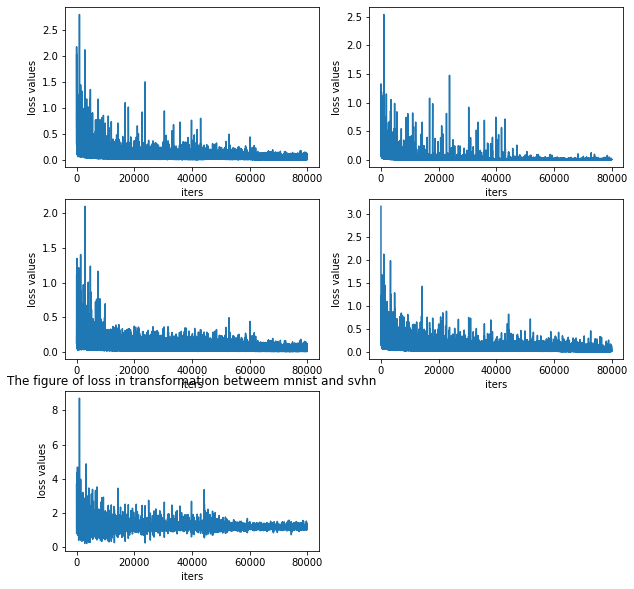

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
classes = [d_real_loss_list,d_mnist_loss_list,d_svhn_loss_list,d_fake_loss_list,g_loss_list]
labels = ['d_real_loss','d_mnist_loss','d_svhn_loss','d_fake_loss','g_loss']

for plt_index in range(1,6):
    ax = fig.add_subplot(3,2,plt_index)
    plt.plot(range(train_iters+1), classes[plt_index-1], label = labels[plt_index-1])
    plt.xlabel("iters")
    plt.ylabel("loss values")
    pass

plt.title("The figure of loss in transformation betweem mnist and svhn")
plt.show()

**Part4 Adapt to new dataset**

*The function to implement the transformation of the size of every images*

In [ ]:
from PIL import Image
import os.path
import glob
def convertjpg(jpgfile,outdir,width=32,height=32):
    img=Image.open(jpgfile)
    try:
        new_img=img.resize((width,height),Image.BILINEAR)   
        new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))
    except Exception as e:
        print(e)
for jpgfile in glob.glob("C:/Users/62300/Documents/MCE/deep learning/images/*.jpg"):
    convertjpg(jpgfile,"C:/Users/62300/Documents/MCE/deep learning/fashion_product_images_small")

*Training process*

In [29]:
sample_path2 = './samples_fashion'
model_path2 = './models_fashion'

In [30]:
if not os.path.exists(model_path2):
    os.makedirs(model_path2)
if not os.path.exists(sample_path2):
    os.makedirs(sample_path2)

*The function used to unzip the zip document*

In [31]:
import zipfile
zip_file = zipfile.ZipFile('./fashion_product_images_small.zip')
zip_list = zip_file.namelist() 

for f in zip_list:
    zip_file.extract(f, '/content') 
 
zip_file.close() 

In [32]:
#get the dataset of fashion_product_images_small
data1 = MyDataset("/content/fashion_product_images_small")

In [34]:
#generate the fashion_product_images_small dataloader
fashion_loader = DataLoader(data1, batch_size=64, shuffle=True, drop_last=True)

In [35]:
#generate the fashion mnist dataloader
Fashionmnist_loader = get_loader_fashion(image_size, batch_size, num_workers)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./Fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Fashionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./Fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Fashionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./Fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Fashionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./Fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Fashionmnist/FashionMNIST/raw



In [36]:
d_real_loss_list1, d_mnist_loss_list1, d_svhn_loss_list1, d_fake_loss_list1, g_loss_list1 = train(fashion_loader, Fashionmnist_loader, sample_path=sample_path2, model_path=model_path2)

Step [10/80000], d_real_loss: 0.5605, d_mnist_loss: 0.2489, d_svhn_loss: 0.3116, d_fake_loss: 0.5536, g_loss: 1.6397
Step [20/80000], d_real_loss: 0.3071, d_mnist_loss: 0.2252, d_svhn_loss: 0.0819, d_fake_loss: 1.1515, g_loss: 1.9518
Step [30/80000], d_real_loss: 1.2973, d_mnist_loss: 0.5733, d_svhn_loss: 0.7241, d_fake_loss: 0.7664, g_loss: 1.4946
Step [40/80000], d_real_loss: 0.7076, d_mnist_loss: 0.2406, d_svhn_loss: 0.4669, d_fake_loss: 0.8503, g_loss: 1.2400
Step [50/80000], d_real_loss: 0.5895, d_mnist_loss: 0.2166, d_svhn_loss: 0.3729, d_fake_loss: 0.6088, g_loss: 1.7787
Step [60/80000], d_real_loss: 0.7331, d_mnist_loss: 0.2228, d_svhn_loss: 0.5104, d_fake_loss: 0.6417, g_loss: 1.2463
Step [70/80000], d_real_loss: 0.5622, d_mnist_loss: 0.2035, d_svhn_loss: 0.3587, d_fake_loss: 0.5390, g_loss: 1.1724
Step [80/80000], d_real_loss: 0.9748, d_mnist_loss: 0.5313, d_svhn_loss: 0.4435, d_fake_loss: 1.3244, g_loss: 2.8657
Step [90/80000], d_real_loss: 0.4660, d_mnist_loss: 0.2871, d_sv

Step [500/80000], d_real_loss: 0.6125, d_mnist_loss: 0.2152, d_svhn_loss: 0.3973, d_fake_loss: 0.4577, g_loss: 1.4288
saved ./samples_fashion/sample-500-m-s.png
saved ./samples_fashion/sample-500-s-m.png
Step [510/80000], d_real_loss: 0.4807, d_mnist_loss: 0.2987, d_svhn_loss: 0.1820, d_fake_loss: 0.4884, g_loss: 1.2529
Step [520/80000], d_real_loss: 0.3889, d_mnist_loss: 0.2161, d_svhn_loss: 0.1728, d_fake_loss: 0.4810, g_loss: 1.2709
Step [530/80000], d_real_loss: 0.3643, d_mnist_loss: 0.2442, d_svhn_loss: 0.1201, d_fake_loss: 0.2365, g_loss: 1.2973
Step [540/80000], d_real_loss: 0.3282, d_mnist_loss: 0.2650, d_svhn_loss: 0.0632, d_fake_loss: 0.3818, g_loss: 1.8127
Step [550/80000], d_real_loss: 0.2815, d_mnist_loss: 0.1575, d_svhn_loss: 0.1241, d_fake_loss: 0.4153, g_loss: 1.3322
Step [560/80000], d_real_loss: 0.5054, d_mnist_loss: 0.1759, d_svhn_loss: 0.3295, d_fake_loss: 0.4804, g_loss: 1.3027
Step [570/80000], d_real_loss: 0.3421, d_mnist_loss: 0.0986, d_svhn_loss: 0.2434, d_fake

Step [1000/80000], d_real_loss: 0.3454, d_mnist_loss: 0.1397, d_svhn_loss: 0.2057, d_fake_loss: 0.3061, g_loss: 1.2015
saved ./samples_fashion/sample-1000-m-s.png
saved ./samples_fashion/sample-1000-s-m.png
Step [1010/80000], d_real_loss: 0.2687, d_mnist_loss: 0.1762, d_svhn_loss: 0.0926, d_fake_loss: 0.3188, g_loss: 1.6512
Step [1020/80000], d_real_loss: 0.2388, d_mnist_loss: 0.1508, d_svhn_loss: 0.0881, d_fake_loss: 0.2431, g_loss: 1.6155
Step [1030/80000], d_real_loss: 0.5074, d_mnist_loss: 0.1577, d_svhn_loss: 0.3497, d_fake_loss: 0.3473, g_loss: 1.6367
Step [1040/80000], d_real_loss: 0.3067, d_mnist_loss: 0.2098, d_svhn_loss: 0.0969, d_fake_loss: 0.1883, g_loss: 0.9490
Step [1050/80000], d_real_loss: 0.1913, d_mnist_loss: 0.0716, d_svhn_loss: 0.1197, d_fake_loss: 0.2115, g_loss: 1.4529
Step [1060/80000], d_real_loss: 0.2887, d_mnist_loss: 0.2387, d_svhn_loss: 0.0500, d_fake_loss: 0.4106, g_loss: 1.6640
Step [1070/80000], d_real_loss: 0.4028, d_mnist_loss: 0.3236, d_svhn_loss: 0.07

Step [1500/80000], d_real_loss: 0.2101, d_mnist_loss: 0.1561, d_svhn_loss: 0.0540, d_fake_loss: 0.1045, g_loss: 0.7956
saved ./samples_fashion/sample-1500-m-s.png
saved ./samples_fashion/sample-1500-s-m.png
Step [1510/80000], d_real_loss: 0.2134, d_mnist_loss: 0.0984, d_svhn_loss: 0.1151, d_fake_loss: 0.1400, g_loss: 1.4792
Step [1520/80000], d_real_loss: 0.1744, d_mnist_loss: 0.0883, d_svhn_loss: 0.0861, d_fake_loss: 0.1629, g_loss: 1.4852
Step [1530/80000], d_real_loss: 0.2260, d_mnist_loss: 0.1476, d_svhn_loss: 0.0785, d_fake_loss: 0.3062, g_loss: 1.3781
Step [1540/80000], d_real_loss: 0.3032, d_mnist_loss: 0.2238, d_svhn_loss: 0.0794, d_fake_loss: 0.3798, g_loss: 2.1137
Step [1550/80000], d_real_loss: 0.1692, d_mnist_loss: 0.0616, d_svhn_loss: 0.1076, d_fake_loss: 0.2787, g_loss: 1.2846
Step [1560/80000], d_real_loss: 0.2048, d_mnist_loss: 0.0598, d_svhn_loss: 0.1449, d_fake_loss: 0.1620, g_loss: 0.9895
Step [1570/80000], d_real_loss: 0.3437, d_mnist_loss: 0.1234, d_svhn_loss: 0.22

Step [2000/80000], d_real_loss: 0.1281, d_mnist_loss: 0.0622, d_svhn_loss: 0.0659, d_fake_loss: 0.1562, g_loss: 1.3980
saved ./samples_fashion/sample-2000-m-s.png
saved ./samples_fashion/sample-2000-s-m.png
Step [2010/80000], d_real_loss: 0.0692, d_mnist_loss: 0.0339, d_svhn_loss: 0.0353, d_fake_loss: 0.1660, g_loss: 1.5156
Step [2020/80000], d_real_loss: 0.2362, d_mnist_loss: 0.0567, d_svhn_loss: 0.1794, d_fake_loss: 0.1058, g_loss: 1.2172
Step [2030/80000], d_real_loss: 0.1557, d_mnist_loss: 0.0798, d_svhn_loss: 0.0759, d_fake_loss: 0.0979, g_loss: 1.2722
Step [2040/80000], d_real_loss: 0.2388, d_mnist_loss: 0.1401, d_svhn_loss: 0.0987, d_fake_loss: 0.3465, g_loss: 1.7249
Step [2050/80000], d_real_loss: 0.8988, d_mnist_loss: 0.0894, d_svhn_loss: 0.8094, d_fake_loss: 0.1948, g_loss: 1.0404
Step [2060/80000], d_real_loss: 0.2795, d_mnist_loss: 0.1581, d_svhn_loss: 0.1214, d_fake_loss: 0.1313, g_loss: 0.8642
Step [2070/80000], d_real_loss: 0.4211, d_mnist_loss: 0.0977, d_svhn_loss: 0.32

Step [2500/80000], d_real_loss: 0.1241, d_mnist_loss: 0.0302, d_svhn_loss: 0.0939, d_fake_loss: 0.2816, g_loss: 2.2751
saved ./samples_fashion/sample-2500-m-s.png
saved ./samples_fashion/sample-2500-s-m.png
Step [2510/80000], d_real_loss: 0.2967, d_mnist_loss: 0.1563, d_svhn_loss: 0.1403, d_fake_loss: 0.1006, g_loss: 1.1027
Step [2520/80000], d_real_loss: 0.1232, d_mnist_loss: 0.0584, d_svhn_loss: 0.0648, d_fake_loss: 0.1582, g_loss: 1.2574
Step [2530/80000], d_real_loss: 0.1013, d_mnist_loss: 0.0356, d_svhn_loss: 0.0657, d_fake_loss: 0.1077, g_loss: 1.5557
Step [2540/80000], d_real_loss: 0.2963, d_mnist_loss: 0.1683, d_svhn_loss: 0.1280, d_fake_loss: 0.2510, g_loss: 0.8142
Step [2550/80000], d_real_loss: 0.1417, d_mnist_loss: 0.0763, d_svhn_loss: 0.0654, d_fake_loss: 0.0895, g_loss: 1.2466
Step [2560/80000], d_real_loss: 0.2532, d_mnist_loss: 0.1892, d_svhn_loss: 0.0640, d_fake_loss: 0.1446, g_loss: 0.9321
Step [2570/80000], d_real_loss: 0.1429, d_mnist_loss: 0.0334, d_svhn_loss: 0.10

Step [3000/80000], d_real_loss: 0.3041, d_mnist_loss: 0.1089, d_svhn_loss: 0.1952, d_fake_loss: 0.1279, g_loss: 1.5421
saved ./samples_fashion/sample-3000-m-s.png
saved ./samples_fashion/sample-3000-s-m.png
Step [3010/80000], d_real_loss: 0.2573, d_mnist_loss: 0.1850, d_svhn_loss: 0.0723, d_fake_loss: 0.1367, g_loss: 0.8814
Step [3020/80000], d_real_loss: 0.2102, d_mnist_loss: 0.0545, d_svhn_loss: 0.1557, d_fake_loss: 0.0948, g_loss: 1.3381
Step [3030/80000], d_real_loss: 0.2533, d_mnist_loss: 0.0345, d_svhn_loss: 0.2187, d_fake_loss: 0.2257, g_loss: 1.4822
Step [3040/80000], d_real_loss: 0.1093, d_mnist_loss: 0.0770, d_svhn_loss: 0.0323, d_fake_loss: 0.0865, g_loss: 1.2733
Step [3050/80000], d_real_loss: 0.1915, d_mnist_loss: 0.0849, d_svhn_loss: 0.1066, d_fake_loss: 0.3455, g_loss: 1.1876
Step [3060/80000], d_real_loss: 0.1272, d_mnist_loss: 0.0787, d_svhn_loss: 0.0485, d_fake_loss: 0.7779, g_loss: 2.0568
Step [3070/80000], d_real_loss: 0.1177, d_mnist_loss: 0.0514, d_svhn_loss: 0.06

Step [3500/80000], d_real_loss: 0.0843, d_mnist_loss: 0.0342, d_svhn_loss: 0.0500, d_fake_loss: 0.1598, g_loss: 0.9354
saved ./samples_fashion/sample-3500-m-s.png
saved ./samples_fashion/sample-3500-s-m.png
Step [3510/80000], d_real_loss: 0.1227, d_mnist_loss: 0.0329, d_svhn_loss: 0.0898, d_fake_loss: 0.1393, g_loss: 1.1779
Step [3520/80000], d_real_loss: 0.0901, d_mnist_loss: 0.0340, d_svhn_loss: 0.0561, d_fake_loss: 0.3091, g_loss: 1.2458
Step [3530/80000], d_real_loss: 0.1149, d_mnist_loss: 0.0366, d_svhn_loss: 0.0784, d_fake_loss: 0.0553, g_loss: 1.3691
Step [3540/80000], d_real_loss: 0.1670, d_mnist_loss: 0.1109, d_svhn_loss: 0.0562, d_fake_loss: 0.1178, g_loss: 1.5947
Step [3550/80000], d_real_loss: 0.1354, d_mnist_loss: 0.0690, d_svhn_loss: 0.0664, d_fake_loss: 0.3226, g_loss: 2.0452
Step [3560/80000], d_real_loss: 0.2001, d_mnist_loss: 0.0788, d_svhn_loss: 0.1214, d_fake_loss: 0.1600, g_loss: 1.5318
Step [3570/80000], d_real_loss: 0.1209, d_mnist_loss: 0.0290, d_svhn_loss: 0.09

Step [4000/80000], d_real_loss: 0.0976, d_mnist_loss: 0.0355, d_svhn_loss: 0.0621, d_fake_loss: 0.0536, g_loss: 1.1650
saved ./samples_fashion/sample-4000-m-s.png
saved ./samples_fashion/sample-4000-s-m.png
Step [4010/80000], d_real_loss: 0.2260, d_mnist_loss: 0.0334, d_svhn_loss: 0.1926, d_fake_loss: 0.1834, g_loss: 1.4610
Step [4020/80000], d_real_loss: 0.1448, d_mnist_loss: 0.0804, d_svhn_loss: 0.0644, d_fake_loss: 0.1792, g_loss: 1.5738
Step [4030/80000], d_real_loss: 0.1873, d_mnist_loss: 0.0436, d_svhn_loss: 0.1437, d_fake_loss: 0.2779, g_loss: 1.3394
Step [4040/80000], d_real_loss: 0.1028, d_mnist_loss: 0.0424, d_svhn_loss: 0.0604, d_fake_loss: 0.1133, g_loss: 1.5392
Step [4050/80000], d_real_loss: 0.2046, d_mnist_loss: 0.0973, d_svhn_loss: 0.1073, d_fake_loss: 0.1709, g_loss: 1.4192
Step [4060/80000], d_real_loss: 0.1853, d_mnist_loss: 0.0340, d_svhn_loss: 0.1513, d_fake_loss: 0.2977, g_loss: 0.9481
Step [4070/80000], d_real_loss: 0.0828, d_mnist_loss: 0.0378, d_svhn_loss: 0.04

Step [4500/80000], d_real_loss: 0.1129, d_mnist_loss: 0.0277, d_svhn_loss: 0.0852, d_fake_loss: 0.1500, g_loss: 1.0602
saved ./samples_fashion/sample-4500-m-s.png
saved ./samples_fashion/sample-4500-s-m.png
Step [4510/80000], d_real_loss: 0.1083, d_mnist_loss: 0.0630, d_svhn_loss: 0.0452, d_fake_loss: 0.2026, g_loss: 1.6456
Step [4520/80000], d_real_loss: 0.1423, d_mnist_loss: 0.0938, d_svhn_loss: 0.0485, d_fake_loss: 0.1509, g_loss: 1.3744
Step [4530/80000], d_real_loss: 0.3548, d_mnist_loss: 0.0258, d_svhn_loss: 0.3289, d_fake_loss: 0.0730, g_loss: 1.0275
Step [4540/80000], d_real_loss: 0.1933, d_mnist_loss: 0.0799, d_svhn_loss: 0.1135, d_fake_loss: 0.1500, g_loss: 1.6179
Step [4550/80000], d_real_loss: 0.0632, d_mnist_loss: 0.0236, d_svhn_loss: 0.0396, d_fake_loss: 0.0546, g_loss: 1.4241
Step [4560/80000], d_real_loss: 0.2587, d_mnist_loss: 0.2017, d_svhn_loss: 0.0570, d_fake_loss: 0.1957, g_loss: 1.4106
Step [4570/80000], d_real_loss: 0.1381, d_mnist_loss: 0.0363, d_svhn_loss: 0.10

Step [5000/80000], d_real_loss: 0.1128, d_mnist_loss: 0.0451, d_svhn_loss: 0.0677, d_fake_loss: 0.0959, g_loss: 0.9991
saved ./samples_fashion/sample-5000-m-s.png
saved ./samples_fashion/sample-5000-s-m.png
Step [5010/80000], d_real_loss: 0.2061, d_mnist_loss: 0.0336, d_svhn_loss: 0.1725, d_fake_loss: 0.2115, g_loss: 1.3569
Step [5020/80000], d_real_loss: 0.1757, d_mnist_loss: 0.0169, d_svhn_loss: 0.1589, d_fake_loss: 0.0899, g_loss: 1.3000
Step [5030/80000], d_real_loss: 0.2318, d_mnist_loss: 0.1118, d_svhn_loss: 0.1201, d_fake_loss: 0.1030, g_loss: 1.2044
Step [5040/80000], d_real_loss: 0.0998, d_mnist_loss: 0.0211, d_svhn_loss: 0.0787, d_fake_loss: 0.1034, g_loss: 1.1883
Step [5050/80000], d_real_loss: 0.1600, d_mnist_loss: 0.0937, d_svhn_loss: 0.0663, d_fake_loss: 0.0699, g_loss: 1.4127
Step [5060/80000], d_real_loss: 0.0852, d_mnist_loss: 0.0285, d_svhn_loss: 0.0567, d_fake_loss: 0.3078, g_loss: 1.7774
Step [5070/80000], d_real_loss: 0.1448, d_mnist_loss: 0.0216, d_svhn_loss: 0.12

Step [5500/80000], d_real_loss: 0.2044, d_mnist_loss: 0.0955, d_svhn_loss: 0.1089, d_fake_loss: 0.1634, g_loss: 1.6575
saved ./samples_fashion/sample-5500-m-s.png
saved ./samples_fashion/sample-5500-s-m.png
Step [5510/80000], d_real_loss: 0.1468, d_mnist_loss: 0.0275, d_svhn_loss: 0.1193, d_fake_loss: 0.2985, g_loss: 1.2079
Step [5520/80000], d_real_loss: 0.1379, d_mnist_loss: 0.0444, d_svhn_loss: 0.0934, d_fake_loss: 0.1385, g_loss: 0.8486
Step [5530/80000], d_real_loss: 0.1478, d_mnist_loss: 0.0402, d_svhn_loss: 0.1077, d_fake_loss: 0.1263, g_loss: 0.9267
Step [5540/80000], d_real_loss: 0.1893, d_mnist_loss: 0.1525, d_svhn_loss: 0.0367, d_fake_loss: 0.1790, g_loss: 1.6483
Step [5550/80000], d_real_loss: 0.0696, d_mnist_loss: 0.0294, d_svhn_loss: 0.0402, d_fake_loss: 0.1274, g_loss: 1.5309
Step [5560/80000], d_real_loss: 0.1620, d_mnist_loss: 0.0452, d_svhn_loss: 0.1168, d_fake_loss: 0.0810, g_loss: 1.2763
Step [5570/80000], d_real_loss: 0.1004, d_mnist_loss: 0.0262, d_svhn_loss: 0.07

Step [6000/80000], d_real_loss: 0.0701, d_mnist_loss: 0.0256, d_svhn_loss: 0.0444, d_fake_loss: 0.0622, g_loss: 1.2774
saved ./samples_fashion/sample-6000-m-s.png
saved ./samples_fashion/sample-6000-s-m.png
Step [6010/80000], d_real_loss: 0.1261, d_mnist_loss: 0.0480, d_svhn_loss: 0.0781, d_fake_loss: 0.0644, g_loss: 1.0901
Step [6020/80000], d_real_loss: 0.1150, d_mnist_loss: 0.0480, d_svhn_loss: 0.0671, d_fake_loss: 0.0590, g_loss: 1.0007
Step [6030/80000], d_real_loss: 0.0596, d_mnist_loss: 0.0204, d_svhn_loss: 0.0392, d_fake_loss: 0.0628, g_loss: 1.3152
Step [6040/80000], d_real_loss: 0.2125, d_mnist_loss: 0.0700, d_svhn_loss: 0.1426, d_fake_loss: 0.1284, g_loss: 1.2971
Step [6050/80000], d_real_loss: 0.2826, d_mnist_loss: 0.0807, d_svhn_loss: 0.2019, d_fake_loss: 0.1674, g_loss: 0.7115
Step [6060/80000], d_real_loss: 0.0683, d_mnist_loss: 0.0277, d_svhn_loss: 0.0406, d_fake_loss: 0.0641, g_loss: 1.1431
Step [6070/80000], d_real_loss: 0.0833, d_mnist_loss: 0.0503, d_svhn_loss: 0.03

Step [6500/80000], d_real_loss: 0.1275, d_mnist_loss: 0.0715, d_svhn_loss: 0.0560, d_fake_loss: 0.0511, g_loss: 1.0302
saved ./samples_fashion/sample-6500-m-s.png
saved ./samples_fashion/sample-6500-s-m.png
Step [6510/80000], d_real_loss: 0.0832, d_mnist_loss: 0.0245, d_svhn_loss: 0.0587, d_fake_loss: 0.1015, g_loss: 1.3973
Step [6520/80000], d_real_loss: 0.2462, d_mnist_loss: 0.0185, d_svhn_loss: 0.2277, d_fake_loss: 0.0951, g_loss: 1.2514
Step [6530/80000], d_real_loss: 0.7486, d_mnist_loss: 0.5632, d_svhn_loss: 0.1854, d_fake_loss: 0.5379, g_loss: 2.5321
Step [6540/80000], d_real_loss: 0.0603, d_mnist_loss: 0.0294, d_svhn_loss: 0.0309, d_fake_loss: 0.1717, g_loss: 1.1337
Step [6550/80000], d_real_loss: 0.2858, d_mnist_loss: 0.0185, d_svhn_loss: 0.2672, d_fake_loss: 0.0832, g_loss: 1.2966
Step [6560/80000], d_real_loss: 0.0797, d_mnist_loss: 0.0461, d_svhn_loss: 0.0335, d_fake_loss: 0.0906, g_loss: 1.0318
Step [6570/80000], d_real_loss: 0.1658, d_mnist_loss: 0.0306, d_svhn_loss: 0.13

Step [7000/80000], d_real_loss: 0.1185, d_mnist_loss: 0.0209, d_svhn_loss: 0.0976, d_fake_loss: 0.0735, g_loss: 1.1610
saved ./samples_fashion/sample-7000-m-s.png
saved ./samples_fashion/sample-7000-s-m.png
Step [7010/80000], d_real_loss: 0.1564, d_mnist_loss: 0.0283, d_svhn_loss: 0.1280, d_fake_loss: 0.0928, g_loss: 0.9534
Step [7020/80000], d_real_loss: 0.0857, d_mnist_loss: 0.0226, d_svhn_loss: 0.0631, d_fake_loss: 0.0813, g_loss: 0.9834
Step [7030/80000], d_real_loss: 0.1206, d_mnist_loss: 0.0427, d_svhn_loss: 0.0778, d_fake_loss: 0.0779, g_loss: 1.0299
Step [7040/80000], d_real_loss: 0.0607, d_mnist_loss: 0.0245, d_svhn_loss: 0.0362, d_fake_loss: 0.0438, g_loss: 0.9287
Step [7050/80000], d_real_loss: 0.1856, d_mnist_loss: 0.1330, d_svhn_loss: 0.0526, d_fake_loss: 0.3443, g_loss: 1.6930
Step [7060/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0252, d_svhn_loss: 0.0464, d_fake_loss: 0.0590, g_loss: 1.1986
Step [7070/80000], d_real_loss: 0.0880, d_mnist_loss: 0.0291, d_svhn_loss: 0.05

Step [7500/80000], d_real_loss: 0.1600, d_mnist_loss: 0.1004, d_svhn_loss: 0.0596, d_fake_loss: 0.1437, g_loss: 1.1128
saved ./samples_fashion/sample-7500-m-s.png
saved ./samples_fashion/sample-7500-s-m.png
Step [7510/80000], d_real_loss: 0.2451, d_mnist_loss: 0.0402, d_svhn_loss: 0.2049, d_fake_loss: 0.2372, g_loss: 1.5485
Step [7520/80000], d_real_loss: 0.1386, d_mnist_loss: 0.0510, d_svhn_loss: 0.0876, d_fake_loss: 0.1417, g_loss: 1.3935
Step [7530/80000], d_real_loss: 0.0637, d_mnist_loss: 0.0160, d_svhn_loss: 0.0476, d_fake_loss: 0.0719, g_loss: 1.1942
Step [7540/80000], d_real_loss: 0.4911, d_mnist_loss: 0.0191, d_svhn_loss: 0.4721, d_fake_loss: 0.2747, g_loss: 0.8475
Step [7550/80000], d_real_loss: 0.1122, d_mnist_loss: 0.0168, d_svhn_loss: 0.0954, d_fake_loss: 0.1659, g_loss: 1.3100
Step [7560/80000], d_real_loss: 0.1961, d_mnist_loss: 0.0230, d_svhn_loss: 0.1732, d_fake_loss: 0.1076, g_loss: 1.1805
Step [7570/80000], d_real_loss: 0.0834, d_mnist_loss: 0.0182, d_svhn_loss: 0.06

Step [8000/80000], d_real_loss: 0.1165, d_mnist_loss: 0.0185, d_svhn_loss: 0.0981, d_fake_loss: 0.1430, g_loss: 1.1960
saved ./samples_fashion/sample-8000-m-s.png
saved ./samples_fashion/sample-8000-s-m.png
Step [8010/80000], d_real_loss: 0.0684, d_mnist_loss: 0.0280, d_svhn_loss: 0.0404, d_fake_loss: 0.0518, g_loss: 1.1733
Step [8020/80000], d_real_loss: 0.0590, d_mnist_loss: 0.0223, d_svhn_loss: 0.0367, d_fake_loss: 0.0404, g_loss: 1.1517
Step [8030/80000], d_real_loss: 0.0714, d_mnist_loss: 0.0163, d_svhn_loss: 0.0552, d_fake_loss: 0.0876, g_loss: 1.4166
Step [8040/80000], d_real_loss: 0.1277, d_mnist_loss: 0.0750, d_svhn_loss: 0.0526, d_fake_loss: 0.1097, g_loss: 1.1935
Step [8050/80000], d_real_loss: 0.1982, d_mnist_loss: 0.0888, d_svhn_loss: 0.1094, d_fake_loss: 0.4873, g_loss: 1.5642
Step [8060/80000], d_real_loss: 0.1353, d_mnist_loss: 0.0316, d_svhn_loss: 0.1036, d_fake_loss: 0.0955, g_loss: 1.0888
Step [8070/80000], d_real_loss: 0.0811, d_mnist_loss: 0.0291, d_svhn_loss: 0.05

Step [8500/80000], d_real_loss: 0.0751, d_mnist_loss: 0.0259, d_svhn_loss: 0.0492, d_fake_loss: 0.5593, g_loss: 1.4454
saved ./samples_fashion/sample-8500-m-s.png
saved ./samples_fashion/sample-8500-s-m.png
Step [8510/80000], d_real_loss: 0.1690, d_mnist_loss: 0.0235, d_svhn_loss: 0.1455, d_fake_loss: 0.0667, g_loss: 1.1479
Step [8520/80000], d_real_loss: 0.0842, d_mnist_loss: 0.0487, d_svhn_loss: 0.0355, d_fake_loss: 0.1536, g_loss: 1.4868
Step [8530/80000], d_real_loss: 0.1763, d_mnist_loss: 0.0694, d_svhn_loss: 0.1069, d_fake_loss: 0.2125, g_loss: 0.6231
Step [8540/80000], d_real_loss: 0.0650, d_mnist_loss: 0.0265, d_svhn_loss: 0.0386, d_fake_loss: 0.0602, g_loss: 1.0076
Step [8550/80000], d_real_loss: 0.0622, d_mnist_loss: 0.0270, d_svhn_loss: 0.0352, d_fake_loss: 0.0635, g_loss: 1.2286
Step [8560/80000], d_real_loss: 0.1418, d_mnist_loss: 0.1011, d_svhn_loss: 0.0407, d_fake_loss: 0.1057, g_loss: 1.1795
Step [8570/80000], d_real_loss: 0.1080, d_mnist_loss: 0.0345, d_svhn_loss: 0.07

Step [9000/80000], d_real_loss: 0.0741, d_mnist_loss: 0.0286, d_svhn_loss: 0.0455, d_fake_loss: 0.1708, g_loss: 1.1014
saved ./samples_fashion/sample-9000-m-s.png
saved ./samples_fashion/sample-9000-s-m.png
Step [9010/80000], d_real_loss: 0.0533, d_mnist_loss: 0.0251, d_svhn_loss: 0.0282, d_fake_loss: 0.0420, g_loss: 1.1008
Step [9020/80000], d_real_loss: 0.0667, d_mnist_loss: 0.0355, d_svhn_loss: 0.0312, d_fake_loss: 0.1659, g_loss: 1.2348
Step [9030/80000], d_real_loss: 0.1828, d_mnist_loss: 0.0160, d_svhn_loss: 0.1667, d_fake_loss: 0.3031, g_loss: 1.4413
Step [9040/80000], d_real_loss: 0.2815, d_mnist_loss: 0.2400, d_svhn_loss: 0.0414, d_fake_loss: 0.1812, g_loss: 1.9051
Step [9050/80000], d_real_loss: 0.0641, d_mnist_loss: 0.0361, d_svhn_loss: 0.0280, d_fake_loss: 0.0453, g_loss: 1.1164
Step [9060/80000], d_real_loss: 0.0443, d_mnist_loss: 0.0192, d_svhn_loss: 0.0250, d_fake_loss: 0.1060, g_loss: 1.3550
Step [9070/80000], d_real_loss: 0.0925, d_mnist_loss: 0.0167, d_svhn_loss: 0.07

Step [9500/80000], d_real_loss: 0.4007, d_mnist_loss: 0.3527, d_svhn_loss: 0.0479, d_fake_loss: 0.3320, g_loss: 1.9383
saved ./samples_fashion/sample-9500-m-s.png
saved ./samples_fashion/sample-9500-s-m.png
Step [9510/80000], d_real_loss: 0.1231, d_mnist_loss: 0.0351, d_svhn_loss: 0.0880, d_fake_loss: 0.0503, g_loss: 1.0798
Step [9520/80000], d_real_loss: 0.1310, d_mnist_loss: 0.0755, d_svhn_loss: 0.0555, d_fake_loss: 0.1315, g_loss: 1.6108
Step [9530/80000], d_real_loss: 0.0805, d_mnist_loss: 0.0302, d_svhn_loss: 0.0502, d_fake_loss: 0.0558, g_loss: 1.0103
Step [9540/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0209, d_svhn_loss: 0.0363, d_fake_loss: 0.1089, g_loss: 1.0602
Step [9550/80000], d_real_loss: 0.1477, d_mnist_loss: 0.0400, d_svhn_loss: 0.1076, d_fake_loss: 0.0558, g_loss: 1.1187
Step [9560/80000], d_real_loss: 0.1054, d_mnist_loss: 0.0162, d_svhn_loss: 0.0892, d_fake_loss: 0.1209, g_loss: 1.3724
Step [9570/80000], d_real_loss: 0.0970, d_mnist_loss: 0.0330, d_svhn_loss: 0.06

Step [10000/80000], d_real_loss: 0.1202, d_mnist_loss: 0.0332, d_svhn_loss: 0.0870, d_fake_loss: 0.1475, g_loss: 1.0848
saved ./samples_fashion/sample-10000-m-s.png
saved ./samples_fashion/sample-10000-s-m.png
Step [10010/80000], d_real_loss: 0.0940, d_mnist_loss: 0.0130, d_svhn_loss: 0.0810, d_fake_loss: 0.0770, g_loss: 0.8130
Step [10020/80000], d_real_loss: 0.1992, d_mnist_loss: 0.0188, d_svhn_loss: 0.1804, d_fake_loss: 0.0603, g_loss: 0.9908
Step [10030/80000], d_real_loss: 0.0674, d_mnist_loss: 0.0187, d_svhn_loss: 0.0487, d_fake_loss: 0.0894, g_loss: 1.1513
Step [10040/80000], d_real_loss: 0.0664, d_mnist_loss: 0.0249, d_svhn_loss: 0.0415, d_fake_loss: 0.0522, g_loss: 1.1991
Step [10050/80000], d_real_loss: 0.0808, d_mnist_loss: 0.0156, d_svhn_loss: 0.0652, d_fake_loss: 0.1024, g_loss: 1.2437
Step [10060/80000], d_real_loss: 0.2016, d_mnist_loss: 0.0202, d_svhn_loss: 0.1814, d_fake_loss: 0.0952, g_loss: 1.2537
Step [10070/80000], d_real_loss: 0.0991, d_mnist_loss: 0.0196, d_svhn_

Step [10500/80000], d_real_loss: 0.1023, d_mnist_loss: 0.0670, d_svhn_loss: 0.0353, d_fake_loss: 0.0851, g_loss: 1.2403
saved ./samples_fashion/sample-10500-m-s.png
saved ./samples_fashion/sample-10500-s-m.png
Step [10510/80000], d_real_loss: 0.0867, d_mnist_loss: 0.0160, d_svhn_loss: 0.0708, d_fake_loss: 0.0264, g_loss: 1.0081
Step [10520/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0199, d_svhn_loss: 0.0487, d_fake_loss: 0.1872, g_loss: 0.7085
Step [10530/80000], d_real_loss: 0.0429, d_mnist_loss: 0.0146, d_svhn_loss: 0.0282, d_fake_loss: 0.1041, g_loss: 1.3538
Step [10540/80000], d_real_loss: 0.0632, d_mnist_loss: 0.0178, d_svhn_loss: 0.0454, d_fake_loss: 0.0476, g_loss: 1.0904
Step [10550/80000], d_real_loss: 0.0889, d_mnist_loss: 0.0200, d_svhn_loss: 0.0689, d_fake_loss: 0.0912, g_loss: 1.1413
Step [10560/80000], d_real_loss: 0.0656, d_mnist_loss: 0.0277, d_svhn_loss: 0.0379, d_fake_loss: 0.0943, g_loss: 1.0954
Step [10570/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0141, d_svhn_

Step [11000/80000], d_real_loss: 0.0838, d_mnist_loss: 0.0475, d_svhn_loss: 0.0363, d_fake_loss: 0.0585, g_loss: 1.0983
saved ./samples_fashion/sample-11000-m-s.png
saved ./samples_fashion/sample-11000-s-m.png
Step [11010/80000], d_real_loss: 0.1765, d_mnist_loss: 0.0116, d_svhn_loss: 0.1649, d_fake_loss: 0.0855, g_loss: 1.1765
Step [11020/80000], d_real_loss: 0.1073, d_mnist_loss: 0.0164, d_svhn_loss: 0.0909, d_fake_loss: 0.1032, g_loss: 1.1338
Step [11030/80000], d_real_loss: 0.0857, d_mnist_loss: 0.0455, d_svhn_loss: 0.0402, d_fake_loss: 0.0962, g_loss: 1.0918
Step [11040/80000], d_real_loss: 0.0666, d_mnist_loss: 0.0190, d_svhn_loss: 0.0476, d_fake_loss: 0.0589, g_loss: 1.1894
Step [11050/80000], d_real_loss: 0.0531, d_mnist_loss: 0.0147, d_svhn_loss: 0.0384, d_fake_loss: 0.0693, g_loss: 1.1219
Step [11060/80000], d_real_loss: 0.1136, d_mnist_loss: 0.0754, d_svhn_loss: 0.0382, d_fake_loss: 0.0817, g_loss: 1.4028
Step [11070/80000], d_real_loss: 0.0900, d_mnist_loss: 0.0363, d_svhn_

Step [11500/80000], d_real_loss: 0.0991, d_mnist_loss: 0.0404, d_svhn_loss: 0.0587, d_fake_loss: 0.2934, g_loss: 1.7747
saved ./samples_fashion/sample-11500-m-s.png
saved ./samples_fashion/sample-11500-s-m.png
Step [11510/80000], d_real_loss: 0.0963, d_mnist_loss: 0.0197, d_svhn_loss: 0.0766, d_fake_loss: 0.1111, g_loss: 1.2373
Step [11520/80000], d_real_loss: 0.0577, d_mnist_loss: 0.0169, d_svhn_loss: 0.0408, d_fake_loss: 0.0461, g_loss: 1.1052
Step [11530/80000], d_real_loss: 0.0815, d_mnist_loss: 0.0375, d_svhn_loss: 0.0440, d_fake_loss: 0.0534, g_loss: 1.2677
Step [11540/80000], d_real_loss: 0.0503, d_mnist_loss: 0.0163, d_svhn_loss: 0.0341, d_fake_loss: 0.0862, g_loss: 1.1911
Step [11550/80000], d_real_loss: 0.0741, d_mnist_loss: 0.0321, d_svhn_loss: 0.0420, d_fake_loss: 0.1243, g_loss: 1.1862
Step [11560/80000], d_real_loss: 0.0379, d_mnist_loss: 0.0189, d_svhn_loss: 0.0190, d_fake_loss: 0.0600, g_loss: 1.1357
Step [11570/80000], d_real_loss: 0.1409, d_mnist_loss: 0.0623, d_svhn_

Step [12000/80000], d_real_loss: 0.0560, d_mnist_loss: 0.0180, d_svhn_loss: 0.0380, d_fake_loss: 0.0320, g_loss: 1.2188
saved ./samples_fashion/sample-12000-m-s.png
saved ./samples_fashion/sample-12000-s-m.png
Step [12010/80000], d_real_loss: 0.0615, d_mnist_loss: 0.0195, d_svhn_loss: 0.0420, d_fake_loss: 0.0468, g_loss: 1.1870
Step [12020/80000], d_real_loss: 0.1917, d_mnist_loss: 0.0137, d_svhn_loss: 0.1780, d_fake_loss: 0.0783, g_loss: 1.3584
Step [12030/80000], d_real_loss: 0.0935, d_mnist_loss: 0.0091, d_svhn_loss: 0.0844, d_fake_loss: 0.0611, g_loss: 1.1331
Step [12040/80000], d_real_loss: 0.2198, d_mnist_loss: 0.0251, d_svhn_loss: 0.1947, d_fake_loss: 0.1779, g_loss: 1.0714
Step [12050/80000], d_real_loss: 0.0802, d_mnist_loss: 0.0439, d_svhn_loss: 0.0363, d_fake_loss: 0.2193, g_loss: 0.4966
Step [12060/80000], d_real_loss: 0.1460, d_mnist_loss: 0.0419, d_svhn_loss: 0.1040, d_fake_loss: 0.1354, g_loss: 1.1913
Step [12070/80000], d_real_loss: 0.0644, d_mnist_loss: 0.0253, d_svhn_

Step [12500/80000], d_real_loss: 0.0707, d_mnist_loss: 0.0323, d_svhn_loss: 0.0384, d_fake_loss: 0.0749, g_loss: 1.4304
saved ./samples_fashion/sample-12500-m-s.png
saved ./samples_fashion/sample-12500-s-m.png
Step [12510/80000], d_real_loss: 0.1659, d_mnist_loss: 0.0145, d_svhn_loss: 0.1514, d_fake_loss: 0.4447, g_loss: 0.9444
Step [12520/80000], d_real_loss: 0.1104, d_mnist_loss: 0.0239, d_svhn_loss: 0.0865, d_fake_loss: 0.0681, g_loss: 1.3403
Step [12530/80000], d_real_loss: 0.1075, d_mnist_loss: 0.0595, d_svhn_loss: 0.0480, d_fake_loss: 0.0495, g_loss: 1.0513
Step [12540/80000], d_real_loss: 0.0561, d_mnist_loss: 0.0229, d_svhn_loss: 0.0332, d_fake_loss: 0.0449, g_loss: 1.1230
Step [12550/80000], d_real_loss: 0.0688, d_mnist_loss: 0.0302, d_svhn_loss: 0.0386, d_fake_loss: 0.1471, g_loss: 1.3232
Step [12560/80000], d_real_loss: 0.1135, d_mnist_loss: 0.0158, d_svhn_loss: 0.0978, d_fake_loss: 0.1896, g_loss: 1.0354
Step [12570/80000], d_real_loss: 0.0800, d_mnist_loss: 0.0126, d_svhn_

Step [13000/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0174, d_svhn_loss: 0.0512, d_fake_loss: 0.0595, g_loss: 0.9779
saved ./samples_fashion/sample-13000-m-s.png
saved ./samples_fashion/sample-13000-s-m.png
Step [13010/80000], d_real_loss: 0.1841, d_mnist_loss: 0.0260, d_svhn_loss: 0.1581, d_fake_loss: 0.0939, g_loss: 1.3860
Step [13020/80000], d_real_loss: 0.1122, d_mnist_loss: 0.0569, d_svhn_loss: 0.0553, d_fake_loss: 0.1500, g_loss: 1.4495
Step [13030/80000], d_real_loss: 0.0532, d_mnist_loss: 0.0149, d_svhn_loss: 0.0383, d_fake_loss: 0.0613, g_loss: 1.1858
Step [13040/80000], d_real_loss: 0.1129, d_mnist_loss: 0.0413, d_svhn_loss: 0.0717, d_fake_loss: 0.1189, g_loss: 1.0212
Step [13050/80000], d_real_loss: 0.0476, d_mnist_loss: 0.0141, d_svhn_loss: 0.0335, d_fake_loss: 0.0358, g_loss: 1.2497
Step [13060/80000], d_real_loss: 0.1231, d_mnist_loss: 0.0165, d_svhn_loss: 0.1066, d_fake_loss: 0.0830, g_loss: 1.3886
Step [13070/80000], d_real_loss: 0.1170, d_mnist_loss: 0.0448, d_svhn_

Step [13500/80000], d_real_loss: 0.0879, d_mnist_loss: 0.0514, d_svhn_loss: 0.0366, d_fake_loss: 0.0861, g_loss: 1.3731
saved ./samples_fashion/sample-13500-m-s.png
saved ./samples_fashion/sample-13500-s-m.png
Step [13510/80000], d_real_loss: 0.1245, d_mnist_loss: 0.0899, d_svhn_loss: 0.0346, d_fake_loss: 0.0816, g_loss: 1.1240
Step [13520/80000], d_real_loss: 0.0769, d_mnist_loss: 0.0120, d_svhn_loss: 0.0649, d_fake_loss: 0.0571, g_loss: 1.0658
Step [13530/80000], d_real_loss: 0.2261, d_mnist_loss: 0.0746, d_svhn_loss: 0.1515, d_fake_loss: 0.1324, g_loss: 1.0521
Step [13540/80000], d_real_loss: 0.0856, d_mnist_loss: 0.0135, d_svhn_loss: 0.0721, d_fake_loss: 0.1926, g_loss: 1.3742
Step [13550/80000], d_real_loss: 0.1418, d_mnist_loss: 0.0125, d_svhn_loss: 0.1293, d_fake_loss: 0.0562, g_loss: 1.0885
Step [13560/80000], d_real_loss: 0.0611, d_mnist_loss: 0.0277, d_svhn_loss: 0.0334, d_fake_loss: 0.0471, g_loss: 1.0551
Step [13570/80000], d_real_loss: 0.0585, d_mnist_loss: 0.0115, d_svhn_

Step [14000/80000], d_real_loss: 0.3093, d_mnist_loss: 0.0174, d_svhn_loss: 0.2918, d_fake_loss: 0.1368, g_loss: 1.1057
saved ./samples_fashion/sample-14000-m-s.png
saved ./samples_fashion/sample-14000-s-m.png
Step [14010/80000], d_real_loss: 0.0691, d_mnist_loss: 0.0219, d_svhn_loss: 0.0472, d_fake_loss: 0.0683, g_loss: 1.1226
Step [14020/80000], d_real_loss: 0.0837, d_mnist_loss: 0.0310, d_svhn_loss: 0.0527, d_fake_loss: 0.0537, g_loss: 1.1026
Step [14030/80000], d_real_loss: 0.0801, d_mnist_loss: 0.0206, d_svhn_loss: 0.0595, d_fake_loss: 0.0941, g_loss: 1.1273
Step [14040/80000], d_real_loss: 0.1207, d_mnist_loss: 0.0366, d_svhn_loss: 0.0841, d_fake_loss: 0.0699, g_loss: 1.1069
Step [14050/80000], d_real_loss: 0.1664, d_mnist_loss: 0.1207, d_svhn_loss: 0.0457, d_fake_loss: 0.0960, g_loss: 1.1609
Step [14060/80000], d_real_loss: 0.1636, d_mnist_loss: 0.0175, d_svhn_loss: 0.1461, d_fake_loss: 0.0979, g_loss: 1.2469
Step [14070/80000], d_real_loss: 0.0468, d_mnist_loss: 0.0123, d_svhn_

Step [14500/80000], d_real_loss: 0.0916, d_mnist_loss: 0.0131, d_svhn_loss: 0.0785, d_fake_loss: 0.1149, g_loss: 1.0681
saved ./samples_fashion/sample-14500-m-s.png
saved ./samples_fashion/sample-14500-s-m.png
Step [14510/80000], d_real_loss: 0.0967, d_mnist_loss: 0.0278, d_svhn_loss: 0.0689, d_fake_loss: 0.0848, g_loss: 1.2355
Step [14520/80000], d_real_loss: 0.0608, d_mnist_loss: 0.0154, d_svhn_loss: 0.0454, d_fake_loss: 0.0689, g_loss: 1.2174
Step [14530/80000], d_real_loss: 0.1238, d_mnist_loss: 0.0142, d_svhn_loss: 0.1097, d_fake_loss: 0.0658, g_loss: 1.3204
Step [14540/80000], d_real_loss: 0.0888, d_mnist_loss: 0.0496, d_svhn_loss: 0.0392, d_fake_loss: 0.1228, g_loss: 1.2275
Step [14550/80000], d_real_loss: 0.0701, d_mnist_loss: 0.0170, d_svhn_loss: 0.0532, d_fake_loss: 0.0602, g_loss: 1.2725
Step [14560/80000], d_real_loss: 0.1527, d_mnist_loss: 0.0271, d_svhn_loss: 0.1257, d_fake_loss: 0.1495, g_loss: 0.7980
Step [14570/80000], d_real_loss: 0.1387, d_mnist_loss: 0.1039, d_svhn_

Step [15000/80000], d_real_loss: 0.1637, d_mnist_loss: 0.0131, d_svhn_loss: 0.1506, d_fake_loss: 0.1452, g_loss: 1.1545
saved ./samples_fashion/sample-15000-m-s.png
saved ./samples_fashion/sample-15000-s-m.png
Step [15010/80000], d_real_loss: 0.0796, d_mnist_loss: 0.0114, d_svhn_loss: 0.0682, d_fake_loss: 0.0504, g_loss: 1.1835
Step [15020/80000], d_real_loss: 0.0776, d_mnist_loss: 0.0266, d_svhn_loss: 0.0510, d_fake_loss: 0.0367, g_loss: 1.2162
Step [15030/80000], d_real_loss: 0.0617, d_mnist_loss: 0.0176, d_svhn_loss: 0.0441, d_fake_loss: 0.0340, g_loss: 1.1921
Step [15040/80000], d_real_loss: 0.0666, d_mnist_loss: 0.0181, d_svhn_loss: 0.0484, d_fake_loss: 0.0601, g_loss: 1.0913
Step [15050/80000], d_real_loss: 0.0991, d_mnist_loss: 0.0156, d_svhn_loss: 0.0835, d_fake_loss: 0.1086, g_loss: 1.3846
Step [15060/80000], d_real_loss: 0.0871, d_mnist_loss: 0.0177, d_svhn_loss: 0.0694, d_fake_loss: 0.1184, g_loss: 1.2705
Step [15070/80000], d_real_loss: 0.0768, d_mnist_loss: 0.0130, d_svhn_

Step [15500/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0242, d_svhn_loss: 0.0418, d_fake_loss: 0.1747, g_loss: 1.3355
saved ./samples_fashion/sample-15500-m-s.png
saved ./samples_fashion/sample-15500-s-m.png
Step [15510/80000], d_real_loss: 0.0659, d_mnist_loss: 0.0181, d_svhn_loss: 0.0477, d_fake_loss: 0.0323, g_loss: 1.1142
Step [15520/80000], d_real_loss: 0.0801, d_mnist_loss: 0.0308, d_svhn_loss: 0.0493, d_fake_loss: 0.0406, g_loss: 1.1013
Step [15530/80000], d_real_loss: 0.0774, d_mnist_loss: 0.0428, d_svhn_loss: 0.0346, d_fake_loss: 0.0870, g_loss: 1.1458
Step [15540/80000], d_real_loss: 0.0995, d_mnist_loss: 0.0664, d_svhn_loss: 0.0331, d_fake_loss: 0.0649, g_loss: 1.3794
Step [15550/80000], d_real_loss: 0.0905, d_mnist_loss: 0.0180, d_svhn_loss: 0.0725, d_fake_loss: 0.0490, g_loss: 1.1321
Step [15560/80000], d_real_loss: 0.0584, d_mnist_loss: 0.0176, d_svhn_loss: 0.0408, d_fake_loss: 0.0398, g_loss: 1.1601
Step [15570/80000], d_real_loss: 0.0628, d_mnist_loss: 0.0230, d_svhn_

Step [16000/80000], d_real_loss: 0.0541, d_mnist_loss: 0.0120, d_svhn_loss: 0.0421, d_fake_loss: 0.1259, g_loss: 1.1953
saved ./samples_fashion/sample-16000-m-s.png
saved ./samples_fashion/sample-16000-s-m.png
Step [16010/80000], d_real_loss: 0.1152, d_mnist_loss: 0.0217, d_svhn_loss: 0.0936, d_fake_loss: 0.1191, g_loss: 0.9254
Step [16020/80000], d_real_loss: 0.0475, d_mnist_loss: 0.0145, d_svhn_loss: 0.0331, d_fake_loss: 0.1096, g_loss: 1.1632
Step [16030/80000], d_real_loss: 0.0823, d_mnist_loss: 0.0125, d_svhn_loss: 0.0699, d_fake_loss: 0.0571, g_loss: 1.1827
Step [16040/80000], d_real_loss: 0.0747, d_mnist_loss: 0.0340, d_svhn_loss: 0.0407, d_fake_loss: 0.1254, g_loss: 1.0809
Step [16050/80000], d_real_loss: 0.1152, d_mnist_loss: 0.0339, d_svhn_loss: 0.0812, d_fake_loss: 0.0584, g_loss: 1.1206
Step [16060/80000], d_real_loss: 0.1523, d_mnist_loss: 0.0303, d_svhn_loss: 0.1220, d_fake_loss: 0.1923, g_loss: 1.1051
Step [16070/80000], d_real_loss: 0.1701, d_mnist_loss: 0.1285, d_svhn_

Step [16500/80000], d_real_loss: 0.0951, d_mnist_loss: 0.0310, d_svhn_loss: 0.0641, d_fake_loss: 0.1016, g_loss: 1.0816
saved ./samples_fashion/sample-16500-m-s.png
saved ./samples_fashion/sample-16500-s-m.png
Step [16510/80000], d_real_loss: 0.0824, d_mnist_loss: 0.0150, d_svhn_loss: 0.0674, d_fake_loss: 0.0384, g_loss: 1.0447
Step [16520/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0094, d_svhn_loss: 0.0310, d_fake_loss: 0.0833, g_loss: 0.8744
Step [16530/80000], d_real_loss: 0.0726, d_mnist_loss: 0.0337, d_svhn_loss: 0.0389, d_fake_loss: 0.0507, g_loss: 1.1146
Step [16540/80000], d_real_loss: 0.1337, d_mnist_loss: 0.0148, d_svhn_loss: 0.1189, d_fake_loss: 0.0620, g_loss: 1.0880
Step [16550/80000], d_real_loss: 0.0757, d_mnist_loss: 0.0167, d_svhn_loss: 0.0590, d_fake_loss: 0.0994, g_loss: 0.7645
Step [16560/80000], d_real_loss: 0.0515, d_mnist_loss: 0.0239, d_svhn_loss: 0.0277, d_fake_loss: 0.0448, g_loss: 1.0708
Step [16570/80000], d_real_loss: 0.0731, d_mnist_loss: 0.0159, d_svhn_

Step [17000/80000], d_real_loss: 0.1173, d_mnist_loss: 0.0168, d_svhn_loss: 0.1005, d_fake_loss: 0.2090, g_loss: 1.5557
saved ./samples_fashion/sample-17000-m-s.png
saved ./samples_fashion/sample-17000-s-m.png
Step [17010/80000], d_real_loss: 0.0534, d_mnist_loss: 0.0100, d_svhn_loss: 0.0434, d_fake_loss: 0.0523, g_loss: 0.9951
Step [17020/80000], d_real_loss: 0.0723, d_mnist_loss: 0.0399, d_svhn_loss: 0.0324, d_fake_loss: 0.0504, g_loss: 1.0658
Step [17030/80000], d_real_loss: 0.0947, d_mnist_loss: 0.0197, d_svhn_loss: 0.0750, d_fake_loss: 0.1127, g_loss: 0.8882
Step [17040/80000], d_real_loss: 0.0878, d_mnist_loss: 0.0172, d_svhn_loss: 0.0705, d_fake_loss: 0.1033, g_loss: 1.2512
Step [17050/80000], d_real_loss: 0.0916, d_mnist_loss: 0.0391, d_svhn_loss: 0.0525, d_fake_loss: 0.0717, g_loss: 1.4336
Step [17060/80000], d_real_loss: 0.0578, d_mnist_loss: 0.0182, d_svhn_loss: 0.0397, d_fake_loss: 0.0951, g_loss: 1.0623
Step [17070/80000], d_real_loss: 0.0672, d_mnist_loss: 0.0135, d_svhn_

Step [17500/80000], d_real_loss: 0.0667, d_mnist_loss: 0.0261, d_svhn_loss: 0.0406, d_fake_loss: 0.1454, g_loss: 1.3437
saved ./samples_fashion/sample-17500-m-s.png
saved ./samples_fashion/sample-17500-s-m.png
Step [17510/80000], d_real_loss: 0.0939, d_mnist_loss: 0.0217, d_svhn_loss: 0.0722, d_fake_loss: 0.1936, g_loss: 1.1889
Step [17520/80000], d_real_loss: 0.0653, d_mnist_loss: 0.0237, d_svhn_loss: 0.0415, d_fake_loss: 0.1137, g_loss: 1.5375
Step [17530/80000], d_real_loss: 0.1626, d_mnist_loss: 0.0647, d_svhn_loss: 0.0978, d_fake_loss: 0.2092, g_loss: 1.1678
Step [17540/80000], d_real_loss: 0.0465, d_mnist_loss: 0.0130, d_svhn_loss: 0.0335, d_fake_loss: 0.0756, g_loss: 1.3079
Step [17550/80000], d_real_loss: 0.0918, d_mnist_loss: 0.0225, d_svhn_loss: 0.0693, d_fake_loss: 0.1388, g_loss: 0.9321
Step [17560/80000], d_real_loss: 0.0750, d_mnist_loss: 0.0106, d_svhn_loss: 0.0644, d_fake_loss: 0.0324, g_loss: 1.1381
Step [17570/80000], d_real_loss: 0.0972, d_mnist_loss: 0.0554, d_svhn_

Step [18000/80000], d_real_loss: 0.1027, d_mnist_loss: 0.0427, d_svhn_loss: 0.0600, d_fake_loss: 0.0985, g_loss: 1.0473
saved ./samples_fashion/sample-18000-m-s.png
saved ./samples_fashion/sample-18000-s-m.png
Step [18010/80000], d_real_loss: 0.2097, d_mnist_loss: 0.0508, d_svhn_loss: 0.1588, d_fake_loss: 0.1106, g_loss: 1.2157
Step [18020/80000], d_real_loss: 0.0605, d_mnist_loss: 0.0143, d_svhn_loss: 0.0462, d_fake_loss: 0.0895, g_loss: 1.1494
Step [18030/80000], d_real_loss: 0.0494, d_mnist_loss: 0.0155, d_svhn_loss: 0.0339, d_fake_loss: 0.0551, g_loss: 0.9605
Step [18040/80000], d_real_loss: 0.1125, d_mnist_loss: 0.0768, d_svhn_loss: 0.0357, d_fake_loss: 0.0739, g_loss: 1.4443
Step [18050/80000], d_real_loss: 0.0587, d_mnist_loss: 0.0119, d_svhn_loss: 0.0469, d_fake_loss: 0.0382, g_loss: 1.1932
Step [18060/80000], d_real_loss: 0.1245, d_mnist_loss: 0.0139, d_svhn_loss: 0.1106, d_fake_loss: 0.0589, g_loss: 0.9648
Step [18070/80000], d_real_loss: 0.1039, d_mnist_loss: 0.0356, d_svhn_

Step [18500/80000], d_real_loss: 0.0505, d_mnist_loss: 0.0123, d_svhn_loss: 0.0381, d_fake_loss: 0.0321, g_loss: 0.9833
saved ./samples_fashion/sample-18500-m-s.png
saved ./samples_fashion/sample-18500-s-m.png
Step [18510/80000], d_real_loss: 0.0825, d_mnist_loss: 0.0240, d_svhn_loss: 0.0584, d_fake_loss: 0.0980, g_loss: 1.3078
Step [18520/80000], d_real_loss: 0.0433, d_mnist_loss: 0.0109, d_svhn_loss: 0.0324, d_fake_loss: 0.0428, g_loss: 1.3355
Step [18530/80000], d_real_loss: 0.2164, d_mnist_loss: 0.0121, d_svhn_loss: 0.2043, d_fake_loss: 0.1225, g_loss: 0.6964
Step [18540/80000], d_real_loss: 0.0796, d_mnist_loss: 0.0225, d_svhn_loss: 0.0571, d_fake_loss: 0.2328, g_loss: 1.1087
Step [18550/80000], d_real_loss: 0.1764, d_mnist_loss: 0.0158, d_svhn_loss: 0.1606, d_fake_loss: 0.1411, g_loss: 1.2147
Step [18560/80000], d_real_loss: 0.0532, d_mnist_loss: 0.0149, d_svhn_loss: 0.0383, d_fake_loss: 0.0329, g_loss: 1.0679
Step [18570/80000], d_real_loss: 0.1330, d_mnist_loss: 0.0116, d_svhn_

Step [19000/80000], d_real_loss: 0.1169, d_mnist_loss: 0.0446, d_svhn_loss: 0.0723, d_fake_loss: 0.1415, g_loss: 1.2240
saved ./samples_fashion/sample-19000-m-s.png
saved ./samples_fashion/sample-19000-s-m.png
Step [19010/80000], d_real_loss: 0.0449, d_mnist_loss: 0.0128, d_svhn_loss: 0.0321, d_fake_loss: 0.0751, g_loss: 1.1658
Step [19020/80000], d_real_loss: 0.1157, d_mnist_loss: 0.0401, d_svhn_loss: 0.0755, d_fake_loss: 0.0595, g_loss: 0.8980
Step [19030/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0114, d_svhn_loss: 0.0279, d_fake_loss: 0.0823, g_loss: 1.0823
Step [19040/80000], d_real_loss: 0.1064, d_mnist_loss: 0.0606, d_svhn_loss: 0.0458, d_fake_loss: 0.0425, g_loss: 1.0516
Step [19050/80000], d_real_loss: 0.0438, d_mnist_loss: 0.0125, d_svhn_loss: 0.0313, d_fake_loss: 0.0546, g_loss: 1.0159
Step [19060/80000], d_real_loss: 0.1885, d_mnist_loss: 0.0973, d_svhn_loss: 0.0912, d_fake_loss: 0.1880, g_loss: 1.5589
Step [19070/80000], d_real_loss: 0.1497, d_mnist_loss: 0.0181, d_svhn_

Step [19500/80000], d_real_loss: 0.0826, d_mnist_loss: 0.0115, d_svhn_loss: 0.0711, d_fake_loss: 0.0772, g_loss: 1.0813
saved ./samples_fashion/sample-19500-m-s.png
saved ./samples_fashion/sample-19500-s-m.png
Step [19510/80000], d_real_loss: 0.0479, d_mnist_loss: 0.0162, d_svhn_loss: 0.0317, d_fake_loss: 0.0479, g_loss: 1.2925
Step [19520/80000], d_real_loss: 0.0560, d_mnist_loss: 0.0227, d_svhn_loss: 0.0333, d_fake_loss: 0.0401, g_loss: 1.2956
Step [19530/80000], d_real_loss: 0.0802, d_mnist_loss: 0.0392, d_svhn_loss: 0.0410, d_fake_loss: 0.0929, g_loss: 1.1594
Step [19540/80000], d_real_loss: 0.0711, d_mnist_loss: 0.0398, d_svhn_loss: 0.0313, d_fake_loss: 0.0469, g_loss: 1.1364
Step [19550/80000], d_real_loss: 0.0412, d_mnist_loss: 0.0099, d_svhn_loss: 0.0313, d_fake_loss: 0.0768, g_loss: 1.1251
Step [19560/80000], d_real_loss: 0.0788, d_mnist_loss: 0.0355, d_svhn_loss: 0.0433, d_fake_loss: 0.0588, g_loss: 1.0898
Step [19570/80000], d_real_loss: 0.2408, d_mnist_loss: 0.0105, d_svhn_

Step [20000/80000], d_real_loss: 0.0752, d_mnist_loss: 0.0298, d_svhn_loss: 0.0453, d_fake_loss: 0.1231, g_loss: 1.3655
saved ./samples_fashion/sample-20000-m-s.png
saved ./samples_fashion/sample-20000-s-m.png
Step [20010/80000], d_real_loss: 0.2307, d_mnist_loss: 0.0148, d_svhn_loss: 0.2159, d_fake_loss: 0.0453, g_loss: 1.1379
Step [20020/80000], d_real_loss: 0.0689, d_mnist_loss: 0.0105, d_svhn_loss: 0.0584, d_fake_loss: 0.0363, g_loss: 1.0993
Step [20030/80000], d_real_loss: 0.0748, d_mnist_loss: 0.0117, d_svhn_loss: 0.0631, d_fake_loss: 0.1207, g_loss: 1.2361
Step [20040/80000], d_real_loss: 0.0613, d_mnist_loss: 0.0131, d_svhn_loss: 0.0483, d_fake_loss: 0.0560, g_loss: 1.1649
Step [20050/80000], d_real_loss: 0.0837, d_mnist_loss: 0.0232, d_svhn_loss: 0.0605, d_fake_loss: 0.1650, g_loss: 1.0968
Step [20060/80000], d_real_loss: 0.0713, d_mnist_loss: 0.0178, d_svhn_loss: 0.0534, d_fake_loss: 0.0426, g_loss: 1.1896
Step [20070/80000], d_real_loss: 0.0813, d_mnist_loss: 0.0369, d_svhn_

Step [20500/80000], d_real_loss: 0.0430, d_mnist_loss: 0.0176, d_svhn_loss: 0.0253, d_fake_loss: 0.0573, g_loss: 1.1563
saved ./samples_fashion/sample-20500-m-s.png
saved ./samples_fashion/sample-20500-s-m.png
Step [20510/80000], d_real_loss: 0.1271, d_mnist_loss: 0.0656, d_svhn_loss: 0.0616, d_fake_loss: 0.0381, g_loss: 1.2432
Step [20520/80000], d_real_loss: 0.0726, d_mnist_loss: 0.0309, d_svhn_loss: 0.0417, d_fake_loss: 0.1494, g_loss: 0.8475
Step [20530/80000], d_real_loss: 0.1142, d_mnist_loss: 0.0108, d_svhn_loss: 0.1034, d_fake_loss: 0.1743, g_loss: 1.4434
Step [20540/80000], d_real_loss: 0.0527, d_mnist_loss: 0.0292, d_svhn_loss: 0.0235, d_fake_loss: 0.0552, g_loss: 0.9957
Step [20550/80000], d_real_loss: 0.0773, d_mnist_loss: 0.0066, d_svhn_loss: 0.0707, d_fake_loss: 0.0978, g_loss: 0.9913
Step [20560/80000], d_real_loss: 0.0764, d_mnist_loss: 0.0209, d_svhn_loss: 0.0555, d_fake_loss: 0.0369, g_loss: 1.1389
Step [20570/80000], d_real_loss: 0.0488, d_mnist_loss: 0.0194, d_svhn_

Step [21000/80000], d_real_loss: 0.1831, d_mnist_loss: 0.0267, d_svhn_loss: 0.1564, d_fake_loss: 0.0531, g_loss: 1.1229
saved ./samples_fashion/sample-21000-m-s.png
saved ./samples_fashion/sample-21000-s-m.png
Step [21010/80000], d_real_loss: 0.0822, d_mnist_loss: 0.0173, d_svhn_loss: 0.0649, d_fake_loss: 0.2006, g_loss: 1.2681
Step [21020/80000], d_real_loss: 0.1696, d_mnist_loss: 0.0101, d_svhn_loss: 0.1596, d_fake_loss: 0.0887, g_loss: 1.1185
Step [21030/80000], d_real_loss: 0.1202, d_mnist_loss: 0.0097, d_svhn_loss: 0.1105, d_fake_loss: 0.1752, g_loss: 1.1534
Step [21040/80000], d_real_loss: 0.0509, d_mnist_loss: 0.0196, d_svhn_loss: 0.0314, d_fake_loss: 0.0663, g_loss: 1.0053
Step [21050/80000], d_real_loss: 0.0721, d_mnist_loss: 0.0126, d_svhn_loss: 0.0596, d_fake_loss: 0.1157, g_loss: 0.8918
Step [21060/80000], d_real_loss: 0.0640, d_mnist_loss: 0.0220, d_svhn_loss: 0.0421, d_fake_loss: 0.0745, g_loss: 0.9870
Step [21070/80000], d_real_loss: 0.0980, d_mnist_loss: 0.0348, d_svhn_

Step [21500/80000], d_real_loss: 0.0781, d_mnist_loss: 0.0216, d_svhn_loss: 0.0565, d_fake_loss: 0.0566, g_loss: 1.0902
saved ./samples_fashion/sample-21500-m-s.png
saved ./samples_fashion/sample-21500-s-m.png
Step [21510/80000], d_real_loss: 0.0740, d_mnist_loss: 0.0371, d_svhn_loss: 0.0369, d_fake_loss: 0.0907, g_loss: 1.1496
Step [21520/80000], d_real_loss: 0.1432, d_mnist_loss: 0.0213, d_svhn_loss: 0.1220, d_fake_loss: 0.1168, g_loss: 1.1502
Step [21530/80000], d_real_loss: 0.0600, d_mnist_loss: 0.0266, d_svhn_loss: 0.0334, d_fake_loss: 0.0522, g_loss: 1.1513
Step [21540/80000], d_real_loss: 0.1879, d_mnist_loss: 0.0927, d_svhn_loss: 0.0952, d_fake_loss: 0.0802, g_loss: 1.3806
Step [21550/80000], d_real_loss: 0.0842, d_mnist_loss: 0.0329, d_svhn_loss: 0.0514, d_fake_loss: 0.0465, g_loss: 1.1725
Step [21560/80000], d_real_loss: 0.0526, d_mnist_loss: 0.0244, d_svhn_loss: 0.0282, d_fake_loss: 0.0924, g_loss: 1.1335
Step [21570/80000], d_real_loss: 0.0704, d_mnist_loss: 0.0316, d_svhn_

Step [22000/80000], d_real_loss: 0.1828, d_mnist_loss: 0.0559, d_svhn_loss: 0.1269, d_fake_loss: 0.0461, g_loss: 1.1939
saved ./samples_fashion/sample-22000-m-s.png
saved ./samples_fashion/sample-22000-s-m.png
Step [22010/80000], d_real_loss: 0.0562, d_mnist_loss: 0.0117, d_svhn_loss: 0.0445, d_fake_loss: 0.0618, g_loss: 1.3059
Step [22020/80000], d_real_loss: 0.1716, d_mnist_loss: 0.0389, d_svhn_loss: 0.1328, d_fake_loss: 0.1053, g_loss: 1.0558
Step [22030/80000], d_real_loss: 0.0926, d_mnist_loss: 0.0654, d_svhn_loss: 0.0272, d_fake_loss: 0.0815, g_loss: 1.2284
Step [22040/80000], d_real_loss: 0.1268, d_mnist_loss: 0.0779, d_svhn_loss: 0.0489, d_fake_loss: 0.1379, g_loss: 1.8404
Step [22050/80000], d_real_loss: 0.1191, d_mnist_loss: 0.0284, d_svhn_loss: 0.0906, d_fake_loss: 0.0590, g_loss: 1.0513
Step [22060/80000], d_real_loss: 0.0974, d_mnist_loss: 0.0131, d_svhn_loss: 0.0843, d_fake_loss: 0.0516, g_loss: 1.1594
Step [22070/80000], d_real_loss: 0.0728, d_mnist_loss: 0.0111, d_svhn_

Step [22500/80000], d_real_loss: 0.1052, d_mnist_loss: 0.0178, d_svhn_loss: 0.0874, d_fake_loss: 0.0792, g_loss: 0.9587
saved ./samples_fashion/sample-22500-m-s.png
saved ./samples_fashion/sample-22500-s-m.png
Step [22510/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0093, d_svhn_loss: 0.0272, d_fake_loss: 0.0496, g_loss: 0.9585
Step [22520/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0129, d_svhn_loss: 0.0263, d_fake_loss: 0.0613, g_loss: 0.9957
Step [22530/80000], d_real_loss: 0.0698, d_mnist_loss: 0.0105, d_svhn_loss: 0.0592, d_fake_loss: 0.0382, g_loss: 1.0583
Step [22540/80000], d_real_loss: 0.0341, d_mnist_loss: 0.0096, d_svhn_loss: 0.0245, d_fake_loss: 0.1560, g_loss: 1.0861
Step [22550/80000], d_real_loss: 0.0968, d_mnist_loss: 0.0340, d_svhn_loss: 0.0628, d_fake_loss: 0.0458, g_loss: 1.1285
Step [22560/80000], d_real_loss: 0.0529, d_mnist_loss: 0.0061, d_svhn_loss: 0.0468, d_fake_loss: 0.0743, g_loss: 1.1086
Step [22570/80000], d_real_loss: 0.1199, d_mnist_loss: 0.0186, d_svhn_

Step [23000/80000], d_real_loss: 0.0415, d_mnist_loss: 0.0082, d_svhn_loss: 0.0333, d_fake_loss: 0.0807, g_loss: 1.0470
saved ./samples_fashion/sample-23000-m-s.png
saved ./samples_fashion/sample-23000-s-m.png
Step [23010/80000], d_real_loss: 0.0378, d_mnist_loss: 0.0097, d_svhn_loss: 0.0281, d_fake_loss: 0.0442, g_loss: 1.0527
Step [23020/80000], d_real_loss: 0.0782, d_mnist_loss: 0.0531, d_svhn_loss: 0.0251, d_fake_loss: 0.0568, g_loss: 1.1064
Step [23030/80000], d_real_loss: 0.1414, d_mnist_loss: 0.0282, d_svhn_loss: 0.1132, d_fake_loss: 0.0415, g_loss: 1.0960
Step [23040/80000], d_real_loss: 0.0624, d_mnist_loss: 0.0148, d_svhn_loss: 0.0476, d_fake_loss: 0.0730, g_loss: 1.3753
Step [23050/80000], d_real_loss: 0.1401, d_mnist_loss: 0.0360, d_svhn_loss: 0.1041, d_fake_loss: 0.0762, g_loss: 1.1487
Step [23060/80000], d_real_loss: 0.0738, d_mnist_loss: 0.0084, d_svhn_loss: 0.0654, d_fake_loss: 0.0865, g_loss: 1.1345
Step [23070/80000], d_real_loss: 0.0741, d_mnist_loss: 0.0411, d_svhn_

Step [23500/80000], d_real_loss: 0.0361, d_mnist_loss: 0.0121, d_svhn_loss: 0.0240, d_fake_loss: 0.0950, g_loss: 1.1218
saved ./samples_fashion/sample-23500-m-s.png
saved ./samples_fashion/sample-23500-s-m.png
Step [23510/80000], d_real_loss: 0.1417, d_mnist_loss: 0.0174, d_svhn_loss: 0.1242, d_fake_loss: 0.0681, g_loss: 0.8866
Step [23520/80000], d_real_loss: 0.1533, d_mnist_loss: 0.0611, d_svhn_loss: 0.0922, d_fake_loss: 0.0339, g_loss: 0.9576
Step [23530/80000], d_real_loss: 0.0491, d_mnist_loss: 0.0115, d_svhn_loss: 0.0376, d_fake_loss: 0.0302, g_loss: 1.1124
Step [23540/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0067, d_svhn_loss: 0.0336, d_fake_loss: 0.0448, g_loss: 1.1122
Step [23550/80000], d_real_loss: 0.1894, d_mnist_loss: 0.0420, d_svhn_loss: 0.1473, d_fake_loss: 0.2994, g_loss: 1.3032
Step [23560/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0118, d_svhn_loss: 0.0273, d_fake_loss: 0.0759, g_loss: 0.8846
Step [23570/80000], d_real_loss: 0.0827, d_mnist_loss: 0.0323, d_svhn_

Step [24000/80000], d_real_loss: 0.0507, d_mnist_loss: 0.0272, d_svhn_loss: 0.0236, d_fake_loss: 0.0517, g_loss: 1.0282
saved ./samples_fashion/sample-24000-m-s.png
saved ./samples_fashion/sample-24000-s-m.png
Step [24010/80000], d_real_loss: 0.0535, d_mnist_loss: 0.0183, d_svhn_loss: 0.0352, d_fake_loss: 0.0379, g_loss: 1.1537
Step [24020/80000], d_real_loss: 0.0318, d_mnist_loss: 0.0091, d_svhn_loss: 0.0228, d_fake_loss: 0.0884, g_loss: 1.0433
Step [24030/80000], d_real_loss: 0.0374, d_mnist_loss: 0.0134, d_svhn_loss: 0.0240, d_fake_loss: 0.0538, g_loss: 1.0320
Step [24040/80000], d_real_loss: 0.0748, d_mnist_loss: 0.0107, d_svhn_loss: 0.0640, d_fake_loss: 0.1142, g_loss: 0.8585
Step [24050/80000], d_real_loss: 0.0413, d_mnist_loss: 0.0145, d_svhn_loss: 0.0268, d_fake_loss: 0.0385, g_loss: 1.0616
Step [24060/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0306, d_svhn_loss: 0.0232, d_fake_loss: 0.0744, g_loss: 1.2819
Step [24070/80000], d_real_loss: 0.0350, d_mnist_loss: 0.0108, d_svhn_

Step [24500/80000], d_real_loss: 0.0724, d_mnist_loss: 0.0142, d_svhn_loss: 0.0583, d_fake_loss: 0.0557, g_loss: 1.1781
saved ./samples_fashion/sample-24500-m-s.png
saved ./samples_fashion/sample-24500-s-m.png
Step [24510/80000], d_real_loss: 0.0864, d_mnist_loss: 0.0095, d_svhn_loss: 0.0769, d_fake_loss: 0.0706, g_loss: 1.1016
Step [24520/80000], d_real_loss: 0.0440, d_mnist_loss: 0.0068, d_svhn_loss: 0.0372, d_fake_loss: 0.0298, g_loss: 1.1682
Step [24530/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0322, d_svhn_loss: 0.0250, d_fake_loss: 0.0835, g_loss: 1.2584
Step [24540/80000], d_real_loss: 0.0469, d_mnist_loss: 0.0077, d_svhn_loss: 0.0392, d_fake_loss: 0.0631, g_loss: 1.5066
Step [24550/80000], d_real_loss: 0.0392, d_mnist_loss: 0.0125, d_svhn_loss: 0.0267, d_fake_loss: 0.0513, g_loss: 1.0875
Step [24560/80000], d_real_loss: 0.0579, d_mnist_loss: 0.0145, d_svhn_loss: 0.0435, d_fake_loss: 0.0502, g_loss: 0.9434
Step [24570/80000], d_real_loss: 0.0874, d_mnist_loss: 0.0122, d_svhn_

Step [25000/80000], d_real_loss: 0.0399, d_mnist_loss: 0.0147, d_svhn_loss: 0.0252, d_fake_loss: 0.0497, g_loss: 0.8777
saved ./samples_fashion/sample-25000-m-s.png
saved ./samples_fashion/sample-25000-s-m.png
Step [25010/80000], d_real_loss: 0.0819, d_mnist_loss: 0.0358, d_svhn_loss: 0.0460, d_fake_loss: 0.0571, g_loss: 1.4655
Step [25020/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0227, d_svhn_loss: 0.0339, d_fake_loss: 0.0940, g_loss: 1.0801
Step [25030/80000], d_real_loss: 0.0429, d_mnist_loss: 0.0146, d_svhn_loss: 0.0283, d_fake_loss: 0.0466, g_loss: 1.0769
Step [25040/80000], d_real_loss: 0.0324, d_mnist_loss: 0.0104, d_svhn_loss: 0.0219, d_fake_loss: 0.0998, g_loss: 0.9155
Step [25050/80000], d_real_loss: 0.2503, d_mnist_loss: 0.0330, d_svhn_loss: 0.2173, d_fake_loss: 0.0463, g_loss: 1.0496
Step [25060/80000], d_real_loss: 0.0476, d_mnist_loss: 0.0095, d_svhn_loss: 0.0381, d_fake_loss: 0.1563, g_loss: 1.3019
Step [25070/80000], d_real_loss: 0.0559, d_mnist_loss: 0.0295, d_svhn_

Step [25500/80000], d_real_loss: 0.0445, d_mnist_loss: 0.0094, d_svhn_loss: 0.0351, d_fake_loss: 0.0402, g_loss: 1.1407
saved ./samples_fashion/sample-25500-m-s.png
saved ./samples_fashion/sample-25500-s-m.png
Step [25510/80000], d_real_loss: 0.0731, d_mnist_loss: 0.0137, d_svhn_loss: 0.0594, d_fake_loss: 0.0736, g_loss: 1.2014
Step [25520/80000], d_real_loss: 0.0700, d_mnist_loss: 0.0280, d_svhn_loss: 0.0420, d_fake_loss: 0.0729, g_loss: 1.1123
Step [25530/80000], d_real_loss: 0.0295, d_mnist_loss: 0.0079, d_svhn_loss: 0.0216, d_fake_loss: 0.0663, g_loss: 1.0680
Step [25540/80000], d_real_loss: 0.0481, d_mnist_loss: 0.0110, d_svhn_loss: 0.0371, d_fake_loss: 0.1034, g_loss: 1.1296
Step [25550/80000], d_real_loss: 0.0843, d_mnist_loss: 0.0544, d_svhn_loss: 0.0298, d_fake_loss: 0.0620, g_loss: 1.0362
Step [25560/80000], d_real_loss: 0.0753, d_mnist_loss: 0.0339, d_svhn_loss: 0.0415, d_fake_loss: 0.0458, g_loss: 1.2668
Step [25570/80000], d_real_loss: 0.0323, d_mnist_loss: 0.0148, d_svhn_

Step [26000/80000], d_real_loss: 0.0508, d_mnist_loss: 0.0227, d_svhn_loss: 0.0281, d_fake_loss: 0.0439, g_loss: 1.1462
saved ./samples_fashion/sample-26000-m-s.png
saved ./samples_fashion/sample-26000-s-m.png
Step [26010/80000], d_real_loss: 0.0683, d_mnist_loss: 0.0344, d_svhn_loss: 0.0339, d_fake_loss: 0.0362, g_loss: 1.2151
Step [26020/80000], d_real_loss: 0.1778, d_mnist_loss: 0.0113, d_svhn_loss: 0.1665, d_fake_loss: 0.1843, g_loss: 1.4800
Step [26030/80000], d_real_loss: 0.1033, d_mnist_loss: 0.0122, d_svhn_loss: 0.0911, d_fake_loss: 0.0397, g_loss: 1.1166
Step [26040/80000], d_real_loss: 0.0887, d_mnist_loss: 0.0209, d_svhn_loss: 0.0678, d_fake_loss: 0.0913, g_loss: 1.3589
Step [26050/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0112, d_svhn_loss: 0.0426, d_fake_loss: 0.0418, g_loss: 1.0143
Step [26060/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0200, d_svhn_loss: 0.0339, d_fake_loss: 0.0935, g_loss: 1.1767
Step [26070/80000], d_real_loss: 0.0397, d_mnist_loss: 0.0183, d_svhn_

Step [26500/80000], d_real_loss: 0.1642, d_mnist_loss: 0.0178, d_svhn_loss: 0.1463, d_fake_loss: 0.1590, g_loss: 1.0649
saved ./samples_fashion/sample-26500-m-s.png
saved ./samples_fashion/sample-26500-s-m.png
Step [26510/80000], d_real_loss: 0.0491, d_mnist_loss: 0.0158, d_svhn_loss: 0.0333, d_fake_loss: 0.0494, g_loss: 1.1510
Step [26520/80000], d_real_loss: 0.0543, d_mnist_loss: 0.0093, d_svhn_loss: 0.0450, d_fake_loss: 0.0524, g_loss: 1.1028
Step [26530/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0131, d_svhn_loss: 0.0235, d_fake_loss: 0.0333, g_loss: 1.1580
Step [26540/80000], d_real_loss: 0.0364, d_mnist_loss: 0.0148, d_svhn_loss: 0.0216, d_fake_loss: 0.0426, g_loss: 1.1339
Step [26550/80000], d_real_loss: 0.0907, d_mnist_loss: 0.0459, d_svhn_loss: 0.0448, d_fake_loss: 0.0542, g_loss: 1.0710
Step [26560/80000], d_real_loss: 0.1297, d_mnist_loss: 0.0075, d_svhn_loss: 0.1221, d_fake_loss: 0.0906, g_loss: 1.1089
Step [26570/80000], d_real_loss: 0.0746, d_mnist_loss: 0.0100, d_svhn_

Step [27000/80000], d_real_loss: 0.0430, d_mnist_loss: 0.0150, d_svhn_loss: 0.0280, d_fake_loss: 0.0318, g_loss: 1.0878
saved ./samples_fashion/sample-27000-m-s.png
saved ./samples_fashion/sample-27000-s-m.png
Step [27010/80000], d_real_loss: 0.0469, d_mnist_loss: 0.0138, d_svhn_loss: 0.0331, d_fake_loss: 0.0451, g_loss: 1.1756
Step [27020/80000], d_real_loss: 0.0532, d_mnist_loss: 0.0226, d_svhn_loss: 0.0305, d_fake_loss: 0.0396, g_loss: 1.0399
Step [27030/80000], d_real_loss: 0.0500, d_mnist_loss: 0.0083, d_svhn_loss: 0.0418, d_fake_loss: 0.0713, g_loss: 1.2113
Step [27040/80000], d_real_loss: 0.0678, d_mnist_loss: 0.0081, d_svhn_loss: 0.0597, d_fake_loss: 0.0400, g_loss: 1.0338
Step [27050/80000], d_real_loss: 0.0627, d_mnist_loss: 0.0338, d_svhn_loss: 0.0289, d_fake_loss: 0.0448, g_loss: 1.1191
Step [27060/80000], d_real_loss: 0.1016, d_mnist_loss: 0.0207, d_svhn_loss: 0.0809, d_fake_loss: 0.0439, g_loss: 1.1418
Step [27070/80000], d_real_loss: 0.1086, d_mnist_loss: 0.0348, d_svhn_

Step [27500/80000], d_real_loss: 0.0763, d_mnist_loss: 0.0301, d_svhn_loss: 0.0462, d_fake_loss: 0.0383, g_loss: 1.0566
saved ./samples_fashion/sample-27500-m-s.png
saved ./samples_fashion/sample-27500-s-m.png
Step [27510/80000], d_real_loss: 0.1201, d_mnist_loss: 0.0122, d_svhn_loss: 0.1078, d_fake_loss: 0.0555, g_loss: 1.0579
Step [27520/80000], d_real_loss: 0.0443, d_mnist_loss: 0.0260, d_svhn_loss: 0.0183, d_fake_loss: 0.0628, g_loss: 1.1906
Step [27530/80000], d_real_loss: 0.1830, d_mnist_loss: 0.0677, d_svhn_loss: 0.1153, d_fake_loss: 0.1071, g_loss: 1.1941
Step [27540/80000], d_real_loss: 0.0400, d_mnist_loss: 0.0163, d_svhn_loss: 0.0238, d_fake_loss: 0.0603, g_loss: 1.1978
Step [27550/80000], d_real_loss: 0.0811, d_mnist_loss: 0.0515, d_svhn_loss: 0.0296, d_fake_loss: 0.0334, g_loss: 1.0702
Step [27560/80000], d_real_loss: 0.0676, d_mnist_loss: 0.0365, d_svhn_loss: 0.0312, d_fake_loss: 0.0346, g_loss: 1.0210
Step [27570/80000], d_real_loss: 0.0466, d_mnist_loss: 0.0133, d_svhn_

Step [28000/80000], d_real_loss: 0.0844, d_mnist_loss: 0.0364, d_svhn_loss: 0.0480, d_fake_loss: 0.0508, g_loss: 1.0624
saved ./samples_fashion/sample-28000-m-s.png
saved ./samples_fashion/sample-28000-s-m.png
Step [28010/80000], d_real_loss: 0.0820, d_mnist_loss: 0.0135, d_svhn_loss: 0.0685, d_fake_loss: 0.0953, g_loss: 1.1226
Step [28020/80000], d_real_loss: 0.1763, d_mnist_loss: 0.0092, d_svhn_loss: 0.1671, d_fake_loss: 0.0606, g_loss: 1.1459
Step [28030/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0112, d_svhn_loss: 0.0279, d_fake_loss: 0.0906, g_loss: 1.2552
Step [28040/80000], d_real_loss: 0.0659, d_mnist_loss: 0.0135, d_svhn_loss: 0.0524, d_fake_loss: 0.0914, g_loss: 0.8814
Step [28050/80000], d_real_loss: 0.0526, d_mnist_loss: 0.0120, d_svhn_loss: 0.0406, d_fake_loss: 0.0350, g_loss: 1.1859
Step [28060/80000], d_real_loss: 0.0534, d_mnist_loss: 0.0170, d_svhn_loss: 0.0364, d_fake_loss: 0.0619, g_loss: 1.1078
Step [28070/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0184, d_svhn_

Step [28500/80000], d_real_loss: 0.0314, d_mnist_loss: 0.0076, d_svhn_loss: 0.0238, d_fake_loss: 0.0475, g_loss: 1.0495
saved ./samples_fashion/sample-28500-m-s.png
saved ./samples_fashion/sample-28500-s-m.png
Step [28510/80000], d_real_loss: 0.0717, d_mnist_loss: 0.0176, d_svhn_loss: 0.0541, d_fake_loss: 0.0451, g_loss: 1.1454
Step [28520/80000], d_real_loss: 0.1198, d_mnist_loss: 0.0295, d_svhn_loss: 0.0903, d_fake_loss: 0.0430, g_loss: 1.2963
Step [28530/80000], d_real_loss: 0.0461, d_mnist_loss: 0.0191, d_svhn_loss: 0.0270, d_fake_loss: 0.0832, g_loss: 1.1800
Step [28540/80000], d_real_loss: 0.0482, d_mnist_loss: 0.0133, d_svhn_loss: 0.0349, d_fake_loss: 0.1422, g_loss: 1.1561
Step [28550/80000], d_real_loss: 0.0762, d_mnist_loss: 0.0529, d_svhn_loss: 0.0234, d_fake_loss: 0.0359, g_loss: 1.1162
Step [28560/80000], d_real_loss: 0.0324, d_mnist_loss: 0.0101, d_svhn_loss: 0.0223, d_fake_loss: 0.0568, g_loss: 1.2917
Step [28570/80000], d_real_loss: 0.4181, d_mnist_loss: 0.3467, d_svhn_

Step [29000/80000], d_real_loss: 0.0547, d_mnist_loss: 0.0246, d_svhn_loss: 0.0301, d_fake_loss: 0.1128, g_loss: 1.2149
saved ./samples_fashion/sample-29000-m-s.png
saved ./samples_fashion/sample-29000-s-m.png
Step [29010/80000], d_real_loss: 0.0870, d_mnist_loss: 0.0120, d_svhn_loss: 0.0750, d_fake_loss: 0.0959, g_loss: 1.0244
Step [29020/80000], d_real_loss: 0.0412, d_mnist_loss: 0.0163, d_svhn_loss: 0.0248, d_fake_loss: 0.0420, g_loss: 1.1043
Step [29030/80000], d_real_loss: 0.0693, d_mnist_loss: 0.0236, d_svhn_loss: 0.0457, d_fake_loss: 0.0612, g_loss: 1.0905
Step [29040/80000], d_real_loss: 0.0554, d_mnist_loss: 0.0189, d_svhn_loss: 0.0365, d_fake_loss: 0.0432, g_loss: 1.0994
Step [29050/80000], d_real_loss: 0.1036, d_mnist_loss: 0.0091, d_svhn_loss: 0.0945, d_fake_loss: 0.1317, g_loss: 1.0971
Step [29060/80000], d_real_loss: 0.0404, d_mnist_loss: 0.0132, d_svhn_loss: 0.0272, d_fake_loss: 0.0502, g_loss: 1.1929
Step [29070/80000], d_real_loss: 0.0448, d_mnist_loss: 0.0107, d_svhn_

Step [29500/80000], d_real_loss: 0.0433, d_mnist_loss: 0.0152, d_svhn_loss: 0.0281, d_fake_loss: 0.0547, g_loss: 1.2435
saved ./samples_fashion/sample-29500-m-s.png
saved ./samples_fashion/sample-29500-s-m.png
Step [29510/80000], d_real_loss: 0.0386, d_mnist_loss: 0.0124, d_svhn_loss: 0.0261, d_fake_loss: 0.0625, g_loss: 1.3265
Step [29520/80000], d_real_loss: 0.0577, d_mnist_loss: 0.0179, d_svhn_loss: 0.0398, d_fake_loss: 0.0599, g_loss: 1.4126
Step [29530/80000], d_real_loss: 0.0345, d_mnist_loss: 0.0140, d_svhn_loss: 0.0205, d_fake_loss: 0.0419, g_loss: 1.1006
Step [29540/80000], d_real_loss: 0.0858, d_mnist_loss: 0.0110, d_svhn_loss: 0.0748, d_fake_loss: 0.0470, g_loss: 1.2013
Step [29550/80000], d_real_loss: 0.0370, d_mnist_loss: 0.0109, d_svhn_loss: 0.0260, d_fake_loss: 0.0513, g_loss: 1.2202
Step [29560/80000], d_real_loss: 0.0432, d_mnist_loss: 0.0170, d_svhn_loss: 0.0263, d_fake_loss: 0.0393, g_loss: 1.2404
Step [29570/80000], d_real_loss: 0.0608, d_mnist_loss: 0.0110, d_svhn_

Step [30000/80000], d_real_loss: 0.1060, d_mnist_loss: 0.0464, d_svhn_loss: 0.0597, d_fake_loss: 0.1082, g_loss: 1.1226
saved ./samples_fashion/sample-30000-m-s.png
saved ./samples_fashion/sample-30000-s-m.png
Step [30010/80000], d_real_loss: 0.0517, d_mnist_loss: 0.0147, d_svhn_loss: 0.0370, d_fake_loss: 0.0963, g_loss: 1.1893
Step [30020/80000], d_real_loss: 0.0756, d_mnist_loss: 0.0062, d_svhn_loss: 0.0694, d_fake_loss: 0.0514, g_loss: 1.0614
Step [30030/80000], d_real_loss: 0.0887, d_mnist_loss: 0.0246, d_svhn_loss: 0.0641, d_fake_loss: 0.1002, g_loss: 1.1568
Step [30040/80000], d_real_loss: 0.0471, d_mnist_loss: 0.0088, d_svhn_loss: 0.0383, d_fake_loss: 0.0818, g_loss: 0.8233
Step [30050/80000], d_real_loss: 0.0659, d_mnist_loss: 0.0085, d_svhn_loss: 0.0574, d_fake_loss: 0.1199, g_loss: 1.0763
Step [30060/80000], d_real_loss: 0.0502, d_mnist_loss: 0.0107, d_svhn_loss: 0.0395, d_fake_loss: 0.0207, g_loss: 1.0627
Step [30070/80000], d_real_loss: 0.0724, d_mnist_loss: 0.0191, d_svhn_

Step [30500/80000], d_real_loss: 0.0454, d_mnist_loss: 0.0112, d_svhn_loss: 0.0343, d_fake_loss: 0.0580, g_loss: 1.1388
saved ./samples_fashion/sample-30500-m-s.png
saved ./samples_fashion/sample-30500-s-m.png
Step [30510/80000], d_real_loss: 0.0691, d_mnist_loss: 0.0123, d_svhn_loss: 0.0567, d_fake_loss: 0.0924, g_loss: 0.8472
Step [30520/80000], d_real_loss: 0.0665, d_mnist_loss: 0.0308, d_svhn_loss: 0.0357, d_fake_loss: 0.0532, g_loss: 1.1153
Step [30530/80000], d_real_loss: 0.0735, d_mnist_loss: 0.0133, d_svhn_loss: 0.0602, d_fake_loss: 0.0592, g_loss: 1.1315
Step [30540/80000], d_real_loss: 0.0593, d_mnist_loss: 0.0289, d_svhn_loss: 0.0304, d_fake_loss: 0.1107, g_loss: 1.0291
Step [30550/80000], d_real_loss: 0.0622, d_mnist_loss: 0.0088, d_svhn_loss: 0.0534, d_fake_loss: 0.0547, g_loss: 1.1549
Step [30560/80000], d_real_loss: 0.0543, d_mnist_loss: 0.0150, d_svhn_loss: 0.0393, d_fake_loss: 0.0418, g_loss: 1.0605
Step [30570/80000], d_real_loss: 0.0308, d_mnist_loss: 0.0134, d_svhn_

Step [31000/80000], d_real_loss: 0.0913, d_mnist_loss: 0.0268, d_svhn_loss: 0.0645, d_fake_loss: 0.1140, g_loss: 1.2551
saved ./samples_fashion/sample-31000-m-s.png
saved ./samples_fashion/sample-31000-s-m.png
Step [31010/80000], d_real_loss: 0.1155, d_mnist_loss: 0.0092, d_svhn_loss: 0.1063, d_fake_loss: 0.0662, g_loss: 1.1102
Step [31020/80000], d_real_loss: 0.0459, d_mnist_loss: 0.0111, d_svhn_loss: 0.0348, d_fake_loss: 0.0304, g_loss: 1.2049
Step [31030/80000], d_real_loss: 0.0619, d_mnist_loss: 0.0166, d_svhn_loss: 0.0453, d_fake_loss: 0.0374, g_loss: 1.1988
Step [31040/80000], d_real_loss: 0.1078, d_mnist_loss: 0.0120, d_svhn_loss: 0.0958, d_fake_loss: 0.0700, g_loss: 1.1148
Step [31050/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0374, d_svhn_loss: 0.0342, d_fake_loss: 0.0380, g_loss: 1.1091
Step [31060/80000], d_real_loss: 0.0580, d_mnist_loss: 0.0136, d_svhn_loss: 0.0444, d_fake_loss: 0.0553, g_loss: 1.1171
Step [31070/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0071, d_svhn_

Step [31500/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0148, d_svhn_loss: 0.0257, d_fake_loss: 0.1106, g_loss: 1.1599
saved ./samples_fashion/sample-31500-m-s.png
saved ./samples_fashion/sample-31500-s-m.png
Step [31510/80000], d_real_loss: 0.0340, d_mnist_loss: 0.0131, d_svhn_loss: 0.0209, d_fake_loss: 0.0525, g_loss: 1.0516
Step [31520/80000], d_real_loss: 0.1198, d_mnist_loss: 0.0125, d_svhn_loss: 0.1074, d_fake_loss: 0.0600, g_loss: 1.1662
Step [31530/80000], d_real_loss: 0.0710, d_mnist_loss: 0.0292, d_svhn_loss: 0.0418, d_fake_loss: 0.0254, g_loss: 1.0411
Step [31540/80000], d_real_loss: 0.0627, d_mnist_loss: 0.0334, d_svhn_loss: 0.0293, d_fake_loss: 0.0343, g_loss: 0.9705
Step [31550/80000], d_real_loss: 0.0892, d_mnist_loss: 0.0143, d_svhn_loss: 0.0748, d_fake_loss: 0.1583, g_loss: 0.9865
Step [31560/80000], d_real_loss: 0.0380, d_mnist_loss: 0.0076, d_svhn_loss: 0.0304, d_fake_loss: 0.0239, g_loss: 1.0741
Step [31570/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0178, d_svhn_

Step [32000/80000], d_real_loss: 0.0610, d_mnist_loss: 0.0337, d_svhn_loss: 0.0273, d_fake_loss: 0.0603, g_loss: 1.1358
saved ./samples_fashion/sample-32000-m-s.png
saved ./samples_fashion/sample-32000-s-m.png
Step [32010/80000], d_real_loss: 0.0627, d_mnist_loss: 0.0299, d_svhn_loss: 0.0328, d_fake_loss: 0.0377, g_loss: 1.0512
Step [32020/80000], d_real_loss: 0.0676, d_mnist_loss: 0.0374, d_svhn_loss: 0.0302, d_fake_loss: 0.0355, g_loss: 1.1426
Step [32030/80000], d_real_loss: 0.0736, d_mnist_loss: 0.0388, d_svhn_loss: 0.0348, d_fake_loss: 0.0718, g_loss: 1.2226
Step [32040/80000], d_real_loss: 0.0420, d_mnist_loss: 0.0146, d_svhn_loss: 0.0274, d_fake_loss: 0.0655, g_loss: 1.2676
Step [32050/80000], d_real_loss: 0.0481, d_mnist_loss: 0.0141, d_svhn_loss: 0.0340, d_fake_loss: 0.0366, g_loss: 1.1416
Step [32060/80000], d_real_loss: 0.0254, d_mnist_loss: 0.0090, d_svhn_loss: 0.0164, d_fake_loss: 0.0466, g_loss: 1.0544
Step [32070/80000], d_real_loss: 0.0674, d_mnist_loss: 0.0183, d_svhn_

Step [32500/80000], d_real_loss: 0.0446, d_mnist_loss: 0.0135, d_svhn_loss: 0.0310, d_fake_loss: 0.0360, g_loss: 1.2011
saved ./samples_fashion/sample-32500-m-s.png
saved ./samples_fashion/sample-32500-s-m.png
Step [32510/80000], d_real_loss: 0.0736, d_mnist_loss: 0.0342, d_svhn_loss: 0.0395, d_fake_loss: 0.0884, g_loss: 1.1541
Step [32520/80000], d_real_loss: 0.0966, d_mnist_loss: 0.0136, d_svhn_loss: 0.0829, d_fake_loss: 0.0392, g_loss: 1.0730
Step [32530/80000], d_real_loss: 0.0804, d_mnist_loss: 0.0369, d_svhn_loss: 0.0434, d_fake_loss: 0.0539, g_loss: 1.3657
Step [32540/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0091, d_svhn_loss: 0.0312, d_fake_loss: 0.0545, g_loss: 1.1857
Step [32550/80000], d_real_loss: 0.2004, d_mnist_loss: 0.0406, d_svhn_loss: 0.1598, d_fake_loss: 0.0873, g_loss: 0.9489
Step [32560/80000], d_real_loss: 0.0909, d_mnist_loss: 0.0480, d_svhn_loss: 0.0429, d_fake_loss: 0.0511, g_loss: 1.1295
Step [32570/80000], d_real_loss: 0.0586, d_mnist_loss: 0.0116, d_svhn_

Step [33000/80000], d_real_loss: 0.0594, d_mnist_loss: 0.0142, d_svhn_loss: 0.0452, d_fake_loss: 0.0626, g_loss: 1.2171
saved ./samples_fashion/sample-33000-m-s.png
saved ./samples_fashion/sample-33000-s-m.png
Step [33010/80000], d_real_loss: 0.0357, d_mnist_loss: 0.0122, d_svhn_loss: 0.0235, d_fake_loss: 0.1452, g_loss: 1.0159
Step [33020/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0075, d_svhn_loss: 0.0330, d_fake_loss: 0.0373, g_loss: 1.1686
Step [33030/80000], d_real_loss: 0.0422, d_mnist_loss: 0.0134, d_svhn_loss: 0.0288, d_fake_loss: 0.0619, g_loss: 1.1809
Step [33040/80000], d_real_loss: 0.0526, d_mnist_loss: 0.0087, d_svhn_loss: 0.0439, d_fake_loss: 0.1236, g_loss: 1.0693
Step [33050/80000], d_real_loss: 0.0311, d_mnist_loss: 0.0095, d_svhn_loss: 0.0216, d_fake_loss: 0.0381, g_loss: 1.0918
Step [33060/80000], d_real_loss: 0.0784, d_mnist_loss: 0.0559, d_svhn_loss: 0.0225, d_fake_loss: 0.0681, g_loss: 1.1603
Step [33070/80000], d_real_loss: 0.0526, d_mnist_loss: 0.0085, d_svhn_

Step [33500/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0070, d_svhn_loss: 0.0646, d_fake_loss: 0.0428, g_loss: 1.1401
saved ./samples_fashion/sample-33500-m-s.png
saved ./samples_fashion/sample-33500-s-m.png
Step [33510/80000], d_real_loss: 0.0334, d_mnist_loss: 0.0181, d_svhn_loss: 0.0153, d_fake_loss: 0.0941, g_loss: 0.9259
Step [33520/80000], d_real_loss: 0.1046, d_mnist_loss: 0.0098, d_svhn_loss: 0.0948, d_fake_loss: 0.0718, g_loss: 1.0898
Step [33530/80000], d_real_loss: 0.0446, d_mnist_loss: 0.0129, d_svhn_loss: 0.0317, d_fake_loss: 0.0998, g_loss: 1.1208
Step [33540/80000], d_real_loss: 0.0519, d_mnist_loss: 0.0204, d_svhn_loss: 0.0315, d_fake_loss: 0.0394, g_loss: 1.0663
Step [33550/80000], d_real_loss: 0.0770, d_mnist_loss: 0.0467, d_svhn_loss: 0.0303, d_fake_loss: 0.0528, g_loss: 1.1510
Step [33560/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0139, d_svhn_loss: 0.0284, d_fake_loss: 0.0773, g_loss: 1.4657
Step [33570/80000], d_real_loss: 0.0536, d_mnist_loss: 0.0129, d_svhn_

Step [34000/80000], d_real_loss: 0.0424, d_mnist_loss: 0.0164, d_svhn_loss: 0.0260, d_fake_loss: 0.0466, g_loss: 1.2243
saved ./samples_fashion/sample-34000-m-s.png
saved ./samples_fashion/sample-34000-s-m.png
Step [34010/80000], d_real_loss: 0.0684, d_mnist_loss: 0.0131, d_svhn_loss: 0.0553, d_fake_loss: 0.0592, g_loss: 1.0325
Step [34020/80000], d_real_loss: 0.0427, d_mnist_loss: 0.0104, d_svhn_loss: 0.0323, d_fake_loss: 0.0356, g_loss: 1.2000
Step [34030/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0156, d_svhn_loss: 0.0251, d_fake_loss: 0.0560, g_loss: 1.0282
Step [34040/80000], d_real_loss: 0.0950, d_mnist_loss: 0.0367, d_svhn_loss: 0.0583, d_fake_loss: 0.0418, g_loss: 1.0866
Step [34050/80000], d_real_loss: 0.1009, d_mnist_loss: 0.0198, d_svhn_loss: 0.0811, d_fake_loss: 0.0664, g_loss: 0.9766
Step [34060/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0142, d_svhn_loss: 0.0215, d_fake_loss: 0.0437, g_loss: 1.1874
Step [34070/80000], d_real_loss: 0.0599, d_mnist_loss: 0.0110, d_svhn_

Step [34500/80000], d_real_loss: 0.0774, d_mnist_loss: 0.0226, d_svhn_loss: 0.0549, d_fake_loss: 0.0507, g_loss: 1.1953
saved ./samples_fashion/sample-34500-m-s.png
saved ./samples_fashion/sample-34500-s-m.png
Step [34510/80000], d_real_loss: 0.0524, d_mnist_loss: 0.0161, d_svhn_loss: 0.0364, d_fake_loss: 0.0434, g_loss: 1.0739
Step [34520/80000], d_real_loss: 0.1358, d_mnist_loss: 0.0145, d_svhn_loss: 0.1213, d_fake_loss: 0.0375, g_loss: 1.0244
Step [34530/80000], d_real_loss: 0.0991, d_mnist_loss: 0.0154, d_svhn_loss: 0.0838, d_fake_loss: 0.0392, g_loss: 1.1338
Step [34540/80000], d_real_loss: 0.0604, d_mnist_loss: 0.0182, d_svhn_loss: 0.0422, d_fake_loss: 0.0331, g_loss: 1.0533
Step [34550/80000], d_real_loss: 0.0454, d_mnist_loss: 0.0214, d_svhn_loss: 0.0241, d_fake_loss: 0.0617, g_loss: 1.2695
Step [34560/80000], d_real_loss: 0.0784, d_mnist_loss: 0.0131, d_svhn_loss: 0.0653, d_fake_loss: 0.0281, g_loss: 1.0509
Step [34570/80000], d_real_loss: 0.0515, d_mnist_loss: 0.0067, d_svhn_

Step [35000/80000], d_real_loss: 0.0468, d_mnist_loss: 0.0152, d_svhn_loss: 0.0316, d_fake_loss: 0.0710, g_loss: 1.1964
saved ./samples_fashion/sample-35000-m-s.png
saved ./samples_fashion/sample-35000-s-m.png
Step [35010/80000], d_real_loss: 0.0943, d_mnist_loss: 0.0248, d_svhn_loss: 0.0695, d_fake_loss: 0.0773, g_loss: 1.2327
Step [35020/80000], d_real_loss: 0.0779, d_mnist_loss: 0.0141, d_svhn_loss: 0.0638, d_fake_loss: 0.0697, g_loss: 1.1472
Step [35030/80000], d_real_loss: 0.0543, d_mnist_loss: 0.0079, d_svhn_loss: 0.0463, d_fake_loss: 0.0361, g_loss: 1.1527
Step [35040/80000], d_real_loss: 0.0512, d_mnist_loss: 0.0333, d_svhn_loss: 0.0178, d_fake_loss: 0.0556, g_loss: 1.2928
Step [35050/80000], d_real_loss: 0.0369, d_mnist_loss: 0.0128, d_svhn_loss: 0.0242, d_fake_loss: 0.0602, g_loss: 1.3888
Step [35060/80000], d_real_loss: 0.0681, d_mnist_loss: 0.0257, d_svhn_loss: 0.0424, d_fake_loss: 0.0411, g_loss: 1.0587
Step [35070/80000], d_real_loss: 0.0984, d_mnist_loss: 0.0156, d_svhn_

Step [35500/80000], d_real_loss: 0.0355, d_mnist_loss: 0.0182, d_svhn_loss: 0.0173, d_fake_loss: 0.0610, g_loss: 0.9233
saved ./samples_fashion/sample-35500-m-s.png
saved ./samples_fashion/sample-35500-s-m.png
Step [35510/80000], d_real_loss: 0.0882, d_mnist_loss: 0.0624, d_svhn_loss: 0.0258, d_fake_loss: 0.0347, g_loss: 1.1190
Step [35520/80000], d_real_loss: 0.0709, d_mnist_loss: 0.0113, d_svhn_loss: 0.0596, d_fake_loss: 0.0429, g_loss: 1.0982
Step [35530/80000], d_real_loss: 0.1350, d_mnist_loss: 0.0132, d_svhn_loss: 0.1218, d_fake_loss: 0.1297, g_loss: 1.0615
Step [35540/80000], d_real_loss: 0.0503, d_mnist_loss: 0.0291, d_svhn_loss: 0.0212, d_fake_loss: 0.0509, g_loss: 1.2176
Step [35550/80000], d_real_loss: 0.0732, d_mnist_loss: 0.0179, d_svhn_loss: 0.0553, d_fake_loss: 0.1152, g_loss: 1.1485
Step [35560/80000], d_real_loss: 0.1360, d_mnist_loss: 0.1004, d_svhn_loss: 0.0356, d_fake_loss: 0.1054, g_loss: 0.7607
Step [35570/80000], d_real_loss: 0.0575, d_mnist_loss: 0.0160, d_svhn_

Step [36000/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0151, d_svhn_loss: 0.0339, d_fake_loss: 0.0623, g_loss: 1.2207
saved ./samples_fashion/sample-36000-m-s.png
saved ./samples_fashion/sample-36000-s-m.png
Step [36010/80000], d_real_loss: 0.0368, d_mnist_loss: 0.0205, d_svhn_loss: 0.0163, d_fake_loss: 0.0307, g_loss: 1.1038
Step [36020/80000], d_real_loss: 0.0730, d_mnist_loss: 0.0448, d_svhn_loss: 0.0281, d_fake_loss: 0.0504, g_loss: 1.1788
Step [36030/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0097, d_svhn_loss: 0.0294, d_fake_loss: 0.2778, g_loss: 1.1229
Step [36040/80000], d_real_loss: 0.0690, d_mnist_loss: 0.0136, d_svhn_loss: 0.0554, d_fake_loss: 0.0397, g_loss: 1.1855
Step [36050/80000], d_real_loss: 0.0934, d_mnist_loss: 0.0145, d_svhn_loss: 0.0789, d_fake_loss: 0.0344, g_loss: 1.1969
Step [36060/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0145, d_svhn_loss: 0.0220, d_fake_loss: 0.0403, g_loss: 1.0308
Step [36070/80000], d_real_loss: 0.0320, d_mnist_loss: 0.0142, d_svhn_

Step [36500/80000], d_real_loss: 0.0383, d_mnist_loss: 0.0147, d_svhn_loss: 0.0236, d_fake_loss: 0.0583, g_loss: 1.1343
saved ./samples_fashion/sample-36500-m-s.png
saved ./samples_fashion/sample-36500-s-m.png
Step [36510/80000], d_real_loss: 0.1243, d_mnist_loss: 0.0250, d_svhn_loss: 0.0992, d_fake_loss: 0.0642, g_loss: 1.0806
Step [36520/80000], d_real_loss: 0.0400, d_mnist_loss: 0.0176, d_svhn_loss: 0.0225, d_fake_loss: 0.0875, g_loss: 1.2022
Step [36530/80000], d_real_loss: 0.0548, d_mnist_loss: 0.0253, d_svhn_loss: 0.0295, d_fake_loss: 0.0498, g_loss: 1.0289
Step [36540/80000], d_real_loss: 0.0362, d_mnist_loss: 0.0136, d_svhn_loss: 0.0226, d_fake_loss: 0.0821, g_loss: 1.3238
Step [36550/80000], d_real_loss: 0.0661, d_mnist_loss: 0.0346, d_svhn_loss: 0.0315, d_fake_loss: 0.0422, g_loss: 1.0463
Step [36560/80000], d_real_loss: 0.0704, d_mnist_loss: 0.0375, d_svhn_loss: 0.0329, d_fake_loss: 0.0745, g_loss: 0.9397
Step [36570/80000], d_real_loss: 0.0455, d_mnist_loss: 0.0160, d_svhn_

Step [37000/80000], d_real_loss: 0.0406, d_mnist_loss: 0.0161, d_svhn_loss: 0.0245, d_fake_loss: 0.0654, g_loss: 1.1021
saved ./samples_fashion/sample-37000-m-s.png
saved ./samples_fashion/sample-37000-s-m.png
Step [37010/80000], d_real_loss: 0.1410, d_mnist_loss: 0.1198, d_svhn_loss: 0.0212, d_fake_loss: 0.0380, g_loss: 0.9118
Step [37020/80000], d_real_loss: 0.0993, d_mnist_loss: 0.0194, d_svhn_loss: 0.0799, d_fake_loss: 0.1091, g_loss: 1.0597
Step [37030/80000], d_real_loss: 0.1127, d_mnist_loss: 0.0201, d_svhn_loss: 0.0925, d_fake_loss: 0.0932, g_loss: 1.3117
Step [37040/80000], d_real_loss: 0.0298, d_mnist_loss: 0.0131, d_svhn_loss: 0.0167, d_fake_loss: 0.0918, g_loss: 0.9732
Step [37050/80000], d_real_loss: 0.0708, d_mnist_loss: 0.0349, d_svhn_loss: 0.0359, d_fake_loss: 0.0380, g_loss: 1.2517
Step [37060/80000], d_real_loss: 0.0706, d_mnist_loss: 0.0200, d_svhn_loss: 0.0506, d_fake_loss: 0.1648, g_loss: 1.1173
Step [37070/80000], d_real_loss: 0.0562, d_mnist_loss: 0.0326, d_svhn_

Step [37500/80000], d_real_loss: 0.0628, d_mnist_loss: 0.0318, d_svhn_loss: 0.0309, d_fake_loss: 0.0530, g_loss: 1.1415
saved ./samples_fashion/sample-37500-m-s.png
saved ./samples_fashion/sample-37500-s-m.png
Step [37510/80000], d_real_loss: 0.0829, d_mnist_loss: 0.0186, d_svhn_loss: 0.0643, d_fake_loss: 0.0782, g_loss: 1.2883
Step [37520/80000], d_real_loss: 0.0433, d_mnist_loss: 0.0149, d_svhn_loss: 0.0283, d_fake_loss: 0.0866, g_loss: 1.1233
Step [37530/80000], d_real_loss: 0.0894, d_mnist_loss: 0.0613, d_svhn_loss: 0.0281, d_fake_loss: 0.1174, g_loss: 1.2329
Step [37540/80000], d_real_loss: 0.0424, d_mnist_loss: 0.0126, d_svhn_loss: 0.0298, d_fake_loss: 0.0397, g_loss: 1.0493
Step [37550/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0086, d_svhn_loss: 0.0486, d_fake_loss: 0.1299, g_loss: 1.3077
Step [37560/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0138, d_svhn_loss: 0.0390, d_fake_loss: 0.0742, g_loss: 1.2335
Step [37570/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0148, d_svhn_

Step [38000/80000], d_real_loss: 0.0771, d_mnist_loss: 0.0380, d_svhn_loss: 0.0391, d_fake_loss: 0.0379, g_loss: 0.9524
saved ./samples_fashion/sample-38000-m-s.png
saved ./samples_fashion/sample-38000-s-m.png
Step [38010/80000], d_real_loss: 0.0349, d_mnist_loss: 0.0187, d_svhn_loss: 0.0162, d_fake_loss: 0.0358, g_loss: 1.0139
Step [38020/80000], d_real_loss: 0.0385, d_mnist_loss: 0.0139, d_svhn_loss: 0.0246, d_fake_loss: 0.0837, g_loss: 1.3069
Step [38030/80000], d_real_loss: 0.0353, d_mnist_loss: 0.0137, d_svhn_loss: 0.0217, d_fake_loss: 0.0421, g_loss: 1.2685
Step [38040/80000], d_real_loss: 0.0673, d_mnist_loss: 0.0482, d_svhn_loss: 0.0191, d_fake_loss: 0.0248, g_loss: 1.0958
Step [38050/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0115, d_svhn_loss: 0.0571, d_fake_loss: 0.0633, g_loss: 1.1635
Step [38060/80000], d_real_loss: 0.0465, d_mnist_loss: 0.0176, d_svhn_loss: 0.0289, d_fake_loss: 0.0463, g_loss: 1.1881
Step [38070/80000], d_real_loss: 0.1413, d_mnist_loss: 0.1144, d_svhn_

Step [38500/80000], d_real_loss: 0.1094, d_mnist_loss: 0.0276, d_svhn_loss: 0.0818, d_fake_loss: 0.0602, g_loss: 1.2699
saved ./samples_fashion/sample-38500-m-s.png
saved ./samples_fashion/sample-38500-s-m.png
Step [38510/80000], d_real_loss: 0.0689, d_mnist_loss: 0.0294, d_svhn_loss: 0.0394, d_fake_loss: 0.0390, g_loss: 1.1135
Step [38520/80000], d_real_loss: 0.0670, d_mnist_loss: 0.0195, d_svhn_loss: 0.0476, d_fake_loss: 0.0461, g_loss: 1.0735
Step [38530/80000], d_real_loss: 0.0718, d_mnist_loss: 0.0346, d_svhn_loss: 0.0372, d_fake_loss: 0.1180, g_loss: 1.2250
Step [38540/80000], d_real_loss: 0.0675, d_mnist_loss: 0.0139, d_svhn_loss: 0.0536, d_fake_loss: 0.0835, g_loss: 1.2137
Step [38550/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0192, d_svhn_loss: 0.0232, d_fake_loss: 0.0380, g_loss: 1.2435
Step [38560/80000], d_real_loss: 0.0566, d_mnist_loss: 0.0298, d_svhn_loss: 0.0268, d_fake_loss: 0.0565, g_loss: 1.1630
Step [38570/80000], d_real_loss: 0.0330, d_mnist_loss: 0.0116, d_svhn_

Step [39000/80000], d_real_loss: 0.1211, d_mnist_loss: 0.0210, d_svhn_loss: 0.1001, d_fake_loss: 0.0317, g_loss: 1.0911
saved ./samples_fashion/sample-39000-m-s.png
saved ./samples_fashion/sample-39000-s-m.png
Step [39010/80000], d_real_loss: 0.0463, d_mnist_loss: 0.0142, d_svhn_loss: 0.0321, d_fake_loss: 0.0468, g_loss: 1.2259
Step [39020/80000], d_real_loss: 0.0878, d_mnist_loss: 0.0535, d_svhn_loss: 0.0343, d_fake_loss: 0.0859, g_loss: 1.1144
Step [39030/80000], d_real_loss: 0.0300, d_mnist_loss: 0.0139, d_svhn_loss: 0.0161, d_fake_loss: 0.0716, g_loss: 1.0524
Step [39040/80000], d_real_loss: 0.1236, d_mnist_loss: 0.0353, d_svhn_loss: 0.0883, d_fake_loss: 0.1076, g_loss: 1.0268
Step [39050/80000], d_real_loss: 0.0742, d_mnist_loss: 0.0442, d_svhn_loss: 0.0301, d_fake_loss: 0.0641, g_loss: 1.1130
Step [39060/80000], d_real_loss: 0.0387, d_mnist_loss: 0.0150, d_svhn_loss: 0.0237, d_fake_loss: 0.0848, g_loss: 1.0837
Step [39070/80000], d_real_loss: 0.0369, d_mnist_loss: 0.0123, d_svhn_

Step [39500/80000], d_real_loss: 0.0328, d_mnist_loss: 0.0098, d_svhn_loss: 0.0230, d_fake_loss: 0.0500, g_loss: 1.0090
saved ./samples_fashion/sample-39500-m-s.png
saved ./samples_fashion/sample-39500-s-m.png
Step [39510/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0248, d_svhn_loss: 0.0319, d_fake_loss: 0.0554, g_loss: 1.3069
Step [39520/80000], d_real_loss: 0.0460, d_mnist_loss: 0.0190, d_svhn_loss: 0.0270, d_fake_loss: 0.0755, g_loss: 0.7953
Step [39530/80000], d_real_loss: 0.0445, d_mnist_loss: 0.0150, d_svhn_loss: 0.0295, d_fake_loss: 0.0787, g_loss: 1.3658
Step [39540/80000], d_real_loss: 0.0402, d_mnist_loss: 0.0134, d_svhn_loss: 0.0268, d_fake_loss: 0.1026, g_loss: 0.8538
Step [39550/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0197, d_svhn_loss: 0.0215, d_fake_loss: 0.1462, g_loss: 0.8550
Step [39560/80000], d_real_loss: 0.0619, d_mnist_loss: 0.0143, d_svhn_loss: 0.0476, d_fake_loss: 0.1378, g_loss: 0.9975
Step [39570/80000], d_real_loss: 0.1172, d_mnist_loss: 0.0443, d_svhn_

Step [40000/80000], d_real_loss: 0.0471, d_mnist_loss: 0.0160, d_svhn_loss: 0.0311, d_fake_loss: 0.0387, g_loss: 1.1823
saved ./samples_fashion/sample-40000-m-s.png
saved ./samples_fashion/sample-40000-s-m.png
Step [40010/80000], d_real_loss: 0.0555, d_mnist_loss: 0.0229, d_svhn_loss: 0.0326, d_fake_loss: 0.0496, g_loss: 1.3319
Step [40020/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0282, d_svhn_loss: 0.0204, d_fake_loss: 0.0687, g_loss: 1.3408
Step [40030/80000], d_real_loss: 0.0453, d_mnist_loss: 0.0272, d_svhn_loss: 0.0181, d_fake_loss: 0.0951, g_loss: 1.2220
Step [40040/80000], d_real_loss: 0.0514, d_mnist_loss: 0.0249, d_svhn_loss: 0.0265, d_fake_loss: 0.0509, g_loss: 1.0722
Step [40050/80000], d_real_loss: 0.0688, d_mnist_loss: 0.0219, d_svhn_loss: 0.0469, d_fake_loss: 0.0707, g_loss: 0.9750
Step [40060/80000], d_real_loss: 0.0455, d_mnist_loss: 0.0214, d_svhn_loss: 0.0241, d_fake_loss: 0.0797, g_loss: 1.3996
Step [40070/80000], d_real_loss: 0.0942, d_mnist_loss: 0.0219, d_svhn_

Step [40500/80000], d_real_loss: 0.0538, d_mnist_loss: 0.0188, d_svhn_loss: 0.0350, d_fake_loss: 0.0377, g_loss: 1.0777
saved ./samples_fashion/sample-40500-m-s.png
saved ./samples_fashion/sample-40500-s-m.png
Step [40510/80000], d_real_loss: 0.0541, d_mnist_loss: 0.0343, d_svhn_loss: 0.0198, d_fake_loss: 0.0295, g_loss: 1.0277
Step [40520/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0137, d_svhn_loss: 0.0286, d_fake_loss: 0.0461, g_loss: 1.2844
Step [40530/80000], d_real_loss: 0.1594, d_mnist_loss: 0.1207, d_svhn_loss: 0.0387, d_fake_loss: 0.1656, g_loss: 1.6178
Step [40540/80000], d_real_loss: 0.1535, d_mnist_loss: 0.0264, d_svhn_loss: 0.1271, d_fake_loss: 0.1834, g_loss: 0.9777
Step [40550/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0328, d_svhn_loss: 0.0238, d_fake_loss: 0.0353, g_loss: 1.0409
Step [40560/80000], d_real_loss: 0.0918, d_mnist_loss: 0.0135, d_svhn_loss: 0.0783, d_fake_loss: 0.0346, g_loss: 1.1528
Step [40570/80000], d_real_loss: 0.0564, d_mnist_loss: 0.0119, d_svhn_

Step [41000/80000], d_real_loss: 0.0836, d_mnist_loss: 0.0464, d_svhn_loss: 0.0372, d_fake_loss: 0.0338, g_loss: 1.2599
saved ./samples_fashion/sample-41000-m-s.png
saved ./samples_fashion/sample-41000-s-m.png
Step [41010/80000], d_real_loss: 0.1737, d_mnist_loss: 0.1544, d_svhn_loss: 0.0193, d_fake_loss: 0.0664, g_loss: 1.7840
Step [41020/80000], d_real_loss: 0.0633, d_mnist_loss: 0.0298, d_svhn_loss: 0.0335, d_fake_loss: 0.1498, g_loss: 1.1368
Step [41030/80000], d_real_loss: 0.0409, d_mnist_loss: 0.0116, d_svhn_loss: 0.0293, d_fake_loss: 0.0355, g_loss: 1.3039
Step [41040/80000], d_real_loss: 0.0465, d_mnist_loss: 0.0154, d_svhn_loss: 0.0312, d_fake_loss: 0.0735, g_loss: 1.2900
Step [41050/80000], d_real_loss: 0.0421, d_mnist_loss: 0.0207, d_svhn_loss: 0.0213, d_fake_loss: 0.0474, g_loss: 1.2761
Step [41060/80000], d_real_loss: 0.1191, d_mnist_loss: 0.0657, d_svhn_loss: 0.0533, d_fake_loss: 0.0679, g_loss: 0.9910
Step [41070/80000], d_real_loss: 0.0928, d_mnist_loss: 0.0652, d_svhn_

Step [41500/80000], d_real_loss: 0.0878, d_mnist_loss: 0.0121, d_svhn_loss: 0.0756, d_fake_loss: 0.0657, g_loss: 1.0293
saved ./samples_fashion/sample-41500-m-s.png
saved ./samples_fashion/sample-41500-s-m.png
Step [41510/80000], d_real_loss: 0.0659, d_mnist_loss: 0.0283, d_svhn_loss: 0.0375, d_fake_loss: 0.0398, g_loss: 1.0560
Step [41520/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0148, d_svhn_loss: 0.0218, d_fake_loss: 0.0459, g_loss: 1.0179
Step [41530/80000], d_real_loss: 0.0434, d_mnist_loss: 0.0178, d_svhn_loss: 0.0256, d_fake_loss: 0.0261, g_loss: 1.1225
Step [41540/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0132, d_svhn_loss: 0.0528, d_fake_loss: 0.0299, g_loss: 1.1739
Step [41550/80000], d_real_loss: 0.0718, d_mnist_loss: 0.0338, d_svhn_loss: 0.0380, d_fake_loss: 0.0447, g_loss: 1.2390
Step [41560/80000], d_real_loss: 0.0491, d_mnist_loss: 0.0142, d_svhn_loss: 0.0349, d_fake_loss: 0.0460, g_loss: 1.2925
Step [41570/80000], d_real_loss: 0.0444, d_mnist_loss: 0.0145, d_svhn_

Step [42000/80000], d_real_loss: 0.0424, d_mnist_loss: 0.0125, d_svhn_loss: 0.0299, d_fake_loss: 0.0574, g_loss: 1.0848
saved ./samples_fashion/sample-42000-m-s.png
saved ./samples_fashion/sample-42000-s-m.png
Step [42010/80000], d_real_loss: 0.0444, d_mnist_loss: 0.0189, d_svhn_loss: 0.0255, d_fake_loss: 0.0570, g_loss: 1.3329
Step [42020/80000], d_real_loss: 0.1762, d_mnist_loss: 0.1281, d_svhn_loss: 0.0481, d_fake_loss: 0.1065, g_loss: 1.1744
Step [42030/80000], d_real_loss: 0.0450, d_mnist_loss: 0.0235, d_svhn_loss: 0.0215, d_fake_loss: 0.0700, g_loss: 1.2267
Step [42040/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0142, d_svhn_loss: 0.0268, d_fake_loss: 0.0521, g_loss: 1.2166
Step [42050/80000], d_real_loss: 0.0473, d_mnist_loss: 0.0242, d_svhn_loss: 0.0231, d_fake_loss: 0.0376, g_loss: 1.1905
Step [42060/80000], d_real_loss: 0.0456, d_mnist_loss: 0.0148, d_svhn_loss: 0.0308, d_fake_loss: 0.1655, g_loss: 1.2490
Step [42070/80000], d_real_loss: 0.0388, d_mnist_loss: 0.0203, d_svhn_

Step [42500/80000], d_real_loss: 0.0571, d_mnist_loss: 0.0251, d_svhn_loss: 0.0320, d_fake_loss: 0.0260, g_loss: 1.2472
saved ./samples_fashion/sample-42500-m-s.png
saved ./samples_fashion/sample-42500-s-m.png
Step [42510/80000], d_real_loss: 0.0595, d_mnist_loss: 0.0297, d_svhn_loss: 0.0298, d_fake_loss: 0.0773, g_loss: 1.1470
Step [42520/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0183, d_svhn_loss: 0.0208, d_fake_loss: 0.0698, g_loss: 1.1828
Step [42530/80000], d_real_loss: 0.0391, d_mnist_loss: 0.0181, d_svhn_loss: 0.0210, d_fake_loss: 0.0492, g_loss: 1.1962
Step [42540/80000], d_real_loss: 0.0702, d_mnist_loss: 0.0145, d_svhn_loss: 0.0557, d_fake_loss: 0.0437, g_loss: 1.0817
Step [42550/80000], d_real_loss: 0.0899, d_mnist_loss: 0.0187, d_svhn_loss: 0.0712, d_fake_loss: 0.1263, g_loss: 1.2367
Step [42560/80000], d_real_loss: 0.1158, d_mnist_loss: 0.0153, d_svhn_loss: 0.1005, d_fake_loss: 0.0665, g_loss: 1.0826
Step [42570/80000], d_real_loss: 0.0457, d_mnist_loss: 0.0171, d_svhn_

Step [43000/80000], d_real_loss: 0.1529, d_mnist_loss: 0.0489, d_svhn_loss: 0.1040, d_fake_loss: 0.0758, g_loss: 1.1277
saved ./samples_fashion/sample-43000-m-s.png
saved ./samples_fashion/sample-43000-s-m.png
Step [43010/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0256, d_svhn_loss: 0.0145, d_fake_loss: 0.0671, g_loss: 0.8929
Step [43020/80000], d_real_loss: 0.0348, d_mnist_loss: 0.0193, d_svhn_loss: 0.0155, d_fake_loss: 0.0391, g_loss: 1.0814
Step [43030/80000], d_real_loss: 0.0390, d_mnist_loss: 0.0163, d_svhn_loss: 0.0227, d_fake_loss: 0.0519, g_loss: 1.2077
Step [43040/80000], d_real_loss: 0.0730, d_mnist_loss: 0.0124, d_svhn_loss: 0.0606, d_fake_loss: 0.0838, g_loss: 1.2756
Step [43050/80000], d_real_loss: 0.1291, d_mnist_loss: 0.0489, d_svhn_loss: 0.0802, d_fake_loss: 0.0329, g_loss: 1.0487
Step [43060/80000], d_real_loss: 0.0448, d_mnist_loss: 0.0258, d_svhn_loss: 0.0190, d_fake_loss: 0.0880, g_loss: 1.0494
Step [43070/80000], d_real_loss: 0.0417, d_mnist_loss: 0.0229, d_svhn_

Step [43500/80000], d_real_loss: 0.0856, d_mnist_loss: 0.0129, d_svhn_loss: 0.0727, d_fake_loss: 0.0485, g_loss: 1.0864
saved ./samples_fashion/sample-43500-m-s.png
saved ./samples_fashion/sample-43500-s-m.png
Step [43510/80000], d_real_loss: 0.0348, d_mnist_loss: 0.0135, d_svhn_loss: 0.0213, d_fake_loss: 0.0437, g_loss: 1.3544
Step [43520/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0331, d_svhn_loss: 0.0238, d_fake_loss: 0.0509, g_loss: 1.2147
Step [43530/80000], d_real_loss: 0.0467, d_mnist_loss: 0.0315, d_svhn_loss: 0.0152, d_fake_loss: 0.0495, g_loss: 1.2623
Step [43540/80000], d_real_loss: 0.0600, d_mnist_loss: 0.0205, d_svhn_loss: 0.0395, d_fake_loss: 0.0638, g_loss: 1.0970
Step [43550/80000], d_real_loss: 0.0559, d_mnist_loss: 0.0371, d_svhn_loss: 0.0188, d_fake_loss: 0.0443, g_loss: 1.0182
Step [43560/80000], d_real_loss: 0.0669, d_mnist_loss: 0.0204, d_svhn_loss: 0.0465, d_fake_loss: 0.0609, g_loss: 1.2234
Step [43570/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0191, d_svhn_

Step [44000/80000], d_real_loss: 0.0552, d_mnist_loss: 0.0293, d_svhn_loss: 0.0260, d_fake_loss: 0.0842, g_loss: 1.1900
saved ./samples_fashion/sample-44000-m-s.png
saved ./samples_fashion/sample-44000-s-m.png
Step [44010/80000], d_real_loss: 0.0596, d_mnist_loss: 0.0169, d_svhn_loss: 0.0428, d_fake_loss: 0.0924, g_loss: 1.0789
Step [44020/80000], d_real_loss: 0.0574, d_mnist_loss: 0.0336, d_svhn_loss: 0.0238, d_fake_loss: 0.0694, g_loss: 1.3287
Step [44030/80000], d_real_loss: 0.0769, d_mnist_loss: 0.0373, d_svhn_loss: 0.0395, d_fake_loss: 0.0533, g_loss: 1.0352
Step [44040/80000], d_real_loss: 0.1567, d_mnist_loss: 0.0167, d_svhn_loss: 0.1400, d_fake_loss: 0.0724, g_loss: 1.0466
Step [44050/80000], d_real_loss: 0.0484, d_mnist_loss: 0.0217, d_svhn_loss: 0.0267, d_fake_loss: 0.0668, g_loss: 1.4518
Step [44060/80000], d_real_loss: 0.0646, d_mnist_loss: 0.0318, d_svhn_loss: 0.0328, d_fake_loss: 0.0635, g_loss: 1.1179
Step [44070/80000], d_real_loss: 0.0604, d_mnist_loss: 0.0405, d_svhn_

Step [44500/80000], d_real_loss: 0.0428, d_mnist_loss: 0.0124, d_svhn_loss: 0.0304, d_fake_loss: 0.0495, g_loss: 1.1102
saved ./samples_fashion/sample-44500-m-s.png
saved ./samples_fashion/sample-44500-s-m.png
Step [44510/80000], d_real_loss: 0.1252, d_mnist_loss: 0.0554, d_svhn_loss: 0.0698, d_fake_loss: 0.0535, g_loss: 1.0192
Step [44520/80000], d_real_loss: 0.0876, d_mnist_loss: 0.0431, d_svhn_loss: 0.0445, d_fake_loss: 0.0560, g_loss: 1.0954
Step [44530/80000], d_real_loss: 0.0409, d_mnist_loss: 0.0124, d_svhn_loss: 0.0285, d_fake_loss: 0.1308, g_loss: 1.1776
Step [44540/80000], d_real_loss: 0.0621, d_mnist_loss: 0.0211, d_svhn_loss: 0.0411, d_fake_loss: 0.0826, g_loss: 1.1666
Step [44550/80000], d_real_loss: 0.0604, d_mnist_loss: 0.0415, d_svhn_loss: 0.0189, d_fake_loss: 0.0641, g_loss: 1.2497
Step [44560/80000], d_real_loss: 0.0370, d_mnist_loss: 0.0150, d_svhn_loss: 0.0220, d_fake_loss: 0.0639, g_loss: 1.2409
Step [44570/80000], d_real_loss: 0.0418, d_mnist_loss: 0.0161, d_svhn_

Step [45000/80000], d_real_loss: 0.0517, d_mnist_loss: 0.0238, d_svhn_loss: 0.0279, d_fake_loss: 0.0865, g_loss: 1.4056
saved ./samples_fashion/sample-45000-m-s.png
saved ./samples_fashion/sample-45000-s-m.png
Step [45010/80000], d_real_loss: 0.0607, d_mnist_loss: 0.0253, d_svhn_loss: 0.0354, d_fake_loss: 0.0578, g_loss: 1.2329
Step [45020/80000], d_real_loss: 0.1121, d_mnist_loss: 0.0155, d_svhn_loss: 0.0966, d_fake_loss: 0.0466, g_loss: 1.0952
Step [45030/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0188, d_svhn_loss: 0.0189, d_fake_loss: 0.0305, g_loss: 1.1186
Step [45040/80000], d_real_loss: 0.3776, d_mnist_loss: 0.0484, d_svhn_loss: 0.3292, d_fake_loss: 0.1312, g_loss: 1.2214
Step [45050/80000], d_real_loss: 0.0703, d_mnist_loss: 0.0314, d_svhn_loss: 0.0388, d_fake_loss: 0.0425, g_loss: 1.0657
Step [45060/80000], d_real_loss: 0.0404, d_mnist_loss: 0.0146, d_svhn_loss: 0.0258, d_fake_loss: 0.0480, g_loss: 1.2176
Step [45070/80000], d_real_loss: 0.0354, d_mnist_loss: 0.0159, d_svhn_

Step [45500/80000], d_real_loss: 0.1201, d_mnist_loss: 0.0223, d_svhn_loss: 0.0978, d_fake_loss: 0.0877, g_loss: 1.1645
saved ./samples_fashion/sample-45500-m-s.png
saved ./samples_fashion/sample-45500-s-m.png
Step [45510/80000], d_real_loss: 0.0356, d_mnist_loss: 0.0094, d_svhn_loss: 0.0262, d_fake_loss: 0.1297, g_loss: 1.2244
Step [45520/80000], d_real_loss: 0.0463, d_mnist_loss: 0.0135, d_svhn_loss: 0.0328, d_fake_loss: 0.0393, g_loss: 1.1309
Step [45530/80000], d_real_loss: 0.0988, d_mnist_loss: 0.0667, d_svhn_loss: 0.0321, d_fake_loss: 0.0916, g_loss: 1.1792
Step [45540/80000], d_real_loss: 0.0817, d_mnist_loss: 0.0254, d_svhn_loss: 0.0563, d_fake_loss: 0.0333, g_loss: 1.1334
Step [45550/80000], d_real_loss: 0.0935, d_mnist_loss: 0.0716, d_svhn_loss: 0.0220, d_fake_loss: 0.0411, g_loss: 1.1983
Step [45560/80000], d_real_loss: 0.0856, d_mnist_loss: 0.0314, d_svhn_loss: 0.0542, d_fake_loss: 0.0550, g_loss: 1.0082
Step [45570/80000], d_real_loss: 0.0647, d_mnist_loss: 0.0249, d_svhn_

Step [46000/80000], d_real_loss: 0.0463, d_mnist_loss: 0.0178, d_svhn_loss: 0.0284, d_fake_loss: 0.0637, g_loss: 1.0211
saved ./samples_fashion/sample-46000-m-s.png
saved ./samples_fashion/sample-46000-s-m.png
Step [46010/80000], d_real_loss: 0.0761, d_mnist_loss: 0.0214, d_svhn_loss: 0.0547, d_fake_loss: 0.0337, g_loss: 1.1211
Step [46020/80000], d_real_loss: 0.0485, d_mnist_loss: 0.0100, d_svhn_loss: 0.0385, d_fake_loss: 0.0490, g_loss: 1.2549
Step [46030/80000], d_real_loss: 0.1729, d_mnist_loss: 0.0215, d_svhn_loss: 0.1514, d_fake_loss: 0.1207, g_loss: 1.0349
Step [46040/80000], d_real_loss: 0.0630, d_mnist_loss: 0.0406, d_svhn_loss: 0.0224, d_fake_loss: 0.0387, g_loss: 1.2796
Step [46050/80000], d_real_loss: 0.0614, d_mnist_loss: 0.0168, d_svhn_loss: 0.0446, d_fake_loss: 0.0544, g_loss: 1.3177
Step [46060/80000], d_real_loss: 0.0803, d_mnist_loss: 0.0326, d_svhn_loss: 0.0477, d_fake_loss: 0.0324, g_loss: 1.2155
Step [46070/80000], d_real_loss: 0.0611, d_mnist_loss: 0.0143, d_svhn_

Step [46500/80000], d_real_loss: 0.0591, d_mnist_loss: 0.0390, d_svhn_loss: 0.0201, d_fake_loss: 0.0686, g_loss: 1.1548
saved ./samples_fashion/sample-46500-m-s.png
saved ./samples_fashion/sample-46500-s-m.png
Step [46510/80000], d_real_loss: 0.0815, d_mnist_loss: 0.0211, d_svhn_loss: 0.0605, d_fake_loss: 0.0363, g_loss: 1.0674
Step [46520/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0251, d_svhn_loss: 0.0289, d_fake_loss: 0.0515, g_loss: 1.0575
Step [46530/80000], d_real_loss: 0.0466, d_mnist_loss: 0.0245, d_svhn_loss: 0.0221, d_fake_loss: 0.0399, g_loss: 1.0204
Step [46540/80000], d_real_loss: 0.0574, d_mnist_loss: 0.0383, d_svhn_loss: 0.0191, d_fake_loss: 0.0265, g_loss: 1.1486
Step [46550/80000], d_real_loss: 0.0746, d_mnist_loss: 0.0205, d_svhn_loss: 0.0540, d_fake_loss: 0.1284, g_loss: 1.2102
Step [46560/80000], d_real_loss: 0.1110, d_mnist_loss: 0.0574, d_svhn_loss: 0.0537, d_fake_loss: 0.1048, g_loss: 1.5860
Step [46570/80000], d_real_loss: 0.0571, d_mnist_loss: 0.0174, d_svhn_

Step [47000/80000], d_real_loss: 0.0716, d_mnist_loss: 0.0330, d_svhn_loss: 0.0386, d_fake_loss: 0.0595, g_loss: 1.3025
saved ./samples_fashion/sample-47000-m-s.png
saved ./samples_fashion/sample-47000-s-m.png
Step [47010/80000], d_real_loss: 0.0691, d_mnist_loss: 0.0134, d_svhn_loss: 0.0557, d_fake_loss: 0.1061, g_loss: 1.2632
Step [47020/80000], d_real_loss: 0.0778, d_mnist_loss: 0.0147, d_svhn_loss: 0.0631, d_fake_loss: 0.0372, g_loss: 1.1585
Step [47030/80000], d_real_loss: 0.0872, d_mnist_loss: 0.0335, d_svhn_loss: 0.0538, d_fake_loss: 0.1476, g_loss: 1.1419
Step [47040/80000], d_real_loss: 0.0755, d_mnist_loss: 0.0157, d_svhn_loss: 0.0598, d_fake_loss: 0.0544, g_loss: 1.0605
Step [47050/80000], d_real_loss: 0.0498, d_mnist_loss: 0.0234, d_svhn_loss: 0.0265, d_fake_loss: 0.0273, g_loss: 1.1873
Step [47060/80000], d_real_loss: 0.0564, d_mnist_loss: 0.0172, d_svhn_loss: 0.0392, d_fake_loss: 0.0451, g_loss: 1.3204
Step [47070/80000], d_real_loss: 0.0520, d_mnist_loss: 0.0261, d_svhn_

Step [47500/80000], d_real_loss: 0.0597, d_mnist_loss: 0.0384, d_svhn_loss: 0.0212, d_fake_loss: 0.0539, g_loss: 1.1477
saved ./samples_fashion/sample-47500-m-s.png
saved ./samples_fashion/sample-47500-s-m.png
Step [47510/80000], d_real_loss: 0.1676, d_mnist_loss: 0.1390, d_svhn_loss: 0.0285, d_fake_loss: 0.0666, g_loss: 1.0822
Step [47520/80000], d_real_loss: 0.0586, d_mnist_loss: 0.0198, d_svhn_loss: 0.0388, d_fake_loss: 0.0894, g_loss: 1.3957
Step [47530/80000], d_real_loss: 0.0414, d_mnist_loss: 0.0175, d_svhn_loss: 0.0239, d_fake_loss: 0.0982, g_loss: 1.0764
Step [47540/80000], d_real_loss: 0.0729, d_mnist_loss: 0.0501, d_svhn_loss: 0.0228, d_fake_loss: 0.0743, g_loss: 1.1309
Step [47550/80000], d_real_loss: 0.0464, d_mnist_loss: 0.0252, d_svhn_loss: 0.0212, d_fake_loss: 0.0818, g_loss: 1.2864
Step [47560/80000], d_real_loss: 0.0554, d_mnist_loss: 0.0195, d_svhn_loss: 0.0359, d_fake_loss: 0.0547, g_loss: 0.9994
Step [47570/80000], d_real_loss: 0.0583, d_mnist_loss: 0.0148, d_svhn_

Step [48000/80000], d_real_loss: 0.1106, d_mnist_loss: 0.0863, d_svhn_loss: 0.0243, d_fake_loss: 0.0791, g_loss: 1.0517
saved ./samples_fashion/sample-48000-m-s.png
saved ./samples_fashion/sample-48000-s-m.png
Step [48010/80000], d_real_loss: 0.0692, d_mnist_loss: 0.0286, d_svhn_loss: 0.0406, d_fake_loss: 0.1140, g_loss: 1.1065
Step [48020/80000], d_real_loss: 0.0790, d_mnist_loss: 0.0568, d_svhn_loss: 0.0222, d_fake_loss: 0.0513, g_loss: 1.1089
Step [48030/80000], d_real_loss: 0.0712, d_mnist_loss: 0.0327, d_svhn_loss: 0.0386, d_fake_loss: 0.0506, g_loss: 1.1784
Step [48040/80000], d_real_loss: 0.0900, d_mnist_loss: 0.0707, d_svhn_loss: 0.0194, d_fake_loss: 0.0506, g_loss: 0.8757
Step [48050/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0200, d_svhn_loss: 0.0194, d_fake_loss: 0.0781, g_loss: 1.3164
Step [48060/80000], d_real_loss: 0.0757, d_mnist_loss: 0.0148, d_svhn_loss: 0.0609, d_fake_loss: 0.0860, g_loss: 1.2175
Step [48070/80000], d_real_loss: 0.0409, d_mnist_loss: 0.0228, d_svhn_

Step [48500/80000], d_real_loss: 0.1920, d_mnist_loss: 0.0116, d_svhn_loss: 0.1804, d_fake_loss: 0.0861, g_loss: 1.0988
saved ./samples_fashion/sample-48500-m-s.png
saved ./samples_fashion/sample-48500-s-m.png
Step [48510/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0173, d_svhn_loss: 0.0289, d_fake_loss: 0.0471, g_loss: 1.2744
Step [48520/80000], d_real_loss: 0.0864, d_mnist_loss: 0.0173, d_svhn_loss: 0.0690, d_fake_loss: 0.0415, g_loss: 0.9363
Step [48530/80000], d_real_loss: 0.0349, d_mnist_loss: 0.0202, d_svhn_loss: 0.0147, d_fake_loss: 0.0385, g_loss: 1.1769
Step [48540/80000], d_real_loss: 0.0417, d_mnist_loss: 0.0230, d_svhn_loss: 0.0187, d_fake_loss: 0.0360, g_loss: 1.2444
Step [48550/80000], d_real_loss: 0.1084, d_mnist_loss: 0.0255, d_svhn_loss: 0.0830, d_fake_loss: 0.0337, g_loss: 1.2961
Step [48560/80000], d_real_loss: 0.0464, d_mnist_loss: 0.0160, d_svhn_loss: 0.0304, d_fake_loss: 0.0488, g_loss: 1.2041
Step [48570/80000], d_real_loss: 0.0466, d_mnist_loss: 0.0245, d_svhn_

Step [49000/80000], d_real_loss: 0.0469, d_mnist_loss: 0.0252, d_svhn_loss: 0.0216, d_fake_loss: 0.0710, g_loss: 1.2455
saved ./samples_fashion/sample-49000-m-s.png
saved ./samples_fashion/sample-49000-s-m.png
Step [49010/80000], d_real_loss: 0.0765, d_mnist_loss: 0.0227, d_svhn_loss: 0.0538, d_fake_loss: 0.0328, g_loss: 1.1070
Step [49020/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0166, d_svhn_loss: 0.0494, d_fake_loss: 0.0499, g_loss: 1.3004
Step [49030/80000], d_real_loss: 0.0685, d_mnist_loss: 0.0276, d_svhn_loss: 0.0409, d_fake_loss: 0.0834, g_loss: 1.1660
Step [49040/80000], d_real_loss: 0.0820, d_mnist_loss: 0.0346, d_svhn_loss: 0.0474, d_fake_loss: 0.0674, g_loss: 1.1029
Step [49050/80000], d_real_loss: 0.0607, d_mnist_loss: 0.0233, d_svhn_loss: 0.0374, d_fake_loss: 0.0551, g_loss: 1.2577
Step [49060/80000], d_real_loss: 0.0539, d_mnist_loss: 0.0205, d_svhn_loss: 0.0334, d_fake_loss: 0.0574, g_loss: 1.1096
Step [49070/80000], d_real_loss: 0.1863, d_mnist_loss: 0.0177, d_svhn_

Step [49500/80000], d_real_loss: 0.1177, d_mnist_loss: 0.0708, d_svhn_loss: 0.0469, d_fake_loss: 0.0355, g_loss: 1.1067
saved ./samples_fashion/sample-49500-m-s.png
saved ./samples_fashion/sample-49500-s-m.png
Step [49510/80000], d_real_loss: 0.1028, d_mnist_loss: 0.0414, d_svhn_loss: 0.0614, d_fake_loss: 0.0518, g_loss: 0.9853
Step [49520/80000], d_real_loss: 0.0834, d_mnist_loss: 0.0437, d_svhn_loss: 0.0397, d_fake_loss: 0.0336, g_loss: 1.1095
Step [49530/80000], d_real_loss: 0.0517, d_mnist_loss: 0.0253, d_svhn_loss: 0.0263, d_fake_loss: 0.0258, g_loss: 1.2692
Step [49540/80000], d_real_loss: 0.0582, d_mnist_loss: 0.0265, d_svhn_loss: 0.0317, d_fake_loss: 0.0815, g_loss: 1.2585
Step [49550/80000], d_real_loss: 0.1032, d_mnist_loss: 0.0179, d_svhn_loss: 0.0853, d_fake_loss: 0.0955, g_loss: 1.2070
Step [49560/80000], d_real_loss: 0.1504, d_mnist_loss: 0.0949, d_svhn_loss: 0.0555, d_fake_loss: 0.0820, g_loss: 1.2300
Step [49570/80000], d_real_loss: 0.0730, d_mnist_loss: 0.0494, d_svhn_

Step [50000/80000], d_real_loss: 0.0690, d_mnist_loss: 0.0439, d_svhn_loss: 0.0251, d_fake_loss: 0.1092, g_loss: 1.1608
saved ./samples_fashion/sample-50000-m-s.png
saved ./samples_fashion/sample-50000-s-m.png
Step [50010/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0192, d_svhn_loss: 0.0231, d_fake_loss: 0.0445, g_loss: 1.0078
Step [50020/80000], d_real_loss: 0.0314, d_mnist_loss: 0.0143, d_svhn_loss: 0.0172, d_fake_loss: 0.0317, g_loss: 1.3250
Step [50030/80000], d_real_loss: 0.0526, d_mnist_loss: 0.0157, d_svhn_loss: 0.0368, d_fake_loss: 0.0806, g_loss: 1.2645
Step [50040/80000], d_real_loss: 0.0651, d_mnist_loss: 0.0187, d_svhn_loss: 0.0464, d_fake_loss: 0.0651, g_loss: 1.3292
Step [50050/80000], d_real_loss: 0.1064, d_mnist_loss: 0.0185, d_svhn_loss: 0.0879, d_fake_loss: 0.1123, g_loss: 0.8918
Step [50060/80000], d_real_loss: 0.0338, d_mnist_loss: 0.0158, d_svhn_loss: 0.0181, d_fake_loss: 0.0651, g_loss: 0.9872
Step [50070/80000], d_real_loss: 0.0335, d_mnist_loss: 0.0165, d_svhn_

Step [50500/80000], d_real_loss: 0.1270, d_mnist_loss: 0.0176, d_svhn_loss: 0.1094, d_fake_loss: 0.0504, g_loss: 1.1656
saved ./samples_fashion/sample-50500-m-s.png
saved ./samples_fashion/sample-50500-s-m.png
Step [50510/80000], d_real_loss: 0.0950, d_mnist_loss: 0.0646, d_svhn_loss: 0.0304, d_fake_loss: 0.0602, g_loss: 1.2035
Step [50520/80000], d_real_loss: 0.0584, d_mnist_loss: 0.0423, d_svhn_loss: 0.0162, d_fake_loss: 0.0874, g_loss: 0.9298
Step [50530/80000], d_real_loss: 0.0902, d_mnist_loss: 0.0696, d_svhn_loss: 0.0206, d_fake_loss: 0.0279, g_loss: 1.0382
Step [50540/80000], d_real_loss: 0.1221, d_mnist_loss: 0.0739, d_svhn_loss: 0.0482, d_fake_loss: 0.2244, g_loss: 1.2131
Step [50550/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0183, d_svhn_loss: 0.0222, d_fake_loss: 0.0485, g_loss: 1.1758
Step [50560/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0353, d_svhn_loss: 0.0188, d_fake_loss: 0.0469, g_loss: 1.0388
Step [50570/80000], d_real_loss: 0.0419, d_mnist_loss: 0.0164, d_svhn_

Step [51000/80000], d_real_loss: 0.0441, d_mnist_loss: 0.0148, d_svhn_loss: 0.0292, d_fake_loss: 0.1059, g_loss: 1.1177
saved ./samples_fashion/sample-51000-m-s.png
saved ./samples_fashion/sample-51000-s-m.png
Step [51010/80000], d_real_loss: 0.0598, d_mnist_loss: 0.0268, d_svhn_loss: 0.0330, d_fake_loss: 0.0545, g_loss: 1.0184
Step [51020/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0129, d_svhn_loss: 0.0178, d_fake_loss: 0.0391, g_loss: 1.1848
Step [51030/80000], d_real_loss: 0.0875, d_mnist_loss: 0.0147, d_svhn_loss: 0.0729, d_fake_loss: 0.1499, g_loss: 1.2701
Step [51040/80000], d_real_loss: 0.0562, d_mnist_loss: 0.0201, d_svhn_loss: 0.0361, d_fake_loss: 0.0520, g_loss: 1.2930
Step [51050/80000], d_real_loss: 0.0777, d_mnist_loss: 0.0568, d_svhn_loss: 0.0208, d_fake_loss: 0.0483, g_loss: 1.4011
Step [51060/80000], d_real_loss: 0.0617, d_mnist_loss: 0.0400, d_svhn_loss: 0.0217, d_fake_loss: 0.0241, g_loss: 1.1838
Step [51070/80000], d_real_loss: 0.0784, d_mnist_loss: 0.0287, d_svhn_

Step [51500/80000], d_real_loss: 0.0968, d_mnist_loss: 0.0128, d_svhn_loss: 0.0840, d_fake_loss: 0.1354, g_loss: 1.1889
saved ./samples_fashion/sample-51500-m-s.png
saved ./samples_fashion/sample-51500-s-m.png
Step [51510/80000], d_real_loss: 0.0844, d_mnist_loss: 0.0296, d_svhn_loss: 0.0548, d_fake_loss: 0.0460, g_loss: 1.0226
Step [51520/80000], d_real_loss: 0.1073, d_mnist_loss: 0.0582, d_svhn_loss: 0.0490, d_fake_loss: 0.0567, g_loss: 1.0550
Step [51530/80000], d_real_loss: 0.0578, d_mnist_loss: 0.0385, d_svhn_loss: 0.0193, d_fake_loss: 0.0343, g_loss: 1.2961
Step [51540/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0155, d_svhn_loss: 0.0187, d_fake_loss: 0.0509, g_loss: 1.0245
Step [51550/80000], d_real_loss: 0.0894, d_mnist_loss: 0.0623, d_svhn_loss: 0.0271, d_fake_loss: 0.0750, g_loss: 1.4104
Step [51560/80000], d_real_loss: 0.0580, d_mnist_loss: 0.0181, d_svhn_loss: 0.0399, d_fake_loss: 0.0751, g_loss: 0.9401
Step [51570/80000], d_real_loss: 0.0395, d_mnist_loss: 0.0193, d_svhn_

Step [52000/80000], d_real_loss: 0.0344, d_mnist_loss: 0.0176, d_svhn_loss: 0.0168, d_fake_loss: 0.0616, g_loss: 1.1035
saved ./samples_fashion/sample-52000-m-s.png
saved ./samples_fashion/sample-52000-s-m.png
Step [52010/80000], d_real_loss: 0.0971, d_mnist_loss: 0.0559, d_svhn_loss: 0.0412, d_fake_loss: 0.0292, g_loss: 0.9844
Step [52020/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0194, d_svhn_loss: 0.0237, d_fake_loss: 0.0375, g_loss: 1.1685
Step [52030/80000], d_real_loss: 0.1074, d_mnist_loss: 0.0678, d_svhn_loss: 0.0396, d_fake_loss: 0.0484, g_loss: 1.0514
Step [52040/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0204, d_svhn_loss: 0.0204, d_fake_loss: 0.0579, g_loss: 1.1771
Step [52050/80000], d_real_loss: 0.0504, d_mnist_loss: 0.0284, d_svhn_loss: 0.0220, d_fake_loss: 0.0526, g_loss: 1.1995
Step [52060/80000], d_real_loss: 0.0329, d_mnist_loss: 0.0140, d_svhn_loss: 0.0189, d_fake_loss: 0.0726, g_loss: 1.0027
Step [52070/80000], d_real_loss: 0.0582, d_mnist_loss: 0.0367, d_svhn_

Step [52500/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0320, d_svhn_loss: 0.0367, d_fake_loss: 0.0594, g_loss: 1.0561
saved ./samples_fashion/sample-52500-m-s.png
saved ./samples_fashion/sample-52500-s-m.png
Step [52510/80000], d_real_loss: 0.0514, d_mnist_loss: 0.0292, d_svhn_loss: 0.0222, d_fake_loss: 0.0500, g_loss: 1.0149
Step [52520/80000], d_real_loss: 0.0648, d_mnist_loss: 0.0372, d_svhn_loss: 0.0276, d_fake_loss: 0.0450, g_loss: 1.0756
Step [52530/80000], d_real_loss: 0.0555, d_mnist_loss: 0.0163, d_svhn_loss: 0.0393, d_fake_loss: 0.0318, g_loss: 1.0776
Step [52540/80000], d_real_loss: 0.0537, d_mnist_loss: 0.0196, d_svhn_loss: 0.0341, d_fake_loss: 0.0334, g_loss: 1.2168
Step [52550/80000], d_real_loss: 0.0910, d_mnist_loss: 0.0709, d_svhn_loss: 0.0201, d_fake_loss: 0.0696, g_loss: 1.0304
Step [52560/80000], d_real_loss: 0.1405, d_mnist_loss: 0.1020, d_svhn_loss: 0.0385, d_fake_loss: 0.0338, g_loss: 0.8913
Step [52570/80000], d_real_loss: 0.0364, d_mnist_loss: 0.0175, d_svhn_

Step [53000/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0267, d_svhn_loss: 0.0196, d_fake_loss: 0.0373, g_loss: 1.3623
saved ./samples_fashion/sample-53000-m-s.png
saved ./samples_fashion/sample-53000-s-m.png
Step [53010/80000], d_real_loss: 0.0395, d_mnist_loss: 0.0229, d_svhn_loss: 0.0166, d_fake_loss: 0.0344, g_loss: 1.2552
Step [53020/80000], d_real_loss: 0.0819, d_mnist_loss: 0.0150, d_svhn_loss: 0.0670, d_fake_loss: 0.1043, g_loss: 1.2351
Step [53030/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0228, d_svhn_loss: 0.0262, d_fake_loss: 0.0281, g_loss: 1.2005
Step [53040/80000], d_real_loss: 0.0432, d_mnist_loss: 0.0309, d_svhn_loss: 0.0123, d_fake_loss: 0.0970, g_loss: 1.4730
Step [53050/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0357, d_svhn_loss: 0.0170, d_fake_loss: 0.1184, g_loss: 1.1202
Step [53060/80000], d_real_loss: 0.0399, d_mnist_loss: 0.0194, d_svhn_loss: 0.0205, d_fake_loss: 0.0531, g_loss: 1.2558
Step [53070/80000], d_real_loss: 0.1183, d_mnist_loss: 0.0657, d_svhn_

Step [53500/80000], d_real_loss: 0.0565, d_mnist_loss: 0.0413, d_svhn_loss: 0.0152, d_fake_loss: 0.0287, g_loss: 1.1004
saved ./samples_fashion/sample-53500-m-s.png
saved ./samples_fashion/sample-53500-s-m.png
Step [53510/80000], d_real_loss: 0.0545, d_mnist_loss: 0.0180, d_svhn_loss: 0.0365, d_fake_loss: 0.0361, g_loss: 1.0044
Step [53520/80000], d_real_loss: 0.0840, d_mnist_loss: 0.0258, d_svhn_loss: 0.0582, d_fake_loss: 0.0266, g_loss: 1.0466
Step [53530/80000], d_real_loss: 0.0571, d_mnist_loss: 0.0181, d_svhn_loss: 0.0391, d_fake_loss: 0.0847, g_loss: 1.2202
Step [53540/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0262, d_svhn_loss: 0.0149, d_fake_loss: 0.0312, g_loss: 1.0959
Step [53550/80000], d_real_loss: 0.0525, d_mnist_loss: 0.0363, d_svhn_loss: 0.0162, d_fake_loss: 0.0385, g_loss: 1.3105
Step [53560/80000], d_real_loss: 0.0471, d_mnist_loss: 0.0333, d_svhn_loss: 0.0137, d_fake_loss: 0.0568, g_loss: 1.1544
Step [53570/80000], d_real_loss: 0.1542, d_mnist_loss: 0.0569, d_svhn_

Step [54000/80000], d_real_loss: 0.0408, d_mnist_loss: 0.0210, d_svhn_loss: 0.0197, d_fake_loss: 0.0552, g_loss: 1.0294
saved ./samples_fashion/sample-54000-m-s.png
saved ./samples_fashion/sample-54000-s-m.png
Step [54010/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0310, d_svhn_loss: 0.0230, d_fake_loss: 0.1181, g_loss: 1.3410
Step [54020/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0206, d_svhn_loss: 0.0334, d_fake_loss: 0.0310, g_loss: 1.1473
Step [54030/80000], d_real_loss: 0.0493, d_mnist_loss: 0.0207, d_svhn_loss: 0.0287, d_fake_loss: 0.0474, g_loss: 1.1353
Step [54040/80000], d_real_loss: 0.0847, d_mnist_loss: 0.0304, d_svhn_loss: 0.0543, d_fake_loss: 0.0634, g_loss: 0.8537
Step [54050/80000], d_real_loss: 0.1143, d_mnist_loss: 0.0195, d_svhn_loss: 0.0948, d_fake_loss: 0.0491, g_loss: 1.1076
Step [54060/80000], d_real_loss: 0.1288, d_mnist_loss: 0.0434, d_svhn_loss: 0.0854, d_fake_loss: 0.0350, g_loss: 1.0335
Step [54070/80000], d_real_loss: 0.0798, d_mnist_loss: 0.0208, d_svhn_

Step [54500/80000], d_real_loss: 0.0730, d_mnist_loss: 0.0289, d_svhn_loss: 0.0440, d_fake_loss: 0.2645, g_loss: 1.4200
saved ./samples_fashion/sample-54500-m-s.png
saved ./samples_fashion/sample-54500-s-m.png
Step [54510/80000], d_real_loss: 0.0441, d_mnist_loss: 0.0169, d_svhn_loss: 0.0272, d_fake_loss: 0.0424, g_loss: 1.3251
Step [54520/80000], d_real_loss: 0.0673, d_mnist_loss: 0.0482, d_svhn_loss: 0.0191, d_fake_loss: 0.0804, g_loss: 1.0650
Step [54530/80000], d_real_loss: 0.0878, d_mnist_loss: 0.0562, d_svhn_loss: 0.0316, d_fake_loss: 0.0456, g_loss: 1.1200
Step [54540/80000], d_real_loss: 0.0805, d_mnist_loss: 0.0294, d_svhn_loss: 0.0512, d_fake_loss: 0.0349, g_loss: 0.9247
Step [54550/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0170, d_svhn_loss: 0.0196, d_fake_loss: 0.0333, g_loss: 1.0194
Step [54560/80000], d_real_loss: 0.0694, d_mnist_loss: 0.0354, d_svhn_loss: 0.0340, d_fake_loss: 0.0349, g_loss: 1.2128
Step [54570/80000], d_real_loss: 0.0494, d_mnist_loss: 0.0231, d_svhn_

Step [55000/80000], d_real_loss: 0.0387, d_mnist_loss: 0.0204, d_svhn_loss: 0.0184, d_fake_loss: 0.1682, g_loss: 1.1931
saved ./samples_fashion/sample-55000-m-s.png
saved ./samples_fashion/sample-55000-s-m.png
Step [55010/80000], d_real_loss: 0.0352, d_mnist_loss: 0.0174, d_svhn_loss: 0.0179, d_fake_loss: 0.0499, g_loss: 1.2843
Step [55020/80000], d_real_loss: 0.0379, d_mnist_loss: 0.0217, d_svhn_loss: 0.0162, d_fake_loss: 0.0384, g_loss: 1.2870
Step [55030/80000], d_real_loss: 0.0627, d_mnist_loss: 0.0143, d_svhn_loss: 0.0484, d_fake_loss: 0.0360, g_loss: 1.1003
Step [55040/80000], d_real_loss: 0.0483, d_mnist_loss: 0.0205, d_svhn_loss: 0.0277, d_fake_loss: 0.0703, g_loss: 1.0750
Step [55050/80000], d_real_loss: 0.1487, d_mnist_loss: 0.0484, d_svhn_loss: 0.1003, d_fake_loss: 0.1000, g_loss: 0.9682
Step [55060/80000], d_real_loss: 0.0810, d_mnist_loss: 0.0325, d_svhn_loss: 0.0484, d_fake_loss: 0.0279, g_loss: 1.1155
Step [55070/80000], d_real_loss: 0.0849, d_mnist_loss: 0.0660, d_svhn_

Step [55500/80000], d_real_loss: 0.0924, d_mnist_loss: 0.0194, d_svhn_loss: 0.0730, d_fake_loss: 0.0385, g_loss: 1.1217
saved ./samples_fashion/sample-55500-m-s.png
saved ./samples_fashion/sample-55500-s-m.png
Step [55510/80000], d_real_loss: 0.0784, d_mnist_loss: 0.0196, d_svhn_loss: 0.0589, d_fake_loss: 0.0421, g_loss: 1.0884
Step [55520/80000], d_real_loss: 0.0553, d_mnist_loss: 0.0385, d_svhn_loss: 0.0168, d_fake_loss: 0.0478, g_loss: 1.1799
Step [55530/80000], d_real_loss: 0.0651, d_mnist_loss: 0.0167, d_svhn_loss: 0.0484, d_fake_loss: 0.0345, g_loss: 1.1358
Step [55540/80000], d_real_loss: 0.0844, d_mnist_loss: 0.0619, d_svhn_loss: 0.0225, d_fake_loss: 0.1554, g_loss: 1.3793
Step [55550/80000], d_real_loss: 0.0427, d_mnist_loss: 0.0228, d_svhn_loss: 0.0199, d_fake_loss: 0.0392, g_loss: 1.0983
Step [55560/80000], d_real_loss: 0.0904, d_mnist_loss: 0.0613, d_svhn_loss: 0.0290, d_fake_loss: 0.0458, g_loss: 1.0685
Step [55570/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0296, d_svhn_

Step [56000/80000], d_real_loss: 0.0487, d_mnist_loss: 0.0219, d_svhn_loss: 0.0268, d_fake_loss: 0.0401, g_loss: 1.2805
saved ./samples_fashion/sample-56000-m-s.png
saved ./samples_fashion/sample-56000-s-m.png
Step [56010/80000], d_real_loss: 0.1195, d_mnist_loss: 0.0849, d_svhn_loss: 0.0346, d_fake_loss: 0.1330, g_loss: 1.1407
Step [56020/80000], d_real_loss: 0.1390, d_mnist_loss: 0.0676, d_svhn_loss: 0.0714, d_fake_loss: 0.0514, g_loss: 0.9600
Step [56030/80000], d_real_loss: 0.0628, d_mnist_loss: 0.0434, d_svhn_loss: 0.0195, d_fake_loss: 0.0440, g_loss: 1.0662
Step [56040/80000], d_real_loss: 0.0970, d_mnist_loss: 0.0248, d_svhn_loss: 0.0722, d_fake_loss: 0.0592, g_loss: 1.1855
Step [56050/80000], d_real_loss: 0.0575, d_mnist_loss: 0.0458, d_svhn_loss: 0.0118, d_fake_loss: 0.0276, g_loss: 1.1302
Step [56060/80000], d_real_loss: 0.0408, d_mnist_loss: 0.0208, d_svhn_loss: 0.0199, d_fake_loss: 0.0716, g_loss: 1.2478
Step [56070/80000], d_real_loss: 0.0313, d_mnist_loss: 0.0123, d_svhn_

Step [56500/80000], d_real_loss: 0.0783, d_mnist_loss: 0.0139, d_svhn_loss: 0.0644, d_fake_loss: 0.0380, g_loss: 1.0433
saved ./samples_fashion/sample-56500-m-s.png
saved ./samples_fashion/sample-56500-s-m.png
Step [56510/80000], d_real_loss: 0.0610, d_mnist_loss: 0.0306, d_svhn_loss: 0.0304, d_fake_loss: 0.0873, g_loss: 1.1138
Step [56520/80000], d_real_loss: 0.0454, d_mnist_loss: 0.0165, d_svhn_loss: 0.0289, d_fake_loss: 0.1663, g_loss: 0.9472
Step [56530/80000], d_real_loss: 0.0738, d_mnist_loss: 0.0376, d_svhn_loss: 0.0362, d_fake_loss: 0.0349, g_loss: 1.1142
Step [56540/80000], d_real_loss: 0.1526, d_mnist_loss: 0.0355, d_svhn_loss: 0.1171, d_fake_loss: 0.1666, g_loss: 0.9547
Step [56550/80000], d_real_loss: 0.0666, d_mnist_loss: 0.0462, d_svhn_loss: 0.0204, d_fake_loss: 0.1403, g_loss: 1.1936
Step [56560/80000], d_real_loss: 0.0484, d_mnist_loss: 0.0250, d_svhn_loss: 0.0234, d_fake_loss: 0.0565, g_loss: 0.9286
Step [56570/80000], d_real_loss: 0.0505, d_mnist_loss: 0.0280, d_svhn_

Step [57000/80000], d_real_loss: 0.0619, d_mnist_loss: 0.0211, d_svhn_loss: 0.0408, d_fake_loss: 0.0281, g_loss: 1.0629
saved ./samples_fashion/sample-57000-m-s.png
saved ./samples_fashion/sample-57000-s-m.png
Step [57010/80000], d_real_loss: 0.0382, d_mnist_loss: 0.0222, d_svhn_loss: 0.0160, d_fake_loss: 0.1583, g_loss: 1.3050
Step [57020/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0242, d_svhn_loss: 0.0325, d_fake_loss: 0.0441, g_loss: 0.9952
Step [57030/80000], d_real_loss: 0.0541, d_mnist_loss: 0.0222, d_svhn_loss: 0.0319, d_fake_loss: 0.0396, g_loss: 1.0475
Step [57040/80000], d_real_loss: 0.0518, d_mnist_loss: 0.0196, d_svhn_loss: 0.0322, d_fake_loss: 0.0260, g_loss: 1.0885
Step [57050/80000], d_real_loss: 0.0981, d_mnist_loss: 0.0830, d_svhn_loss: 0.0151, d_fake_loss: 0.0614, g_loss: 1.0909
Step [57060/80000], d_real_loss: 0.0473, d_mnist_loss: 0.0284, d_svhn_loss: 0.0188, d_fake_loss: 0.0963, g_loss: 1.2402
Step [57070/80000], d_real_loss: 0.1214, d_mnist_loss: 0.0200, d_svhn_

Step [57500/80000], d_real_loss: 0.0702, d_mnist_loss: 0.0211, d_svhn_loss: 0.0491, d_fake_loss: 0.0371, g_loss: 1.1646
saved ./samples_fashion/sample-57500-m-s.png
saved ./samples_fashion/sample-57500-s-m.png
Step [57510/80000], d_real_loss: 0.0610, d_mnist_loss: 0.0199, d_svhn_loss: 0.0411, d_fake_loss: 0.0412, g_loss: 1.0497
Step [57520/80000], d_real_loss: 0.0553, d_mnist_loss: 0.0229, d_svhn_loss: 0.0324, d_fake_loss: 0.0638, g_loss: 1.1191
Step [57530/80000], d_real_loss: 0.0415, d_mnist_loss: 0.0186, d_svhn_loss: 0.0229, d_fake_loss: 0.0435, g_loss: 1.0882
Step [57540/80000], d_real_loss: 0.0455, d_mnist_loss: 0.0254, d_svhn_loss: 0.0201, d_fake_loss: 0.0423, g_loss: 1.0787
Step [57550/80000], d_real_loss: 0.0327, d_mnist_loss: 0.0136, d_svhn_loss: 0.0191, d_fake_loss: 0.0752, g_loss: 1.1944
Step [57560/80000], d_real_loss: 0.0600, d_mnist_loss: 0.0180, d_svhn_loss: 0.0420, d_fake_loss: 0.0238, g_loss: 1.1390
Step [57570/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0176, d_svhn_

Step [58000/80000], d_real_loss: 0.0686, d_mnist_loss: 0.0147, d_svhn_loss: 0.0539, d_fake_loss: 0.0419, g_loss: 1.1658
saved ./samples_fashion/sample-58000-m-s.png
saved ./samples_fashion/sample-58000-s-m.png
Step [58010/80000], d_real_loss: 0.0602, d_mnist_loss: 0.0415, d_svhn_loss: 0.0187, d_fake_loss: 0.0389, g_loss: 1.0544
Step [58020/80000], d_real_loss: 0.0860, d_mnist_loss: 0.0445, d_svhn_loss: 0.0415, d_fake_loss: 0.0795, g_loss: 1.0469
Step [58030/80000], d_real_loss: 0.1163, d_mnist_loss: 0.0231, d_svhn_loss: 0.0932, d_fake_loss: 0.1003, g_loss: 1.0534
Step [58040/80000], d_real_loss: 0.0449, d_mnist_loss: 0.0240, d_svhn_loss: 0.0209, d_fake_loss: 0.0385, g_loss: 1.1816
Step [58050/80000], d_real_loss: 0.0775, d_mnist_loss: 0.0173, d_svhn_loss: 0.0603, d_fake_loss: 0.1020, g_loss: 1.0064
Step [58060/80000], d_real_loss: 0.0600, d_mnist_loss: 0.0292, d_svhn_loss: 0.0308, d_fake_loss: 0.0567, g_loss: 1.1318
Step [58070/80000], d_real_loss: 0.0653, d_mnist_loss: 0.0457, d_svhn_

Step [58500/80000], d_real_loss: 0.0304, d_mnist_loss: 0.0148, d_svhn_loss: 0.0155, d_fake_loss: 0.0328, g_loss: 1.2237
saved ./samples_fashion/sample-58500-m-s.png
saved ./samples_fashion/sample-58500-s-m.png
Step [58510/80000], d_real_loss: 0.0613, d_mnist_loss: 0.0402, d_svhn_loss: 0.0210, d_fake_loss: 0.0403, g_loss: 1.0918
Step [58520/80000], d_real_loss: 0.0430, d_mnist_loss: 0.0191, d_svhn_loss: 0.0239, d_fake_loss: 0.0449, g_loss: 1.2655
Step [58530/80000], d_real_loss: 0.0471, d_mnist_loss: 0.0273, d_svhn_loss: 0.0197, d_fake_loss: 0.0374, g_loss: 1.2161
Step [58540/80000], d_real_loss: 0.2626, d_mnist_loss: 0.2131, d_svhn_loss: 0.0495, d_fake_loss: 0.0505, g_loss: 1.6179
Step [58550/80000], d_real_loss: 0.0669, d_mnist_loss: 0.0368, d_svhn_loss: 0.0300, d_fake_loss: 0.0391, g_loss: 1.1584
Step [58560/80000], d_real_loss: 0.0463, d_mnist_loss: 0.0189, d_svhn_loss: 0.0274, d_fake_loss: 0.0310, g_loss: 1.1342
Step [58570/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0146, d_svhn_

Step [59000/80000], d_real_loss: 0.0494, d_mnist_loss: 0.0161, d_svhn_loss: 0.0333, d_fake_loss: 0.0586, g_loss: 1.1957
saved ./samples_fashion/sample-59000-m-s.png
saved ./samples_fashion/sample-59000-s-m.png
Step [59010/80000], d_real_loss: 0.1096, d_mnist_loss: 0.0726, d_svhn_loss: 0.0369, d_fake_loss: 0.1651, g_loss: 1.3101
Step [59020/80000], d_real_loss: 0.0573, d_mnist_loss: 0.0290, d_svhn_loss: 0.0283, d_fake_loss: 0.0249, g_loss: 1.2310
Step [59030/80000], d_real_loss: 0.0377, d_mnist_loss: 0.0218, d_svhn_loss: 0.0159, d_fake_loss: 0.0259, g_loss: 1.1098
Step [59040/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0177, d_svhn_loss: 0.0265, d_fake_loss: 0.0298, g_loss: 1.1686
Step [59050/80000], d_real_loss: 0.0763, d_mnist_loss: 0.0184, d_svhn_loss: 0.0579, d_fake_loss: 0.0315, g_loss: 1.1548
Step [59060/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0322, d_svhn_loss: 0.0250, d_fake_loss: 0.0467, g_loss: 1.1557
Step [59070/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0217, d_svhn_

Step [59500/80000], d_real_loss: 0.0963, d_mnist_loss: 0.0505, d_svhn_loss: 0.0458, d_fake_loss: 0.0415, g_loss: 1.0386
saved ./samples_fashion/sample-59500-m-s.png
saved ./samples_fashion/sample-59500-s-m.png
Step [59510/80000], d_real_loss: 0.0625, d_mnist_loss: 0.0434, d_svhn_loss: 0.0191, d_fake_loss: 0.0896, g_loss: 1.0367
Step [59520/80000], d_real_loss: 0.0403, d_mnist_loss: 0.0165, d_svhn_loss: 0.0238, d_fake_loss: 0.1155, g_loss: 1.0798
Step [59530/80000], d_real_loss: 0.0431, d_mnist_loss: 0.0216, d_svhn_loss: 0.0216, d_fake_loss: 0.0243, g_loss: 1.1755
Step [59540/80000], d_real_loss: 0.0554, d_mnist_loss: 0.0397, d_svhn_loss: 0.0156, d_fake_loss: 0.0600, g_loss: 1.1094
Step [59550/80000], d_real_loss: 0.1021, d_mnist_loss: 0.0824, d_svhn_loss: 0.0197, d_fake_loss: 0.0353, g_loss: 1.0627
Step [59560/80000], d_real_loss: 0.0436, d_mnist_loss: 0.0198, d_svhn_loss: 0.0238, d_fake_loss: 0.0340, g_loss: 1.0593
Step [59570/80000], d_real_loss: 0.1581, d_mnist_loss: 0.0250, d_svhn_

Step [60000/80000], d_real_loss: 0.0930, d_mnist_loss: 0.0238, d_svhn_loss: 0.0691, d_fake_loss: 0.0682, g_loss: 1.1373
saved ./samples_fashion/sample-60000-m-s.png
saved ./samples_fashion/sample-60000-s-m.png
Step [60010/80000], d_real_loss: 0.0460, d_mnist_loss: 0.0196, d_svhn_loss: 0.0265, d_fake_loss: 0.0309, g_loss: 1.1783
Step [60020/80000], d_real_loss: 0.0467, d_mnist_loss: 0.0196, d_svhn_loss: 0.0272, d_fake_loss: 0.0776, g_loss: 1.1466
Step [60030/80000], d_real_loss: 0.0527, d_mnist_loss: 0.0145, d_svhn_loss: 0.0382, d_fake_loss: 0.0279, g_loss: 1.0793
Step [60040/80000], d_real_loss: 0.0898, d_mnist_loss: 0.0319, d_svhn_loss: 0.0579, d_fake_loss: 0.0596, g_loss: 1.2215
Step [60050/80000], d_real_loss: 0.0569, d_mnist_loss: 0.0248, d_svhn_loss: 0.0320, d_fake_loss: 0.0369, g_loss: 1.1079
Step [60060/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0222, d_svhn_loss: 0.0178, d_fake_loss: 0.0312, g_loss: 1.1241
Step [60070/80000], d_real_loss: 0.0482, d_mnist_loss: 0.0269, d_svhn_

Step [60500/80000], d_real_loss: 0.0766, d_mnist_loss: 0.0237, d_svhn_loss: 0.0530, d_fake_loss: 0.0611, g_loss: 1.1931
saved ./samples_fashion/sample-60500-m-s.png
saved ./samples_fashion/sample-60500-s-m.png
Step [60510/80000], d_real_loss: 0.0938, d_mnist_loss: 0.0104, d_svhn_loss: 0.0834, d_fake_loss: 0.0809, g_loss: 1.2576
Step [60520/80000], d_real_loss: 0.0496, d_mnist_loss: 0.0287, d_svhn_loss: 0.0208, d_fake_loss: 0.0306, g_loss: 1.1639
Step [60530/80000], d_real_loss: 0.0514, d_mnist_loss: 0.0308, d_svhn_loss: 0.0206, d_fake_loss: 0.0413, g_loss: 1.1777
Step [60540/80000], d_real_loss: 0.0406, d_mnist_loss: 0.0228, d_svhn_loss: 0.0179, d_fake_loss: 0.0301, g_loss: 1.1361
Step [60550/80000], d_real_loss: 0.0710, d_mnist_loss: 0.0508, d_svhn_loss: 0.0202, d_fake_loss: 0.0350, g_loss: 0.9811
Step [60560/80000], d_real_loss: 0.0652, d_mnist_loss: 0.0392, d_svhn_loss: 0.0260, d_fake_loss: 0.0504, g_loss: 1.2242
Step [60570/80000], d_real_loss: 0.0306, d_mnist_loss: 0.0133, d_svhn_

Step [61000/80000], d_real_loss: 0.0540, d_mnist_loss: 0.0317, d_svhn_loss: 0.0223, d_fake_loss: 0.0428, g_loss: 1.0642
saved ./samples_fashion/sample-61000-m-s.png
saved ./samples_fashion/sample-61000-s-m.png
Step [61010/80000], d_real_loss: 0.0642, d_mnist_loss: 0.0439, d_svhn_loss: 0.0203, d_fake_loss: 0.0373, g_loss: 1.0528
Step [61020/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0214, d_svhn_loss: 0.0194, d_fake_loss: 0.0378, g_loss: 1.1957
Step [61030/80000], d_real_loss: 0.0623, d_mnist_loss: 0.0414, d_svhn_loss: 0.0208, d_fake_loss: 0.0419, g_loss: 0.9719
Step [61040/80000], d_real_loss: 0.0592, d_mnist_loss: 0.0307, d_svhn_loss: 0.0285, d_fake_loss: 0.0408, g_loss: 1.0441
Step [61050/80000], d_real_loss: 0.0559, d_mnist_loss: 0.0171, d_svhn_loss: 0.0388, d_fake_loss: 0.0344, g_loss: 1.2559
Step [61060/80000], d_real_loss: 0.0662, d_mnist_loss: 0.0432, d_svhn_loss: 0.0230, d_fake_loss: 0.0281, g_loss: 1.0409
Step [61070/80000], d_real_loss: 0.0547, d_mnist_loss: 0.0163, d_svhn_

Step [61500/80000], d_real_loss: 0.0485, d_mnist_loss: 0.0165, d_svhn_loss: 0.0320, d_fake_loss: 0.0577, g_loss: 1.2651
saved ./samples_fashion/sample-61500-m-s.png
saved ./samples_fashion/sample-61500-s-m.png
Step [61510/80000], d_real_loss: 0.0394, d_mnist_loss: 0.0201, d_svhn_loss: 0.0193, d_fake_loss: 0.1261, g_loss: 1.4658
Step [61520/80000], d_real_loss: 0.0801, d_mnist_loss: 0.0323, d_svhn_loss: 0.0478, d_fake_loss: 0.0597, g_loss: 1.2881
Step [61530/80000], d_real_loss: 0.0934, d_mnist_loss: 0.0714, d_svhn_loss: 0.0220, d_fake_loss: 0.1575, g_loss: 1.2741
Step [61540/80000], d_real_loss: 0.0602, d_mnist_loss: 0.0322, d_svhn_loss: 0.0281, d_fake_loss: 0.1178, g_loss: 1.2625
Step [61550/80000], d_real_loss: 0.0562, d_mnist_loss: 0.0169, d_svhn_loss: 0.0393, d_fake_loss: 0.0385, g_loss: 1.0954
Step [61560/80000], d_real_loss: 0.1054, d_mnist_loss: 0.0886, d_svhn_loss: 0.0167, d_fake_loss: 0.1086, g_loss: 1.2683
Step [61570/80000], d_real_loss: 0.0601, d_mnist_loss: 0.0442, d_svhn_

Step [62000/80000], d_real_loss: 0.1776, d_mnist_loss: 0.0972, d_svhn_loss: 0.0803, d_fake_loss: 0.0604, g_loss: 1.3358
saved ./samples_fashion/sample-62000-m-s.png
saved ./samples_fashion/sample-62000-s-m.png
Step [62010/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0190, d_svhn_loss: 0.0233, d_fake_loss: 0.1290, g_loss: 1.3497
Step [62020/80000], d_real_loss: 0.0380, d_mnist_loss: 0.0200, d_svhn_loss: 0.0181, d_fake_loss: 0.0340, g_loss: 1.0291
Step [62030/80000], d_real_loss: 0.0389, d_mnist_loss: 0.0180, d_svhn_loss: 0.0209, d_fake_loss: 0.0380, g_loss: 1.1990
Step [62040/80000], d_real_loss: 0.1149, d_mnist_loss: 0.0732, d_svhn_loss: 0.0416, d_fake_loss: 0.0546, g_loss: 1.1629
Step [62050/80000], d_real_loss: 0.0717, d_mnist_loss: 0.0170, d_svhn_loss: 0.0547, d_fake_loss: 0.0561, g_loss: 1.0961
Step [62060/80000], d_real_loss: 0.0375, d_mnist_loss: 0.0200, d_svhn_loss: 0.0176, d_fake_loss: 0.0176, g_loss: 1.1405
Step [62070/80000], d_real_loss: 0.0361, d_mnist_loss: 0.0207, d_svhn_

Step [62500/80000], d_real_loss: 0.0552, d_mnist_loss: 0.0351, d_svhn_loss: 0.0201, d_fake_loss: 0.0663, g_loss: 1.2053
saved ./samples_fashion/sample-62500-m-s.png
saved ./samples_fashion/sample-62500-s-m.png
Step [62510/80000], d_real_loss: 0.1032, d_mnist_loss: 0.0859, d_svhn_loss: 0.0174, d_fake_loss: 0.0522, g_loss: 1.1127
Step [62520/80000], d_real_loss: 0.0319, d_mnist_loss: 0.0191, d_svhn_loss: 0.0128, d_fake_loss: 0.0345, g_loss: 1.2051
Step [62530/80000], d_real_loss: 0.0525, d_mnist_loss: 0.0176, d_svhn_loss: 0.0349, d_fake_loss: 0.0615, g_loss: 1.1236
Step [62540/80000], d_real_loss: 0.0484, d_mnist_loss: 0.0125, d_svhn_loss: 0.0359, d_fake_loss: 0.0465, g_loss: 1.2067
Step [62550/80000], d_real_loss: 0.0387, d_mnist_loss: 0.0174, d_svhn_loss: 0.0213, d_fake_loss: 0.0794, g_loss: 1.2063
Step [62560/80000], d_real_loss: 0.0460, d_mnist_loss: 0.0177, d_svhn_loss: 0.0283, d_fake_loss: 0.0339, g_loss: 1.1492
Step [62570/80000], d_real_loss: 0.0472, d_mnist_loss: 0.0275, d_svhn_

Step [63000/80000], d_real_loss: 0.0325, d_mnist_loss: 0.0126, d_svhn_loss: 0.0199, d_fake_loss: 0.0487, g_loss: 1.1799
saved ./samples_fashion/sample-63000-m-s.png
saved ./samples_fashion/sample-63000-s-m.png
Step [63010/80000], d_real_loss: 0.0421, d_mnist_loss: 0.0256, d_svhn_loss: 0.0165, d_fake_loss: 0.0474, g_loss: 1.0792
Step [63020/80000], d_real_loss: 0.0532, d_mnist_loss: 0.0237, d_svhn_loss: 0.0295, d_fake_loss: 0.0681, g_loss: 0.9899
Step [63030/80000], d_real_loss: 0.0460, d_mnist_loss: 0.0251, d_svhn_loss: 0.0209, d_fake_loss: 0.0417, g_loss: 1.2012
Step [63040/80000], d_real_loss: 0.0505, d_mnist_loss: 0.0221, d_svhn_loss: 0.0285, d_fake_loss: 0.0977, g_loss: 1.1530
Step [63050/80000], d_real_loss: 0.0517, d_mnist_loss: 0.0154, d_svhn_loss: 0.0363, d_fake_loss: 0.1151, g_loss: 1.3065
Step [63060/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0154, d_svhn_loss: 0.0257, d_fake_loss: 0.0754, g_loss: 1.2183
Step [63070/80000], d_real_loss: 0.0407, d_mnist_loss: 0.0236, d_svhn_

Step [63500/80000], d_real_loss: 0.0412, d_mnist_loss: 0.0189, d_svhn_loss: 0.0224, d_fake_loss: 0.0658, g_loss: 1.0917
saved ./samples_fashion/sample-63500-m-s.png
saved ./samples_fashion/sample-63500-s-m.png
Step [63510/80000], d_real_loss: 0.0447, d_mnist_loss: 0.0139, d_svhn_loss: 0.0308, d_fake_loss: 0.0803, g_loss: 1.1180
Step [63520/80000], d_real_loss: 0.0409, d_mnist_loss: 0.0218, d_svhn_loss: 0.0192, d_fake_loss: 0.0391, g_loss: 1.1720
Step [63530/80000], d_real_loss: 0.0589, d_mnist_loss: 0.0329, d_svhn_loss: 0.0260, d_fake_loss: 0.0826, g_loss: 1.3139
Step [63540/80000], d_real_loss: 0.0474, d_mnist_loss: 0.0258, d_svhn_loss: 0.0216, d_fake_loss: 0.1207, g_loss: 1.1095
Step [63550/80000], d_real_loss: 0.0479, d_mnist_loss: 0.0249, d_svhn_loss: 0.0230, d_fake_loss: 0.0753, g_loss: 1.3090
Step [63560/80000], d_real_loss: 0.1007, d_mnist_loss: 0.0456, d_svhn_loss: 0.0551, d_fake_loss: 0.0890, g_loss: 1.0478
Step [63570/80000], d_real_loss: 0.0487, d_mnist_loss: 0.0109, d_svhn_

Step [64000/80000], d_real_loss: 0.0346, d_mnist_loss: 0.0145, d_svhn_loss: 0.0201, d_fake_loss: 0.0615, g_loss: 1.1769
saved ./samples_fashion/sample-64000-m-s.png
saved ./samples_fashion/sample-64000-s-m.png
Step [64010/80000], d_real_loss: 0.0453, d_mnist_loss: 0.0210, d_svhn_loss: 0.0243, d_fake_loss: 0.0353, g_loss: 1.0960
Step [64020/80000], d_real_loss: 0.0601, d_mnist_loss: 0.0241, d_svhn_loss: 0.0360, d_fake_loss: 0.0342, g_loss: 1.1488
Step [64030/80000], d_real_loss: 0.0599, d_mnist_loss: 0.0442, d_svhn_loss: 0.0157, d_fake_loss: 0.0584, g_loss: 1.1955
Step [64040/80000], d_real_loss: 0.0879, d_mnist_loss: 0.0498, d_svhn_loss: 0.0382, d_fake_loss: 0.0346, g_loss: 1.1392
Step [64050/80000], d_real_loss: 0.0575, d_mnist_loss: 0.0325, d_svhn_loss: 0.0251, d_fake_loss: 0.0492, g_loss: 1.1647
Step [64060/80000], d_real_loss: 0.0728, d_mnist_loss: 0.0220, d_svhn_loss: 0.0508, d_fake_loss: 0.1210, g_loss: 1.0857
Step [64070/80000], d_real_loss: 0.1660, d_mnist_loss: 0.0650, d_svhn_

Step [64500/80000], d_real_loss: 0.0978, d_mnist_loss: 0.0225, d_svhn_loss: 0.0753, d_fake_loss: 0.0306, g_loss: 1.2097
saved ./samples_fashion/sample-64500-m-s.png
saved ./samples_fashion/sample-64500-s-m.png
Step [64510/80000], d_real_loss: 0.0672, d_mnist_loss: 0.0190, d_svhn_loss: 0.0482, d_fake_loss: 0.0394, g_loss: 1.1515
Step [64520/80000], d_real_loss: 0.0851, d_mnist_loss: 0.0735, d_svhn_loss: 0.0115, d_fake_loss: 0.0412, g_loss: 1.1718
Step [64530/80000], d_real_loss: 0.0382, d_mnist_loss: 0.0178, d_svhn_loss: 0.0204, d_fake_loss: 0.0572, g_loss: 1.1909
Step [64540/80000], d_real_loss: 0.0532, d_mnist_loss: 0.0380, d_svhn_loss: 0.0152, d_fake_loss: 0.0474, g_loss: 1.0971
Step [64550/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0143, d_svhn_loss: 0.0222, d_fake_loss: 0.0730, g_loss: 0.9125
Step [64560/80000], d_real_loss: 0.0732, d_mnist_loss: 0.0216, d_svhn_loss: 0.0516, d_fake_loss: 0.0486, g_loss: 0.9130
Step [64570/80000], d_real_loss: 0.0304, d_mnist_loss: 0.0150, d_svhn_

Step [65000/80000], d_real_loss: 0.1279, d_mnist_loss: 0.1096, d_svhn_loss: 0.0184, d_fake_loss: 0.0491, g_loss: 1.1253
saved ./samples_fashion/sample-65000-m-s.png
saved ./samples_fashion/sample-65000-s-m.png
Step [65010/80000], d_real_loss: 0.0577, d_mnist_loss: 0.0166, d_svhn_loss: 0.0411, d_fake_loss: 0.0335, g_loss: 1.1675
Step [65020/80000], d_real_loss: 0.0613, d_mnist_loss: 0.0442, d_svhn_loss: 0.0170, d_fake_loss: 0.0620, g_loss: 1.1593
Step [65030/80000], d_real_loss: 0.1017, d_mnist_loss: 0.0229, d_svhn_loss: 0.0788, d_fake_loss: 0.0511, g_loss: 1.0096
Step [65040/80000], d_real_loss: 0.1017, d_mnist_loss: 0.0849, d_svhn_loss: 0.0168, d_fake_loss: 0.0286, g_loss: 1.1369
Step [65050/80000], d_real_loss: 0.0611, d_mnist_loss: 0.0217, d_svhn_loss: 0.0394, d_fake_loss: 0.0814, g_loss: 1.1839
Step [65060/80000], d_real_loss: 0.0626, d_mnist_loss: 0.0195, d_svhn_loss: 0.0431, d_fake_loss: 0.1270, g_loss: 1.1652
Step [65070/80000], d_real_loss: 0.0331, d_mnist_loss: 0.0163, d_svhn_

Step [65500/80000], d_real_loss: 0.0922, d_mnist_loss: 0.0696, d_svhn_loss: 0.0225, d_fake_loss: 0.0261, g_loss: 1.0334
saved ./samples_fashion/sample-65500-m-s.png
saved ./samples_fashion/sample-65500-s-m.png
Step [65510/80000], d_real_loss: 0.0456, d_mnist_loss: 0.0132, d_svhn_loss: 0.0323, d_fake_loss: 0.0742, g_loss: 1.1778
Step [65520/80000], d_real_loss: 0.0302, d_mnist_loss: 0.0124, d_svhn_loss: 0.0179, d_fake_loss: 0.0385, g_loss: 1.1837
Step [65530/80000], d_real_loss: 0.1177, d_mnist_loss: 0.0197, d_svhn_loss: 0.0979, d_fake_loss: 0.0570, g_loss: 1.2692
Step [65540/80000], d_real_loss: 0.0850, d_mnist_loss: 0.0609, d_svhn_loss: 0.0241, d_fake_loss: 0.0490, g_loss: 1.0693
Step [65550/80000], d_real_loss: 0.0376, d_mnist_loss: 0.0195, d_svhn_loss: 0.0181, d_fake_loss: 0.0487, g_loss: 1.1769
Step [65560/80000], d_real_loss: 0.0627, d_mnist_loss: 0.0285, d_svhn_loss: 0.0342, d_fake_loss: 0.0517, g_loss: 1.2096
Step [65570/80000], d_real_loss: 0.0366, d_mnist_loss: 0.0177, d_svhn_

Step [66000/80000], d_real_loss: 0.0308, d_mnist_loss: 0.0131, d_svhn_loss: 0.0177, d_fake_loss: 0.0460, g_loss: 1.1193
saved ./samples_fashion/sample-66000-m-s.png
saved ./samples_fashion/sample-66000-s-m.png
Step [66010/80000], d_real_loss: 0.0496, d_mnist_loss: 0.0293, d_svhn_loss: 0.0203, d_fake_loss: 0.0745, g_loss: 1.2448
Step [66020/80000], d_real_loss: 0.0637, d_mnist_loss: 0.0319, d_svhn_loss: 0.0318, d_fake_loss: 0.0521, g_loss: 1.1978
Step [66030/80000], d_real_loss: 0.0308, d_mnist_loss: 0.0157, d_svhn_loss: 0.0151, d_fake_loss: 0.0994, g_loss: 1.0151
Step [66040/80000], d_real_loss: 0.1187, d_mnist_loss: 0.0185, d_svhn_loss: 0.1002, d_fake_loss: 0.0443, g_loss: 1.0291
Step [66050/80000], d_real_loss: 0.0289, d_mnist_loss: 0.0138, d_svhn_loss: 0.0152, d_fake_loss: 0.0599, g_loss: 1.2866
Step [66060/80000], d_real_loss: 0.0337, d_mnist_loss: 0.0201, d_svhn_loss: 0.0136, d_fake_loss: 0.0266, g_loss: 1.1590
Step [66070/80000], d_real_loss: 0.0471, d_mnist_loss: 0.0149, d_svhn_

Step [66500/80000], d_real_loss: 0.0761, d_mnist_loss: 0.0205, d_svhn_loss: 0.0555, d_fake_loss: 0.1065, g_loss: 1.1734
saved ./samples_fashion/sample-66500-m-s.png
saved ./samples_fashion/sample-66500-s-m.png
Step [66510/80000], d_real_loss: 0.0426, d_mnist_loss: 0.0146, d_svhn_loss: 0.0279, d_fake_loss: 0.0503, g_loss: 1.1403
Step [66520/80000], d_real_loss: 0.0441, d_mnist_loss: 0.0208, d_svhn_loss: 0.0232, d_fake_loss: 0.0938, g_loss: 1.2625
Step [66530/80000], d_real_loss: 0.0989, d_mnist_loss: 0.0793, d_svhn_loss: 0.0195, d_fake_loss: 0.0417, g_loss: 1.0055
Step [66540/80000], d_real_loss: 0.1601, d_mnist_loss: 0.0625, d_svhn_loss: 0.0976, d_fake_loss: 0.0462, g_loss: 1.0781
Step [66550/80000], d_real_loss: 0.0787, d_mnist_loss: 0.0226, d_svhn_loss: 0.0560, d_fake_loss: 0.0367, g_loss: 1.1724
Step [66560/80000], d_real_loss: 0.0640, d_mnist_loss: 0.0182, d_svhn_loss: 0.0458, d_fake_loss: 0.0304, g_loss: 1.2228
Step [66570/80000], d_real_loss: 0.0396, d_mnist_loss: 0.0233, d_svhn_

Step [67000/80000], d_real_loss: 0.0456, d_mnist_loss: 0.0220, d_svhn_loss: 0.0236, d_fake_loss: 0.0781, g_loss: 1.1501
saved ./samples_fashion/sample-67000-m-s.png
saved ./samples_fashion/sample-67000-s-m.png
Step [67010/80000], d_real_loss: 0.0408, d_mnist_loss: 0.0205, d_svhn_loss: 0.0203, d_fake_loss: 0.0212, g_loss: 1.1360
Step [67020/80000], d_real_loss: 0.0453, d_mnist_loss: 0.0269, d_svhn_loss: 0.0184, d_fake_loss: 0.0607, g_loss: 1.3046
Step [67030/80000], d_real_loss: 0.1003, d_mnist_loss: 0.0639, d_svhn_loss: 0.0364, d_fake_loss: 0.0909, g_loss: 1.0848
Step [67040/80000], d_real_loss: 0.0504, d_mnist_loss: 0.0240, d_svhn_loss: 0.0264, d_fake_loss: 0.0491, g_loss: 1.1865
Step [67050/80000], d_real_loss: 0.0453, d_mnist_loss: 0.0178, d_svhn_loss: 0.0275, d_fake_loss: 0.0373, g_loss: 1.2116
Step [67060/80000], d_real_loss: 0.0799, d_mnist_loss: 0.0399, d_svhn_loss: 0.0400, d_fake_loss: 0.0484, g_loss: 1.1362
Step [67070/80000], d_real_loss: 0.0379, d_mnist_loss: 0.0137, d_svhn_

Step [67500/80000], d_real_loss: 0.0302, d_mnist_loss: 0.0157, d_svhn_loss: 0.0145, d_fake_loss: 0.0988, g_loss: 1.2680
saved ./samples_fashion/sample-67500-m-s.png
saved ./samples_fashion/sample-67500-s-m.png
Step [67510/80000], d_real_loss: 0.0602, d_mnist_loss: 0.0296, d_svhn_loss: 0.0307, d_fake_loss: 0.0748, g_loss: 1.0984
Step [67520/80000], d_real_loss: 0.1284, d_mnist_loss: 0.0577, d_svhn_loss: 0.0706, d_fake_loss: 0.0441, g_loss: 1.0397
Step [67530/80000], d_real_loss: 0.1044, d_mnist_loss: 0.0452, d_svhn_loss: 0.0592, d_fake_loss: 0.0601, g_loss: 1.0461
Step [67540/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0162, d_svhn_loss: 0.0239, d_fake_loss: 0.0350, g_loss: 1.1667
Step [67550/80000], d_real_loss: 0.0368, d_mnist_loss: 0.0193, d_svhn_loss: 0.0175, d_fake_loss: 0.0248, g_loss: 1.1722
Step [67560/80000], d_real_loss: 0.0333, d_mnist_loss: 0.0169, d_svhn_loss: 0.0164, d_fake_loss: 0.0305, g_loss: 1.2513
Step [67570/80000], d_real_loss: 0.0624, d_mnist_loss: 0.0426, d_svhn_

Step [68000/80000], d_real_loss: 0.0442, d_mnist_loss: 0.0184, d_svhn_loss: 0.0258, d_fake_loss: 0.0592, g_loss: 1.3323
saved ./samples_fashion/sample-68000-m-s.png
saved ./samples_fashion/sample-68000-s-m.png
Step [68010/80000], d_real_loss: 0.0867, d_mnist_loss: 0.0326, d_svhn_loss: 0.0540, d_fake_loss: 0.0565, g_loss: 1.1305
Step [68020/80000], d_real_loss: 0.0495, d_mnist_loss: 0.0218, d_svhn_loss: 0.0276, d_fake_loss: 0.0371, g_loss: 1.2223
Step [68030/80000], d_real_loss: 0.0467, d_mnist_loss: 0.0182, d_svhn_loss: 0.0285, d_fake_loss: 0.0401, g_loss: 1.1094
Step [68040/80000], d_real_loss: 0.0321, d_mnist_loss: 0.0168, d_svhn_loss: 0.0154, d_fake_loss: 0.0527, g_loss: 1.1658
Step [68050/80000], d_real_loss: 0.0802, d_mnist_loss: 0.0228, d_svhn_loss: 0.0574, d_fake_loss: 0.0970, g_loss: 1.0648
Step [68060/80000], d_real_loss: 0.0674, d_mnist_loss: 0.0368, d_svhn_loss: 0.0306, d_fake_loss: 0.0630, g_loss: 1.0969
Step [68070/80000], d_real_loss: 0.1182, d_mnist_loss: 0.0316, d_svhn_

Step [68500/80000], d_real_loss: 0.0496, d_mnist_loss: 0.0274, d_svhn_loss: 0.0221, d_fake_loss: 0.0451, g_loss: 1.0590
saved ./samples_fashion/sample-68500-m-s.png
saved ./samples_fashion/sample-68500-s-m.png
Step [68510/80000], d_real_loss: 0.0522, d_mnist_loss: 0.0308, d_svhn_loss: 0.0214, d_fake_loss: 0.0416, g_loss: 1.2126
Step [68520/80000], d_real_loss: 0.0672, d_mnist_loss: 0.0403, d_svhn_loss: 0.0269, d_fake_loss: 0.0442, g_loss: 1.1712
Step [68530/80000], d_real_loss: 0.0589, d_mnist_loss: 0.0391, d_svhn_loss: 0.0198, d_fake_loss: 0.0417, g_loss: 1.0615
Step [68540/80000], d_real_loss: 0.0470, d_mnist_loss: 0.0193, d_svhn_loss: 0.0277, d_fake_loss: 0.0318, g_loss: 1.3278
Step [68550/80000], d_real_loss: 0.0536, d_mnist_loss: 0.0399, d_svhn_loss: 0.0137, d_fake_loss: 0.0399, g_loss: 1.0213
Step [68560/80000], d_real_loss: 0.0378, d_mnist_loss: 0.0194, d_svhn_loss: 0.0184, d_fake_loss: 0.0967, g_loss: 1.2574
Step [68570/80000], d_real_loss: 0.0536, d_mnist_loss: 0.0371, d_svhn_

Step [69000/80000], d_real_loss: 0.0401, d_mnist_loss: 0.0127, d_svhn_loss: 0.0274, d_fake_loss: 0.0727, g_loss: 1.2246
saved ./samples_fashion/sample-69000-m-s.png
saved ./samples_fashion/sample-69000-s-m.png
Step [69010/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0234, d_svhn_loss: 0.0256, d_fake_loss: 0.0533, g_loss: 1.0122
Step [69020/80000], d_real_loss: 0.0346, d_mnist_loss: 0.0123, d_svhn_loss: 0.0223, d_fake_loss: 0.0511, g_loss: 1.2722
Step [69030/80000], d_real_loss: 0.0334, d_mnist_loss: 0.0161, d_svhn_loss: 0.0173, d_fake_loss: 0.0599, g_loss: 1.1941
Step [69040/80000], d_real_loss: 0.1054, d_mnist_loss: 0.0171, d_svhn_loss: 0.0883, d_fake_loss: 0.0572, g_loss: 1.1009
Step [69050/80000], d_real_loss: 0.0548, d_mnist_loss: 0.0180, d_svhn_loss: 0.0368, d_fake_loss: 0.0888, g_loss: 1.3301
Step [69060/80000], d_real_loss: 0.0497, d_mnist_loss: 0.0179, d_svhn_loss: 0.0318, d_fake_loss: 0.0689, g_loss: 1.1216
Step [69070/80000], d_real_loss: 0.1179, d_mnist_loss: 0.0329, d_svhn_

Step [69500/80000], d_real_loss: 0.0373, d_mnist_loss: 0.0198, d_svhn_loss: 0.0175, d_fake_loss: 0.1505, g_loss: 1.0454
saved ./samples_fashion/sample-69500-m-s.png
saved ./samples_fashion/sample-69500-s-m.png
Step [69510/80000], d_real_loss: 0.0761, d_mnist_loss: 0.0236, d_svhn_loss: 0.0525, d_fake_loss: 0.0942, g_loss: 1.3103
Step [69520/80000], d_real_loss: 0.0739, d_mnist_loss: 0.0434, d_svhn_loss: 0.0304, d_fake_loss: 0.0602, g_loss: 1.1063
Step [69530/80000], d_real_loss: 0.1505, d_mnist_loss: 0.1200, d_svhn_loss: 0.0305, d_fake_loss: 0.1467, g_loss: 1.3280
Step [69540/80000], d_real_loss: 0.0495, d_mnist_loss: 0.0166, d_svhn_loss: 0.0330, d_fake_loss: 0.0227, g_loss: 1.0954
Step [69550/80000], d_real_loss: 0.0720, d_mnist_loss: 0.0150, d_svhn_loss: 0.0570, d_fake_loss: 0.0520, g_loss: 1.0795
Step [69560/80000], d_real_loss: 0.0673, d_mnist_loss: 0.0286, d_svhn_loss: 0.0387, d_fake_loss: 0.0625, g_loss: 1.1593
Step [69570/80000], d_real_loss: 0.0285, d_mnist_loss: 0.0151, d_svhn_

Step [70000/80000], d_real_loss: 0.0533, d_mnist_loss: 0.0151, d_svhn_loss: 0.0382, d_fake_loss: 0.0286, g_loss: 1.1525
saved ./samples_fashion/sample-70000-m-s.png
saved ./samples_fashion/sample-70000-s-m.png
Step [70010/80000], d_real_loss: 0.0641, d_mnist_loss: 0.0284, d_svhn_loss: 0.0357, d_fake_loss: 0.0495, g_loss: 1.1525
Step [70020/80000], d_real_loss: 0.0941, d_mnist_loss: 0.0177, d_svhn_loss: 0.0764, d_fake_loss: 0.0252, g_loss: 1.1352
Step [70030/80000], d_real_loss: 0.0652, d_mnist_loss: 0.0216, d_svhn_loss: 0.0436, d_fake_loss: 0.0497, g_loss: 1.0784
Step [70040/80000], d_real_loss: 0.0408, d_mnist_loss: 0.0246, d_svhn_loss: 0.0163, d_fake_loss: 0.0415, g_loss: 1.0457
Step [70050/80000], d_real_loss: 0.0755, d_mnist_loss: 0.0498, d_svhn_loss: 0.0257, d_fake_loss: 0.0476, g_loss: 1.2660
Step [70060/80000], d_real_loss: 0.0572, d_mnist_loss: 0.0342, d_svhn_loss: 0.0229, d_fake_loss: 0.0486, g_loss: 1.0968
Step [70070/80000], d_real_loss: 0.0434, d_mnist_loss: 0.0278, d_svhn_

Step [70500/80000], d_real_loss: 0.0454, d_mnist_loss: 0.0146, d_svhn_loss: 0.0307, d_fake_loss: 0.0558, g_loss: 1.2953
saved ./samples_fashion/sample-70500-m-s.png
saved ./samples_fashion/sample-70500-s-m.png
Step [70510/80000], d_real_loss: 0.0344, d_mnist_loss: 0.0120, d_svhn_loss: 0.0224, d_fake_loss: 0.0302, g_loss: 1.0977
Step [70520/80000], d_real_loss: 0.0384, d_mnist_loss: 0.0156, d_svhn_loss: 0.0228, d_fake_loss: 0.0194, g_loss: 1.1849
Step [70530/80000], d_real_loss: 0.0411, d_mnist_loss: 0.0281, d_svhn_loss: 0.0130, d_fake_loss: 0.0776, g_loss: 1.1482
Step [70540/80000], d_real_loss: 0.0566, d_mnist_loss: 0.0351, d_svhn_loss: 0.0215, d_fake_loss: 0.0374, g_loss: 1.2409
Step [70550/80000], d_real_loss: 0.0474, d_mnist_loss: 0.0294, d_svhn_loss: 0.0179, d_fake_loss: 0.0385, g_loss: 1.2069
Step [70560/80000], d_real_loss: 0.0468, d_mnist_loss: 0.0379, d_svhn_loss: 0.0089, d_fake_loss: 0.0370, g_loss: 1.2213
Step [70570/80000], d_real_loss: 0.0993, d_mnist_loss: 0.0801, d_svhn_

Step [71000/80000], d_real_loss: 0.0584, d_mnist_loss: 0.0241, d_svhn_loss: 0.0342, d_fake_loss: 0.0354, g_loss: 0.9809
saved ./samples_fashion/sample-71000-m-s.png
saved ./samples_fashion/sample-71000-s-m.png
Step [71010/80000], d_real_loss: 0.0938, d_mnist_loss: 0.0489, d_svhn_loss: 0.0449, d_fake_loss: 0.0487, g_loss: 1.1624
Step [71020/80000], d_real_loss: 0.0326, d_mnist_loss: 0.0189, d_svhn_loss: 0.0137, d_fake_loss: 0.0247, g_loss: 1.0850
Step [71030/80000], d_real_loss: 0.0355, d_mnist_loss: 0.0189, d_svhn_loss: 0.0166, d_fake_loss: 0.0419, g_loss: 1.1542
Step [71040/80000], d_real_loss: 0.0435, d_mnist_loss: 0.0237, d_svhn_loss: 0.0198, d_fake_loss: 0.0983, g_loss: 1.3227
Step [71050/80000], d_real_loss: 0.1170, d_mnist_loss: 0.0858, d_svhn_loss: 0.0312, d_fake_loss: 0.0398, g_loss: 1.2183
Step [71060/80000], d_real_loss: 0.0488, d_mnist_loss: 0.0198, d_svhn_loss: 0.0290, d_fake_loss: 0.0324, g_loss: 1.1132
Step [71070/80000], d_real_loss: 0.0711, d_mnist_loss: 0.0197, d_svhn_

Step [71500/80000], d_real_loss: 0.0335, d_mnist_loss: 0.0202, d_svhn_loss: 0.0133, d_fake_loss: 0.0447, g_loss: 1.2587
saved ./samples_fashion/sample-71500-m-s.png
saved ./samples_fashion/sample-71500-s-m.png
Step [71510/80000], d_real_loss: 0.0682, d_mnist_loss: 0.0474, d_svhn_loss: 0.0208, d_fake_loss: 0.0693, g_loss: 1.0615
Step [71520/80000], d_real_loss: 0.0417, d_mnist_loss: 0.0210, d_svhn_loss: 0.0206, d_fake_loss: 0.0873, g_loss: 1.2411
Step [71530/80000], d_real_loss: 0.0582, d_mnist_loss: 0.0241, d_svhn_loss: 0.0341, d_fake_loss: 0.0302, g_loss: 1.1233
Step [71540/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0226, d_svhn_loss: 0.0166, d_fake_loss: 0.0596, g_loss: 1.1155
Step [71550/80000], d_real_loss: 0.0332, d_mnist_loss: 0.0170, d_svhn_loss: 0.0162, d_fake_loss: 0.0547, g_loss: 1.1784
Step [71560/80000], d_real_loss: 0.0937, d_mnist_loss: 0.0551, d_svhn_loss: 0.0386, d_fake_loss: 0.1030, g_loss: 0.8499
Step [71570/80000], d_real_loss: 0.1849, d_mnist_loss: 0.1410, d_svhn_

Step [72000/80000], d_real_loss: 0.0305, d_mnist_loss: 0.0148, d_svhn_loss: 0.0157, d_fake_loss: 0.0366, g_loss: 1.1593
saved ./samples_fashion/sample-72000-m-s.png
saved ./samples_fashion/sample-72000-s-m.png
Step [72010/80000], d_real_loss: 0.1165, d_mnist_loss: 0.0957, d_svhn_loss: 0.0208, d_fake_loss: 0.0510, g_loss: 0.9961
Step [72020/80000], d_real_loss: 0.0384, d_mnist_loss: 0.0245, d_svhn_loss: 0.0139, d_fake_loss: 0.0552, g_loss: 0.9828
Step [72030/80000], d_real_loss: 0.0375, d_mnist_loss: 0.0119, d_svhn_loss: 0.0256, d_fake_loss: 0.0527, g_loss: 1.1776
Step [72040/80000], d_real_loss: 0.1454, d_mnist_loss: 0.0682, d_svhn_loss: 0.0772, d_fake_loss: 0.0536, g_loss: 1.1032
Step [72050/80000], d_real_loss: 0.0358, d_mnist_loss: 0.0170, d_svhn_loss: 0.0188, d_fake_loss: 0.0468, g_loss: 0.9859
Step [72060/80000], d_real_loss: 0.0525, d_mnist_loss: 0.0106, d_svhn_loss: 0.0419, d_fake_loss: 0.0405, g_loss: 1.1194
Step [72070/80000], d_real_loss: 0.0416, d_mnist_loss: 0.0136, d_svhn_

Step [72500/80000], d_real_loss: 0.0546, d_mnist_loss: 0.0377, d_svhn_loss: 0.0169, d_fake_loss: 0.0833, g_loss: 1.2274
saved ./samples_fashion/sample-72500-m-s.png
saved ./samples_fashion/sample-72500-s-m.png
Step [72510/80000], d_real_loss: 0.0659, d_mnist_loss: 0.0334, d_svhn_loss: 0.0325, d_fake_loss: 0.0701, g_loss: 1.2055
Step [72520/80000], d_real_loss: 0.0618, d_mnist_loss: 0.0160, d_svhn_loss: 0.0458, d_fake_loss: 0.0402, g_loss: 1.1465
Step [72530/80000], d_real_loss: 0.1098, d_mnist_loss: 0.0385, d_svhn_loss: 0.0713, d_fake_loss: 0.1180, g_loss: 1.3561
Step [72540/80000], d_real_loss: 0.0634, d_mnist_loss: 0.0395, d_svhn_loss: 0.0239, d_fake_loss: 0.0859, g_loss: 1.3542
Step [72550/80000], d_real_loss: 0.0668, d_mnist_loss: 0.0152, d_svhn_loss: 0.0516, d_fake_loss: 0.0491, g_loss: 1.0346
Step [72560/80000], d_real_loss: 0.1882, d_mnist_loss: 0.1513, d_svhn_loss: 0.0368, d_fake_loss: 0.0884, g_loss: 1.4797
Step [72570/80000], d_real_loss: 0.0634, d_mnist_loss: 0.0282, d_svhn_

Step [73000/80000], d_real_loss: 0.0417, d_mnist_loss: 0.0177, d_svhn_loss: 0.0239, d_fake_loss: 0.0462, g_loss: 1.1935
saved ./samples_fashion/sample-73000-m-s.png
saved ./samples_fashion/sample-73000-s-m.png
Step [73010/80000], d_real_loss: 0.0490, d_mnist_loss: 0.0152, d_svhn_loss: 0.0338, d_fake_loss: 0.0253, g_loss: 1.0254
Step [73020/80000], d_real_loss: 0.0635, d_mnist_loss: 0.0471, d_svhn_loss: 0.0163, d_fake_loss: 0.0243, g_loss: 1.0683
Step [73030/80000], d_real_loss: 0.0446, d_mnist_loss: 0.0153, d_svhn_loss: 0.0294, d_fake_loss: 0.0601, g_loss: 1.1652
Step [73040/80000], d_real_loss: 0.0789, d_mnist_loss: 0.0546, d_svhn_loss: 0.0243, d_fake_loss: 0.0610, g_loss: 1.1344
Step [73050/80000], d_real_loss: 0.0455, d_mnist_loss: 0.0199, d_svhn_loss: 0.0257, d_fake_loss: 0.0510, g_loss: 1.1664
Step [73060/80000], d_real_loss: 0.0369, d_mnist_loss: 0.0217, d_svhn_loss: 0.0153, d_fake_loss: 0.0633, g_loss: 1.1627
Step [73070/80000], d_real_loss: 0.0616, d_mnist_loss: 0.0181, d_svhn_

Step [73500/80000], d_real_loss: 0.0571, d_mnist_loss: 0.0210, d_svhn_loss: 0.0361, d_fake_loss: 0.0430, g_loss: 1.0976
saved ./samples_fashion/sample-73500-m-s.png
saved ./samples_fashion/sample-73500-s-m.png
Step [73510/80000], d_real_loss: 0.0419, d_mnist_loss: 0.0204, d_svhn_loss: 0.0215, d_fake_loss: 0.0600, g_loss: 1.2370
Step [73520/80000], d_real_loss: 0.0523, d_mnist_loss: 0.0142, d_svhn_loss: 0.0381, d_fake_loss: 0.0477, g_loss: 1.0443
Step [73530/80000], d_real_loss: 0.0357, d_mnist_loss: 0.0153, d_svhn_loss: 0.0205, d_fake_loss: 0.0307, g_loss: 1.1861
Step [73540/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0175, d_svhn_loss: 0.0218, d_fake_loss: 0.0361, g_loss: 1.0376
Step [73550/80000], d_real_loss: 0.1201, d_mnist_loss: 0.0999, d_svhn_loss: 0.0202, d_fake_loss: 0.0512, g_loss: 1.0584
Step [73560/80000], d_real_loss: 0.0567, d_mnist_loss: 0.0184, d_svhn_loss: 0.0383, d_fake_loss: 0.0654, g_loss: 1.1879
Step [73570/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0257, d_svhn_

Step [74000/80000], d_real_loss: 0.0459, d_mnist_loss: 0.0157, d_svhn_loss: 0.0302, d_fake_loss: 0.0676, g_loss: 1.4111
saved ./samples_fashion/sample-74000-m-s.png
saved ./samples_fashion/sample-74000-s-m.png
Step [74010/80000], d_real_loss: 0.0525, d_mnist_loss: 0.0210, d_svhn_loss: 0.0315, d_fake_loss: 0.0420, g_loss: 1.1237
Step [74020/80000], d_real_loss: 0.0462, d_mnist_loss: 0.0303, d_svhn_loss: 0.0160, d_fake_loss: 0.0321, g_loss: 1.1602
Step [74030/80000], d_real_loss: 0.0594, d_mnist_loss: 0.0175, d_svhn_loss: 0.0419, d_fake_loss: 0.0525, g_loss: 1.1071
Step [74040/80000], d_real_loss: 0.0927, d_mnist_loss: 0.0164, d_svhn_loss: 0.0763, d_fake_loss: 0.0826, g_loss: 1.3134
Step [74050/80000], d_real_loss: 0.0796, d_mnist_loss: 0.0475, d_svhn_loss: 0.0321, d_fake_loss: 0.0640, g_loss: 1.1217
Step [74060/80000], d_real_loss: 0.0603, d_mnist_loss: 0.0229, d_svhn_loss: 0.0373, d_fake_loss: 0.0280, g_loss: 1.2106
Step [74070/80000], d_real_loss: 0.0400, d_mnist_loss: 0.0202, d_svhn_

Step [74500/80000], d_real_loss: 0.0748, d_mnist_loss: 0.0510, d_svhn_loss: 0.0237, d_fake_loss: 0.0887, g_loss: 1.0997
saved ./samples_fashion/sample-74500-m-s.png
saved ./samples_fashion/sample-74500-s-m.png
Step [74510/80000], d_real_loss: 0.0383, d_mnist_loss: 0.0164, d_svhn_loss: 0.0220, d_fake_loss: 0.0317, g_loss: 1.0768
Step [74520/80000], d_real_loss: 0.0807, d_mnist_loss: 0.0634, d_svhn_loss: 0.0173, d_fake_loss: 0.0513, g_loss: 0.9513
Step [74530/80000], d_real_loss: 0.0365, d_mnist_loss: 0.0135, d_svhn_loss: 0.0230, d_fake_loss: 0.0276, g_loss: 1.1420
Step [74540/80000], d_real_loss: 0.1881, d_mnist_loss: 0.0728, d_svhn_loss: 0.1152, d_fake_loss: 0.1540, g_loss: 1.0607
Step [74550/80000], d_real_loss: 0.0616, d_mnist_loss: 0.0319, d_svhn_loss: 0.0296, d_fake_loss: 0.0336, g_loss: 1.0148
Step [74560/80000], d_real_loss: 0.0360, d_mnist_loss: 0.0130, d_svhn_loss: 0.0230, d_fake_loss: 0.0403, g_loss: 1.1132
Step [74570/80000], d_real_loss: 0.0660, d_mnist_loss: 0.0500, d_svhn_

Step [75000/80000], d_real_loss: 0.0416, d_mnist_loss: 0.0254, d_svhn_loss: 0.0162, d_fake_loss: 0.0402, g_loss: 1.0213
saved ./samples_fashion/sample-75000-m-s.png
saved ./samples_fashion/sample-75000-s-m.png
Step [75010/80000], d_real_loss: 0.0920, d_mnist_loss: 0.0725, d_svhn_loss: 0.0195, d_fake_loss: 0.0308, g_loss: 1.0491
Step [75020/80000], d_real_loss: 0.0553, d_mnist_loss: 0.0255, d_svhn_loss: 0.0298, d_fake_loss: 0.0348, g_loss: 1.2739
Step [75030/80000], d_real_loss: 0.0955, d_mnist_loss: 0.0532, d_svhn_loss: 0.0423, d_fake_loss: 0.0432, g_loss: 1.1425
Step [75040/80000], d_real_loss: 0.0559, d_mnist_loss: 0.0358, d_svhn_loss: 0.0201, d_fake_loss: 0.0319, g_loss: 1.0228
Step [75050/80000], d_real_loss: 0.0383, d_mnist_loss: 0.0207, d_svhn_loss: 0.0176, d_fake_loss: 0.0712, g_loss: 1.3316
Step [75060/80000], d_real_loss: 0.0559, d_mnist_loss: 0.0346, d_svhn_loss: 0.0213, d_fake_loss: 0.0212, g_loss: 1.1221
Step [75070/80000], d_real_loss: 0.0777, d_mnist_loss: 0.0106, d_svhn_

Step [75500/80000], d_real_loss: 0.0519, d_mnist_loss: 0.0179, d_svhn_loss: 0.0341, d_fake_loss: 0.1196, g_loss: 1.1873
saved ./samples_fashion/sample-75500-m-s.png
saved ./samples_fashion/sample-75500-s-m.png
Step [75510/80000], d_real_loss: 0.0363, d_mnist_loss: 0.0179, d_svhn_loss: 0.0184, d_fake_loss: 0.0252, g_loss: 1.1537
Step [75520/80000], d_real_loss: 0.0887, d_mnist_loss: 0.0697, d_svhn_loss: 0.0190, d_fake_loss: 0.0431, g_loss: 1.1881
Step [75530/80000], d_real_loss: 0.0405, d_mnist_loss: 0.0182, d_svhn_loss: 0.0224, d_fake_loss: 0.0776, g_loss: 1.4087
Step [75540/80000], d_real_loss: 0.1575, d_mnist_loss: 0.0576, d_svhn_loss: 0.0998, d_fake_loss: 0.0472, g_loss: 1.1167
Step [75550/80000], d_real_loss: 0.0423, d_mnist_loss: 0.0214, d_svhn_loss: 0.0209, d_fake_loss: 0.0310, g_loss: 1.0595
Step [75560/80000], d_real_loss: 0.0400, d_mnist_loss: 0.0216, d_svhn_loss: 0.0184, d_fake_loss: 0.0376, g_loss: 1.1603
Step [75570/80000], d_real_loss: 0.0486, d_mnist_loss: 0.0261, d_svhn_

Step [76000/80000], d_real_loss: 0.0524, d_mnist_loss: 0.0293, d_svhn_loss: 0.0231, d_fake_loss: 0.0889, g_loss: 1.2348
saved ./samples_fashion/sample-76000-m-s.png
saved ./samples_fashion/sample-76000-s-m.png
Step [76010/80000], d_real_loss: 0.0489, d_mnist_loss: 0.0239, d_svhn_loss: 0.0250, d_fake_loss: 0.0272, g_loss: 1.0473
Step [76020/80000], d_real_loss: 0.0342, d_mnist_loss: 0.0198, d_svhn_loss: 0.0144, d_fake_loss: 0.0483, g_loss: 1.2352
Step [76030/80000], d_real_loss: 0.0552, d_mnist_loss: 0.0148, d_svhn_loss: 0.0405, d_fake_loss: 0.0548, g_loss: 1.2199
Step [76040/80000], d_real_loss: 0.0935, d_mnist_loss: 0.0724, d_svhn_loss: 0.0211, d_fake_loss: 0.0594, g_loss: 1.1335
Step [76050/80000], d_real_loss: 0.0437, d_mnist_loss: 0.0114, d_svhn_loss: 0.0323, d_fake_loss: 0.0346, g_loss: 1.0757
Step [76060/80000], d_real_loss: 0.0583, d_mnist_loss: 0.0177, d_svhn_loss: 0.0406, d_fake_loss: 0.0309, g_loss: 1.1727
Step [76070/80000], d_real_loss: 0.0812, d_mnist_loss: 0.0398, d_svhn_

Step [76500/80000], d_real_loss: 0.0393, d_mnist_loss: 0.0238, d_svhn_loss: 0.0155, d_fake_loss: 0.0521, g_loss: 1.1621
saved ./samples_fashion/sample-76500-m-s.png
saved ./samples_fashion/sample-76500-s-m.png
Step [76510/80000], d_real_loss: 0.0690, d_mnist_loss: 0.0193, d_svhn_loss: 0.0497, d_fake_loss: 0.0223, g_loss: 1.1976
Step [76520/80000], d_real_loss: 0.0397, d_mnist_loss: 0.0142, d_svhn_loss: 0.0255, d_fake_loss: 0.0266, g_loss: 1.1640
Step [76530/80000], d_real_loss: 0.0812, d_mnist_loss: 0.0432, d_svhn_loss: 0.0381, d_fake_loss: 0.0567, g_loss: 1.1873
Step [76540/80000], d_real_loss: 0.0517, d_mnist_loss: 0.0224, d_svhn_loss: 0.0293, d_fake_loss: 0.0654, g_loss: 1.1338
Step [76550/80000], d_real_loss: 0.0364, d_mnist_loss: 0.0185, d_svhn_loss: 0.0179, d_fake_loss: 0.1217, g_loss: 1.3757
Step [76560/80000], d_real_loss: 0.0664, d_mnist_loss: 0.0227, d_svhn_loss: 0.0437, d_fake_loss: 0.0340, g_loss: 1.2488
Step [76570/80000], d_real_loss: 0.1662, d_mnist_loss: 0.1154, d_svhn_

Step [77000/80000], d_real_loss: 0.0426, d_mnist_loss: 0.0191, d_svhn_loss: 0.0235, d_fake_loss: 0.1006, g_loss: 1.1662
saved ./samples_fashion/sample-77000-m-s.png
saved ./samples_fashion/sample-77000-s-m.png
Step [77010/80000], d_real_loss: 0.0522, d_mnist_loss: 0.0252, d_svhn_loss: 0.0270, d_fake_loss: 0.0323, g_loss: 1.0439
Step [77020/80000], d_real_loss: 0.0417, d_mnist_loss: 0.0224, d_svhn_loss: 0.0193, d_fake_loss: 0.0312, g_loss: 1.1857
Step [77030/80000], d_real_loss: 0.0322, d_mnist_loss: 0.0128, d_svhn_loss: 0.0193, d_fake_loss: 0.0639, g_loss: 1.2313
Step [77040/80000], d_real_loss: 0.0559, d_mnist_loss: 0.0181, d_svhn_loss: 0.0379, d_fake_loss: 0.0607, g_loss: 1.1639
Step [77050/80000], d_real_loss: 0.0809, d_mnist_loss: 0.0275, d_svhn_loss: 0.0534, d_fake_loss: 0.0625, g_loss: 1.1277
Step [77060/80000], d_real_loss: 0.1121, d_mnist_loss: 0.0521, d_svhn_loss: 0.0599, d_fake_loss: 0.1910, g_loss: 1.3609
Step [77070/80000], d_real_loss: 0.0444, d_mnist_loss: 0.0281, d_svhn_

Step [77500/80000], d_real_loss: 0.0840, d_mnist_loss: 0.0166, d_svhn_loss: 0.0674, d_fake_loss: 0.0399, g_loss: 1.0852
saved ./samples_fashion/sample-77500-m-s.png
saved ./samples_fashion/sample-77500-s-m.png
Step [77510/80000], d_real_loss: 0.0647, d_mnist_loss: 0.0133, d_svhn_loss: 0.0514, d_fake_loss: 0.0645, g_loss: 1.1933
Step [77520/80000], d_real_loss: 0.0609, d_mnist_loss: 0.0278, d_svhn_loss: 0.0331, d_fake_loss: 0.1405, g_loss: 1.0103
Step [77530/80000], d_real_loss: 0.0525, d_mnist_loss: 0.0179, d_svhn_loss: 0.0346, d_fake_loss: 0.0239, g_loss: 1.1482
Step [77540/80000], d_real_loss: 0.0673, d_mnist_loss: 0.0224, d_svhn_loss: 0.0449, d_fake_loss: 0.1078, g_loss: 1.2089
Step [77550/80000], d_real_loss: 0.0711, d_mnist_loss: 0.0422, d_svhn_loss: 0.0289, d_fake_loss: 0.0675, g_loss: 1.1895
Step [77560/80000], d_real_loss: 0.0331, d_mnist_loss: 0.0168, d_svhn_loss: 0.0163, d_fake_loss: 0.0632, g_loss: 0.9833
Step [77570/80000], d_real_loss: 0.0492, d_mnist_loss: 0.0327, d_svhn_

Step [78000/80000], d_real_loss: 0.0877, d_mnist_loss: 0.0196, d_svhn_loss: 0.0681, d_fake_loss: 0.0324, g_loss: 1.0904
saved ./samples_fashion/sample-78000-m-s.png
saved ./samples_fashion/sample-78000-s-m.png
Step [78010/80000], d_real_loss: 0.0321, d_mnist_loss: 0.0192, d_svhn_loss: 0.0129, d_fake_loss: 0.0401, g_loss: 1.0920
Step [78020/80000], d_real_loss: 0.0374, d_mnist_loss: 0.0194, d_svhn_loss: 0.0179, d_fake_loss: 0.0359, g_loss: 1.1888
Step [78030/80000], d_real_loss: 0.0525, d_mnist_loss: 0.0189, d_svhn_loss: 0.0335, d_fake_loss: 0.0491, g_loss: 1.1964
Step [78040/80000], d_real_loss: 0.1093, d_mnist_loss: 0.0230, d_svhn_loss: 0.0863, d_fake_loss: 0.0325, g_loss: 1.1775
Step [78050/80000], d_real_loss: 0.0443, d_mnist_loss: 0.0182, d_svhn_loss: 0.0261, d_fake_loss: 0.0342, g_loss: 0.9685
Step [78060/80000], d_real_loss: 0.0450, d_mnist_loss: 0.0208, d_svhn_loss: 0.0242, d_fake_loss: 0.0217, g_loss: 1.1695
Step [78070/80000], d_real_loss: 0.0519, d_mnist_loss: 0.0302, d_svhn_

Step [78500/80000], d_real_loss: 0.0563, d_mnist_loss: 0.0288, d_svhn_loss: 0.0275, d_fake_loss: 0.0693, g_loss: 1.2612
saved ./samples_fashion/sample-78500-m-s.png
saved ./samples_fashion/sample-78500-s-m.png
Step [78510/80000], d_real_loss: 0.0439, d_mnist_loss: 0.0241, d_svhn_loss: 0.0197, d_fake_loss: 0.0573, g_loss: 1.2566
Step [78520/80000], d_real_loss: 0.0829, d_mnist_loss: 0.0295, d_svhn_loss: 0.0534, d_fake_loss: 0.0282, g_loss: 1.0378
Step [78530/80000], d_real_loss: 0.0654, d_mnist_loss: 0.0428, d_svhn_loss: 0.0226, d_fake_loss: 0.0396, g_loss: 1.0680
Step [78540/80000], d_real_loss: 0.0537, d_mnist_loss: 0.0300, d_svhn_loss: 0.0237, d_fake_loss: 0.0401, g_loss: 1.1849
Step [78550/80000], d_real_loss: 0.0475, d_mnist_loss: 0.0195, d_svhn_loss: 0.0280, d_fake_loss: 0.1239, g_loss: 1.2157
Step [78560/80000], d_real_loss: 0.0372, d_mnist_loss: 0.0186, d_svhn_loss: 0.0186, d_fake_loss: 0.0305, g_loss: 1.2625
Step [78570/80000], d_real_loss: 0.0701, d_mnist_loss: 0.0298, d_svhn_

Step [79000/80000], d_real_loss: 0.0528, d_mnist_loss: 0.0355, d_svhn_loss: 0.0173, d_fake_loss: 0.0483, g_loss: 1.1538
saved ./samples_fashion/sample-79000-m-s.png
saved ./samples_fashion/sample-79000-s-m.png
Step [79010/80000], d_real_loss: 0.0672, d_mnist_loss: 0.0247, d_svhn_loss: 0.0425, d_fake_loss: 0.0319, g_loss: 1.1850
Step [79020/80000], d_real_loss: 0.0277, d_mnist_loss: 0.0145, d_svhn_loss: 0.0133, d_fake_loss: 0.0448, g_loss: 1.1326
Step [79030/80000], d_real_loss: 0.0645, d_mnist_loss: 0.0171, d_svhn_loss: 0.0474, d_fake_loss: 0.0408, g_loss: 1.1622
Step [79040/80000], d_real_loss: 0.0690, d_mnist_loss: 0.0508, d_svhn_loss: 0.0182, d_fake_loss: 0.0534, g_loss: 1.0936
Step [79050/80000], d_real_loss: 0.1672, d_mnist_loss: 0.0883, d_svhn_loss: 0.0789, d_fake_loss: 0.0596, g_loss: 1.3492
Step [79060/80000], d_real_loss: 0.0511, d_mnist_loss: 0.0271, d_svhn_loss: 0.0241, d_fake_loss: 0.0794, g_loss: 1.0758
Step [79070/80000], d_real_loss: 0.0400, d_mnist_loss: 0.0246, d_svhn_

Step [79500/80000], d_real_loss: 0.1261, d_mnist_loss: 0.0870, d_svhn_loss: 0.0391, d_fake_loss: 0.1042, g_loss: 1.0240
saved ./samples_fashion/sample-79500-m-s.png
saved ./samples_fashion/sample-79500-s-m.png
Step [79510/80000], d_real_loss: 0.0464, d_mnist_loss: 0.0259, d_svhn_loss: 0.0204, d_fake_loss: 0.0289, g_loss: 1.1134
Step [79520/80000], d_real_loss: 0.0820, d_mnist_loss: 0.0254, d_svhn_loss: 0.0566, d_fake_loss: 0.0536, g_loss: 1.1668
Step [79530/80000], d_real_loss: 0.0449, d_mnist_loss: 0.0163, d_svhn_loss: 0.0286, d_fake_loss: 0.0365, g_loss: 1.1207
Step [79540/80000], d_real_loss: 0.0672, d_mnist_loss: 0.0203, d_svhn_loss: 0.0469, d_fake_loss: 0.0389, g_loss: 1.2329
Step [79550/80000], d_real_loss: 0.0544, d_mnist_loss: 0.0244, d_svhn_loss: 0.0300, d_fake_loss: 0.0287, g_loss: 1.1364
Step [79560/80000], d_real_loss: 0.0586, d_mnist_loss: 0.0188, d_svhn_loss: 0.0398, d_fake_loss: 0.0372, g_loss: 1.1476
Step [79570/80000], d_real_loss: 0.0957, d_mnist_loss: 0.0333, d_svhn_

Step [80000/80000], d_real_loss: 0.0703, d_mnist_loss: 0.0160, d_svhn_loss: 0.0543, d_fake_loss: 0.0348, g_loss: 1.1194
saved ./samples_fashion/sample-80000-m-s.png
saved ./samples_fashion/sample-80000-s-m.png


*Plot the loss results* 

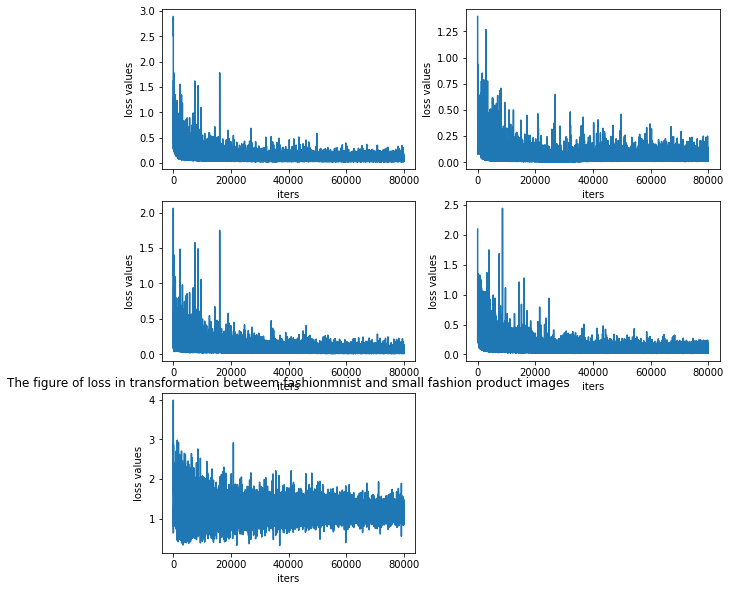

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
classes = [d_real_loss_list1,d_mnist_loss_list1,d_svhn_loss_list1,d_fake_loss_list1,g_loss_list1]
labels = ['d_real_loss','d_mnist_loss','d_svhn_loss','d_fake_loss','g_loss']

for plt_index in range(1,6):
    ax = fig.add_subplot(3,2,plt_index)
    plt.plot(range(train_iters+1), classes[plt_index-1], label = labels[plt_index-1])
    plt.xlabel("iters")
    plt.ylabel("loss values")
    pass

plt.title("The figure of loss in transformation betweem fashionmnist and small fashion product images")
plt.show()